# Mosaic & Sedona

> You can combine the usage of [Mosaic](https://databrickslabs.github.io/mosaic/index.html) with other geospatial libraries. In this example we combine it with [Sedona](https://sedona.apache.org).

## Setup

This notebook will run if you have both Mosaic and Sedona installed on your cluster.

### Install sedona

To install Sedona, follow the [official Sedona instructions](https://sedona.apache.org/latest/setup/databricks/).

E.g. Add the following maven coordinates to a non-photon cluster [[1](https://docs.databricks.com/en/libraries/package-repositories.html)]. This is showing DBR 12.2 LTS.  

```
org.apache.sedona:sedona-spark-shaded-3.0_2.12:1.5.0
org.datasyslab:geotools-wrapper:1.5.0-28.2
```

### Notes

* See instructions for `SedonaContext.create(spark)` [[1](https://sedona.apache.org/1.5.0/tutorial/sql/?h=sedonacontext#initiate-sedonacontext)]. 
* Also, notice we are downgrading pandas from default DBR version for Sedona Python bindings
* And, Sedona identifies that it might have issues if executed on a [Photon](https://www.databricks.com/product/photon) cluster

--- 
 __Last Update__ 30 NOV 2023 [Mosaic 0.3.12]

In [0]:
%pip install "pandas<=1.3.5" "shapely<= 1.8.4" "geopandas<=0.10.2" --quiet  # <- Sedona 1.5 dep versions
%pip install keplergl==0.3.2 pydeck==0.8.0 --quiet                          # <- Sedona 1.5 dep versions
%pip install "apache-sedona<1.6,>=1.5" --quiet                              # <- Sedona 1.5 series
%pip install "databricks-mosaic<0.4,>=0.3" --quiet                          # <- Mosaic 0.3 series [install last]

Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.
Python interpreter will be restarted.


_Verify our Sedona dependency versions_

In [0]:
import pandas as pd
import shapely
import geopandas as gpd
import keplergl

print(f"pandas version? {pd.__version__}")
print(f"geopandas version? {gpd.__version__}")
print(f"shapely version? {shapely.__version__}")
print(f"kepler version? {keplergl.__version__}")

pandas version? 1.3.5
geopandas version? 0.10.2
shapely version? 1.8.4
kepler version? 0.3.2


_Main imports_

In [0]:
import pyspark.sql.functions as F

# -- setup mosaic
import mosaic as mos

mos.enable_mosaic(spark, dbutils)

# -- setup sedona
from sedona.spark import *

sedona = SedonaContext.create(spark)

# --other imports
import warnings

warnings.simplefilter("ignore")

_Setup simple DataFrame_

> Showing blending Mosaic calls (namespaced as `mos.`) with Sedona (sql) calls.

In [0]:
df = spark.createDataFrame([{'wkt': 'POLYGON ((30 10, 40 40, 20 40, 10 20, 30 10))'}])
(df
   # Mosaic
   .withColumn("mosaic_area", mos.st_area('wkt'))
   # Sedona
   .withColumn("sedona_area", F.expr("ST_Area(ST_GeomFromWKT(wkt))"))
   # Sedona function not available in Mosaic
   .withColumn("sedona_flipped", F.expr("ST_FlipCoordinates(ST_GeomFromWKT(wkt))"))
).show()

+--------------------+-----------+-----------+--------------------+
|                 wkt|mosaic_area|sedona_area|      sedona_flipped|
+--------------------+-----------+-----------+--------------------+
|POLYGON ((30 10, ...|      550.0|      550.0|POLYGON ((10 30, ...|
+--------------------+-----------+-----------+--------------------+



## Mosaic + Kepler

> Mosaic has the ability to render tables / views + dataframes with `%%mosaic_kepler` magic [[1](https://databrickslabs.github.io/mosaic/usage/kepler.html)].


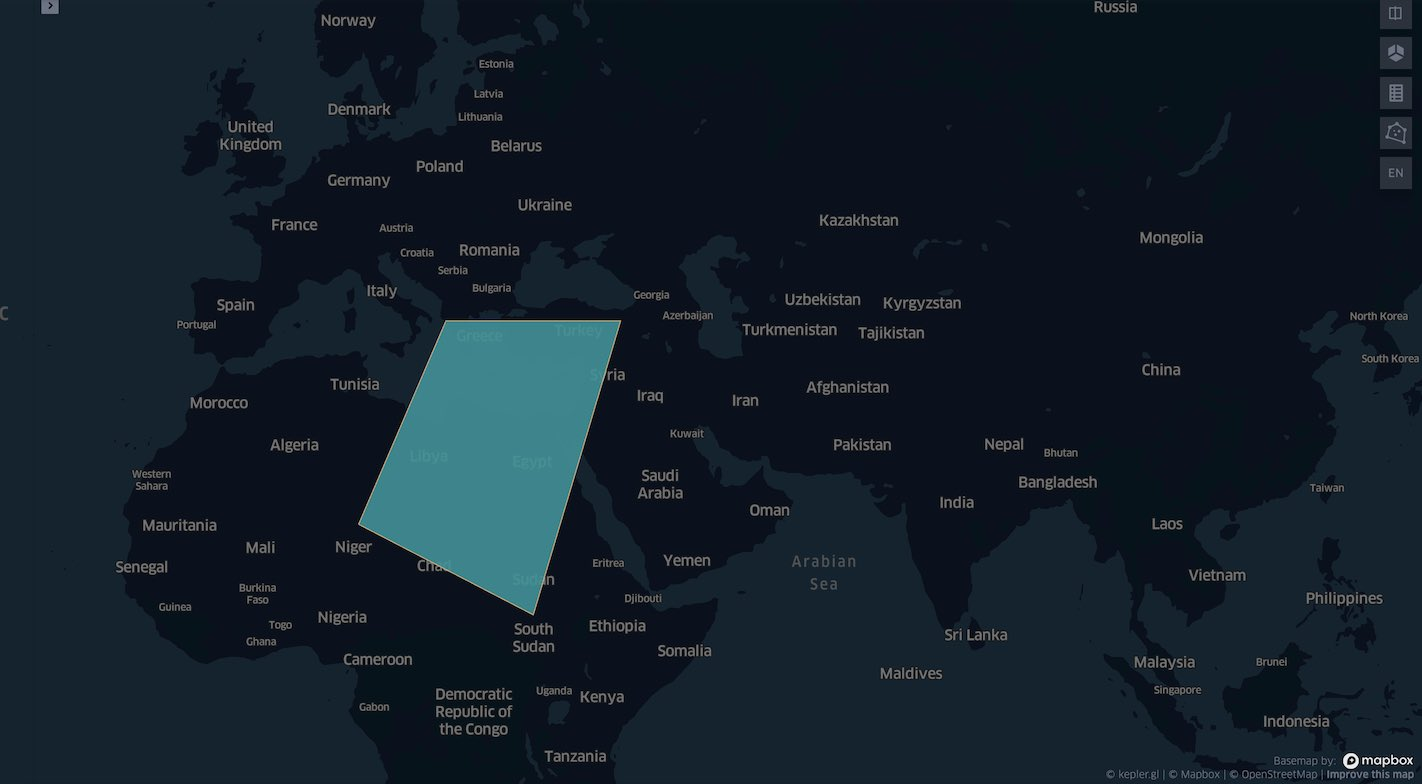

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACxygAwAEAAAAAQAABiCkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAxAFjgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAcEBAcJBwcHCQ0JCQkJDRANDQ0NDRATEBAQEBAQExMTExMTExMXFxcXFxcbGxsbGx4eHh4eHh4eHh7/2wBDAQUFBQgHCA0HBw0gFRIVICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICD/3QAEAFn/2gAMAwEAAhEDEQA/APkDNGaSiu04hc0ZpKKAFU8/jX0B4TjVvDOnMR1tk/lXz8vB/GvYfDvi7QLDQrKyupyksMKo67HOCBzyBihFRNzRr+a71C+0+QrcR2smFuYxhcsSfKYdN6DgkZHrg8V5p49ATxK6j/n3h/m9ehxeM/CcCeXDOEXJOFicDJOScBe55NeX+LtSs9W1xr2xcvEYY0DEFeV3Z4PPcUFSZzeaM0lFBmLmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmjNJRQAuaQkgZxmiigCjC9zJKQ5Kgc4x+lX80lFA2xc0ZpKKBC5ozSUUALmjNJRQAuaM0lFAC5ozSUUALmopphCm4jNSVl3qsJdx6EcUio6srM7ucscmm5NTy2l1Bbx3U0bJFNkxuR8rY64PtRc2tzZuIrqNomKhwGGDtPQ/Q1N0a2IMmjJpOvSimAuTRk0lH9KAFyaMmkooAXJoyaSigBcmjJpKKAFye1b4JxzWHCpaVcDODnFblNGcxc0ZpKKZAuaxbggTMF45rZrKvECy7h/EM0mXHcq5NGTSUUjQXJoyaSigQuTRk0lFAxcmjJpKKAFyaXcabT0ikkzsUnFBL7CbjRuNIQVOGGD70lIgduNSwJ5sgQnAwTUFW7MqJueuOKEO5LbxtGzuT9zIIqhuOK3sAEnHXrWNPH5UpXt1H0ptBe5Fk0u402ikIduNJuNJRQA7caNxptFAC7jRk0lFBSdhcml3Gm0UBuO3GjcabRQSO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GkyaSigadhcml3Gm0UynqhcmjJpKKBpi5NGTSUUDFyaMmkooAXJoyaSigBcmjJpKKBXFyaMmkopCchcmjJpKKZQuTRk0lFAC5NGTSUUALuNLuNNopMzluO3GjcabRQIduNG402igB240bjTaKAHbjRuNNooA3PDkUVzr9jb3Ch45J1V1bkEHqCK7zXNLt4NL1SfUdNtrDyGxYyxYVpTuOBhWOQVAJzj6cV5xpF8umapbaiylxbyCTaDjOO2a2G8QxTWmp2F1CXhvpTcRYPMMpJO4eoxgEd/wAazknfQ0g0lqab+FrVfEc+iCaQpFaNch8LuJCq2DxjHOKW+8L2Flb2u6W6Z7kQ7bgIhtMykAjcPmG3Pc80+XxlZO0uox2JXUpbY2xm8zMYBAUsE9cAf41Si8R6TaaVLpllZzhLlUSZJZy0e0HLbB1Ut0z2qfeL902o/DtppviWx0+BrxJWuCnmXEUZjZQjHfGQCDyOh+tUdG8OWesTOkwv97XEkRlhjQwphiAWLcnPcL09qWHxjY2Rs4rC1n8i1uTclZ5vMbOwoFQnO1ec1DZeLbOCG2FzaSSSWdxJPCUlKIfMfeQ6jqR29e9FpBeJx95C9pdzWjHJhkeMkd9jFc/jiq+41Zv7kXl9PdqNomleTB7b2LY/DNVK1Rg9x240bjTaKYDtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0UAO3GjcabRQA7caNxptFADtxo3Gm0hoHbsdFoRz52f9n+tdLFBNO2yBGkYDOEBJx9BXNaD/AMtv+A/1rutId447942KsLKQgqSCOV6Ec0FrYqnSdTCLIbabaxIHyNnjrxjI/GqTxvE5jkUqynBVhgj6it+5u7waNZuJpQxlnBIdsnBXGTnnFVvEH/Ibu/8AroP/AEFaLAcNrpx5OP8Aa/pWBuNb+vf8sf8AgX9K56kRLc//0Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAPeiiigAooooAKKKKACikZgo3NwBS0AFFFFABRRRQAVm3rZdUHYZP41pVkXeBOcccCkyo7np8clje+F9J8OajtjW+glMM5/5Zzq+Ez7Nuwfy71e1a1htNQ1HUbiCOe40/TLYxpKN6BiWUsR3xivJJ766ubeC1mctHbKyxLwNoY5IGOeT61op4k1yO+/tFbp/P8sRFyFO5F6KwIwR9RmsHTZ0cyPRrO20u8t7fW7yzg3zaddSywooVHMTptcDnGRxkdjWXosdv4rty01vbwy299BI4gQIPIK4K454yprjZ/Emt3M73M1wzO8LQHhQBG3VQAMAHHbn3qnp+q6hpZlNhM0XnJskwB8y+nIPr25p8jDmPQ9YsbEafdazZQRhNU+xpaJgAIZCd+3+6cVavobQaXqdvOLGS70pI5AtvbtEI3BztLE4dWHB/GvM5dV1Ceyg06WZjBbNuhTgBDyMgjnv3NX7rxTr97bva3V20kcieW6lU+Yf7WFBJ980vZsOZHZXNjp1s974rhhQ2c1ir20bKNgnmOzbjtsZc+2a8t6cdcdzXS6nr0VzpMGiafC8FtFIZmDvvZnb8BhRkkD1rmquCtuKTCiiirIsFFFFAN2Llj/rj/u1qVk2bbZwD/EMVrU0Zy3CiiimSFZd6wMgUdh/OtSsSYlpnJ9TSZcNyKiiikaBRRRQAUUUUATxJDINrsVb17VBRRQS3YkiQySBB+P0rbVVUbVGAKwlZkYMvBFbUT+ZGr9MimiGV7m2aU+YnXGCPWsxlKnawwfet+ql5Hvi3jqvP4UNAn0MqiiipAvWk7bxExyD0z2qe9AMOT1BGKzYn8tw+M47U6WZ5my3TsPSncb3uRUUUUhBRRRQxy3CiiigQUUUUAFFFFABRRRQFwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiiixSiFFFFOw+UKKKKBpBRRRQFgooooGFFFFAgooooC4UUUUAFFFFAJBRRRQDdgooooC9wooopXIuwooooG0FFFFBIUUUUBYKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKB36BRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoNFFAHQ6D/AMtv+A/1rrrG9axeRhGkqyxmJ0kBIKnBPQj0rhNMvobLzPNDHdjG32zWp/btn/df8h/jSLT0O5fW4Hto7c6fbYjZmAO7b82OgzweOeayb26e+u5LyUBWlbcQvQcAcflXOf27Z/3ZPyH+NH9u2f8Adf8AIf407juiDXv+WP8AwL+lc8K1NTvob3y/KDDbnO73xWXSIe5//9H4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKfmB7rZkkAdOwIq5TPLTf5mPmxjNPoGwooooEFFFFABWZfY8wEddvNadV7mUxJlepOBkUio7mPRSk5JJ70lI1CiiigAooooAKKKKBMKKKKACiiigYVZguXjbDklf5VWooE1c3UdZFDr0NMkuI4mCv1PpVOxfDNH68irkkEUvLDn1HWmZtWepNVGe0DAvHncTnB6VepMDrTEnYwKK1prVZTvBwcY9qqJZzMfmwopWNFJFSnKjtyqk/StJbKJSCSTjsehq504FFhOfYyI7SWQbuFHvVsWUQHzEk/lVyiixLkystpCpzgn61mzRtG53DAJOK26rTTxIo3APnsMGhoE2ZFaFlKc+SenUVHPLBKnygqw6cfpVeF/LkD9h1pFW0Nyqd5IyKEXo2QapXEwmfcucAcVEzM5yxJ+tO4lEbRRRUiCiiigdh6RvIdqDJpHR4ztcYNOjleJtydTxzRJK8rbn64xxTsFiOiiikwYUUUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooBsKKKKACiiigAooooGlcKKKKZV7IKKKKBhRRRQMKKKKACiiiglXuFFFFFg5QooopMUuwUUUUEhRRRTuWmFFFFBQUUUUCaCiiikTfsFFFFMoKKKKVieVhRRRQF7aBRRRQSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFu0sJb3d5RUbMZ3Z71c/sK6/vp+Z/wq1oPSb/gP9a6eC3nupRDbI0jt0VRk0FpHHf2Fd/30/X/AAo/sK6/vp+Z/wAK9O/4RfUvtP2PKed5Pn7M9t23bnpn9Kwp7ee1lMNyjRuvVWGDRYLI4K7sJbLb5pU784257VUrode6Q/8AAv6Vz1BLP//S+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiq/mSfaNgGUHBPoasUDCiiigQUUUUAFFFFABVS9P7nHqRVumsqtjdzg5FA0YWCOo60lWbmZZmBXPAI5qtUmqCiiigLhUhjIjEvYkipIraSVdwwB71oi3TyRC3IHf3p2E5WMailIwSPQ4p8UTTPsX6k0hjArHoCfoKStuCMxR7Cc8msu5OZ3PvimJSuyCiiikUFFFWYrZ5D8wKrjOaBXLlmsYj3LyT1P8ASrdIqqo2qMClqjJsKKKKBBRVeS5SKQIwP1ps4aSaG3B2iR1Ukf7RA/TNK5SVx0lzFGdpOT7VXa++X5VwffpXRah4Ra2ums7SZnePe0j3ETQRKkf3nEhyGAJHT1zVb/hFrl7W3uLe4t5DOJWOJBtVYjhn3dCo7ntwOc1HtEaezMNb6QH5gCPbirK3kB65H4Vor4S1ZiDutlV2RY3aYBZDIMpsOPm3dunNRDw9NItsqSRxSTrIWFw4Rd0b7CFwCc565/lRzoPZmVc3Acr5THvnFUqsXdrNZXMlncjbJCxRx6EVXqrk3toFFFFITdwooooFcKKKKACiiimWtdQoop7Iyqrno3Q/0oCwyiiigEwooopEhRRRQIKKKKACiiigAooooAKKKKACiiigAooooGlcKKKKAsFFFFAgooooAKKKKACiiigLhRRRQUkwoooplhRRRQyZMKKKKBoKKKKAYUUUUib23CiiimUFFFFIm6CiiimVdBRRRQAUUUUAlYKKKKAsFFFFABRRRSIdgooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFM0SsFFFFDFIKKKKRAUUUUAFFFFABRRRQAUUUGgDodB/wCW3/Af616v4NurayN5cXcixIqJlmOO5ryjQf8Alt/wH+tdXZXTWVyl0iI7IcgSDcP/ANfvQmWtj0calK2p/wBuLaXBs/J8neFG7727fs+9t7dM1g+ML601A2lxZyLKuxwSvY5HB7g+1bP/AAnNp9l3+S/n9PL/AIfru9PwzXn9/ey6jdNdzKis3ZBgf/X+pqmxnJa9/wAsf+Bf0rnq6HXv+WP/AAL+lc8KgiW5/9P4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGsyoNzHA9TSghgCOhrLuA8tyYxk9Me1agAVQOw4oG0V5rkQuFIzxk1Eb5McKc1SmYvKxJzzx9KIYjM+0HHc0i+VW1NK3nM5bIAxVmmJGsa7UGBT6ZDCiiigQUUUUAFFFFABRRRQBiSwtC2GHHY9qirfIBGDyKznsXyShGOwNKxopdyjVm3gMzZb7o6/wCFSx2TE5lOB6CtBVVFCqMAUWE5DgABgUUUUyDEnG2Zx75qW0kWNmZzgY/Opr5D8sg6Dg1n0jVaouSXjuu1Rtz39qht4hLJtP3RyahqzFII4HP8THAoC1tiKXZ5jeX93tUdFFIZoW1tG6CR+c9B2rQqG3G2BB7VNVGTeoUUm4ZxkZ9KWgQUhIUFj0HNLSMAylT0IxQBnPeAtuRAcdC1T75Qsdy6/NFIsgA9FIP9KdHawpg4yferNKxd0tjSm8VwS341IWUiS72csl5MOW5IHy4A9sYIpG8XGT/W2URB+0KwR2QGO5O504HBzghuvHTmsC82pEEUAbjnis2s/Zo1U2zrZvFTSRW1vHarHFaTQyRIHJwIBgKSRznJJP6VZs/FcgPk/ZxyJMFZGRsvMZuGUZAycEfxDrXE0U+RBzM0dXuzf6pcXzAKZnLsoOQCeoBrOoopmUtwo68CinxuY3DrjI9aEhpDSrKcMCD70lSSyvK258fhUdDEwooooEFFFFA47hWpbwAIwYhlbGMVl1NFM8JyvIPUGqKauE8RhfbnIPIqGnySNK+9utMpCsFFFFFh27hRRRSICiiigAooooGrdQoooplXCiiigbVwooopWJ5QooopjSsFFFFA2gooopGYUUUUAFFFFABRRRQFgooooRUQoooplhRRRQJoKKKKAQUUUUDCiiigWgUUUUiWwooooJCiiigLhRRRQUnYKKKKY2wooopXE5BRRRQTcKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigEFFFFMu6CiiigLdwooopWFyhRRRRYOUKKKKCbBRRRQAUGiiixSRqaZfQ2XmeaGO7GNvtmtT+3bP8Auv8AkP8AGsKzsZb3d5RUbcZ3Z71c/sK6/vx/r/hQOzNH+3bP+7J+Q/xo/t2z/uv+Q/xrO/sK7/vp+v8AhR/YV3/fT9f8KQ9Rmp30N75flBhtznd74rLq3d2Etlt80qd+cbc9qqUyJH//1Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprsVQsOwJp1NZdylT3GKAIpHSBTIRy3XHc1WuX8y2V/Uir5UMpVuQaybiBoAAGypPSkVErVLDKYSWAycYHpUVFI0LX2yf2/KpIruUuFfBBOOBzVGrlkmZC/90fzpiaVjUooopmQUUUUAFFFFABRRRQAUUUUAFFFUHvQGIRcgdzQNK5ammWFdzc56Ckhl85N+Mc4xWVLK0zbm/AVpWibYQf73NIpqyJJk8yJk9axK6Csm7TbMT2bmhhB9CrRRRSNAoopyjLAepAoFc3EG1APQCmTyGKIuvWnKdztjoOPxplwjPCyryTVGXUrWIB3yHls4zV+o4oxEgQdqkoBu7CoJ7hYcZGSe1T1j3TB5iQcgYFIcVdlmK83PiTCqelX65+uqEUCeHrK76TTXE0ROT8wTG0Afj2pOVtynC+xi3/8AB+NZ9enx+G9KGZ7t5nWNZ0kiZoiySRx7+qHAx6HnOM8VhQ+HrIxR6kssjWjxQPGWCktLLJ5ZjYDjC4O7HOKh1EaKDSONorvbzwzabNQn3PC8H2iSFR5axukDYIVM+YB2z0BrgqcZXBqwUUUVQgooooEwooopGYUUUUDS1CiiimaBRRRQAUUUUAFFFFAgoooosJxCiiikSu4UUUUy9wooooAKKKKBNhRRRQGoUUUUFBRRRQLqFFFFJkyCiiiglBRRRQV6BRRRTKSCiiigFboFFFFAm7BRRRQPUKKKKA9QoooosLlQUUUUrEuIUUUUyrBRRRRYOUKKKKVieUKKKKBJXCiiimWkFFFFIhIKKKKBtWCiiigQUUUUAFFFFABRRRQFgooooAKKKKACiiigAooooBBRRRQDCiiigAooooAKKKKENK4UUUUWG4hRRRTsNRCiiiiwcqCiiigYUUUUDCiiigAooooEFFFFIl6MKKKQ0yjodA6Tf8B/rXZ6Xp7and/ZVkWLCNIXYZAC9eBXGaB/y2/4D/WvSPCR26uW3bcW8p3Yzjgc474pAEmhafDHFLLqtuqzJ5kZKthlPcc9Ky9U07+zZ0iEqzLJGsquoIBVunWvQbu/VILVv7REe+ENu+zbt/P3sY+X6Vyvixt97buH8zNrGd+Nu7rzjtn0ptAea690h/4F/SueroNf/wCWP/Av6Vz9IT0P/9X4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsW4kd5GDHhSQB6VtVRuJk2PGgz6kdOTSZUTNooopGooBJAHU8Vs28Xkx7T1PJrMh8gZaYnjoBWpHNHKPkP4d6aIkS0UUUzMKKKKACiiigAooooAKcUkVd7I4XGdxUgY+pGKik/wBW3+6f5V6ZqOuapZa7plhaznyZILUNAQpV/MJVsgjPT0PaolJrYuMU9zzN2CIXPIA7ViuI937rOPevZLzRdEsBPdzR2kiS3skSrdzGJEReoTAOWznHoKx7u08L6RYJe29rFqUct89vG7SNt8vbu6rwxXkA1HtUaKnY8wrTtrhCqwnII49q7u90vQ9FXW7mSzW6WxuYFhjkdgAsqqSCRyQC3etJ9I8Otqb6RBYCIy2JvVn8xi8bEZCqDxtFHtBuFzz+o5IROvl4JJIC4GTk8DA75rvtH0i0u7WKz1K2tYZ5bMzqwmb7VnbkOY8YAPpmoM6TY3ej21vZhri7jtLh5mdvkLMPuryCTg5p+17IlUn3PL5I5IZGilUo6nDKwwQR2Iplek+K9Ns9OtrvUWEd1PfX8qpKhJWBUJJX/roehz0/DnzuKJ5ThB06mnGVypKxFT1RirOP4Bmr5sV7OfyqxFCsSbOueTV2M3JbiwJ5cSr3xk/U1LRRTMwooooAimO2Fz7GsStyb/VP/umsOkzSAVr2mvaxY2psrS5aOEkkoApGW69VJ5+tY+4EZBGPWlqWk9y72NxvEuvPIkrXkhaMllOE4JXaT93ByDg5zmqR1PUDAlqZm8qOUzqnGBITncOOufw9qoUEgDJo5UO7NhvEGtPDJbtdOY5d5dSF+bzOXzxn5jyQDiseiihJLYVwooopsiQUUUUg6ahRRRQSFFFFMtIKKKKCgooooAKKKKACiiigQUUUUAgooooE4hRRRQFuwUUUUDV+oUUUUDCiiigAooooAKKKKACiiiglahRRRSJasFFFFMtBRRRQMKKKKBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiiglpLUKKKKBp3CiiigT0CiiigHqFFFFKwlEKKKKY2tAooopIUQooooBbhRRRTYSCiiikSFFFFABRTkUu4UDOTVmVbeFygUufr0osOxUooOO1FAgooooAKKKKACiiimaIKKKKACiiigEFFFFAMKKKKAQUUUUDCiiigQUUUUib2CiiimNO4UGikNAzodA/5bf8B/rXe+H76307UftFyzIhidNyjcQWxg4/CvNdMvobLzPNDHfjG0ema1f7ds/7r/kP8aQM9el1+ykjiRNVuUMaBWYQDLn+8crgH6cVzPiG/t9QvI5beRpQkKxs7rtLMM5OK4f+3bP+7J+Q/wAaP7ds/wC6/wCQ/wAaLgV9f/5Y/wDAv6VzwrU1O+hvfL8oMNmc7h64rLFNDP/W+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACio5ZPKjL+nT61kyXE0gwx49BSKUbmyRkYPeqcsAjg8uPuw6/WqaXMyKFUjA9RV+1mMynf94H9KB2aInhH2XMgwyDrWdXcaXb29zYa008Su1vp5liZhkq+T8y+h461Nomj2WpeHwsqBZZdUjtxMAN6oyjIBPbPOKhzsaRjdXOBp0blWDxnp6V2WpeHtHj07UZ9LubiWbTGCzrMiqrAsVyhUZ4IPX/A11NzpekC/wBWOreZM1tp8coZEjG1So+ZBwA46A9Mdal1CuQ8/jfegcdxmnkgcmuw0zwjDcWtoxe7Bvg0kTRxq0UaEnZ5pPOSOu3p+tW9M0PTbDUdMj1WaU3Vw4kEKIrQgZIAcnk5x2qvaIy9mzhKKsXgC3tyqjAFxMAPQCRgBVerRDVgooopiCiiigBCAwKnuMV06+L9bVUCfZg0aCNJBCPMAAwMMWPP4VzNFJxT3KUmtjVttb1C0gkt1ENxHK5lZLqPzF3nqw5BBPesa/1vULqBbK4WJESc3IWNNuHYYOOcbcdBUlZd7/rh/uipcEVGb2Na58R398l4t2EKXrxyTbFxlowAmOTgYHPXNXIPEl/NqH28bBMtv9mGV+Xy8Y6Z6+9c7bFGVoGBy3cVLDbyQTAnlSCMijkQ3Jm1D4v1e1EaItuZIYvswmeLMpjAxtZ85IqvFqd7cz2t87Jvso44ogF7RHK7ueT69M1mXC2zIZFI3ex6/hU9oAIQQuM9ff3oUEDm7FiXWtVlivbaVFaO+l86VShIEgP3k5+U/nxVKyWRdwZSAcdavUU1FLYlzb3CimIHAw5yc9fan1RAUUUUAFFFNZlRSzHAFACkZBHrVmTTZp/CUUtpbvLKt5MrtGhZtoj4BKgnGaz/ALXb/wB79DVJL68hDJbzzRoxJ2pIyg59QCBUTV9jWnpueqmyslvsG28511O2jMhP3VaBG5AGNuTjB4JOetYNzomm39vNe2UEiSmG8ZYg7OTJBIqhgPQhjlcYrhhe3qlis8oLY3EOwzjpnnnHbPTtSJd3cZDRzSIVJKlXYEFupBB4J74696z9m+5rzI9KHhHTRLJBJC6h0wkgkkLJIsIkbKhSgAJ/jIz0HSkg0PSE1Qw2kUkT2d3aoXMhfeJ1BPysMLjPFebi9vV3bZ5hvO5sSMNx9W55PuaQXd0GLCaTJIJO9skjoSc9R2PbtRyPuHMjt73w/aJol1fSRFLiOMXCOruwZWk2gEFQgJHYEkd64CrDXd20fktNKY+fkLtt55Py5xyfaq9XFNbkt3CiiiqJCiiigAooooFbW4UUUUDCiiigYUUUUAFFFFBLQUUUUBFBRRRQNBRRRQMKKKKAClAJOAMmkqWGURMXxk4wKBEZBU4YYPoaSnu7SNvc5NMoAKKKKBhRRRQAUUUUCCiiikiUFFFFAbsKKKKZYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRU6W7vH5uQF96goEFFFFAwooooFYKKKKACiiigAooopENWCiiimikwooooGFFFFIh+QUUUUXGpBRRRQS3cKKKKACiiigaQUUUUDb6BRRRQSFFFFABRRRQAVprEsNszHkleTWfHG0rhF6mtG8bbCEHcgflVIp9EZdFFFIsKKKKACiiigTdgooopGYUUUUXK5gooooJbuFFFFABRRRQAUUUUBct2lhLe7vKKjZjO73q5/YV1/fT8z/AIVa0HpN/wAB/rXZ6fpN7qhkFmqnygCxZgoGf/1UFpaHBf2Fd/30/X/Cj+wrv++n6/4V6fBbeH0tpLW4uQ90/wDq5lDeUh7Dd3GepxisO6tZ7KYwXK7GHI7gjsQehB9RQNHAXdhLZbfNKnfnG3PaqldDr3SH/gX9K56i4m9bH//X+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTcvTI/OlrCeNo2w4wetIpK5o3ix7Azk5HAA71l0UUjRKwVNbuySrt7nB+lQ12Hh/RYr621CXDyTW9p50Kx5yXJIAwOTn0obtqG+hLpOprpks3nQi4guITBPETt3IfQ9iK0h4gsrZLS30i0aC2guVunV5N7yMvQFjnAx05pt1o1rZzWGmTAy307o1whYiNFc4WM453HuR0/EU0+HyftFxNc2tjbxXT22ZXbAZeQFyMkY9eeMms24t6glJKyMFtcQQ6xbmJgdTbIOf8AV4dn59euK1X8XWs+qXd1dWrvb3totrLErgMAoxkN05pk/haYT3iX0sFqtns824kJKfP9zbjk7qbJ4JuYJZRdXttFDBGjyTuWCDzD8gHAySOfbNJ8hachY/E2mS2UFnqNpPJ9kUxwNBO0ZMecqr4xnA4yKvWHiawYWNxc2by3OnAJEwlKqUByN4xkkDp61FqPhON7m1trCSGNBYLdXNyXJiHJBcH0PYCq9r4RvWuovsdzb3EM8Mskc6kiM+Vjcp4ypGf50LlB83QzJpPOnlnxjzZHkx6b2LY/DNR11CeF3kWGZNQsTDctsgl3nEkmcbAMdfeucngltp5LacbZInKMPQqcGtYyT0RhKLWrIqKKKokKKKKACiiigArOvtmV/vf0rRqhemMrjI3KenfBpFR3KMbmOQP6Hn6Vri4hYZDD8axafGVVwzDIBzigtq5p/ZYG+YqRnnGameWOLAc4z0qhLeO/Efy+vrVMkscsST70XJUW9zUW6DzCNBlT3q3WHHLJFnyzjPWr4vo9uSDn0ouDj2LtRyyLEm9vwHrWa93Mx+U7R7VXZmY5Yk/Wi4KHcsPeSvwvyj2qsSScknNJRSLSsbEVxG6jLANjkGo7qaMIY/vE+nasuincnlCiiikWFFFFABRRXR6NoMOqWNzqF1ex2cNqyK7SIz5L9Pukd6TdtWCVznKK6XUPDF5a3NrBYOL9b2MywPApG9QcHg9Me5qaw8KX8mptpuqJJaMLeS4UkA5EeOAQSCDnseKXOh8rOUorZt/DmvXVgNSgs5XgZN4ddp47kDO44+lLD4d1y4hFzDaStEyLIHGNpVzhSCTzk/jRzLuFmYtFaB0rUQ9zGYG3WYzcDjMY6fNz6+manvtA1rTbdbu/tZIYmIAZ9vU9BgEkZ9wKfMhWZkUUUUwCiiigVgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAPjCFwJDhe5p0zq7AJ91RgZqKigQUUUUDCiiigAooooAKKKKBBRRRSM9wooopmiVgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA8OwQxg/KTnFMoooEFFFFAwooooAKKKKACiiigluwUUUUMUu4UUUUhJ2CiiimaBRRRQyWgooopEBRRRRYrl7BRRRQS1YKKKKdy1LuFFFFAWuFFFFIlqwUUUUCSCiilVWdgqjJNAJGhYx4BlPfgUy+J3IPY1eUJCgUkADjJrMupRJJhei8ZqhrVlaiiikaBRRRQAUUUUjNhRRRQIKKKKAsFFFFABRRRQAUUUUAFFFBoG1Y6HQf+W3/Af613luZbPRp7hdyG6kSBSMjKqC7Y9j0rg9A/5bf8B/rXdprt4LOLT5UhmgiGFSRM8fXIPHYihFLYWCGGGK21O8tg9qd0TKknzO6g/MQen0HHFWre/kXw5d2xUMnmrHHu5KB8kgfTHHvVHfotz9+OW0b1jPmx/wDfLYYfga0LjT1t/DjTQ3EcyPdK2VyDgLtxg85B5I9KYzzbX/8Alj/wL+lc/XQa/wD8sf8AgX9K58UiZH//0Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAD6ViSRSoxDgk9cjmtuqd5KUUIpwW6/SkVFmXRRRSNQrs/DmqJp9hqALvHLcWhhgaPOQ4JI5H3evWuMrXtARAM9yTQ1fQlu2p2lxrVhez6dqt0WW9t5EW62oSJI0bIkBAxux1HX9Kz9W1zTr3S7m1t3O+XUZbldykDy3UgHJ6HJ6daxOe1Ys8TRv8+PmyeKn2aGp30PadN1W01O91S+05ZLjfHbIsce1ZGCAhiEl+XAPfrWRrU+mQx3ej6rezo975N35kiCV4pE48t1hwOijG2vJ++e46GjgdKj2eppznpj+ItAdjp3my/ZZtLWwefyzvVlJw2zqQc84/xqTT/EehaVBb6XDO88UUNyXnMTLmSfoFQ5OBzkmvL6Kfs0LnO7tNUtRpGkWxLb7S7aab5TgIXDcHucDoKp6rcxXuqXV5BkxzTO6ZGDgnjIPIrnVuxGipGucDnPrViG6WVthG09verUUncyk20W6KKKszCgkAZNFUxKLpHiUYOO9A0hTewg4GT7gVBNdh02xZBzyao9Diilc05USLNIjbwxJ9+aYxLEs3U80lFIYUUUUDCiiigAooooAKKKKACikyCcA8+lLQAUUUUAFFFFABRRRQAV6P4MkmGh6nDZtai4eSExrdkeWQPvZB64HT3rzikKq33gD9aUldWGnY9uXUdPi1O2jv5rX7bJp8ttKYpCIEclTGoIPybhkHGP5VWsriSxu4dPvIrS1iis7sxeVOZSN4XKkt0BPIGe3tXjeABgdKQKoGAAB7Cs/Z+ZXOew+FodOsU0u8h+zbGt8T3EtwRKkpUgxrHnGOnHTv1rndS1PyoPDcazHyYLeF5UVuAVkUncB3AHQ1wGBnOBnpmlpqmLnPXryNdOl13Vxd2xXUgq2ZSQMSxbIJHYDPNZXiqGGbTJNT1FYINRkmQYtp/MSdcYZynRSB3/AArzUAAkgAE9TQFVfugDPXAoVPrcOYWiiitCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooEwooopImKCiiimWFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUjN9gooooEFFFFM0ugooopXJcgooooJCiiigadgoooplaMKKKKLA4hRRRSEnbRhRRRTKeoUUUUCtYVVZjtUZJrWtUWNCAQWz82P5VBa24K+ZJ36DpxVppIYExwAOgFNIh9kQ3hi2Yc/MOVFZdPkdpHLt1NMpNjvYKKKKC0FFFFAMKKKKASsFFFFIm19QooooYSCiiigkKKKKACiiigApDS0Uy1qaemX0Nl5nmhjvxjaPTNav8Abtn/AHZPyH+NYVpYS3u7yio2Yzuz3q5/YV3/AH0/X/CkUaP9u2f92T8h/jR/btn/AHX/ACH+NZ39hXf99P1/wo/sK7/vp+v+FADNTvob3y/KDDbnO73xWXVu7sJbLb5pU7s42+1VKDOW5//R+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAY8ixrufpWRPJ5shYdOg+las0bSxlFOM1jMjocOCDSZcBtABJwOamjt5ZOgwPU1pwwLCOOWPU0FOVjMW3mbopH1rZVQqhR0AxS0UEN3EJAGTxWXdypI4Cc7R1qW4gnll45Xt6CqbwyRkhgeOpHShjikR0UUUjQKKKKACrNmuZwfQE1XVSzBR1NbEECwr6k9TTRMmT0UUhIUZY4HvTMiKeURRknqeBWSkrxoUQ4z1Pen3EnmykjoOBUFI1itAooratPDmvX1v9rs7KaWI8h1AAP0yQT+GaltLcqxi0UN8rbW4OcYNJkD+VMBaKTIzjPbP4UZXG7Ix69qAFopAQRkHOelG5SMgjHrQAtFGaKACiiigD3SCxncaTCunWkunS2sZu5ZUTIJHJ3Fgc9OxrjpNC8M2jWi3r3Mh1OV/s7QFAkcRk2Rsd3LZDD1rl9Z1ltXW0RowgtbdbcDO4Nt/iII4PtWnZeJrSK1s4dRsFupNOz9mk81kwNwYBlAIYAgYrHla1Lujc1HRxZ6JZ6TMrzFNWniPkgeY67WxtzxkjGM8ZqyfBOnyvZusV3aLLdfZpY52jZsFCwZSmQORgg1z6eNL1Wt5miR5YL2S8LEnDGQFSmMcAA8Hk1Pb+Mbax2Lp+nJCiXf2wjzWcs+0qckjjOe3TFLlkO6Fl8PaLe2MsujPcLLbXkdnJ9o2kOZH8sMAvTB7elbK2Gg6dBr+n6f9oe4tbGRJHm2FGI6lQOVINcbb+IJbW0vLaKMbrq6S6D5+40b7wMY5GfcVqXXi22nW+eLTkhn1KForiUSs3Ld1UjA9T602pCujij1NJQeTmitiAooooAKKKKACiiigQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiikZbhRRRRYrlCiiiiwKIUUUU7DcQoooosHKgooopE27BRRRTKSCiiigoKKKKCWrhRRVqG185d24D2HJoQk7FWtG2gQR+dKM9xn0qQWkEfzOc4/vdKiubpGQxx856mj1Fe4yW8LptjBXPUmqVFFA7dgooooHZBRRRQO4UUUUDCiiigAooooAKKKKCWrhRRRSJasFFFFAgooooAKKKDQVFnQaB0m/4D/WuhJA5Jx9a57QP+W3/Af613+gsEkupCSpS2ZgwQOVOV5CnqaCzBBB6EUtdXbzWsqXz6gTJGxgj80oEZQxIDhR02nr6iszWrZrOe3tn27ktYgxXoT83I+tFhHC6/0h/wCBf0rn66DX/wDlj/wL+lc+KBSZ/9L4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqrLdxxtsxu+lFzOsaFAfmI/Ksn6Ui4x7ll5oyhSJNu481WrQWxyuXbBPp2pBYnPzMMewoKTRQorUWyjDZJJXHQ082cB7EfjRYXMjJVihDKcEVsW5mZN0vU9PpSpbxRnKrz6nmo7xisPHGSBQJu+hJJPFH95ufQcms6e5aUbQMLVaii5SjYKKKKRQh24O7gYOceles+ILS/v/ABfZaZDNPBaSwxJC8TMFVdrEkYIGcjmvJ66C08VeI7C2WztL6WOJBhV+U7R6AspIH41Eot7FJnf26aPoml2DTNCY7l5BcmS1adpdrlSm5fuEDgD1rN1W8stL0ewXTLaE/bPPTzpY8uIhLgAZwQ2COTzxXG2XiTXtOjaKxvJIkdi5UbSNx5J+YHBPtVG51K+u1iS5laRYSxjBx8pc7mxgdzyahU3fUfMj1y9ubaLUdbsvsVm0WnW32qAGEZ8wKpyxzzyenFZ7Qm8k07XYktbd306a4unaHemI2UbhEDy3PFecvrOqSS3E8lwzPdJ5c7ELl0xjaeMYwO2Kkg17WLVoGt7l0NsjRw42/KjHLKMjBBI5zmj2bDmR6n5WnzS2+qrFBcGbSrqZmMPlpI0bJsYxnpwfxFYL6pbCz0bxNfW0G97ia3uRHGFR4lJGSvIyo5FcbL4j1yd/Mmu5Hby3iydv3JMb1+70OB+XGKqxahIYoLO83TWkDlxCDt5b72GAyCfWj2bHzI7LWtLj8N6ReW7KrSXt7tt3wCRboA+R6ZztJrz2tzXNbfWZYMR+TDaxCGGPcX2qPVjySeM/SsOtIKy1IkwoooqhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUCTCiiigYUUUUCsFFFFAwooooAKKekbyNtQZNSTQNDgk5B9PWgVyCiiigYUUUUrENMKKKKZQVfgCJavIwznP6dKoVMZf3AhHrk0A0Q0UUUDClBIOQcH2pKKBWFLM33iT9aSiigLBRRRQAUUUUiGwooooEmFFFFMtO4UUUUFBRRRQAUUUUAFFFFBLVwooopEBRRRQNK4UhpaQ0zQ6HQP+W3/Af611EFzcWr+ZbSNGxGMoSDj04ritMvobLzPNDHfjG0ema1f7ds/7sn5D/GkB0Ut3dTljPK7l8BtxJzt6Z+meKieR5Mb2LbVCjJzgDoB7CsL+3bP+7J+Q/wAaP7ds/wC7J+Q/xoAg17/lj/wL+lc8K1NTvob3y/KDDbnO73xWXQZy3P/T+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApDkjAOPelooArRWyoSz/ADtnqamaONiGZRkd6fRQO4UUUjZKkLwccUCForMhuXjcrOSe30NWhdwH+L8xSKcWTPIkYy5ArNubgTAIg4Bzk1VZi7Fm6mkouWo2CiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAD0R5XEcSl2bgKoJJ+gHJp629w8jRJG7OudyhSSMdcjGRjvnp3ra8KHHibTj/08r/Wup8PceMdXB4Kw3272y461EpWKSueezWtzbiNp42QSoJIyf4lPRh6g1BivXW02ym0qx1a6Ed0bPRY2WyP3mJ4Dt/sL7VhXaaZaaRpSQ6fFNd6nbAmRiRtYsFBUDjcxbrxgCkqg+Q4EIzMFAJLEAD1J6VNc2tzZzta3cbRSocMjdQSM8/hXp15pOly6beAwafDdWMsIIsSxZS0m1kkJAzx39fpUmp2mlWEmuXz2MN01rdwRwpLkqBIi5B7kZOcUvaBynkuD0or1tdC0Rr+41AW8EcSaZDeLBKzCBZJSwO7GTsG3piuL8TJo++1m0prbe8R+0R2jFolkBGNucEBhzj2qlUu7CcbHMUUUVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBNBL5Mm7qOhqS4ufOAVRhevNVakWKR13IuQPSgVluR0UdOtFAwooooAKKKKACiiigAooooAKKKKACiiigAooooJlsFFFFIgKKKKLFcoUUUUygooooGFFFFABRSkEYyMZGRSUAFFFFABRRRSZEkFFFFNDjsFFFFBQ0ikxT6MUAMxRin0YosA0CnUUUjN7n/9T4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqIzQr1cfnSyxiWMoTjPesQgAkDn3pFRVzWS6jkk2DIz0J71PvTONwyPesGjFFyuQmuP9e/1qGimsdqM3oCfyFIpDqK9D1rQfCuiu1vcSag0ohEuURDHllyATj86xZ/B+q2kMc109tGJdmwNLgtvxyAR90Z+Y9veoU0Vys5aiup/4RLUXNv8AZZrW5S5l8hZIJd6CTaW2sQOOB6Gor7wrqlham7ZoJlWQQyCCQSMjscBWAAwSePrT50HKzm6K6qfwdq8E0dqWtmuJXCC3SUGVSRn5lxwABknJxVDU9AvNMgW7eSCeFnMRktpPMVXAyVbgYNHMgszEoooqhBRRRQAUUUUAFFFFABRRSgE9BQAlFOVJHJCKzEDJwCeB347U3BoAKKKKACiiigAooooAKKKKBMKKKKATCiiigY+OSSGRZoiVdGDKR1BByD+Brqbzxrr97ayWk0kSiZdsrxxhXcejMOue+AK5Oik4p7gmb0XiXVoLm3uonQPawfZo/l48v+6w/iqpc6ve3QtVcqosl2wbBjaNwYfXBAxWZRRyod2dRdeMNavIpIZTCFmKmTZEFLlSCGYjknI61Tu/EWqXqXSXDIReyJLNhcZaMAKRzx0HFYdFLkQXZ0MXijWYbqO8jkUPFALYDaCrRL0VlPBqjqmrXWrypLdLEhjXaqwoI1AJz0FZlFPlW4rsKKKKYBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAWYrO6nhluIY2eOAAyMOig9CfrSyWN5FbR3ssTLDKSEkIwGI6geuK7XwiLI6HrY1EyC38qHzDFjfje3TNausWV9eeLNPtbMQGz8kNYBl3QiFUyxK/xEHkjv8ALWbnrYpRPKgQRkEY9aMjrmvV751vNP03VdHS1vLuS9a2R1tjEjgoTtaNjyFPOe35064uI7zWls7FLFRptvJJdXJgDRl1xvKxryQp4Xnrn05PaeQch5lZWN1qMjRWSGRlRpSARwifePJ7ZosbG61O4FrYoZZGUsFBAOAMk846CvZLOOwuLu01GIxD7Vpl75k8UJiVgrIA3lnngH8e1VNKgt9O1/SbGwRHtPsMkyXGBm4ZkO4k9QB029s0vaD5TxoEMMqc/Sp7a3mvJlt7VDLI5IVV5JIGTj8BmvQ4LrT9S0Sx1rVLKACC/WGRLaLYGhMe7btBOQDg+4FdNpcjya3ZajaNZT2VwJ44pIYPKcFULbGB7jHX6jvQ6nkHKeH5A6kc9PelJA5PFem6FcuYE1a/NjDFfXYgVDamQuwAUou04RePzyav6u1p4as5JtPtLZmGqSQKZow+2Mx7yo5GOeB6Cj2nSwuU8jorpvGNnbWPiO6t7RBHHlGVF4C7kBIHtmuZrRO6uS0FFFFMAooooAKKKKACiiigAooooAKKkjRXOGYL6ZqV7WVRuXDj2oFcrUUUUDCiiigAooooAKKKKACnxyPEdyHFMooEKzFiWY5J6mkoooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAmrhRRRQCQUUUUDCiiigAooooAKlhWNpMSnA61FRQImnl818gYA4H0qGiigAooooAKKKKBbhRRRQUFFFFABRRRQyZBRRRSuLmCiiigN2f/9X4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqA20BzletT0UDM2SyYH90cj3qkylWKtwR1rfqjexps8zGGz+dKxUZdzNprglGUdSpA/EU6ikaHe+MPFd3ezyWWlXjNYyWyRlFACltuGByN3XHejUdU0W78U2F5ckT2UdvBHMMEj5Q24Y6kBiCR3rgqKj2aK5j2WDxFpFv5EdxfwTGO/WfdBCYkWIKw7D5iO/5VyVhrFjZ2GpguDJJqMNzEn99I5t59unrXD0UvZoOc9O/tHQLHxP/wAJTb36zRzylntxG3moJFwxOePl+mSOKyvEeopJp/2S21G1uonlD+Vb2/lEYHDMemR0xXDUU1DqHMFFFFWSFFFFABRRRQAV2ng/7PZG51u6mjhEAWKJpclS8hy3ABPCA8471xdHvSkrqwJ2PVU8Oacb0bI4pYI795JXJXH2WSLemckfKGOB7irGn2dnC1rcw2lvCZYZIljlQGSRzCW3Bw5DK3TkAjOK8hKqeoBx04pNqc/KOevHWs/ZvuXznpEa2MMyWaWsMDtpD3EsiZDeaUIKZzgAEfd9areJdKs7LSI5EihWZbhU8yFAgkjaItn77Fhu/iOD2xXBcf1pAqg5AAz1wKahZ3E5C0UUVoSFFFFABRRRQAUUUUAFFFFAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUVZhtXl5b5V9atfYogOS1OxLkjMoqzI9uE8uFc/7RqtSGgooooGFFFFABRRRQAUUUUAFFFFABRSqrOwVRkmr8djxmVvwFAm7GfRV97Fs/u2GPeontJUUtkHHPFOwuZFWiiikUFFFFABRRRQAUUUUAFFFFAFyC/vLa3mtIJCkVwAsqjGGA5APGeD6Yq1FrmrwRW8MVy6raOXgAx+7Y5BKnGeQTwcj2rJopcqC7Oibxb4jaRZWvZNyMXQ4T5SRtJA246EjpQ3izxG8qTteyF487G2oMbuCMBQCD6HNc7RS5V2HzM3JPEuvSyCaW7dnCPGCQvCSY3qAFxg4H5cYqK213V7OKGC2uGRLfd5QAU7N/DYyD1Hb8qyKKfKuwXZo2urajZRJBaTNGkcvnIqgcOBt3DIPOOPT2q3P4l165uYbua7cy25JiYBRsJ4JACgc98isOijlQrs6BPFXiGMytHeSL57b5MBOWwBkfL8pwMfLiqV3rGp38ZivJ2lUymYhgP9YRtLcAckcelZlFHKh3ZavL261C4a7vZDLK2NztjJwMDoAOlVaKKYgoopQrHkAnHpQAlFKqs33QT9KQgg4NABRRRyeBQAUUdODRQAUUUUAFSxTPCcr07ioqKBEkr+Y5fAGfSo6KKACiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAoVj0BNAUtwoJ+leifDya1t5dTmvQDCtqgkz0ClyCfwBrpfCmgr4fu71b1cyTPLbW2ecxRoXL/jwD71m52uilE8Vor0Cz07QLC10a2v7R7qTVI1d5RKyeWHYKu1V4JGec1fuNG0DRIbVL60a7knvZrQt5rRgKsu1WwvBYAj0o9oHKeYUV6lbeGNLt5dSVoBdG1vVt0WaYwqsTKGLbuMsM/1qpqFl4W0yzuNZt7b7dbm6+y2yCdwhVI9zuWGSSTkDtwMd6PaIOQ88WKVkaVUYov3mAJAz0yegz70SwzQP5c6PG2AdrqVOD04IBr0/V9MtdH0LWobHcIZFsrhFc5Kh2Pyk98Ed6NQ0i3HiC7aS1F3BBBATJd3TxohZf4nOS2ew7UvaBynllFdP4u0u00jVxb2IKxSQRzBS2/aXzkBu444NcxWid1clqwUUUUwCiiigAooooAKKKKACiiigAooooAKKKKBBRRRQAUUUUDCiiigAooooE1cKKKKRCVwooopln//1vj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprorqUboadRQBjz2zQjdnK9M1XrWvAxhyD0PNZNI1i7oKKKKRQUUUUAFFFFABRRRQAUUUUAFFFFABRRTlR3+6CfpQA2irTWjpH5jEDHJFVDnHHJ7CgSYZGcZGfSlr037G8t1pukW9qDpVzFbtJOkXLM4+ZjMBkNuwMZqPT9E0TUVheKxlKT3Mtu7LK58hYl4duxLdfm4xwKz9oXyHm1JkE49K9e0vw3pUElrLPbAzLLGr/NKY38yNmB+f5Tzj7uQDxWXBpVteWdlcXNqwijiuGeAtMXQ+eFAAQeY3vn6mj2och5tRWrrtlDp2s3dhb58uGUqm45OMA8nv1rKrRO+pLCuh0TQV1iC6upbuO0itFVpHkUsMMSB90j0rnq7vwpdwWei61LNHFN+6ixFN91/mbjA5P4VM3ZaDjuY+peGryymtY7R1vlvVL2724PzgdRg8giqs/h7XLa4jtJ7OVJZs+WhAy2Bk4IJBwOcZzXqEV7bS6rp95bSxW9nPp0tvaoML5EzYyp9MkcGmeH0k0WLTNO1mVPtJvpJlXzA5RPIZSxOTgM3v3rPnZfKjzgeFfEhkWIafcbnXco2jkDvnOB9CQfaq9p4f1u+klitLSWR4W2yAAAq3odxHNdSNQuP+ETx9ofzP7Vz/rG3bdufXOM8+ma6O+tbS71TVby3WO6nW6j/AHbXJgRYvKTMuVI3ENxntijnYuVHmlv4e1y7d4razmkaN/LcAcqwGcHJGDjnmn2+izE30d8k0MtnCZSgTOCP75z8q+9d94svQNM1prObDSX8DKY35YeQnIwckZFTancQST6u/mKzSaFGucglnwcj3P60c7Hyo84l8Pa5DZf2jLZyrb7d3mkDG09+uQPfFY9e121tYWEVw1t5bW02nOEuXuSzSuUyV8onAxj047dTXia52jPpVwlfcmSsLWha2yMnmSDOeg9qjt7USrvc8egrUAAGBWhlKXRFd4UWM+XGpOOBisnY/wDdP5VvUySVIl3OaCVIwiCODxSgFjtUZJ7VYuLjz8ADAH51HDKYX3Yz2NI0LkNmB803/fP+NXgqr0AH0pEcOodehp1UZNvqFULqOUbpFc7e4zV+sWeUyyFuw4FJjitSGiiikahRRRQAUUUUAFFFFABRRSqrMdqjJoASnKrOdqjJ9KlS2mcEhcY9eK0oYUiUYHzY5NMlysMtYTEpLjDE/pVqiimZt3CiikOSCB1oEYT7d7bemTim1aWzlL7W4A71FNE0L7TyOx9ak2uiKiiigYUUUUAFTxPEqlZU3ZPWoKKBFqUWxXfGcE9FqrRRQCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFAE8EJmfByF7mtCWRLWMBB16CliKx2wOeAuc+9ZBZm5Ykn3pkbsmW5kQkrtG45PFMeVpDlguT3A5qOikVYnilRBh4w3v3qdJ7WNiyIc1RopisSSyGVy7d6joopDJIYxLIEJxmnTxeS+3ORjIqNWZGDKcEU+WZpiCwAx6UB1IqKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAaVjqc1hb3ltEqlb2HyJCeoXOePetv/hMtWa8tr2XY72tu1um4HBDjDMefvHA5rkqKlxTHdnVWHiy6srW2tntra5ayGLWWdCzxfQgjPNUbjxBfXcNtDPtb7NcPcq3dnd95z7Z/SsOijkQczPRtO8YxGO8N7NLZz3V19pMkMSzKfkCbdj5x0zn9ap3/jCGW6njgsoJ7KVkfyblBzIowZMKcKW7gf41wtFL2aHzM6O+8T6jqMN7DdBCL0x79oxtEX3VTngfnVt/GF9NPcS3Vvbzx3SRrJDKpKZiGFYDOcj9a5GinyIXMzV1fV7nWrpbu6VFdYkixGNq4TOOMnHWsqiiqStohBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUCCiiigSVgooooKP/X+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCne/6kf7wrLrSvj8ir6nP5Vm0max2CiiikUFFFFABRRRQAUUUUAFFFWVtJmXcAB7HrQK5Wopzo8Z2uMGm0AFatk5aLbj7pxn1rKrWs2BhwOoJzTQpbEs6eZEyjr1H1rPjtWeIuR8x+6On41q0UEJ2McXN3CvkLNKiqc7FdgoPrgHGfempcXEaskcsiq/3wrEBvqAcH8aku49km8dG5qrSsjVMn+1XRVUM0mFxtG9sDHIwM8Y7Y6Uv2u73+Z50u7kbt7Z5685zz39e9V6KVkFxzMzsXcliepJyfzNNq9pkdjLqMEepOY7ZnAlcdl9c9ucDPbrXat4ShvHM6ILS2AQI8MouVkMhIDq7lPlUD5h19BSc0nYaVzzykwM59K9CtfC+lW12tvf3PmvJayz7UQ7VVQ3z7geeV4HcdaqL4bgNs7WztOky2kkMmwiTbO7KRtDYyNvP6Y60vaIfKziMDngc9ff60m1AMBQAe2Biug17RV0aS38uRpEuIy67woZdrbSDtLL19DWDVJp6kvQMDOe/rSbV4GBx046fSlopgJgDoBRgeg9fxpaKAE2rnOBn1xTgrFSwHA6mkrWtIwkQY9W5/wAKEhN2CzUrDk9yTVqiiqMmwprIj/fAP1p1FAjJubdYQGUnBJ61VrXuYGmA2kDHY0sFusK88seppWNFLQq263DR4Rtq9sip4reRJfMd92Kt0UEuRnXKyxLw7FW4OaoVvsqsMMMj3qjNZgndDgeooHGXczqKc6NG21xg02kVdBRRRQUFFFFABRRRQAVoWUZ5lI9hVBSAwLDIzyK3I5EkXch4/lTREmPooopmYVHK/lxs46gUsm/YfL+9jis97mUKYpk5I+lIpK5XM0xbduOfapUvJlGGw31qrRSNLI0o7l8eZMQFPQd6juLiKWPaoJPv2qpI+9sgYAAAHsKZTFy9QooopFBVi3i8ze391Tj6mq9TRTGNHUDlhjPpQJkNFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAeJGEbR9mplFFAgooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAm7BRRRQHmFFFFAz//Q+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKa7bELdcDNADiQOTVb7ZBnGT9ccVnvczSAgnAPYVBSuaKHc3POi/vr+dIJ4ScBxWJRRcOQ6DryKKwVZl+6SPpSFmb7xJ+pouLkN+isPzpcY3nH1qT7VPt27vx70XDkJL1syhf7o/nVOiikWlYKKKKBhRRV+1tkZRK/PoKBN2KJBAyQcHvSV0HbFQSW0Mg5XB9RTsTzmNT443lbag5q39hfP3hir0cSRLtT8T60WBy7FaKzCMHc5I5wOlXaKKZDdxrokg2uMisN12uy+hIrdBB6VQuYC86bBjeQue2ScCkyoPWxn0+OR423IcGujuPCWsW73sfl+YbHYJPKDPuL4wEwvzEZyfQc1i/2fqAh+0m3mEX/PTy22fXdjGPfNSpI0aLkNwkox0b0qxUd3o13p6Wt0uZRPbrdfIp+RG/vdce54FShXMfmhW2ZxuwdueuM9M+1NSTM5RsQTQrMuDwR0NZMkbRNsb9K3KQjII9aYlKxgUVoS2aiP8Ad5LDr71n0jRO5Pa3MtncJdQEB4zuXIDDPTkHg1snxRrLOWd4mUqqeSYkMQCncMR4wCCc565rn6KTSe47myuvaml1HeI6iSKIwIdi4EZySuMYxyakHiTV1kMscqoSIgAiBVUQkmNVA4ABJ4755rCoo5V2Hdmhf6nd6l5f2opiEFY1jQIqhjkgBeMZrPpDwM1203g5ks1uIrnLtFDIEeJkQ+cQFUS52lsnpik2ohZs4qiujtvDly8V3cXLBI7RbgMVOcyW4yy49PeibwtqVsFa5ktYgXEZ3zAbXK79rccHbz3o50HKznKK6b/hFNUjbNz5SRrKsZbzF+YsFICZ+8WDAr6+1V59AuVF3JA8TraNJvQyDzgsTbWYoOw74P0o50HKzBrch/1Sf7oqlZxKwLuMkHAzWjVoyk+gUUUUyAooooAKKKKACiiigAooooAimhWZcHgjofSsZ0aNijjBFb1RTQpMuG6joaTQ0+5iUVZmtXiG7II9qrUjVeQUUUUDCiiigAqzayMkoUchuDVap7bHnpn1oE9jZoooqjEKp3kZdA6jJX+VXKQjII9aBp2MCip54GgI7g96gqTUKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQS7bMKKKKQmrhRRVq3t/OyzHCjj8aaBOx//0fj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDFnRY5Sq9OtQ1Yus+e2fb+VV6k2WwUUdeK7eLw/odpo1nqesz3a/bULobeNWRBngMWB+Y+lJysUlc4iiustPBur30MN1bGAR3I3QebKEZxngBcZ3e361VsPDGpahuWN7aJ1kMPlzyiNy68FQuDnmlzoOVnO0V1aeHJ5LCNBCVu5L42e53wu4KTtK4OOR96oNR8K6vpdm99ceS0cbhJBFIHaNmOAHAHGfxoU0HKzm6KKKoQUUUUAFatm+6Lb/dOKzERnbagya17eHyU2k5JOTTREtieiiimZhRRRQAVQuriSN/LTjjOav1nXy8q/tikVHcsWZJgGfU1cjAMsef76f+hCqtshSFQeD1P41PR0F1PTNS/tCa78TWumtKZj9neNInKtwBuK8jsOcdqsaHZSWiQJm5uLeWwJM7zD7PllJ8tYvbt3ryvJzuBIPqCc/nWVOksJADNsySvJ4J6/Q+/esXSZuqiZ6H/aiaVdeH5Zz/AKPNpccFwO3lycEn6HB+gNVNfiTRLez8LLJuMPmXMh9WkYiPnvhBXFWWoT2Nyt1GI5GQEBZl8xf++Sfypl9fXWpXcl9ePvlkOWbp7DA7ADoKcYWY5O6NWishbuZRg4b61etpZJlLOAB0GK1MHGxZqCW2il5IwfUVPRTFcxJoWhbDcg9DUVbskayKUboaxpY/KkKA5xSNIyuR0UUUihDyMV23/CZSLCqw2oWUQxwb2mdl2xkEERYChjt65yK4qik4p7jTsdfceKlkhuILezWFLoXBlHms+ZLgBWYEgYAxwtbuoeMdMfE9ukksnKKvzw+WjJtb5tzDfn7rKowOO9eZ0VPs0PmZ1ep+KZNSNuXgCeRcx3P3y2TGgTaSQOoXOamm8XSS2dxafZgv2hbhCVkYKBcMXJKYwzKTgMT09K46ijkQuZm1bmMxAxjAPX61NWbYuAzITjOCK0q1MJLUKKKKBBRTXdUG5zgVRkvu0S/if8KBpXNCisf7Vcf3v0FL9sn9R+VK5XIzXoqjFeJsxLnI7+tW45FlXenSmS1YfRRRQIKKKKACtFdI01La2e4juZ7m/ErQxW7IoVYzjJ3dSeuPSs6rUfiO901Y7eBLeQwlzE00e9ojJ97Y2RjPcc1E07aGlNq+pdTwNfsiZnRW2q0oZHCxqylshjw+AOQvIqpJ4Xjism1R7+IWexHWYxvlt5ZQNmdwO5cH65qrH4n1COSKcR2xniUIJ2izIyhdu12z8wK8HgZqG78QX15aGwdYY4CIwI4kKqojYsNvJxyTnrn2rO0zb3Tol8GfZXzdTJL8sg8sK8fzLF5mQ38SjgZAwTxWFf8Ah6Wx0qPVfNLo7KjK0TxFSy7h9/7w46itfUPGQugZba2CztuBklCNtR02MiFQrEHrliTnFYeoeIdQ1O3a2uVhCu6SOyJtZmRdoLHJyccdBRFSvqDsYdFFFakGzby+dHk9RwanrEhlaF9w5HcVsI6yKHQ5BpmUlYfRRRTJCsm8ZTLhR90YNa1UxCpumZuwBA+tIqLsZdFbM8YeFlA56j8KxqC07hRRRSKHiNyhkA+Ud6ZWjHNB9m8uQ4wMEdz9Kzh1oEmXbrT7qztbe9uFCxXSNJE2c5VeCcDpjNLqOnXelXP2S+Xy5NqvtyDw3I5Fddq2nX+qeF9DbToJLjZBNA3lKW2uWGAcdOh5PFdncNqf/CXXT2kskdnaW8LXgiQOzMi8RgFWO5s9ug/CsudmnKeQJpl1JpkmrLt8mKZYG5+bewBAAxyMHrms/jOPXgfWvWxq/iGXQtU1S1hkgu31CPCLESyJ5agAKyk8DjOK22ihjvb+9VXj1D+z7WST7PGryKzFvMZEPG44Gfal7R9Q5Txi1025vLW6vIdvl2aLJLk4IDEqMDHJyOajtbNrrzMSRR+Whc+a+3dj+FeDlvQV619p0u+ttVkv0u4F+wW4upXiEcr4kceYE6ZPc4+lR3CSrrGqwFVS2j0hxZ7B8ohwu1gfXOc0e0Ycp46SACxPAzk/TrVy+sbnTbprO8XZKu3K5B+8Mjp6g16hcXl7daA0+nvcacNPtkeS2khURMEwd8chXlieRk81oakdYn8VXkouJ4YLO282Pyold2Uqm5Ygy4Yk9Tzj2p+0Ycp4oeM54x1z2oPBweor3W4meJBqyKwuDo00pa4jUSFo3XYXUDG4ZrgvElzNqXh7SdVvCHuXe4ieTABZUbAzgAZGKcZ3E4nD0UUVoSFFdx4X0RNZ0fVEjhjkukEQgeQgbSzHOGPTI61av9K0VdbtPCYHkeXiOe8CjfJM4yM7v4MkAfXjpUOetiuU89orrLXw0rQTyX8jwvHfx2CKAPmdmAY89lU5Hr3rWHhLR21d9FivppJrdZZJwkQ+7GAQsf8Aec5Geo68Uc6Fys89or0Q+DtMkktreG4uo5723lngiuERGDR4wjgcgtz07CsCHSNOh0q01TVppoRdTSJsjVSyxxg5fB77sD0o50HKzmqt28MMnLvz/d6V3o8GaTNe21nb3dx5k1u108ckaCURgfKAox879gewNJpuj+Gguqef9rItrQSHz4VWSPJOWCnHzDHHbBo9og5GccY7WJSxC8fjWWxBYlRgHoPSu70fwppusoFgkvlkkLhJDAPIBGSoZ+vIHODgHinWnhTR3XTor28niudTj3RIkYZVbOCGb0zgetHtECg0cBRU1zC1tcS2z8tFI0Zx6oxU/qKhqxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQIKKKKRD1CiirVpCsjlm6L2pjvYdb2pc7pR8uOK0lVUUKowBTqKohu5//S+Zrmz0XTNtteCWWYqGYocAZ/GuYrr9W0y41O4W/sNskciLk7gMYrkSMHFdUHdHLNWewlFFFWQIKWkFLQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRSZBOMjPpS0AZd6MShvUfyqnVu8bM23+6MVUqTWOwV6Z4Wv7XS4IZbnWohaspa4090LMSRyqg5zz3GBXmRIAyeKdk9KmUblp2PWp4tImtvD+p3F5FYwwK0qROCWZBKHATHGRgDFQ2ms6FM7akstpbTvfPNP9oiMkjxbsoI/QgdcdDzXlzSyuqo7syqMKCSQB7Dt+FR1Psyuc9Ym17SGuoZFuEKrrZuyfSEpjf9M1zaajYiy8QxGVd15MrQD++BMzZH/ASDXF0U/Zi5goooqyRyqXYKvU9KvpYr1kYn2FLa24UCVx8x6e1XqdjOUuwyONIhhBin0UUyAooooAKKKKAEJAGTwKgluY4x/ePoKnIDAqeh4NYTLscp6HFIqKua1vN5ykkYIPNWKzrFTln7dK0aYpLUKQgMMMMg9jS0UCKps4D2I/GsySNo2Kt271u010SQYcAj3pWKUjBqSOWSI5Q49qdcRiKUqBgdRUNI03NKO9U8SjHuOlXQQRkcisyOzZ4t+cE8gf40iNJZuBJ909hTIaXQ1axJzumc+9bYOeRWFKpjkYPhee5wP1oYQGUUm6P++n/fQ/xo3R/wB9P++h/jU8y7mlmLRUsKwyMQ8qKAOPmXr+dNwFcYePg9d64/nTWuqARUdwSoJA64qU204GdtafnWxGPMj9fvL/AI0vn2//AD1j/wC+1/xquVkcz7GKQQcEYPvQASQByTV+5ktMb90bsePvj/Gq8FxbxNuYoT6714+gzUtpaMpXa2JPsUuOStSk3cCZOGUfjR/aEOTyuO3zr/jUM16sgAjdV9fmX/GjmXcm0nuhwvn7qKeL/wBU/Ws7dH/fT/vpf8aN0f8AfT/vof40uZdyuTyJZZGlcs34D0qOk3R/30/76H+NG6P++n/fQ/xo5l3HZi0Um6P++n/fQ/xo3R/30/76H+NHMu4WYtSRyyRZ2HGai3R/30/76H+NG6P++n/fQ/xo5l3CxeivWUYkG7371aF3ARnOPqKx90f99P8Avof40bo/76f99D/GjmXcTgarXsQ+6Cf0py3kLdcr9ayN0f8AfT/vof40ZU9GU/Qg/wAjT5kLkL8t6x4iGB6nrVIkk5PU0lFA0rBRRRQMKe8ckYBkVlDDI3AjI9RnqPcVLaW32y6itNwTzXVCxOAoY4LZPTA5r1HUTp+szQHTLq3L2dyYV89NqJbuuMYc4k2lMgjjn8aiU7Majc8mqRIpZFZo1LBF3MQM4X1PoPevWANLZ7hpbO2MglA8lGgybbZgMSxABLZLbPmBwOgqsl5bpc3llpkdmv8AxLkMWQgEkz7CQ5Y4Y5HQ8Cp9p5Fch5Z0rXtra7twxnidEO35mUgZYZHPuOR616Pb2+gG7uM/ZWidwk6ARBEbyQSVZvm2mTgbOjZqNbewnijctEkZltFMjAMm7yGLLz8uS3HPQ9aPaeQnC6OForvbmXS7ZI7iOK1aZ3tUlV1jbG5nWXhPlB243FeK4q8WJL24SDHlrNIExyNoc7ce2MYrSM+YynDlK9GaKoXxYbMcDn86shK5frNvIo0w68Fj0/rVVZZUztYjNMZmY5Ykn3pXLUbCUUUUiwooooAv2eq6np6sljczQq33hG5UH8Bx+PWiDVdTtS5trmaMyHc5R2BY+pIOSfc1QopWQXNRdb1lJPOS8uA5O4sJGyTjGTzzxxzVZNQv47o3qTyrOTkyh2Dk+7ZyaqUUWQXL82qalcNI09zLIZlCyFnJ3BeQDk8gHoOlMGo34QRCeTasZiA3HAQ9V/3T6dKp0UWQXL8uq6nPbCynuZnhXpGzsV49ie3b0p41nVleKQXc4aEFY23tlQeoBz0OOlZtFFkF2Xn1TUpM+ZcytuVkO52OVY5YHJ6E9RVd7ieSFLd3Zo4ySik8DPXA7Z71DRRZBcKKKKYG9p2sRWWj6hpjxs7XojAcEALsOee/PbFXNS1iPxCLHzgIL+JRFJdOwVHC/cZj1DKe+Mda5WipcVuPmPQ/FHiK2nv9PEDxzLaulzctAcpJPldxUnGcBcZ96i0TXLNvFN9rEzRwC5jmMQnOEDvt2qzrkqOOorgaKXIrWHzHpGqXGnzX9he2F1aQ6hHIZJZBcPJAqpyoMjg4Y9MAdCara34g0ibxRDdCL7TYWQxHHHgB2JLswz2LkHnriuByaSkqfcOY7O71rw5e6idRltr/AMyRi0jidQ+f4ShHAx0x6Vek8Y2M9zLHc20z2ktkLJsuDOygk7mc8E8159RT9mg5meiWHjHTbMWMjW1y0lhGYY1WULEyc4LL3fB57ZrLbxNAb3R7ryXxpa7WGR8/zbuPT8a4+ijkQczLN7OLq8nuVBAlleQA9t7Fsfhmq1FFWlYkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKvWkBJ81xwOgP86BN2KoilPIRvyqOugrEnKNKxj6UxRlciyByaO+O9b/hXb/wklhuwR53fp91utdva2WiajZwTRKrLc3ss32UnG2Zbc/uc8HaWGV6ZBxWcp2djRRueU0oBI3AZHrXoupWWmabob6lNp8IuzFCXtmLBI3k3g/LnPQA7c8Gt3UPsyS3aT2cDQzXlkiA5CujrtL8NyRyARxwOOKl1PIOQ8co69Oa7vR4NLt59et7/AH/ZISqNswXEa3BHBP8AsjkjnHTnFbbaW11qFw9zZw3jm+ihCqSEismXKyIAR2/i7EGjnsyVTPKa0bFWAYkHBxXoS6VoJ1GHTIbaKRWs2uElJLGWQFgi4DKCCBuIBG4jsK0LfQdOkkkzbhYmypVkYPEwi3cHf8ik8qCGJ6dKftEDh2PPKKZGxeNHPUqCfxFPrYwP/9P5BDMoIUkA9QDjNNoortOIKKKKAEFLSAg9PWloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAClHWkooA7YSaYml2FnfMgF1YxgIsGXEkj7RN52MDb1wfSnnRdLWO7ubm0mgW0e4RYzK/75IlDLIC3Iz0yvHP0rhiSRgknAwMnPHp9Kr3s03lAmSQn7oJZjhe4GTwPbpWXs30Zspp9DspdOsdU0uB7axKu1hdTRGNnc+cj/ACp/tnvg88elaEXhTR0haSW1kkaMJ5sau+8EwhyFVTncXIyD0HSvKluLhAoSSRQh3KFYjB9Rg8H3HNaNprmqWSFLebq/mAuquyuRgsrMCQ2OM1PI+jNOZHpOneHbG0mtLgwiO4jkCybTIyMHt5G4L/KcHByvA6V47H/qk/3R/Krf2u7OMzS8dPnbj6c8VXqoxa3JbuFFFFWIKKKKACp7aLzZMHoOTUFT28ohk3N0IwaBM2aKAcjIpOc+1UYjJXdEyi7j6VXtZ5JSwcdO/wDSrlGAOlA7jQoDFh1PWnUUUCCiiigArDl5lc/7RrcqgLL97ljlM596RUXYdYj92x96u0yONIhtQYBOafTE3dhRRRQIKKKKAEIB6jNY06BJmXtnP4Gtqs6+A3K3foRSZUdy5FJHIv7s9O3pSyxJKAr9uaq2sEkbF34yMYq9TE9HoFev/DbSjbWtx4kkGJJD9ktWIBwqkNOwByOSFTpwQa8mt4J7qeO1tV3zTOsca+ruQqj8SRX01FY2+lW0Gj2nMVlGIA399hzI593ckn1pKPPJRf8AX9f5nLjK3sqTaer0X6/gW/t95/z0/wDHE/8AiaPt95/z0/8AHE/+JqqalwiAbhkkZro9hS/kX3I8L6zW/wCfj+9kov7wf8tP/HE/+Jp32+8/56f+OJ/8TVcJkFs7RnHNL5fvyRnFHsaX8i+5B9Zrf8/H97J/t97/AM9P/HE/+Jo+33v/AD0/8cT/AOJqDy+OvOM4oKYHJ5Paj2NL+Rfcg+s1v+fj+9kxv73/AJ6f+OJ/8TSfb7z/AJ6f+OJ/8TULR4yQc461EaPYUv5F9yD6zW/5+P72W/t95/z0/wDHE/8AiaPt95/z0/8AHE/+JqpRR7Cn/IvuQfWa3/Px/ey39vvP+en/AI4n/wATR9vvP+en/jif/E1Uoo9hT/kX3IPrNb/n4/vZb+33n/PT/wAcT/4mpEu7xxxKPpsT/wCJqhUsP3/wNHsKf8i+5B9Zrf8APx/eyw17ejpKCPUIn/xNJ9tvv7//AI4n/wATUCDdGyjrkVKTtDYPIUCl7Cn/ACL7kH1mt/z8f3skN5ehQfM6nGNif/E0gvL48B+n+wn/AMTUaMNq7uuTzQuduByQeecUewp/yL7kH1mt/wA/H97H/br0DPmf+OJ/8TQb69HWT/xxP/iajH7wlDxzn/GoXbcxNP2FP+Rfcg+s1v8An4/vZZ+33n/PT/xxP/ia8w+LWqyf2Np+lSEM9xNJdNwoISIeWo4A6uxP4V6Jhjwgyx4A9T2FfPvxL1Fb7xdcwRMGisVSxjI7iEfMc+vmM+fpXPXpwTioxS67dv6R6mVTqTnKcpNpLu93/TOBooopHshRUiRSyDKKSPWkdNjFchsdxQIZgHrSEA9RmlooGN2rjGBjr0pcAjBHFLRQAmBxwOOlWoZJnMdsXYxhtwTJ2g9zt6ZPr1qtWpZIoj8zHzEkZosJuyLeB6UtFFUYhTWVWHzgHHrTqKAM+KO0ub6OKWUQQucNJtJ2DB5wOT+FdRqPhbSrGxhu49UWVrqMvap5LL5uCABnPy5JA5rnLqJCvm9Cv61u6zdW50rw6EdWa3tz5qqclSHQ4I7EgHArKd76G8GmjBfRtSjnubZ4SJLNDJOuR8igAknnsCOma3NN8GavcX8EGowSW0EsoiaX5eCVLDAyc9u2Oa6nVPsUU2u66Ly2kh1G0eK2SN90jO6KMFMcYK1HdanBJ8Q7Cc3CtbRCIB93yL+6bPPQcnmo52zTlRwcehalcF3tIWeMXDWyNkDc4JAUZIySPwHerv8AwhvijKD7BKN+cZKcY9fm+X8a7RdRsNSn0q9heK1XT790mtwwVMO+RMoPXPc+5rn7u7jfw94hhWUF59QVo13cuvmHkDuMY/ChTYuVHPxeHNcmvpNNjtJDPCAZEO0bQehJJC4PbnntUsfhfxBLcS2iWchlh2+YuVG3d90klsYODyCRXplxqWmXc15p2+0lkuLS0KfaHIjkKbtyMy9x1xWPqWoM2kanZ3jWiSLBaxRpayF1KK7Hbk8kgHkelHtGPlRyFt4du11OTTNTgnjkSB5tkWwtheh+Y7dnqQc+lV4fDWuz2K6jFasYXUMr7kGQehAZgce+K76w1CzE+mvLOmV0KSJyzDiQ4+Un+97daymjt73wv5mt/Yy8Nj5dpPFLi43BfkidO/JIOelLnYcqMnUvBes2N5FZwRmcyoGUgqPmxlhy38PqeD2rPfwvr8d2LBrRzM0ZlVAVO5FIBKkHBwSO+a7u9t9I1LX49SnmtpoJ7EJAjy7VaeNcBZccqM569avR31lALSNpbSJotPvo2W2kzGjs0e1QSepwcD1zijnYcqPK9T0TVdHKDUrdofMGUJKkHHXBUkcVl11VzPE3gnTrbepljvJmKZ+ZVIbBx2Brla1i77kNWCrcVhfXCeZBbzSKeNyRuw491BFVK9G+HuqaguptpyzuLcW08giB+UMMHdj1yaJNpXQJXPP5be4gfy543jbGdrqVOPoQDT47K7mt5LuKJmihIEjjopbgZ+tdhos9xqVtPretizuVTy4jcakWODt3BFCjvnOe1bOu6Pp2n2muCzjCLGbR4gCcJ5h+YL7emaj2nQrlPPZtJ1O3Mwnt5EMAVpcj7gf7pb0z2qCCzurpZGtomkEKGSQr/Cg6sfavXrnTbV7nX9NSWO0ieCyHmPkqpY9T9T+tY89hYw32uWEFqIFsNOYR5+87gA+ax7ls/TFHtGHKeY4PpT5IpYn8uVGRh/CwIP5HmvSZ4NHl09brQbTT7qGBIjcb8/aUOQHLgn5lPQ+1XdYVL3xZqANnYGOxQNNLc7tuGVMNJjJZh0UccUe0DkPJsHpSdOtewT6ToMEcuq/Y7aZP7LN35UefJMiN1TOCAw61x3iSCxfTdM1ezto7RrpZRLFDkJmNgAQD0qlO7E42OQoooqyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKu21usqM0g4PCmrEdnEv3vmP6flTsS5IS3to1USN8xIzz2q5RRTM27mfeTMP3K8ZGSaoojSHagya05kknPl7dqg/eP9BVhEWNdqDApFKVkUo7Ijl2wf9mpGs02kKTnsSauUUWFzMx5YJowWc5BPJzn86h3NjGTgVpXr7Ywg6t/IVl0rGkW2hdzeprZhiVEA6kjBJ9+309qxa0oLvedkuAexoSJlfoXdqnggUYXrgc0tFOxFwooopiP/9T4/ooortOIDyMUUUUAIKWkFKeRigAopqqFGBn8TmnUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSEBgVPINLRQBjXKJHLtQYGBUFWLs5nb8Kr1JstgooooGFFFFABRRRQAVo2tuhUSvyT0FRx2TMoZztz2rRRQihB0AxTIlLsOooopmYUUUUAFFFFABRRRQAUUUUAFFN3pnG4Z+tOoAKazKv3iB9adUE8AnA5wRQNCrcQs20MM+9OaWJfvMB+NZU1u8PLcj1FQUrl8qNj7VETtTLH0AqiFN1OWAwO/0qaxVfmbv0/CtCgW2wUUUhZVUu3AUZJ9hTIPS/hppgl1ObXpQNunJiHPQ3EwKp9dibmI9wa9XAAGB2rO0LSjoWg2mlONs2PtN0O/nzAHafXy02oK0q1oLTn7/l0/z+Z4WZVueryLaOnz6/5fIKk3IQN2QV9KjpDW555K7hgQO7ZpfMBHUggY4qCnUWAm8wEdSDjoKQspw3ORUVFFgJXcMDgnntUFOpDQAlFFFMAooooAKKKKACiiikAUUUUAODMoIHem0UUAO+1xadHNqs4zHYwyXTj1ES5A+u7FfIMsk00jS3DFpXJaRj1LMcsfxJNfRHxF1AWHhF7YHD6jcJABnH7uH97J+BO1TXznXDN81Rvtp/X9dD6bLafJQT76/p/wAH5hRRRQdxYjuZYhtGCB2NQsxdix7nNNooFYKe0ZRVY/xDIplaEKJNbYfquQD6UA3Yz6KKKBhWvaY8gY9TWRVu2uBCCrgkHnimiZK6NWioY7iKQ7VPPoampmYUUUUCKt5/qD9RWTWteLmAn0INZNJmkNg759aKKKRYUUUUAFGBRRQAUmBnPf1paKADA/PrRRRQAUUUUAFaGmapeaRcm7sWCyFGjywz8r9ePwrPooauBs6Xr2oaPBJbWZjMUpBZJUEi5UYDAHoR61r3fin7bpF1bXSySXl40XmynaIwkJyoAHOSOpPH8q4+ipcEPmZu3XiPVLz7X57IftqRxz/LjKx/dx6Y/WnS+JdWmV1lZGMlt9jdivzNF6E9z6GsCijlQXZ0Vz4p1e5smsGMKRyKFkaKMI7hegZhyR+VTnxjrjXAumaFnMRhfMQIkU4/1g/iPHB4xXLUUciDmZ0dz4r1m7jeKd0KyQNbMAgH7tjkqMdPb0FZdxqV3dWdvYzEGK13eUAMEbzlsnvzVCimopBdhRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAF21uFjHlvwOoNXknhc7VYZ9KxKmt1DTKCcd80yHFbm1RSMwRSzcAVlPdys+UO0DoP8aCErmtRVFL5Nvzgg+1TxXEcxwuQfQ0wsyeiiigRkXe8zHcMen0qtW48UcmN4zimTQJKpGAG7GlYtSMaiggg4PBFFIp+RsW0vmx8/eXg1YrGt5fKkBPQ8GtmmjNhRRRTEf/V+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAIXt4Xbcy8mhLeGM5VeffmpqKB3IJoEkQjGCOhFY1dBVC4tkz5m8Jk85/pSZUWZ6qznCgk+1WRZz+g/OtONERAqdKfRYHMyDZz+g/Op47Iq4ZyCBzj3rQoosLmYUUUxpEU4ZgCBnFMkfTS6L95gPqay5bqRyQh2r7daq0rlqHc2zPCoyXFVvtydlNZtFFx8qL325/7o/OpkvY2Hz5U/mKy6KLj5UX5b3IxDke5pn22XbjAz61TooDlRdW+cLhlBPr0qKW6llGPuj0FV6KQ7ITFaIumfZHGPmOASaz60bHZtbpuz+lMUi/RRRTMgIBGDVSa1R1zGArD9at0UDTsVLWB4txfvxgVboooBu4V2PgXSE1fxFEbhS1tZj7ZcY7iMgov1eTaMdxmuOAycCvePA2mDTPDSXUi4m1RhcE9xAmRCPox3P+IqWua0V1M6tX2UJVe359DrZJHlkaWU5dyWY+5OTTKKK7j5b1CiiimITFLRRQAUUUUAFFFFACYoxS0UANpcUYpaAExSU6kxQAlGKXFLQAmKSnU2gApCQBk8AdaWp7WNJbhElOEzucnoEUbm/wDHQamUlFOT6FRi5NRjuzwz4sagZdbt9HU/Lp9socek0582QZ9hsFeV1p63qsmtatdazOcG7meb5j0DH5R6cLgfhWZXnwvbXc+xUVFKEdlp9wUUUVYwooooAKUEgEA9etJRQAUUUUAFFFFACglTuU4I71oRXq4xLwfUVnUUCaubQuICMhx+NRPexL93LfSsqincnkRekvA6MmzqMdao0UUikrBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCSJlSVWboDVu4a3lTcjDcOnvUNnaTX93FZWw3STOEQe5/zzXUXXhzSbadbEaok10J44JIo42ABdwjbWJIJXPP0pOSQct9TjqK6fXfCmq6K1xM0EhtIXKLO23BA4BIByM/Si58MX7Xv2TSre4mKwxysHCBh5mcHg425HHOfWlzofKzmKK2pPDuuRX66ZJaOLl13rGSuWUdwc7cfjVbUtJ1LSJFi1KBoGcbl3YOQO4Kkg/nT5kKzM6iiimAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAOLuwwzEj0JpvsKPpWpb23lkSPycdPSgluxXjspCQZPlH61chtkhYspJyMc1YopkOTYUUUUyTobTS7e90sPZobm7JZZAsoUw/MFQmPGWQg5JzxSTaCFtru6trpZVshMsv7tkIkhXcVGTyCOje3SqEGq3trB5Fv5cfylPNWNfNCsckCTrgmrDa/qTMT+5AYu0iLEoSQyDaxkX+IkcGsbTvobXh1J4fC+nrBBPfTs73FxbKFVCBtnG4rkHg/wC129Kw9Y0W3sGjuLSfzoJriSHG0qUaN8FeSc8HrRJ4n1YTOXMTfvI3UGMbUaHhCg/hwOPpWZcapd3MSQSlSiTPOABj55Dlj9Ce1CUr6l3Vjs9U8IW1pdLYwEtJeXfk2zbtyRxooLmQjq57L1xzUcegW5sjfrfL9ljRi0rQsCPLYIw2bsnqCOea50+JdXMss3mLulnW5JC9JUGAy/3eBg+o4NaJ1y/vLQwv5SRSKUaOKMIvLBmIAzyzDJNCUhScTZl8LXMaRuZslzHuVYmJAkHG3DfORxuHGBznArJ1TTX0u6W2Z/MDxLKrbdpw2RgjJwRj1pyazfI8UwEJlhUIkrRKZNoBXaz9SuDjHp3qpdXc146PNsHlxiJAihFVFzgADsM1UVK+pnJxtof/1vj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKyLuTfLgdF4/wAa0ppPKjL9+31rEpMuC6l63ugiiOToOhqybuAdyfoKyKKLlOKNcXcJYKD17+lS+dF/fX86w6KLi5C9cXQYeXFnHc/4VRPPJ5oopFJWCiiigYUUUUAFFFFABRRXc+EtM8N60/2C/juftQjklLxuFjKpzjHXODSbtqCVzhqK6K80+wu7CfW9FEkVnbtFEyXBDSF5O4IyNvI96ux+Drxt5kubeJI7eG6d5WKqscxIGTjqNpyKXOh8rOQpVJVgw6g121n4Wlg1iOzmEF5HPavcQusjLG6gfeDKCcj06H1rM/4R82ulx6reXdvE0sH2iGBm/euuMggYxk9hS50HKyOit++0uCHUzaTzW2nqLeKXMsrMpLg9CRkscZI6Cs7UdPm024FvKySBo1lSSI7kdH+6wPviqU0zKUGijRRRVkBRRRQBraDpEmvaxbaQh2i4kCu/92MDdI3thAce+K+kZ5I5JC0KhIxhY0AwFRRtQY7YUCvOfhvpf2exu9elHzXJNlb5H/LNcNOw+p2p+Br0GtKEbtz+X+f9eR5OaVtY0V01f6fh+YUUUV0nkBRRRQAUUUUAJRmlooAKKKKACiiigAooooAKKKTFABmloooAKFxuG7pmikBGcnkUgJ3HTIAXPUVieJpksfCuqzyMVMsS2MZH9+5YIcfRck+1bBdSuxRjJ5zXlvxY1dYYtK0SM5Kk6jPjuW/dw8/7gY/iK5sU/c5e56OV0ueupPpr/XzOdg0HR9N8V2+kWV3M92JiHJjQoimNmA5GC3TPGBn1rL0LwxZa1gSrfh5JnjM0SR+QhBIGSRuPvjp7VnjxMg8WnxP5JwZPM8rdz/q/Lxn9avWPi+0t4rP7TZvLNYSO0LLKUQq7bjuUDkjt61yNS6H090cVcQm2uJbdjkxSNGSPVGKn+VQ1Yu5hc3U1yBjzZXkx6b2LY/DNV61W2pmwooopgFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFbEug6nDpEeuSIBaykBW3c8kgEjsCRwe9DdgsY9Fbw8P3Y0f+2p5I4om3CNHJ3yFeDgYx+JPNZ9rp13d3UVoiMrTOqKXVgPmOAckdMnrS5kOzKNFXL2xnsbmS2mBzHI0e4A7SVODtJHPSq7QzKod43VW6EqQD9CRg/hRdCsR0VIYZlXeyMFBwWKkDPpnpn261bubBoEt2R1mNxHvCx5LL/ssMfe9hmi6CxQorSttJ1C6huJ4om22qh5NwIIBOBgYyTntVLyJwhkMb7R1bado/HGKLoLEVFSeTNgtsfAGSdpwB6k44HvUdMAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDZ8O38Wma7ZahP/AKuGYM30IKk/hnNdLd6EbXV01qO8tJrR76OVGSUFyrzBvu4/hB556DNcDSYGc4GT1NS43d0NSsel3F7A9x4sBmVlni/dZbIc7j9314x0rT1W/tSNXMM6ZfSLdEKsOWBbKjHUjPIryLFGBUezK5z1C2GlX8GiW9/JG5jsbhQkkm1TLuXYkjDkA88Vn+LZIP7F0y1T7MkkLzCSK1feiZIIAJ//AFZ6V5/gUfSmoWdxc2gUUUVoSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGpbW6oodx8x557VcqjDeKRtl4Pr2q6CCMjkGmYu/UWiiimIKKKKACo5X8uNn9BUlV7lXeLYgySaBox+TyaKsraTMM4A9jV5LSFOo3fWlY0ckZaxSPjapOe/attECIEHYYpERIxtQYHWn0EN3CikJCgsxwB1NU5bxV4i+b1PamJK5//1/j+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKQMpJAIJHWgBaKKKACiiigAooooAKKKntbaW8uYrSHG+Vwi7jgZPTJ5pDIKhlnji+8efQdat32nalBrA0DaBcGRY+DkEtggg46YOc49fSqN/omo2GpyaU0ZmnixuEAaTqAcjAzjnrilzItU31M+adpjzwB0FQVZNndh2jMMoZMbl2Nlc9MjGRntnr2qRdN1F3eOO2nZo/vqsbkr3+YAZHHrSui7FKirENpd3LlLeGWVl+8I0ZiPqFBx+NOSxvZUaSKCZ1TIZljYhcdckDAx3z0ougsVaKtfYr3yPtXkS+T18zy22f99Y2/rVWncAooooAKKKKACiiigAooooAK6jwjqlnpGrm8vmKxm3ljyAWO5wMcD6Vy9FJq6sCdjq9AutLbRLzQNUna2+0PDKkyoZAGjA4IHODjrXQarr+lNBf20DybZLK2tbcshBcwsxYkfw9eM15pQST15qfZofMz0jTfEek20ulPLIwFppsttLhCcSNjAHqPccVXstZ02Lw4+n314bsNaGOOzeAgxzEcFZugUHv+Vef0UvZofMesya7pkuoXVzDO1u8tnBDBdGAyGN487xsIz8wIGaxfEWpW2p3cE1tI8ojto4md02EspOTt4AznPHFcfHekAB1zjuKti4gI3bxz61UYJO5nKTasTUVCLiAnG8VMCCMitDMKmt7e4u7iO0tF3zTOscS+ruQqj6ZIz7VDXpPw10sS6lNr0oBTT02xZ/5+JgVUj/cTcxHuDSk7LQTkopylsj1iKzg0y1g0i0JMNlGIFJ6sV++592ckmlowAMCiuuEeWKij5arUdSbnLdhRRRVmYUUUZoAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAENJSmkoAfHE08iwJ96RggPoWOM/hXzT451VdZ8V395GcxLMYIecjy4f3a49jtLfjX0TqOo/2NpF9rQwGs7Z3jz0Mrjy4h+LN+lfJOAoCjkKMA/TiuKs71Ldl+Z9BlNPlpSqPq/y/wCH/AKKKKk9QKvadp13qt2tjYqHlcEqpIHQZPJ9qo12nw//AORqtv8Ack/9ANKTsrgtzjSjBimORn9KTBADYOD0PY/T1r0rU9SvLPQNIsLIpF9uSWOVyoJZfNChSSOF+bJxzXVTQtJaalpmsSXVzHa+TuluIkji++MmIqAcAdc1n7Rl8p4Xg8e/T3x6etJXtt/LrLXHiGzuo2Wwgs5PsoMYCKNoxsbbzkZzya8SPWrjK5LVgoooqhBRRRQAUUUUAFFFdJ4a0m11ea7juiwENpJOu04+ZMYz7c0m7K4JXOborqJvCl3bWcV7dXNrEs6I8SvJhnD4zgY6Ln5j2qU+EbmRIpbG7tLuOSZbdngcsEd/uhuOh9R+VLnQ+VnJUV0+oeFbywsprz7RbT/ZnCXCQPvaIk4G7gd+vpXMU009hNWCiiimAUUUUAWLS1mvbqKzt/8AWTOsa455Y4z+HWvbJrXS725vPDltfwtus0tIbUA7kkt8sG9M5znFeHRySROJImZGXkMpII+hHIpyzzpL56SOsmc7wxDZ9dwOc++aiUblJ2PT4r/UTo3h63kkOJbt4pY5D8pEcoARuOi4wK6nUjqcU8cCi5nhl1KGR5neIrEgkGEUIS20nHUfXmvD7fUb22uIrmKVt8EnmR7iWAbOScHjk9fXvWxdeKL2eCWG3gtrQ3BDTPbRmN3IO4ZbcSOeePzqHTY1JHZ3d9fatB4ksL+XzIrZ0MAcALGfOZcjABAwBmtq7huYtO1ewvJL25FtAjLLcqghLDBBh2gHj8a8T+0XHz/vH/eff+Y/N/vc/N+Oaka+vnUI9xMygbQGkYgD0wTjHt0odNhzHsN7qF7d+Itb0W4kL2aWUjLCQu1SqIQwwM5yx5zWfb3c1kujyw208+7RQha2AM0YYj50ByMj6V5X9qui7SmWTe4wzb2yw9Cc5I9jT0vb2NlaKeVCg2qVkYED0BB4HsOKfs2HMewMdbs01iC3u7m5mNlb3EG5QJlLMwIKqPvADB46VY8Pw3sP2O0uZL25iuLNpWG1PsihlPyEkbiwPvnPtmvFlvbxJjcJPKsrdZBIwc/Vgcn86Vb6+VBGlxMqg5CrI4APqADgGl7NhznrWm6nfwX3hjTIpCLa5sYxNFgYfKN14z2HevIrpVS7mjQYVZZFA9AGIA/KgXNyGRxK4MYwhDHKj0U5+UewxUJJYlmOSTkmrjGwnK4lFFFWSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQIKKKKACiiikTbsFFFFMav1CiiigNQooooKCiiigAooooAKKKKACtOyk3IYz1Xp9DWZU1uxSZT6nH50yZK6NqiiimZBRRRQAUUU10DrtbOPY4oAdRTURIxtQYFOoAKKKzb0OGBySpHTtmgaVx1xcgnyVwVOAT/ADp6QWbn5Tu/GqEkflkc5BGQaI5XiO5Op4pF27H/0Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKMDrRRQAUUUUAFFFFABRRRQAVraDga7YZ/5+Y/51k1l3UzGXapI2dxxzSexUdz1y6vbNxP4uZl+12BnsAh6mXzCsL/gjH8/anait7LceIodHLfb2ltSBEdshhCJu2nIPrnBrxfe/PzHk5PPenCWUP5gdg394MQfz61j7M6Oc9smvLuw0u5mlfbqlvo0RnY4Zg4Y7Sx5BYc1h28niDU/DthNokk0lwL2Rrto3w5bPyGQ5BK7cdeMYry7zJMk7my33jk8/X1/GhJZYs+U7Jng7WK5+uOtHsw5z23W/t1zBer4RLGcajm6FuwV2HlAZByMjd1weufesPUIvEUuh6b/AGQZTDHBIt8sLgYmDfvfM5GSfmry5JJIzuiZkOMZUlTj0yMULLKoIV2Ab7wBIB+uOv40ezDmPcmXUv8AhIpr2Rm/sM2Jwdw8jZ5YwAucZz7ZrwhM7Fz1wM59cVL5suzyt7bOu3J25+nSmVUY2JbuFFFFWIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACnxyPEcoce3amUUCNKC73lvNwAFLZHoOtfT2h6UdC0O10pwBNt+0XOOvnTAEqfXy12oPpXhfw60VdX8TQy3ClraxH2ufHcRkbF/4HJtHuAa+iHkeV2llOXclmPqTyauiuad+35/1+Z5eaVeSCpr7X5L/N/kNooorsPACiig0ANooooAKXNJRQA6im0uaAFopM0uaACiiigAoopM0ALRSZpaACiikJoASiig5xwMnsB3oA88+KOofZfD1ppiEh764ad8cZitxtUH/to+R9K8Cr0X4oagt34rkso23R6dFHZg5z8yDdIfbLsQfpXnVebB8159/6X4H2FGl7KnGn2X49fxCiiirNAqWCee2kE1u7RuOjISCM+45qKigCaS4nmRI5XZljyEBJIXPXA7Z74qxLqmpTx+TNczSJt2bXkZht9ME4xVGilZBc3bXxFqltbz2ryvNHPA1vtldmCq3UqCcA+lYVFFCSQXCiiimAUUUUAFFFFABXU+FdTs9MnvHvGKiWzlhTAJy7YwOP51y1FJq6sCdjtL7V9LuNU0ieXM1va20EVwm09UzuGD1HTpwa6o+KNJjVopb83P8Ap8Nwm23MQjiR87OANxUV5DRUOmiuY7IatYi21+Pec37gwcH5gJWfn04I61xtFFWo2E3cKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKfG5jcOACR606WXzX3kAcdqBEVFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooJYUUUUDSCiiilYlx7BRRRQF2FFFFAkwooopmgUUUUAFFFFAgooooGFHTkUqqXYKvU8Uro0bFG6igRpWtx5g2SEbu3vVysKMFpFA65FbtNGclYKKKKZIUUUUAFFFFABTXBZCqnBI606igDDlfe3XIAwOMVYtIUk3M4yBxULQuD05LlQK07eIwx7W6k5OKRbP/R+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKxrlWWds9+RWzWPdOHmJXkAYpMuG5XooopGgUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSgEnA70lbvhrQ38R65a6Mh2i4fEj/wByJRukboeiA498UpOybYJXdj3H4faP/ZHhdLmQYn1Rhct/1wTKwj6Md0n4iuyqSV43kJhQRxjCxoOAqKAqqB2woFR11UIOEEnv1PlcZX9tVlNbdPT+tQpc0lFbHKOpDSUUAFFFFABRRRQAUUUUAFFFFABS5pKKACiiigAooooAKKKKACpI54LMtf3RAhtI3uZCf7sK7/5gD8ajrkfiBqH9n+DrhF+/qE0dmMcHYv72X8CqhfxrDEStB266fedeBpe0rwi9t/u1PnS6uZ725kvLo5lmdpZD0+dyWb9SagoJycmiudKysj6lu+oUUUUAFFFFABRRRQAUUVZs7Se/u4rK2AMszbEBOASfegCtRWnJpF/HbpdFMrI0gQLyxERw7YHO0Hgt0qsLG9YIywSkS48shGO7IyNuBzkcjHbmlzILMq0Vft9M1C5YCKCZgQWysbNwOM8D14+ta0Wg3U1tviiaUCNpiUB3ABtpyMdc9AM0cyDU5qitCW0RYt0WSRz+FZ9MSdwooooGFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAmwooooBBRRRQMKKKKACiiikZthRRRQgjuFFFFM0CiiigAooooFsFFFFK5PMKCVIYcEUpLSPk8sabSgkHI4IplIvxWbAh5DjHOBWhWPDcvExLZYHqDWsm7bljnPNNGcr9R1FFFMkKKKKACiiigAooooATg/hS0mB19aWgD//S+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAopAoDFh1PX8Kjld1UGNdxJxQMlopudq5kI9z0FOoEITgZ6/SlphDbxj7ozn+lPoAKKYzogy5AqhPd7xsiyB3NA0rklzdBcxx9ehPpWbRRUmqVgooooGFFFFABRRRQAUUUUAFFFPijkmkWGEZd2CIPVmOAPzNADmgnWJZ2jcRscK5UhSfQNjB/A0+W1uYI4ppo2VJ1LRsejAcEj1Fe1atod/Jo93oKwEW1jawvaSZX55YsmTvn5gccj1rG0+ws9RXw5b3sfnRjT7h9rZ25UqRvxzt9ay9oXyHk+COtJg167b6VoV3eW1pcW1is8VtPc3S225YmKYEaknnbgksADyPzZYaf4V1K5jZksnlW2uGngsWYx4TBR1yAVYcj/8AVR7UOQ8uSzupLaS8SJmhiIWSQdFLdAfr2qvgjrXewNaav4f1C8s7GK2cT2kUUUROPncA9cZLZwTWnqmlaa2i6kGt9PhutPVGxZFi6EthlkJAB+vr9KftNbMXKeXUUUVoSFFFFABRRRQAUUUUAFe6fCzRxa6Zd+IJh890TZW4I/5ZqQ07D2J2p+BrxSztbi+u4bK0XfNPIsUa+ruQqj6ZPPtX1rDZW2l2tvo9mSYLGIW6E/xFfvucd3fJJ70ox55qPzOPH1vZUXbd6f5/h+Y6iiivQPmAooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABSikooAKKX3oFACfWvF/izqAk1Sz0Vf+XG23yDuJbkiQg+6oEH417dbwrPcRwPwrths/3Ry3/joNfKfiLVm13XL3WGJIup3kXPZCcIPwQKK48Q7yjH5/p/me3k9P46vy/V/oYtFFFQeyFFFFABRRRQAUUUUAFauh3kOn6zaX9xny4JQ74GTgA9BWVRQ1cEd/8A8JJpl1dRX16XSX7PPZS+Wny+U+fLkVRgAjOGUdetSw+KNOs08mFpJRaW0CWjMm3M0SOhYjkoCH7+led0Vn7NFc7PTofEejPqrzxeYsUccKwZRj912eTKBlwSW+VjwMZpLjXLOdZYVeWJZbe4j3hT8rST+YnyggnjgkdK83hk8qQP27/StumqaIlUaAdPT2rIu49kuQOG5rXqG4TzIWHccj8K0M4vUxaKKKRqFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAXYtN1GeITQW08iHoyRuw468qCKqFWBKkEEcEEc16tYSPF4R0qRdUGmBbidmJLfOA54AXr9DTnl07UdQudcMOn/Y7m8WKOS9jZnkYIoYIo+7nHU9+1Ze0ZfKeXfY7r7L9u8tvID+X5nbfjO3645oSyu5LWS9jjYwwsqyPxhS33Qe/PavYv7B02ZLjQ2lW2tk1oBFOcuDCreWp7E5IBPb3rlzFYS6brF1PZrbLBf28QijGDHHvCso9yM5PqfSj2gcp5+kcjsERSzMcAAZJJ7AUNG6MUdSGU4II5BHrXr9vDp76rYaholtpstgbxIxLChEsZYcCQE/ezyD644rGDR3N5qeq3NtpcMEFy0DSXMbMu8O2MKpyXccs36Ue0DkPN8Gkr17V9O0bRINUvobG3n8qW2MKSruRPOUAgDg7c84ri/F1pZ22oQS2MK26XNpFOYk+6rPnO324qozuxONjlaKKKskKKKKACiiigAooooAKKKKBBVqexu7aOGa4iZEuF3xM3R19R7c1WX7w+teuSNaanomkeGbzbG9xp8ctpMf4JxkbT/suOP8A9YqJSsVFXPKbu1uLCZre9QwyJjcr4BGRkZ+oqvkYzn3r266gtYtU13U5jGk9u1uiPJCZ/LVkXLCMcnJ4z2xWe91pg0/UtY0mCGWWJLZmaS3KoJSzB3WNuQCOeuM1PtCuQ8h3LjdkY9e1XbKwutRMgs13+VG0z4I4Rep/CvT5bV3uLTXkW2s3OmG6vS8PmKpyAGWLI+Y/yFX5I7Yzrf24Qtd6JcvI6R+UHKlAG2HoSDQ6gch4rRQOgorUgKKQkDqcUZGcd+tAC0UUUAFFFFABRRRSuQ5dgooopjTCiiigoKKKKBXCiiigV76BRRRQC0CiiigYUUUUA9gooopEWCiiihDiFFFFMsKKKKCbak8EccrFHJB7GomAViAcgHg02igYUUUUibJBRRRRcOYkjjMrhBxmtsDAxVC0gdW81xjjAHetCqRMmFFFFMkKKKKACiiigAoopASRkjB9KAFooooA/9P4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigBrKrrtcZHpTqKKACqN7KVAjU9eT9KtSSpENznFY8shlkLnv0pMuKI6KKKRoFFFFABRRRQAUUUUAFFFFABRRRQAVasrybT7uK+ttvmQtvTcMgEdMjvVWigDYtdd1Oz1NtXgk/0hi7EsNwO/wC9kZ6e1auleKp7O8tpbtN8VrDJBEsOEZFlwSVJ4yCOM8VyVFS4Jj5md5qHjWdo7VdMkuTLbSNJ9ouzG0hDLt2YQbSncg96ypPFurvMJ1FvGwjeL91EEG2TG7IB5JwOe1cxRQoIOZmha6peWVlJp9swWKV45G4+bdEcoQe2CK1r3xdrN/bzWtw0Oy4XbNsjVS+O7EcluOv6VzNFPlW4XYUUUUxBRRRQAUUUUAFFFHABJ6AZP0FAHrXwo0dpNQuPEcq/JYLsgPrcTAhT77I9zH6ivZgABgdqytA0f/hHtAtNHcATKvn3RHeeUAkH12LtQfStWtsNH3ed9fy6f5/M+dzOvz1uRbR0+fX/AC+QU8qPLDd84plSqUMe1iRzmug80EUELkdWxQ0fUgjg8+1KHRcAdmzQWQK20klqQDfLO4r6DOaBHkZBGcZxUjHEfP3jx+FAkXHU9MYoAr0UUVQBRRRQAUUUUAFFFFABiirRYhF+bbxTVVNoLDrySTSuBXoqYIrbSvrg0v7sLvxnnFFwIKKs4VN4xnpVagBRS02nUwMfxLfPpfhfUr+IkSmEW0OODvuDsyPdV3GvlXj+Hgdh7V758Tb0R2mm6OuMuZL6T1Gf3MX4Fd5rwy6i8uTI6NyK4HrJy/rT/g3PqMDD2dGMe+v3/wDAsVqKKKDsCiiigAooooAKKKKACiiigAooooAK0rW43YifqBwfWs2igTVzoKKoWc7MfKfnA4NX6oyasRSQRSfeXn1HWsu4hML46qehrZoIBGDSGpWOforTkslZtyHb7VXaymBwuCPXpRYtSRUoq79hfP3hitBE2IEPOBiiwnJGFRUkyBJWQdAeKjpFBRRRQMKKKKACiiigC/NqV5PYQaZIwMFuzPGoGCC/Lc981c07xFq2lWz2llIojZt+GRX2tjG5dwOD71iUUrILm1deINVvVkWeQHzLgXTEAA+aqhQwI6YAH86kn8S6vc+eZXTNxJHLKQgG54sFG+owM+vesGilyLsPmZ0d34r1y8EYklSMRSCZRCix/OOjHHUj8vapB4w10Tyzh4szhfMXyl2Er0baeN3PWuYoo5V2C7Ny98R6vqMM1veSiRZzGZMqAWMX3Tken61RvtRutRaJ7tgxhiWFMDGEToPwz1qjRTUUhXYUUUUwCiiigAooooAKKKKACiiigAq1PfXdysCzyMwtkEcPQbFByAMY6H8aq0UWA2IvEGtw3r6lFdyLcSAK8gxlgOACMYP5VrW/jPWoYbrdM73Nz5YFxlQyCMkgBdu0g5I5FcjRUuCHzM2R4h1wX51QXcn2ll2GT5clf7uMbce2MUS+IdbmfzJruR2MbxEnbnZIQWXp0JH+GKxqKfKuwXYUUUUyTs/CEatHqUhTe8cEZQ+T9oKkyYJEffiutudM0ppzp9zaqY7rU0jQRMYjHvtlbOAODnJKHgE15LDcXFuS1vLJET1MbMpP4qRR9puc7vNkzu353Nnd03dfve/WspQbdy1LQ7+18NWMMsc88LvAtlDMZCWVGnMuxhnp0/h7elXz4c0+8vb3z7NoFaeeOFkeUlTGpbdt27ADwRuOCOBxivMjdXJi8gyyGPO7YWbbn125xn3xUhv745zcTc4z+8fnHAzzzj3o5H3DmR1muaTpNva3wsoHiksZLZd5lZ94nUE5U8LjPGK4ipWnncMHkdg2N2WJzjpnJ5x2z07VFVxTW5EtdgoooqhaIKKKKRLdwooooEFFFFCKigooopjTCiiigoKKKKACiiihkthRRRSICiiimWgooooKCiiigSdwooopEthRRRQSFXLOPfJvPRf51WjjaVwi9fettVVFCqMAU0hvQdRRRVEBRRRQAUUUUAFFFIScgAfjQAtFFFABRRRQB//U+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAkSGWSKWaNSyQ7TIR/DvO1eOvJ44qe5sL60MwuYWQ25QSg4+UyfcHB53dsZrQ0C+tLG+Y6gT9nljKvhSx3KyunA56j9a2D4osQbC7uA3mLOJLsBTwFV1TH97G8NgenrispSknoaxjFo81e3vJJGDRSl15ZdjZUe4xkD61LPpt/bSrDNBIHZBIFCkkqRnOAD26+nfFegr4i05g1td3oaDylUtClykzFdxGJCxYkFuQ2Rg+xp0XijTmdpGu2R5YLYKXWY+W8P31Owg4Y85Xg981PPLsa8qPNFtrh13JFIw9QpI59wKY8ckTFJVZGHVWBBH1B5r0ZvFcH2+2kFwywx2s4cRqyL5zltpC9e4wTnb+dchrV+uotZzb2kkSyiimZs7jIhbdknr1HPeqjJt6iaRi0UUVZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABXefDnRU1fxLDLcrm2sR9smGOD5ZGxPT55MD3ANcGBk4FfSHw/0gaR4WjncET6owuXz/wA8UysA+jfM/wCIqZLmah3/AKZlXrexpyq9tvXodk7vK7SynLuSzH1JOT+tNoor0Ej5EKKKKYgooooAKKKKACiiigAooooAKKKKACiiigCQSnABAOPWniUYGcjHaoKKVgJQ4VTjqe3pQJAqBcZ5zzUVFFgJBI2STznrUdFFABT0R5WWKP7zkKv1JwP1plRXWoLo1hd623/LjbSTqDwDIBtjX8XYYqKk+SLka0aXtJxprqzw/wAb6imp+Kb2aE/uYXFrD/uW48v9WDH8a5CWNZU2N+H1p6/dGW3nHLHqT3J9z1pa5IqySPqm9dDAIKkq3BHWkq/fKAVYDk5zVCg0TuFFFFAwooooA39L8L63rFubqxhBiDbQ7uqAkdQMnkisWaGS3lkglGHiYq4znBBwc4967/QlGq6bZ6Hq+m3E9sZmNtdW4OYy7YYt/CQp65/Kuo0KyudFntbJbq4uIJruaJUghR4sI5VjM5BIz6A8dqyc2mXynimD6UqqXcIOCSBz7nA/WvVLzTp54tHWwgaRIdTuEby1JChbrIBx0AUd+MVqatcX9nCJ/Dq7muNUmW6aKMSEhW2hW4OBj6fWj2gch5beaJdWEt1BdSQJJZlVdPM+ZiwBGwY+bAPPTFY9et66o3eLCRyJLX+S15JVQd9yZKwUUUVYi3ZsomwepGBVm5naEKinLEck1mAkHI6ipJpPNff7DP1pktamxE/mRq54yM0+oLYEQKD6VPTM2FFFMd1jUu5wBQIVmVFLMcAVXtpWl3sem7gegrPmmaZsngDoKt2JGGXvnNIvlsgurd3fzIxnI5FUCjg4Kn8q3qKLCUrHP0VumONjllBPuKTyYv7i/lRYrnMOitSSzjY5Q7f5UwWK5+ZiR7Ciw+ZGdRWt9jg9D+dOW0gAwVz7miwudGPRWuLSAdifxqRYIU+6oosHOjEorXuohJHlRlh0xWUyOn3gR9aBp3G0UUUigooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiul0nw6upadNqk97DZwwyiFmmViCzKGHII9aTaW4JXOaoro7zwvqlvfJY2ii9MsInie35V4z/EM9B9apf2DrQuXsvsc3nRqGaPblgGOAcDsTxkcUcyHZmTRWnNo2rW92lhPaypPJ9yMr8zfTGc1saf4Q1a41COy1CGSzWXdiR1yMqpbHB5yB60OSCzOUorWttB1q8tje2lnNLAM/vFXI46+5x7CrGkeHdU1eSJoYJfs7yCNpwuVXJwT7474/GlzImzMGit1vD2qS311Z6dBLdC1laNmjXj5TjPpz6dagtNC1m+DtZ2k0oiYq5VfukdQc45Hp1o5kJqRk0V1M3hPVDYWd/YxS3K3MHnuET/V89D6n6flXLkEHBoTuKSa3EooopkhRRRQAUUUUFLTQKKKKZS8gooooGFFFFBLYUUUUiAooooAKKKKBoKKKKBt3CiiigE7IKKKKBN3Ciip7eDz2IJwB1NFgt1ZZsQuGPfOK0KaqqowABjilZgqlm4A5qyW7sWis4XrtIAqjBOMHrWjQDVgooooEFFFFABRRRQAUUUUAFFFFAH/1fj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKAGSNsQt6Dj61097pOmX6Rz6XHvsVJ33MM26QYTcRKkxVIz1Oc4wK4u9kwVjHb5j/Sr7eKdfcqWumOzOBtQA5GDuAXDZHHINZzTextTslqdYfCelxolhNLJ5k94IoJkVScPAJFD84wDnJX8Koaf4PhvYIzJLLDKTFvVvLKlZWKhkAO8DIyCwGR0rnH8Q6zJJHLJcMXikEqNheHC7A3AxwvHp7VJH4l1yJEjS5YKm0L8qcbDleduTtPTJNRyy7ml0bVn4Z06/En2aa4AzIkUkgiVHeJcsNu7eRx/COB171w6ncoYdxn8617XXdWsojBazsiFmfaAp5fhsEgkbu+DWQAAAB0HFXFNbktroLRRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA3vDGiP4i1210deFnk/eNnG2JfmkbPbCA498V9TSyJJIWiXZHwsaf3UUYVfwUCvL/hZpH2XTLrX5lG+6Js4M9RGhDTMPZm2p+Br0ytMPG7c/l/n/AF5HiZvW1jRXTV+vT8PzCiiius8YKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACuC+Jmo/YvC8VgjAPqN1lh1zFbDd/6NZR+Fd4TgE9cc14X8VL83Hif+zVPy6bBHbdeDIR5kpH1ZwPwrlxLvyw7/AKf8Gx6uU071XU/lX4vT8rnB2c54hb8DWjWRaECcZ7gites0e1LcjliWZNjcehrKmt5IeTyPUVs0hAIweQaAUrGBRUksZikKHt0+lR0jQKKKtWNnLqF5DYQffnkWMY7bjgn8Bz+FDGXItR1zT7URQz3MEEucAF1Rs9dvQfitQQapqdtCYLa5mjjZtxVHYAnOc4B//XXrXizS7650O/he3McOlvHJZNxgwrGEkxgk+p5A7Vg6na6XBeWGiabpkMtzdwwSl3YjluSox0DBTvPXBrJTXYvl8zirPUNbErW1hcXCvcscpG7AuzdeAep9etRRX+raeZbeCeeAuSsqq7Lkjgg4PXPB716tZabpbyWeoW8VlFPbalFCTYFimCOVfcByD3/xxXP340rV7TXJI7GK2n06TzFmjJ3SZlZWD565xn8falzrsHL5nGXsmsW001rftMkku0zJITlsD5S3rgdM1l16vqOm29vrmoXBtrJrWBIAXv2bYjMmcDGSS3fPSuR8Y6fZ6brZhsEWOJ4IpgqHKguDkLntxxVRmthOPU5aiiitCQooooA14rqN1+YhCOxNNN5CGxzj1xWVRTuRyo1jeQgZGT+FZ00zTNk8AdBUVFA1FIKkikMUgcduv0qOikM3I5UlGUOakrABKnKkg+1TrdTr/Fn607kOHY2KKjikWVA696kpkBRRRQAUUUUAFFFFABVe5iaWMBeoOeasUUDRmJZSE/OQB7c1WljMT7Cc96151Z4mVTg1iUi4u5YhijkDF3C46US25iUPuDA+lQqjPnaCcdabSKCiiigYUUUUAFFFFABRRRwOTQAUUmRnGRnrj2paACiiigAooooAK9N8Jx3E/ha+gs4rWeU3sbCO62lCoRcnDEcjtXmVNKo33lB+oBqZRuhp2PZ7u0sr7UwZmWW/j05d1pbzmKJpVPEauCMADnbmreoXPkafM0TiGZNFkTCS+YyuH+6JM5JHr1rw7auNuBj0xx+VGFHQD8qj2ZXOeyaFcGU6BLLLuaOC98xnJYhAe5zlR057Vb08qL7TWs5LZ9Nt2njWSOdpm814yxDs4GOOgrxuyvbrTrlbyxkMMy9HXGfTuCD9DVvU9b1TWEWPUpjKiHKoVVVB9cKAM+5pOm7hzHpfhK1t7aLSr+FfMDFjcTPclFgbOAgizg5z6c9amK3N7caNd6VMEtLOV0ugJRGEYS8llyMhhnHBzn0NeMFVJyQCfUigqpOSAT6kU/ZhzntETpe2N3Z2Ma3NzDqk8rxi5a3YqzHY4ZcbgBxUkT3+tTS2+r20cVp9od2ntrrY1u+3DE4I3g4z0714mVUjDAEDoCKTYnXavHTgcUvZk+1PWo7s29/4WgtrljAseGIYhSN2AWGccj1rzbVdv9qXe3GPtM2MdMeY2KoYHPA56+/1oqoxsTKXNoFFFFWQ1YKKKKBBRRRQAUUUUIcdwoooplhRRRSM2FFFFAJXCiiimaJBRRRSIasFFFFA4rqFFFFMLdQooq/b2oZd8vfoKLA0tyC2hMr5I+Uda2reO1Vws7mGLks6oXI4/uggmmKoUBVGAO1DDcpX1GKbWhPNdm/eaIsWptpVndRSSx4D+dmEbmwVCn5txIPbpVC80G/e3QxL83zeajEZBWXyflA5IDdc/XpWjH4hmj1C81DyQWvGjZlWRk2mLGMMBkg4+Yd6or4xnW+jvPs6Hy1nXYWOG86TzeuONrAY9ayfOjVcm5R/4RzULW62XTQRFZWizJJtUsqhjg4ORhhyB1rZ/wCEb1bcYyIQ28xqplALsFD4Tj5sqcjpUVt4nupzBNNCGMFu9sxDlGcuF3SbgMq3yjpmrc3iW4nu7e7aBAbeYzgbmOSYhFgkjPQZz60e+D5OpzYIYBh0IzS0gGAB6UtbGAUUUUAFFFFABRRRQAUUUUAf/9b4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACmsyou5jgCnVnXx+ZV9iaBpXKcjmRy57mmUUVJqFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq1ZWlxf3kNlaLvmnkWKNfV3OFH0yefaqtet/CnSGfULjxHKCEsF8uA/8ATxMCAffZHuYj3FTNtLTcTkopzlstT2OKzt9MtYNIszugsYlt42xjdt+85x3ZySadRgAYFFd0IKEVFHyFWo6k3OW7CiiirMwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAlgkghk+1XRxDbq08pPQJEC7Z/LH418i397LqV7PqM/8ArLmV53/3pGLEfhnFfRnjq/8A7N8H3jK2JL10sUx12t+8m/8AIa4/Gvmkkk5PeuGo+ao/LT9T6TLKfJQ5v5n+Wn+YAkHI4IrSguw+El4Pr2NZlFI72rnQUVDbuHhU+gwfwqaqMjOvgMoe/IqhWjfA7Vb0JFZ1Jmkdgq/puo3Ok3iX9ntEsedhddwBIxnHrg1QopNXKNaw1vUdOnluLd8tMjxuJMspV/vZBNLLrmoy31vqRcLPaokcTKMYWPO31z1OfWsiilyod2dW/jPW3K48hAsqzhY4gq+YvO4gHknPPPPtVa/8U6tqNq1nOYlSRg8pijCNIR0Lkdf0rnaKXIg5mdOvi7WRcT3DmGQ3IQSpJGGQlBhTtJ4I9c1k6nql5rFyLy/YPKEWPIGOFzjgcd6zqKailqF2FFFFMQUUUUAFFFFABRRXQeFbG31LxFZWV2A0Uknzqe4VS2PxI59qTdlcEc8GUnAIJ9AaWvVdP1Q+Jr7UNCv7a2W3SG4aAxxhWiMLYUhv51HD4Z8MS3sWkP8Aa1uJrJbzzVZSqgrkqFI5zg9elR7TuVynl1Fd22i6NeQ6ZqekQXckF7LJC9tvUykxgnKseBnHOeAPStxfBelSz2LtFcWqXLyxyQvIsjAohcMrqSOcdKPaIOVnl0M7wnK8g9Qa2EbegfpkZrUvNK0W70VNY0ZLiEJci3lSdgxbK7gwK5x9OlZv0rSLuZVFYKKKKozCiiigAooooAKKKKACqkotCx8zAYde1W6q3NuJRuX7w/WkNFSadDH5MAwvc1Uo9jRSNUrCgEnA5JoIIOCMEVYtM+eMehplx/r3+tAX1sQ0UUUDCut8NQwy6frjyortFp7PGWGdrAnkehrkq2dL1b+zba/t/L3/AG62NsTnG3Ofm9+vSpmrrQcdzs28KeH21D+w0luheSWouUchPKX5d20/xHODTdB0jRLG50SW/a4e7vylxGqBDEik/Krg8nPfFY48WsNfj137OMx2wtvL3cHCld2ce+cYp1j4rtbeGwN5Yi4uNNAS3l81kG0HI3KAQSO1Z2kXdF28szLpVw7PKY21uSHyY1U9SeV43bscAZx7VHrvhe0sdFOq28V3bNHMkTRXRjJYPwGBTOOeo/SqMHiyS2QeTANy6i2oAseMtn5MY6YPX9KZqPiKzudOutNsbL7Mt1cLcuxlaRi4OT1A4PahKSYm0cnRRRWxAUUUUAFFFFABRSgFiFHJNW0spCfnIA9uTQJuxToq4bGXsy1MtivG9ifXFOwuZGbVyG1EkZYtz2HoferQtIA27B+meKtUWJcuxgEEEg9RxSVNcKUmYHuc/nUNSwYUUUUIcQooooYSCiiigkKKKKACiiigAooooHruFFFFFh8oUUVJHDJL9wZx3oQLQjoq59ilxnIz6VXaKVF3MpA96ZV0R0UoBJwBmpltp26Lj68UA+5BSqNzBfU4q+LD1f8ASrSQRRkFV5HenYlyRQW0cylG4UfxetWlsoQDuyat0UWJcmQLbQp0UfjzU9FFMQUUUUCCsmW2ZZAB91jgH0rWooGnYaiKihF6CnUUUCCiiigAooooAKKKKACiiigAooooA//X+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAqldwM/71eSByPartFA07HP0oBJwBknoBTpSDKxXgZNXNK/5Cln/18w/+jFqG7I2WpSZHRtrqVPoRg/kaGR0O11Kn0YEH9a9o17R7XUvEkWvEBbSBpftxPRTanIz/AL4x+Aqlrlul94pubye1t5oY7KCRzdSmKKPdnBJAOc9AKz9oXyHkVFeo6poGjw2moXlvFGMafb3MQjcuiPI7K2xjjcpAGM0WGiaEdLtr6+gLKdKe7l2MQzOjLyDngkcU/aC5TzQW1w0BuRG5iDBC+DtDHoM9M+1RsrKdrAg+hGDXodq2nXGjvqUdmIo/7UgiFsJHMYBRc+mTk5zjPbpWjqsVrfeKdS/4l9s6WfM8lxM0cfzBcO5Gef4QBx3pe08h8p5TU0FvcXUohto2kc5IVAWPHXgc16pc6HoFoLvUmtUliTTorxYY5WMYcswYK45KHA7dKZYaXpU+saReWkJtY7+0nkeGORgFaMY+VgQ2DnkU/aC5DyiivTvDOi6feW9lBqtnar9tVikrzstw4wfmjjAxgfXnrXmsyCKaSIc7HZM/7pI/pVRlcTViOiiiqEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABkAEnoBk/QV9V6Bo3/CPaDaaO6hZ1Xz7rHeeUBiD/ALi7UHsK+cfDN3pdj4gsbzWUeS0hnWSVUGSQvK8cZAYKSO4BAr6htrq31a2bVNOnjvIWJZ5YTnazckSIfmjPPRgMUU2vaLm+Xr/X5nn5m5+xtBaPfyS/r8B1FFFd582FFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRUsEBuZ0t/+ejBT7A9T+AyaTaSuxpNuy3PGPi1f5u9O0ZTxb25uZBn+O4OQCPVUQfnXkNdB4q1ca94iv8AVk+5cTs0eP8AnmuEj/8AHFFc/XnQva766n2UYKCUF00+4KKKKsZoWB4cfStCs6wPLj2BrRpoyluRTR+bGU79RWKQQSDwR1rfqGWCOXlhg+o60BGVjFoqSWJoW2t+B9ajpGgUUUUDCiiigAooooAKKKKACiiigAooooAKt2F7cabew39qdssDh0J5GR6j0I4NVKKAO0uPGEZiuTp+m29nc3iMktxGzM2H5baCABmoE8WTJq8eri3TdHZizCbjgqARuzjOeelclRU8iHzM6nSfFNxpFnZWUMKOtpJK/wAxP7wSghlOBx14Iq9aeLxZi1t9O0+KCK2leSOMSOcmRChyxGT1zn8K4lQWYKO5xW6EVVCgcAYo9mmJ1Gi7DePDpB0dUXY04uC+TuyF24x0x3zmqlA4GBRVpW2MW77hRRRTEFFFFABRRRQAUUUUAFFFFAFWe1WU7l4b9DVVbKQn5yAPbmtSilYpSZDFBHCPk6nqTVC8ULLkfxDJrVrIuzmcj0AFDHHcrUUUUjQKKKKACiiigAooooE3YKKKKATuFFFFAN2CiirH2WfONv454oC/cLXPnrj3rYqvbwCFeeWPU1YpmcndhRRRTJCiiigCneRF0DqOV/lWXXQVSksw7FkO3PbHek0Wn0ZmUU90aNijdRTKSHEKKKKGOQUUUUiAo6cmimv9xvof5UDt1L17p95pzpHeRmNpEEig45Vuh4J64qkGQnAYE+mRmvQvGtjez3VnLb280iDT4QWjjZhwGyMgECupeBxYaho2pzvP5FgZDi2WOGMhQVaOXGSwz36n6Vnz6I09nqzxTcuduRn0zz+VG5c7cjPpnn8q9vcTt4iuPDskCrpCWRKr5QCgCMEOHxnO7PesPUJ5NU8NStp5a0itLaM3FlNbhRx/FHLgEknn39qXtA9meW0UGrEEBmJ5wB1rZEp6CwWxmG4nC5xWpGixoEXoKVEWNQijAFOpkN3Cqt4pMOR2IJq1VKS8j5QKWHQ+lMS3G2KpgsPvDj8Kv1mJdpHwkYUd8GtOkOQUUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//0Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKAMKRGjco3UU6CZ7eeO4jxuidZFz0ypDDP4irN999fpVGpaNk+p0E3ibVZ4L+2ZlCak/mThRj5uM7eeAQMEc8VYPi3U2uZrmVLeUTwpBLFJHujZY/u5Xd1HrmuXoqeRFczOr/wCEy1c3Bndbd1aAWzxNF+6aMEkKVz2ycc1FceLNVuWl3iFUltjaeWibUSI8kIM8H35rmaKORBzM04tWu4dObS49oiadbknHzeYoABBz046YrZfxjqUlxLcyQWbG4jEdwphys2OhcbuWHY5/CuToocUwuzprrxZqt3DNBKIQk1uLVgibQI1JICgHggn8qjtvE+p2jWbw+VmxjkihypPyyfe3c8n06YrnaKORBzM6ix8W6nYQ20UUds7WY2wSyRbpEU9VDZHH4ZxXNSOZJGlbq7Fj9ScmmUU1FLYTdwooopgFFWLS1nvrqOztl3SyttRc4yT25qeTTL6LUTpLxkXIkEXl99xxgenelcLFCird9Y3Om3kmn3i7JoztZMg4OAe3XgjpUlvptzdWFxqUO0w2pQSc8/OcLgY5596LoLFCird7aNZT+Q0kUp2ht0L7157bsDkdx2qpTTAKKKKACiiigAoooFABRXRXnhfVbHVbfSLhUE11t8pgxKNu4+9jsevHFUptKaC1mneVd8FwbdowrHJXIJDfdxkdOvep5kOzMqr+m6pqOj3i3+lzyW06DAkiO1seh7EcdCCPao5LC/hTzJredFxu3PG6jHrkgDFI9lexlBJBMvmfc3RsN3+7kc/hQ7NWYK61R7JonxSt7krb+J4PLc8G8tV4PvJAOvPJMZB/2a9ShaG7tBqNhLHdWrdJ4G3p9D3U+oYCvkWS3uIVV5o3RWztLKQDjrgkc474q9pOt6roV19t0i5ktpehaM43D0YHKsPZgRTjKcPgd12f+f8Aw5xYjL6VXW3K+6/y/wCGPqyivNND+KGnXmIPEkP2SQ/8vVqhaM+7wjLL9YyeeSor01Qklul7byRz20n3J4WDxt/wIdD7HB9q6YV4yfK9GeHiMDVo6yV13X9afMbRRRW5xhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFZev6g2keHNS1RCVkjtzDCR1EtwfKQjPpkmtSvMvitqPkaVp+jI3NxJJeSrnnbH+6i49CS7D3Fc+JfucvfT/AD/A78tp89eLfTX7tvxseGcDheg4H0HSiiisD6UKKKKALVm4WbB6MMVrVz9Xbe62DZJkjsfSmRKPU06KKKZmV7qPzIjjqvIrHroKxbiPypSOx5FJmkH0IaKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVctIS0m9xgL6+tAm7EcdvOWDBcYOeeK2KKKZk3cKKKKYgooooAKKKKACiiigAooooAKKKKACiiigArLvUxIH7MP5VqVQvlOFb0OPzpMqO5nUUUUjUKKKKACiiigAooooJa0CiiikhRYUUVdgtGbDycL1x3NMp26i2lvuIlfp/CP61pUdOBRVGTdwooooEFFFFABRRRQAUUUUAYs6SK5ZwTk9e1Q1uyLvQp6jFYX1qWjSOoUUUUgYUUUUEhRRRQPyNxfEviFYhAt/cCMLtChuMYxj6YqFtd1p4BavdzNEEMYQsdu0jBGO4xxzWTRS5UNNvqara7rL2f9nPdzG327fKLfLj09ce2cUlxresXdqLK5u5pIVxiNmyvHT64981l0UcqD3grVs1Ahz6kmsqrNvceScNyp/SqQt1Y16KQEMAR0NLVEFK9d1VVU4DZzWZW3LEkww/bpiqosRu5bK/rSZaehDZxh5CzDIX+datNVFRdqDAp1Mlu4UUUUCCiiigAooooAKKKKACiiqN5M6ERocZGTigaVy9RWVHeSIMN83161fgkeWPewAyeMelIGiaiiimIKKKKACiiigAooooAKKKKAP//R+P6KKK7TiCiiigBBS0gpaAEyM7c89cUtFFABRRRQAUUUUAFFFFABRRSMdoJPYZoAyrxw02B/CMVVoyTye/NFSbIKKKKBhRRRQAUUUUAFFFFABRRRQAUUUUAdB4T/AORn07/r4X+Rr0yc2j3beODt32wktDGe9yshijb8VOfyrxeGaW3lWeBijocqynBB9QalN5dFGiMr7Wk81lycF/7xHr79azlBt3KUrHrl2l5ba5ruqwXFxEkc8MbJaRJLK5Ma44cEBR39aj8VRRw2XiHy12b4bKRsDb8xJySB0JxXl8er6rFPJdRXUySyjEjq5DN25Oeaik1G/mR45Z5HWQKrhmJ3Bfug5647ZqfZsfMdN49UL4jcKAB9ng4HH8NcbU9xc3F3J51zI0j4A3OcnA6DJ9KgrWKsrENhRRRTAKKKKACiiigD3aTULW88XDQ9TbBgmhuLKX+64RS0Z9nGce/4Vz9pk2U4G0k+JRwwJH3+4HNeWGSQtvLMW9STn86mgvLq2mS4gkZXjcSKc9GHIP1rL2ZfMe6XjNDcbSzXNm+opNdPJOsghAbCqEHITfjOelQvLfxaiLe7tLwxy6hE63FxKjxoQ/BjxyAw4wO3XvXlF74k1G9t5bZkt4VuCDOYIVjaTBz85BJPPP1rE8+cgL5j4X7o3HA+gzx+FJU2PnN3xNql/qOq3Ed3KXSGeVIk/hRQxXCgdOAK52lJLHLHJPc0lapWVjNsK2NG8Qax4fuDdaPcvbu33wpyr+zocqw+oz6YrHoocU1ZgnbY990D4l6PqIW219Bp8548+IFrc+m5OXj+o3KO+K9GKfuUuY2SSGUZjmiYPG4/2XHB/n7V8eVu6J4l1rw7MZdJuGiDnMkfDRyf78bZVs+uN3oRTjOcNndef+ZwYjLqVXWPuvy2+7/I+o6K4TQPiNoWr4t9XUaZdY++u57ZvUnq8XPruUetd+8ToqSHBSQZjkUhkceqsMg/ga6adeM9NmeLiMHVoazWndbf16kdFFFbHIFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAADMQqcsxAUe54H6189fEjUl1DxddpC26Gz22UWOm2AbT/4+Xr6Ekvk0q2uNYlG5LCCS6I9Si/KPqWIxXyHI0juXmbc5JLsecseWP4nJrirO9RLt+v9fie/lFO0JVH1dvu/4f8AAZRRRUnqhRRRQAUVbawv0g+0vbzLFjPmGNgmD0O7G3H40yK1uZoxLDGzoXMYK8/OBuK4HOcc/SldBYu2b7otp6qcVbrJs5VWXbkYYevpWpvTj5hz056/SqRlJWY6mSRpKu1xkU+imSYTqUcoexxTK0b5BtWTvnFZ1SbJ3QUU5CoYFxuAPIHGR6Zr0H/hE9ObVI7lJH/sZ7Q3pmJ+YIBgpn+9ux26UnK25SVzzyiurtPCt1qEMVzFNb2/2ssbSCeTEkoB6Dgj2z3NTW3grUbmOAme2ikulYwwyybZHZSQyhcHkY55pc6DlZx1FdVc+EdRgijkglgut84tnW3feY5T0RuB+dSP4Ovd6x29za3DCZbeYQybvJkc4AfjpnjI79qOdBys5Giun1DwreWFlNei4tpxbOI7hIH3tEScDdwO/X0rmKaaewmrBRR9K0I7HIzKfwFMTdjPorcSGKP7ige/epKdiecgt02QqMYJGTU9FFMgKKKKBBRRWvDpgl057zeQ4DMiY+8qYDH9aTdhpXMiirVrZXN4WFsu7ZjPIGMnA60+OwuJZ3t12bo/vEsAPz70XQWZSorUtdOZtTTT7sFCSQcHnoSMGoLrT7qzRZJ1AViQCCGGR2OO9F1sFnuUqKvXFoUnigjUq0iIwDsOS3fPQCm3Vhc2aq84Xa2cMrBhkdRkd6LhYp0VpyaPfxRNK6DCjcQGBO31x1xWZQnfYGrbhRRRTEFFFFABUFwu+Fh6DP5VPSEZBHqKBowKKMY4NFSbBRRRQAUUUUAFFFFABShSx2qMk0+OJ5ThBnHWr1vavG4kcjjsKLEuyCGz2kPLyfT/ABq9RRVGbdwooooEFFFFABRRRQAUUUUAFFFFABWFIQZGI6EmtedykLMOuP51i0maQClVWbO0ZwMn6U+OJ5ThBmtO3t/JB3EEmgbdjIoqaePypCvbqPpUNS0S11CiiimXYKKKKACiiigYUUUUiGupp2kwZREeCOnuKu1gAkHI4IrRhvA3yy8H17VSZLXVF6iiimSFFFFABRRRQAUUUUAFFFFABRRRQAVk3n+v/AVqM6oMscDOPzrKu8+e2fakyolatOzlDJ5R6r/KsytOyjKqZGGC3T6UIqWxdooopmYUUUUAFFFFABRRRQAUUUUAf//S+P6KKK7TiCiiigBBS0gpaACiiigAo6cCmqoUbV6CnUAFFFFABRRRQB0vhm2sbqe5S4jgmnEQNrFcnbG75O7PqQMYFW30Ga/urtr+zOnJaxIXhs497SFyQCi8jJxyeRj8a5yxfSkZxq1vLcIwG3yn2MpHXg8EH36VtS+NIhM9jLayiwNuluqLKRMAhJDiTu3Pr+NYyTvdG8LWsxknguwthcXd3c3EdpFbxXKkxgSkOxUqyHowI+nNRJ4Ntrm+g+x3Mr2U9m16JPLzLsUgFdo4LEkY/lWfJ4g09LfULSziudl7DHEDcS+YylGLFiSTwcgACrFn4vS0FhH5DPHbWT2Uy79pdXIO5SOVIxxU+8aaF9fA9vLPDLHLdJayQzSlZYgtwDDjKBOhLZyDjoO9VrjwxpNvcWUZfUD9shaYRCFTMoBAClQOCSTknjirmja7okWptLbtLAPssqKdQmLq0jFdoLAkxjg8jk1avPEGiWDicBZ57uGSC7NlcO4VCQUKSP0b1Axx+FTeWwWQWvhu10u9kI3yxXGlXE6LcoFkRkKj5l6AjPBFeVjoPpXoD+MbPMaw20oSKxns13uHY+aVIYseuMc/pXn44GK1gnrcmVugtFFFWSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB6M+pXnhzwtpUmjMIZL3zJp5QqliQQAuSDwAf0rpNA8ZXWg+HbK8lQ3H23UJ45YiQsZ3MSxZMEE+mMfWvOdP8Sz2ViNMurW2vrZHMkcdym7Yx6lT7+lV7rXZ7q1hszFFHHBcvcoIxtAZzkjGfu+grFwvui7o+modd0S5u723n/4lxs5ViaS4cC2dmUMArk7lbBHDAj0Na89s1qxE6EZ+7noR6gjgj6V8vSeLrueS6a7tbW4W6lE5SZCypIqBAyjPoOh61u6b8UfEWnTzvsgnhuCrPbTKWiDKoXKjOVJA5wevNaU6lSGj1X9f1r955uJy2lU1p+6/w/4Hy+498m+8PoKirk9H8f8AhvXisc7/ANl3J48q4bMLH/Ym4x9JAPrXYSxSwv5cylGIyAe49R2I9xxXXTrRnot+x4eIwtSg/fWnfp/X4kdFFFbHMFFFFABRRRQAUVII3IyKjpAFFKAScUjfJnd26/hQBw/xJ1AWPhQWakCTUrlUwe8VuPMY/i5UGvnevUvirfPP4hh0eMkrp9usRUD/AJbS/vZcdz1X8q8trz4y5m59/wCl+B9dh6XsqUKb6L8XqwoooqjYKBRRQB6vFd6fJFpIkuLby4YbZZw10QRt+8pg+4cdyefyqto2t23nxT3UlvEw1GRBhUULB5DKnbhd2Bn1rzGis/Zlc56bbanYRXNha3z2pH2Z2nkAjx9pBbYWbBAA7cY5Bx0rTtLnSPtLNcTWwVyI7iMyQsrDyyPMJCclmwCqbQCM14/T0do2DIeRR7LzDnNqPd5a7uu0Zz64p9UIr0dJvzFX62OdqxSvj+7UerVmVs3KhoG9hkVjUmXHYK7CPXY08FvonnMJjdBwmDjyuGIz0+9ziuPoqWrlp2PTLDxHbPpFhbrqX9nTWMflODbecHAPyspxkNjtVf8A4SDT21PQLuWZn+wmU3TlCDl2znAHOevHSvO6Kj2aK5j0DSPEdlpdtdOSXkbVlu0TB+aLOCc9AcdAa1ZPEdkl9HdJqxltmukla2+y7GCK+75nA529u5ryqpooHmPy9B1Jo9mg5zrF1axFrr8Rc7r6QNBwfmAlZ+fTgjrXG1ppZRj75LfpVlIo0+4oFWo2M3MzbeCRnV8YAOea1qKKszbuFFFFAgooooAKKKKAD6V2Ed7pdtdW1udz+VH5RkVh5eHHzZHfnrXH0VLjcpSsbFu0Vtb6jAJF5VUTB+8Ax6evFM06O2eOcOITMAPKFx9zr8344rKop2Fc6lrm2/t+GcSJ5axqC4PyjCEVQuFjtNKa0MkcjyTeYBG24BQMZP1rFopco3I6C4eyn1O189laHyY1c544B4P44zSam0Y0xbdTbhxMzbLfoAVOD9awKKOUOY6h7m2OqzSh12taFA2eCdo4z61y46UUU0rCbuFFFFMQUUUUAFFFFAGXeRbH8wdG/nVOtyWMSxlD36fWsQggkHqOKTNIsSiiikWFFFFABVy2t1lBd+nQYqnWrZHMOPQmmiZPQniiSJdqfXmpKKKZkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAIQCMEZFVWsoWOVyv0q3RQNMjjjWJNi//rqSiigRRvh8it6HFZta12haEkfwnNZNSyugUUUUGiCiiigYUUUUAFFdR4Qt9PvtYXTdSjV0uo3jjLdVlxlGH5Gr2m6Xb2ejS3WoxI1zLfR2NvvGQrKw8xgO/cfhUSnbQfLc4mivR7rwrFPqOpXV7K8cFvciACzgLszFA3Ea5CqAeetSy+F9H0rS9SOqSuZIHh2SrHkhZOV2gnPz5w2emKXOifZs4i1uA6iNvvD9at10sXhDTRdw2C6g4vp7dbmKLyvkwVLYZ/fBxik0PRLXWo0QTXMc8mQMW7NCpGcBpOn5HjpVe0QnTfQ5uiuttfDdpKllHdXphub9XEUYiLqHQkEM3938jVG/0e0g097+xuzcCC4+zXAaMx4c91z1XPFNVEyXTaMCiiirICiiigAooooAKKKKAK12u6A+3NZFb7AMpU9xishrV0DFiAF7nvSZcWTWUYYs7DOOBmtKsuyciQp2Iz+IrUoQpbhRRRTJCiiigAooooAKKKKACiiigD//0/j+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKp3kQePzB1X+VXKp3v+qH+8KBx3MuiiipNgoyT1oooAKKKKACiiigAooooAKKKKACjrwKKntv8Aj6h/66p/6EKAImVlOGBBPqCP502vc9TW1u7sQaqQYWvyY1uXjdXUxOB5e3lFDYPzd8Vx13aWOjeHne4tLaXUILeHzEkAf55JHUk7TyduO/HBrL2nkXyHBCCcyeSI3Ln+Dad3r93GenPTpUeD1r2KeDTJdejuYAjsbrF1I5AZR9l+QIR/ASOTnO4Y6VgRWml3FkloYbWGRbOyn88qN3mSOFk3nIyuPvLx36Ue18g5DzvkdaK7XxhY2doLM20McLt5yyiJVQHay7CVRmAyCcc5I61xVaRd1chqwUUUUwCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACu08O+O9e8OoLWKRbmzB5tLnLx/wDAOd0Z9CpAHoa4uiplFS3DyPpjQ/GvhzxAUgjkNhdPgC3umGxmPaObhTk8BX2sa6uWKSGQxTKUcfwsMH/9XvXx5XdeHviDr2gxJYuy3tinAtrnJCj/AKZuPnj46YJH+zVxqzh5r8f6/q55tfK6c9aXuv8AD/gf1ofQ1Fc/oPizQPEpEVjL9mum4FpdMqsx9IpOEk+nDeoro5I5InMUqlGXqrAgj8DXTCrGezPEr4apRdqit+QyiiitTAsKN4Cup6cGlCktGRyAKr7mxjJxQGYDANKwFnLDaE6E8/nVmyiEl2gYnZv3PgZ+VPmbP4DFZoZgMA1zvjHU30nwlf3CMVkugtjEQTnMpzIRjuI1J/Gsa8nGDaOnB0va1owf9LdnFeK9Zv8ATIr7UNPfyZZtYk3MFUnDRB9vzA8ZxmuC8cxRxeJ7kRqFDCNyBwMsgJ4965ya9u7gFZpXcFt5DMSN2MZwe+OM9cVFNPNcSGW4dpHPVnJJ49zzXHCHKfWylciooorQkKKKKACiiigAooooAKvW10FAjk6Doao0UCaub5AZcHkEVhOuxyvocVct7raNkp4A4NRzwSeYWQFlbkEe9MmOj1KtFTJbzOMqvHvxV63tRH80nLfoKBuSRl5qaOCWU8DA9TWyAo6AUtFiecqCyhA5yfxqyiLGoReAKdRTJbCiiigQUUUUAFFMMkanDMAfc08EEZFABRRRQAUUUUAFFFFABW7Y2lu1g140DXTiTaUViNq4znA5Oawq1tNezgZbiS5lhkRskIuQyjtkevvUy2KjuV7e1W8llZGEMUYLsz5O1c8dOSaLizFvLGjSqY5VDLKAcbT3x14rQttUhS9upSWhS5BAZACUOcg47+9RG8iXUYJ5pnuo4zyWTbjrwB7daLu47IrXVisECXUMyzRsxTIUqQwGcYPtWfW7qN9DPZi3Wd53Exfc67flIIwPpWFTV+pLt0CiiimIKKKKACiiigAooooAKx7tds5/2ua2KoXy/Kr+hxSZUdzOooopGoUUUUAFaVj9xvrWbV+xHzOfYCmiZbGjRRRTMgooooAKKKKACiiigAooooAKKKKACiioYjlpD/t4/ICgZNRRRQIKKKKAEIyCPUVgsrIdrDBFb9Z98owr9+lJlLsZ9KATyATSHpW8gAQAccCkiuayMGipTDKCcI3X0qIgg4PFBQUUUUA0TW08lrcR3MJw8Tq6n3U5H8q67xB4ottXvbOW1geCC2l85oyRlpGkDu3BxzjA+tcXRUONxJtaHoTeMLK4m1CO5ju47e8uRcxtbSCOZGChSCcgEEDnms8a9pL2uoabcJevbXZidHaRXmVouRuLEggn07VxtFLkQ1UZ3CeKrVPENnrJhkKW1qluyAruYqrLkc4wd3fmtTSPE9paW+mtLFdl7BCgWKRVikBP3nUkEt+ma8zrYtc+Quafs0OU2jrRr8QvNKuvJfGnGQuMrl97bvl57e+KoHU0OmXun+W266vRdBsjCgHO085z9OKyaKpQRm5sKKKKsgKKKKACiiigAooppdFOGYD6mgB1VrmLzlChgCOcetWMjpmql3CrqZAPmA/MUiluV4bWUnex2EdKWRZ5ptj4UgZHofpUlo5KtHJ0HTNXdq8cD5entQNtp6lJbqQFYiuX6HPHNXNzeZt28Yzn39KhuLfzsFThhToHdkxJ95Tj60C9CeijIPSimSFFFFABRRRQAUUUUAf/1Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKjkjWVdrVJRQBjNbTKxAUkDuKgroKxp4HjcnBK9c0maKVyCiip7WBrq5itUODLIkYJ9XYKP51N7DT6EFFdnJ4esbq5ew0r7SGgmkhkuJ9nlFo1YkAJhgTtOM9utMsfC73dkku9d9wts8TEkbBPIyYIH3vu+2Kn2iL5WcfRXXp4QnmZWt7pJYCkjtKkbnaYmCMuz7zHceMdaH8H3iLdAzAyWqsxURSbWVVDcSEbQSD9089qfOg5WchRRRVCCiiigAooooAltLZJ7mK2ACiaRIyQB/GwX9M11OoeF7a0vBp9rOyyhnG67iNvGQnBKNht2fYdOa5e3mNvcRXAG4xSJIAe+xg2PxxW/D4luY9SudQlRpRcrIpQyuNgkYMQjjJXBHYDIrOSd9ClbqE3hDVLcBJxAjNL5McZcbpGyOEGMEcjqR64qhqWiXWlokszQyI7ugeB96h0+8pOBhh3roR42uEnmvIrZVmndWYmV2QbduCIz8u75QN3WsTVdaXUYI7WC2W2iSV5yquz5kk6nLAYGOAKFzX1B2MIKq/dAH0GKWiitCQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigA7YPIPUHpXoWg/EjXtJRLS9I1G0ThYrkkug/wCmc3Lr9DuHbArz2iplFPcHquV6o+p9B8R6H4mxHpM5S5IybO4wkv8AwA52S9P4TnHUVtMrIxRwVZTgqRgg+4PSvj7/APXXpOhfEzW9OCWur/8AEytV4AmbEyD/AGJuW/B9w+laRrTjvqvx/wCD+B5dfKoT1ouz7dP81+J7vRWbout6L4kTOiXHmTYy1pNhLhcdcL0kH+0hP0rTIIJBBBHBB4IPvXTTqxn8LPFrUKlF8tRWEryP4tagQdN0VCcJE15KOgLTHbHn3Ean869giha4lSBeDIwTI7bjjP4da+YvGerrrnii/wBRjIMTTFIcHI8qL92mPYqufxrDEO8ox+f9f10PTyinrOq+mn3/APDficxRRRWZ7YUUUUAFFFFAFiOOAxM7sdw7Cq9FFAgooooGd0dH0aaJLGKGSO6fShfifzSV37SxUxkYC8dR0rSTw5pov2gnRRGLpofk3cAWnnd2PG7nHUnvjiuSPiXVHtF0+Vl+ziNYGVEVXaIcbC+N2CKmuPFWpy3sl5b7YQ03nKmA4VjEIepHPycciseWRd0XB4Ysltl1OS8b7FJHE0cgi/eFpWKYKbsDBUknPTpVyfw5Jp8gs57gZW2uJyyrnAgbGAM85HI546Vgr4m1ZHLhoiuxEERiUxARncm1Og2kkg+tWYvEGpXVrLZXE2/zRIGZlUuVlOXUNjIDHqB+GKq0+5LcepuatpVnZi++yMzi2uIYhvB3LvTcQDnBHfJGe3aubrQudUvbxXS4dSJSjSYVVLNGMKxIHJxxnvWeSByeKuCaWplNpvQKKMg8iqj3kSNtGW9xVkpFuiqDXw/gXP1qI30vYLSuPlZqVCtxC7bFbn+dZbzzScM3HoOKfZjM49gaLj5dNTXooopkELW8LtuZeTUoUKNqjAHalooGFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAprosilG6GnUUAYLo0blG6im1p3sYZPMHVf5VmVJsncKKKKBhW1BF5UYXv1P1rFrfHIzTRExaKKKZmFFFFABRRRQAUUUUAFFFFABRRRQAhOBk9qjhA8sMP4vmP41LR04oAKKKKACiiigArKvdnm/L1xz/StWqd6wEQXuT/KkVHczFUuQg6nit4DAA9KzbKPc5kPReB9a06EEuwVWnthNhgcN61ZopiTMF0MblG6im1o3ULySKUGcjBNZ1TYuIUUUUFhRRQAScCgmwVuxDEag+gqhDZsSGl4HpWlTRMmFFFFMgKKKKACiiigAooooAK7/RotT/4RcTaNbwT3BvHVvOVG+Tb6sV7471wFX31B5NITR2jUxpcG43k5JJXbjGMY981E1dWLg7O532ox6DBa6sfLLQK9oZUtCo/fE8qpPAGcZx796yotKt7e/n+wyzJBNpL3SAlS+Gx8jHByPpz71yNtqDxabdaUka+XPJGxbOCvlHIAGMc1qr4huFdX8lPlsPsH3j93+/06+3T3rPkktEa866m9YW/nXOiRo7Qk6IzFo8Z4HTkHg9+9Z1lpWgLb6Ql99qMupwqwMTKEjJO3ODyRkjjmqFrr89rNZzLCjGzszZKCx+ZW/iPHB9v1qYeJtMtLLR1itEvLuxg2BnZ08uQEdgMOO/1FTaSKumTyaPo+nWIvNY+0ysLya0227KgxGThjnnoM4HXNT3ujf2fa61ZpM5jia12jj51kbI3cdRntiqkGv6e2jRWmowJfXX22a4eNmZAu8khgyg5znBX0qheeIry5jv2eNXN+8TOVJGzyjwFHccY/WnaTFeKNi50Dw9BfajpNiLpbqzt2uBK7KY2CqrFdo56MOcZrQTwjb+VFBKlx5stv5pug8YhjYqWCFCQxHGCcd65NPEU9xq19rPkoHvIWt2jLHCh1Vcg4yT8vQgVPLq1reW8Sanp0F3PBEIUuHdlbavC7lAwSPrTtITcb6mhqWj2VnpMV3bRXFx5kaObtHQwhm6qyD5gB06fjXK1tDV4IrC4srOyjt2u4xFPKsjtuUdcIRhSe5rFrSCfUym10CiiirICiiigD/9X4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigApCAQQehpaKAMaaB4TzyvY1HHI8UiyxnayMGUjsQcg/ga3SARg1j3MQikwvQ8ipaLTudGfGGpBxLHDaxv5vnSMkWPMcqVJcbsHIY5xio18V6lHIHiSCNVEISNEIRRAxdABn1Y5559q5iio5EPnZ0Fv4kv7ZFhVYnjAmBSRSVYTsHcMMjPIGPT3qUeKb5YjCkNsi7ZUXbGQUWb74X5uATzzk5rmqKOVBzsBwMUUUVVw5goooplBRRRQMKKKKACiitLStO/tS7WzE8UDOQqGYkBmJwFGAeTQ3bUDNoroZPDOpm4lt7BRe+SdsjwHKq/OU+baSwxyBk1XTw9rckCXKWkhjfG0/LzuOF4zu5PTip5l3HZmNRV6+02/wBMkWK/haFnG5Q2DkdMgqSDz71Rqk7iCtHSLFdT1W2052KC4kEZYckZ7jNZ1bXhueG18QWNzcusccc6s7scBQM5JNJ7AtzcPg6SHxBNo1zIwRLeS4imUDDqgBHtz0Ppis5dAuLy20wafBIZ76N3+Zl2tsIyV/uqAed34V2GieJ9PMt9Z6pIn7s3Rsrhj0WVjmPPo3BX/wCsKk8NXVtNJoUEUm97WwuhPGnzFc7TtZepyOw5NY80jSyONk8H67G8Eaxxym4YrF5UiuG2jLHI6Be5P0pr+EdeS5S1EKu8kbyoY3DqypjdtYdSMjivRUubTTZba9lljh05knso4mtZIBG8qhy7K5JdTtwSPX61S0/WIdPuEt5r3ShbrDcFBYgqFkZQBk5Iy3YetHtGHKjjLjw1cafYXb38TCeAw4aN0ZFErYw2OSx9uneq994W1nT7Nr+dI2iQgOY5FcpnpuA6Va0S7sYfDN9ZXkgV5ri1by84dlRwZCPUgZzXVaheaFb6VrFpp82mrHcRKtqloMSsAc4kPdvQfU0+ZpisjymiiitiAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHK7IwZSQVIZSOCCOhB7Eeo5r07QfifqtnttteQ6lAAFDs224Qf7MuDvwP4ZAc/wB4V5tBa3N0SttFJKRyRGjOR9doNRvHJG5SRWVh1DAgj6g8ipcU35ilFSXLJXR9Nz+MdAXw/fa7o96kkkFswihlGydJpR5ce6M9QC2dykjivmHAHyjoBgfQcUfXt09qkSKWQMURmCjLEAnA9T6fjQk780ndkUqUKUeSmrLcjoqeW1uYEjlmjZFmXfGSOGX1HqPeoKo0CiiigQUUVsaDpDa7qcemJKITIGO9gWA2jPQEfzpN2Fe7sjHorr4vDFle3cNjpGqQ3s0r7WWONl2L3c7m5A9BzU6+B9TaC9CpI1zbSokcK7f3iOSN+c8DAzyfrU86L5WcTRXQW+gXIurqy1GKeGa3t2m2Kqk8dC2Tjb7gn2qKDw3r1zZjULezleAruDjHKjuBncR7gU+ZBZmJRW9beGPEF5At1a2UskTIJFdduCp6EZIz+HPtTE0h5dMju4lmaaS5NsE2gITjOASc789ulHMgszEo5ByK19R0HWdJRZdStZIEc4Vm2kE+mVJ59jWRVJ32FYuC9lAwQCfWq0kjynLnP8qZRQKyDp0ooooGFFFFABV6yjyxkz04qjWtZoUiyf4jn8KaJlsWqKKKZkFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANdQ6FD3GKwenBroKx7mMpMfRuRSZcGV6KKlSGWUfIOPWkWSw2rTJuJ2jtWqBgAUijaoUdhiqM87RT/ACc8cjtTM9zQopqOJEDr0NOpkhRRRQAUUUUAFFFFABRRRQAUUUUAIQDwaWiigAooooAKKKKACsy+H7xT6itOsi7ctMR2Xikyo7mhbKFhXHcZ/Op6oQXUaosbZBHFX6YmgooooEFVWtISCAMH1q1RQO5iSwvCQHxz0xUVXL05lA9B/OlisnbmQ7R6d6RpfTUbb2wmUu5IGcDFaEcMcQ+Qc+venoixqEXoKdQQ3cKKKKZIUUUUAFFFFABRRRQAUUUUAFQzSlPljG5z2/rRLOsfHVj0UUkEbqC8nLNyfb2oH5hFCYyWLEluSO2anoooC4VAywRAMwC4OQfep6guIfOTA4I6UAihDv5kX7zkqv49T+FXYXji225bLe1R2kTqCZBjBOM+/Wp1giVzIB8xOeaRTYyCF4mdmOdxyAKs1HMSImIODjg1BbXBlGx/vD9aCd9S3RRRTEFFFFABRRRQB//W+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACqF8jEK4HAzmr9NZQylT3GKBp2MGip5LaWLkjI9RUFSy5dwooopEhRRRQCQUUUUzRKwUUUUAwoqWGGW4mS3gUvJIwVVHUknAFbreGNTWVoFaCSRUkdkikEjDy8blIUE7ueB3PFJtLcaTOdq7pt0tlqFveOCywypIQvUhWBwM+uKcNL1NnkjW1nLRf6xRG2V+oxkVG2n36wrcNbyiNiAr7G2kt0w2MHPb1oumFmdJZ6/pyFvtsU5CakdRh8ooPmP8D7u3uOa6n/AISvSo4IdQ3gzIkRaGI/O7DcGRwycKm4lDvxnHFeX3Nnd2bBLuGSFmGQJFKkj1GQKr1Hs0yuZmzqd9YzWlnp+nJKsNmsoDT7d7GVgx+5wAMcVjUUVaVtCW7hRRRTAKkillhcSwu0bryrISpH0IwRUdFAFq6vr29YPezyzMOhkdmx9Mk4/Cq2TSUUWAKXJpKKBNhRRRRcXMFFFFA76XCiiigV0FFFFK4uYKKKKLi5mFFFFAXYUUUUBcKKKKLjUgoooplHfeGtbsodJfRHvZNLuJJ/NS5jGQ+RtCvjkAHvx9av6rZR+HLCTUtctodUvprx4neckrtSPcCAMfMwHXt+FclpfifUdHt/slsLdk3F186IOQx7qSQamg8Xa1C0zStFcCeTznW4jEi7wMblGRg4AHHFYuLvoaKSOl8V6DpmlaNf3VnEquLmHyieTGkkYYpk9t1bkken6RbatHb2UBRNPtZmVgcOXJ3BsHpkZ+tefQeL9bguLi5aSOX7UweVZkDoSowCF4xgDAx2pkfivWVvrjUHeOV7pBHKsiBo2UfdG3gYHajkY+ZHdxzaZcjw5pl9YQzi9tQu9i2YwT/B6fXrXlV7CtveT26crFNJGM+iuVH8q0v+Eg1EXFjcgoH05dtvheFHuM81kzTPcTPPJ96R2dserEk/qaqEWiZO5FRRRWhD2Cuw8BzRQeJ7eSZ1RQsmWcgDlTjJNcfSEA8HmpaurEx3PVn/ALSt9X07UNZl0xbeC7U5tGUMN2RlgB0Hc9qpXsb6bo2u2zzR+ZPeRSoI5Ad0byE8YPp1H515sFVeVAH0oCqOgA+lT7M15j11ry2eYuZkLN4e8ssWGd/90n+97dasQbLnW9L8TQXUKafbWqLKGkCshRHDJs65JI49q8awP60YGd2BkdD3pezHzntP2eW6bw9q0FxFbWtvF50gkk2FUL7she/HFZP2nSdQs4VuJRFbza5LI+1trCNlbDeqgnHPbNebXF3c3UcMNw5dLddkIbHyL6Diq3fNCphznqPiEW9t4XubFUtYH+2xusVvMZSU6BzknBIHOPxry6kAAGAAPpS1cY2ViW7hRRRVCCiiigAooooAmgiMsgH8I5NbVQ26GOJVPXqampmUncKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVDPD5ybR1HIqaigZatvCGp3FnHetLawLMu+JZ5QjOvqBg8HtVS3glWJQEfAAYtsbADH7xOOB7/lXoWkWN1q1ra2euadutEh/c34YK0ceMrk55HsfxHeqOqX91b6boun2s5EElpEX28CQbwBu74x0HvWCm72N3FNXZy09q0N6bFHEjCRYlcAqGLYAOG5Aye9Yup2N1YalPYXIBmifYwQ7hnAOAcDPBHau11//AJHO4/6/4P8A2lVzXvC+s3Pi6e/MTw2kt2hF1lcKDsUNjOcgjjjrVOdrXFGK1scLBb3lsRFcQTRiQ/Jvjdcn0GQM/hVuSOaGPzZI5FU5wzIyg47AkAGvVnjnitGjulvMxaraCN7yQOzfvVUumPuqw7dK5+/v7y9sfE0F5K8scGGiVzkIRKwG304AqVUY5U0cvqOm3Gm3z2En7x41ViYwSMMA2emcDPJ6VTMM6xiZopVjPRyjBDn0YjH616Z4haGRNYh0tWW/EELz85MkAUblj9P9odT+VTJaT21peWcrXdxAdOYieWRTbuSoIEaDpt7fTmhVWJ0keU0UDoKK3MAooooAKKKKACiiigAooooAKKKKACiiigArIuI38x5MfLuxmtek2gggjg9aBp2MDpzW1BKJk34wehFZk8JhfH8J6Grlk0ewqD83Uiki5aq5dooopmYUUUUARGFDL5x5I/KpaKKACiiigAooooAKKKKACiiigAooooAKKKKAIYoFjJY/Mx6k1NRRQMKKKKBBRwOtFZyxfapZGYnaDgUDSCS9YOQgGAcc96llvFTHl4Ynk+1MjssNmUgjHQetVJ4fJfaDkHn3pF2RGzFySe5zU1qwWdcjrxVelVipDDqDmkVY36KQdOaWqMQooooAKKKKAP/X+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqrParL8yfK386tUUDuYBBVirdRSVuSRRyjDjPv3rImhaFtrdOxqWh77EVFFFIadgoooplhRRRQM0dIvhpmqW2old4glDlR3HQj64PHvXVw6r4d06Gf7DJLJNMtziUxGN1Eq4VNwOThuSR9a4OiplFMalY9K0/wAUaPDLbXNw0hnhitkdyrPv8pSHA+YYbJ++c5HFVZPEunStJFK0zW7WlvAIxkfNHJufHPy/L0b1rz+pYoZJT8o49T0qfZofOdT4m1jT9ThtobEk+Q8xyUKfLIQQAGLHIxye55rka0kslBBdtw9OlXFVVGFAA9q0jGysZymYgikbopP4VILWc/w/nitminYnnMVreZBllOPbmoa6Csu6t/LPmJ909fY0WGpX3KdFFFIsKKK6eHwfr81l9v8AJVIynmDzHVWKgZyFPOPrik2luGvQ5iinbWKh8Haehxx+dIQQCTwB1J6D60XId2JRSsCnD8fXilKODtIII7Ec0rk2G0U4I5IABJbkADOfp60gUk7QMnOMDrn0ouFhKKUqRnPGOD7UMpUlWBBHUHg0BYSiiimAUUUUAFFFFABRRRQAUUUUAFAxnmiigpM9W0pGm0G1Tw1Dp9zMsRN9DOgadn7lckZHpXPr4dtH1HQ7SQyKNUiEk/QFWOcheOMY71DpfiPS9KWG5h0xDfW64ScyttJxjeyYxuwas2vjKKNbS4vbBLi8sAVt5zIyAZz95AMHGeP6VlZ9Da6NK00LRNIvNO/tBrl7i7uS0Ai2bFSOUKu/dyd3Gce+KVNCstT1zUTc2t5KBePHvtjGsaAnvvwSR1wM8dqxofFkLR2ralYrdXFk5eCXzWjA3PvIZVBBwelK3iy3nSRL6wWcC8a9gHmsmyRjnnA+YClaQ7ov3XhrQdGgluNXkupBFetagQbBuAQOGO7pgdcdTXLeItKTRdYm06NzIibSjN1KsoYZxxnmtDW/EzazbSW7QCPzLs3eQ2cEx7NvQfXNZuu6sdb1N9RMYiLqq7Qc42qF64HpVxvfUl26GPRRRWhIUUUUCsFFFFAwooooAKKKKACiiigDo9M8MXupWY1AzW1tAzmNHuJNm9h1C8HOO9ZbaZfefLBDE85hYq7QK0i5HuoPHoa7vwvBqt9pkFhc6WuoaY8zFZCwVoSWw7Bs5Hc9Poa17ixv4dNtLLwdJLJHb6hMJmhbBzv+XfgjKgcc8YrJzaZfKeTxWV5P/qIJZOSPkRm5HUcA9O9I1pdpF57wyrHnG8owXPpuIxn2zXr/AIh1GWytribSJ2hDayqs0JwD+6XcOO24c+9M1e9urq+8U6fcSs1vDZgxxsfkQ7VOQOxyc0e0YcqPJJbK9gg+0zW8yRYzvaNlU/RiAP1roZ/DkmnXlxb3EyF7a3W4G1GIbeMhRj7pHqeK9EvrSa00rWLWU3c0Q09itxcShopCFBHlp/Dj2/Gq2rHF74g/7Asf/oJqfaMOVHn7W9ysfntDKsZ6SGNgn/fRGP1qKvV4rOW1t7u1c3dxA2nMRPLKDA5KZCpH229senNeTjoM+lbQnzGM4cotFFFWZhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA7c+zy9zbD/BuO3/vnOP0ppyeuTjgZNFFKw7i5JOSST1yTz+dZFxLch2jeWRgezOxBB9icVrVFJBHKcuOaLDjKxlefcu3+skZjgcsSeOnU9u3pWwgYRhWJyR83J5+vrSJGkYwgAp9FkNyuLubO7c2fXJz+fWjc20LubAGAMnAHsOg/CkoosibsKKKKYgooooAKKKKACiiigAooooAaFCkkdzk06ikJAGT0FAC0VFHNHL9w59u9S0AFFFISAMk4HvQAyVFkQo/Q/wA6x2V4ZMZwy9xW2CCNwII9ay7xlaRSpB+XqKTLi+gq3soPzAEd601YOoZeQawQrEZAOBUkUrQuGHTuPWkmFrm3RTI5ElXchzT6ogKKKKACiiigAooooAKKKKACiiigAoopCQBk8AUABIUFjwByazDey7iRjGeB7Ut1cLIPLjPHc1SqWylpubkUqyrvX9akrGhuHh4GCM5IrRiuY5Bydp9DTuDRYooopkgelRxLtTG0J7CnjgY60tABWTeLifPqAa1qY8aSLtcZpDTsYse3eu8ZXPNarQKZlkwMAYx/KoZLJDjy+OecntV4DAxQVJ9gooopkBRRRQAUUUUAf//Q+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKY6LIu1xkU+igDMls3XmP5h6d6psrL94EfWt+ilYq5jx20snONo9TV1LKED5ssat0UWByZEsEK9EH5UvlRH+FfyqSimK5Xa1gYY24+nFV2seflbj3rQopBzMrpawJ/Dn681YAAGBRRTC4UUUUCCiiigApkib0ZPUU+igDAIKnawwR1pOvSt4ojHLAEj1FKAB0GKVi+cxEjYsCyMyg/MMdR3H5V6B460rUr3WjqVpbST27W0bRSRqWUIq5IBGQMVzdSi+vFhaxhuZo0IyUR2C4+gOOfSolG+qKU+jPSUtrmKxu9Gvpbq6jXS2ky0SLajKAqEYANuXtzUw1O8TxI2lAqbZdJFwIiikeYqghjxkkfWvIJ73UoES2F1MYgpCpvbaAeCNucYxVX7fe+b53nSb9nl7txzt/u5znHt0rP2bNPaI9e0C4GsxaLqmrkTXTi8RHKrlmQ/IMYAJAzirGmXovdQtY722vHnjFxme+hWMsnl5Mfy4B5wen414qLq5CJGJHCxksgDEBSepXng+4q1Jq+qyuskt3O7KCFLSMSAeuOeM9/Wh0xe0R3mmaxrV/4e1DWbZmfURNBFuhjBdICAcIoU/KCSOhNdHd/a4bC41G0j26ybC0abYgMi7mYOwXB+Ygc8dq8Ztb28sZPNsppIGxjMbFTj047U9NR1CO5N5HcTLMesgdt5+rZyfxo5A9oj2Jp7u30t9WnATU/7FaWVmQB9yuNjMpGM9eorifFNxNf6No+pXZ33Esc6ySYALBHAGcADIrkXv76V5JJZ5XaVdsjM7EsvoxJ5HseKheeaSNIpHZkjzsUkkLnrgds98U1CzuKU01YiooorQyCiiigAooooAKKKKACiiigAooooAKKKKACiiigaYUUUUzQKKKKAClwR170lW7pdojX0WgVypRRRQMKKKKACiiigAooooAkSaaNSsbuobqFYgH6gHn8aI5ZYs+S7png7GK5Hvgio6KLBcdvcLtDHHXGePypfNlyTvbJ6nJ5+vrTKs29uZjub7o/Wiwm7Fi0WR8O7MVUFVBJxg9QB2HtWhk8nJ54PJpoAAwOAKWnZGbk2Lk4AycDoMnAz1wO2aSiigQUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFITgE0ALRW9rWhPo9nZ35k8yK7j3E4xtbaG2988Zx9Kn1Lwzd6eNPiB824vkJ8rhdjAA7dxIB4PU4qOdF8jOaorpLbw1e/2raadqStAl2zBZIyrg7VLHBGRnjoaq6b4f1TVFWe2hJgMojMm5R/FhioY8lRknijnQcjMWit660UwyXsMAlkNteJao5KBDvxjfnB3EnjHHrWeumXz3M9mIj5tsrNMpIGwJ94kk47/jQppg4NFGitZtC1dLD+03t2WAJ5pJK7gnXcUzuC/hSXWiarZWgvbuDy4zt6su4bvu5UHIz9KfMu4uV9jKoooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACjrxRRQBhyRtC+08Y6GjzZf77fnWxLEsy7W/A+lZMtvLEMsOPUVLLvclgumRsSElT3Pauo0NVk1myVgGVriMEHkHJrjK2NL1Q2F1BclQzQOrrk4B2nODjp9aT1TQLe56Zf6TZy+JV1JABp5V7qYj7qtbHa6egywXj61T1fS7a+8T6hvsZbmOIRsFgkWBU3IM7mYgc9gO9YL6/eyaZdaWAoiu7hrgkEkrubcyD1UnrU8/iFruS9N7Zwzw3xjaSBnZQGiACkMBntyMVlyyNeaJpX2jwaLY6/aWu7y2tLWVBIcsu924JHXGOtQTeF9PGkXV41jdWklrB9oBmmRvMA5KlFJKZHQ4rDvvFt1ci7ja3jiNzBDbnYThBAxZSoI756Hp70+78Xi6S8cWEEc+oQGC4nV2LNwACAeF6dO/rxS5ZDvE018O6dDq0lwhkOlfYDfK4b5iMYC7vXdS32j2dtoCX9vDPcs0Ad7qORfKjkPVWj+8AOmf1qvJrNpH4ci8P2lwbmR5C7v5bR7I87/LBb73z+nGKrrq0UNhPZ2llDBJdQ+RNcK7lmXv8h+UE+uaq0mhNxT1Ojv9LWbxDexzW9zfrFHE25ZUi2kr/G7bRz0UD8a5/wAQabFpOqtZQFinlpKocgsA4Pykjg4I61Zn8RveSXf26zhnhvPLLws7KA0QwrBgM9uRiszVNRk1W7F5LGkRESRBY87cJnGM9OvSnBST1Jm4taGfRRSNu2nb1xxmtjEWikUkqCwwcciloAKKKKAGuSEYjsCa7y50XS5UNtbIizKlq2Y5GaUCVkDs6N8u0BuMVwpAIwe9X59e1YQBJruQxoVKr8o5QgryFBOCBjJIqJxb2NINLc0m0ixaaOK2nmYHURp7s6qOdpJZQO2RgZqaXw7bSZtILiX7QYIpiHVfL2yyeXjI+bI6+lcfba9rFk8z2dy8RncySbdpyx/i5Bweeowag/tXUcEee/MKwHpny1OVXPXAPIPX3qGpdy7x7HVz6BpVrHfC2uFne3trgvHIY2dXiKgOBGTtBycZ+YdxXCngkVr3HiDWbtWW5uWkDxtE2Qgyj43AkKCc4Ge/HWseiKfUmTT2FGMjPTvWjHa27qHUlh71HaQK4LyLnnjPStEAAYHArVIlu2iF9qKKKZAUUUUAFFFFABRRRQAUUgAGcd+TS0AFFFFABRRRQB//0fj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApoVQSwHLdadRQBVuwphJPUYxWTWpetiIL6n+VZdSyugUUUUgCiiigAooooAKKKKACikLKv3iB9TilBBGRyPUUAFFFFABRRRQAUUUUAFFKAWOFGT6Dmk6cGkAUUUUwCijpyavDTL7zTC0Tqyx+cwI6R9d/wBMd6LlRKNFDFFYqHU4OM5FN3Jx8w56cjmncsdRU0VvNNFLPEu5IAGlYEfIGOBnnueKgBB5BB+lFwFqyMTxhM4dM4z3FVqKBBRRRQMKKKKACiiigAooooAKKUAscAZJq9FZE/NKcewoE3Ygt4DM2Two6mtdVCgKowBSKqou1RgCnUzNu4UUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ/dP0paKAPSY9X0a6li07U5ka1js7WdWB4E8BJZPqwwMVQfUtL1qTSpNakjKsbp50c8IXbMayY6L0H4VwtFZey8zX2vkej2eoafaHSIbiawje3vZnmWzOIUVoXAPPqSAT61jqbPUbDSX+120B06ZjNHO+xseaHDoMHcSBgfWuQooVLzH7XyOv1S+s5rPW44Z0Lz6nFLDtPLKNvzL6gY61NrGp2E+kT31rIpvtWiihuIgeY/LB8zPpvwBmuKooVJCdVnomo6tFLK2saZJpg3WojfziwuR8uGj255z2rL1RrK60yS71OSwmvx5a289o+ZZAMBvNXAHC964+ihUvMHV8gooorUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGM6IQGON3SnEAjB5BoIBGCMj3pQABgUAY08BhbHUHpUFbcsKTAB88dMVlzW7wnJ5XsaVjSLEhneE8cr3FbCsrqGXkGsGp4bh4QQOQexoTBq+qLN7GTiRR0GDWfXTWdlqN3YtqCwjyV3fMXVd23720MQWI74qnd6VPHI6xoWMf3vLDOnQHO4DA4POeKV0NJrdGVA4SZWPQHmtvryKyBZXhUOsEpU8BgjEH6EDB/CtG0gvFLW7wTb152+W+4A/7OM/pQmhSiyainBJCjSBHKL95grFV+rYwPxNOEM5YKIpSTkgBGJIHXAA5x39O9O6IsyOiiimIKKKh8+LzPLzzQBNUck0cX3zjPapKx7l98x9BwPwpDSuWmvkH3FJ+vFUpZnmbLcY6CoqKm4/QKKKKACiiigDWtJFeLaOCvUf1q1WTZ487k44/OtaqQmFFFFMQUUUUAFFFFABRRRQAUUVD5gkdoUPIHX0NAyaiooYzFGEJyfWpaBBRRRQB//9L4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAoopF3Y+bg+1AC0UUUAZN5u8859BiqtT3EhklPoOBUs2n39vbi7uLeWOFukjoVU/iQBUNl2KdFSrBK9u92gzDGQryDG0FugJ96hyM7cjPp3pXFYWikDKfukH6GlpgFFFFABRRRQNK53fhC4NlpmtX8aRvJb28Tx+YocA7m7GtuHTIfGNhp97PHFbXD3j288kCBN0aoz528jcMAVxWha8ujR3cElpHdx3iKkiSMVGFJPYHOc1el8YXYns20+3gs4bKQyRQRAldzAhixOCcgkdutZNO+hqpK2p1EfgzS7m4tP3M9oslwYZIpZUdmXYzB1KE4OQMjpWYNM8IDTTq5ivjHFc/ZHj8xMu2M78joMdhWRF4k0+01C31LTtJt7aaCQyEpIx3ZVl28r8q/Nnj0rN/tpzpT6T5Y2vdfat+TkHGNuMYx75pWkNuJ1V54b0XRf7RvNRE9xBbXKW8McbBGYuiyZZvYNjipbrwvoenQza1dG4lsBDBJDEjASFpyRtZvRfXvWRN4vF5JeLqFjHPBeyJK0JkddrooQMrqM8gDIxTn8ZzTTTreWcM1pNFHD9kLMqosWSm1hyCM9cflii0gvEsDT/CkejDXZ47sRyXDwRQh13HauRuboMYJJB54q/Z+FLG8015Hs7q2lW1M6zySoVcqM48oHcFbscZxXJalrSX2mrpMNqltAk7TqqMzY3rtK8jpznPrWwPGf7xrtrCE3clt9lkuN7ZZNu3hcYU/wA8YotILxOmEOlPrXh6Cximt5JreN1lDjKoUc4Ixy/q3pXOTaZoem6emo6ylzPLeTT+WkLqgVY3K7iT1JPOP0qnB4rMMmmXBtI2n0xRGku9hvRVZQrLjA+9nI5psPiaJrIWGo2EV6kcsksJd2RkMhLEZUHIyelCTByRyhxk46UlKxySRxmkrUwEYZUj1GK9JfUNMl36kLuHMuliyFucmUSsFX5lxjaMZLZxivN6KJRuaxdj3LV7iK2mWV7lbeJHlEfmZi3SFBtUMUIEWM8rnnAzWXP4h0hb+Fbe4h+zTXEpuRgbSjQgDdkZwZAfTmvIsngc8cD/AAFWBaTsM4A9iaj2RTmeijVdObTRa/bYo7dobNI4FwZYmjdTKSMdeM8k596xvGF/ZX32M2s0c7xiZZGjffwWUx5baueM9uORXLmylxwwNU2BBIbqOtUqdncXPc6Dw/o0WsfbRK7qba1adAmDuZegOQeD7c1Pd+H0stPsllMjalfEMlsAMJGxwpbIyGY9Bn+RNT+EdVg0mS/mlm8iR7N0hbv5hOVxwea1pNf068k0vxJcuo1GzlSO6i7yxrwJF7ZAJOP/AK1TJu5SSsYkvg7WImVQ1vITMsDiKUP5cj8KsmB8uT9aZfeEtV0+2e7uGtykThJvLlDmIscDeAOB/Kuzk1uygvVuINSsmtpbuOV4orcxy7BJvy7eq9Tnr+Nc2NS09YPEamRf9NYGAf3wJWY/oc80lKQWRk/8Izqv9rvohWMTxxmUkt8mwKG3bsdMHrjrT7bwxf3loLq0ltZCYfPECzDztnXPl4/TNdfeXb2/hAaleRvFqE8H9mK0gIZ4g2d4zg/c7+tXNK1rw7YrbyQXNtBD9lKPD5J8/wA4qdzM+OhPfvRzSDlR5CDkZHeimoCEVT1CgH8BTq2RAVJHG8rbUH1PpSRxtK2xP/1VsxxrEmxf/wBdMmTsNhgSEYHJ7mpqKKZmFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCoksizmGXnPKmp5k3xMvqKfgE5I5FLQO5z9FWp7Zo8uOVz+VVaktM63TdQ0tNGey1WVZ48SlLVoCzK7A7WjmyAmTgnNdB/wlmnpqKTwzyrC1/58oCsN0X2dI8Ed/nU/L+NeZUVm6a3NOex7BHead/Y1p5twUgSG2Egjbl/LJOxArhlZTy3yAkDGaRtYsZ7CQJfNBJGlujTIkoZtsrsQqkmQjBx1OO/FeRxu0Tb04Pf3rcHIBIwcUeyXcTqNHcS+IdPlf7SjyRKhu82gRts/nk7CSPkB553dO1MHiKGS/v3eeRI5jD9mkZZWCCPBZdkbKwDHJ46/xZFcWCCMiiq9kifasnupvtF1LcHafMkZ8qpQHJzkKckZ64NQUUVaVjNu5HKxSJnHUCsPr1rdkTzI2TOMjFYVDKjsKGZfukj6UlFFIbuFFFFIkKKKKACiiigaVxVVmOFBJ9q07WWRiY5QeOhI/nUlqmyEep5NWKpITfQKgmnWJNwwxzgCi5dkiO3qSAPxpi2cKrhhk9zTEu7I1vkP31I+nNTrcwN0YD68Un2WD+7/ADo+ywf3f50h6Enmxf31/Oq892qDbEQW9ewpGsYicqSPanx2kUbBuSR60BoLbRMil5CdzckVZoopibCsWOZ4y5X7zcfTmtqqAtY2mcEnAwRj3pDi+5ZgEoT98cnNTU1FKLtJLe5p1MTCims6L95gPqadQI//0/j+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGeYQpuxkngVNUcsYlQoe9A0ZETqs6SSDcodWYeoBBI/EcV6bO+lXWqzajc6tH5ctzG9uEm3FEwc74mBVdvAyQcda8uIKkqeo4NGTWUo3NFOx68+rWXlZtL2ziuJBbGVpHjZWKM/mc7QpO0gEhRkVUN/oPlutrLbJZFbrzYG2iV5C58oqCN2MY24PAryzJpMmo9mV7XyO88S6jY39rdRxSQv5V8Ps3lhQfJMfzY2gZXd655rg6KK0jG2hN+Z3CiiiqsLlCiiigd+iO08J6fZXlpqdzdWZvntYY3ihVmUsWZgQNnPb0Nad/4TgvLnTo9PjOnyXcEk88MzNJ5IjxlucNg56cfhzXO6HrSaVp+p24aRJruFI4njONrKxJJIII69q34vGFmmoWWtSxyNdrbNa3m3A8xSPldDnhhjvj61jJO+hatazIIPBH2ySFrK8D284kAlkieMq8Y3bWRjnkcg1Xi8JW959jl0y/S5gubj7K0gjZDG+0sCVY5IIHHSuk0TWdMk1qEC/vp41hmLG9ZAoyuAFx/EfU1hW/iPSNGtrK00RLiSOK6W7mNxtVjhdoQBeOB39aV5DtHcztM0BZ3muZHDJZ30Ns6Fc+YHmEZ78DGa09f8M2PnatNpF3GXsN0j2qxsgjj9FYnDbe+B7U+TxB4ftIZItLW5b7XexXcxmCjYI5PMKrt6nOcfzpt/4g0Ipqt1py3JutVRomWYIEjVjyQV5Oe3pR7we7sXNU0azivtQS1gt0jt9JS52sm7DEHLJyNrn15+lc9qPh210q1Bvb5FvWiWYWqxsThugL52gn6Vq3nifT7m51CVFkC3emLZJkDIcDGTz0qlreq6FrkQ1Gb7TFqAgSIxqEMLMgwGJ+8B7daI3QS5WUdP0K1m0w6xql4LO2MphQ+W0jOwGTgKRgAdTXWWPhzS9Fi1OTWHhnktViKGSFpYwsp+WTYCC27pj+HHvXN2OpaLc6ENB1s3ESRXDTxS24Vj86lWVg31OCK0NT8U2eoR6qqxun2uO3hgBwcLASfm56nPam+Z6CXKlc4aUhpGZQACxIA4HXt7UyiitUZLcKKKKZoWrNA0uT/CMitas2xUl2bsBitKmjKW4Vi3DFpmJ9cflWjcz+Uu1fvHp7e9ZFDKguoUUUUiwooooAllnnnx58jybRhd7FsD0GScD2FRUUUAFORWdgi9TTQCTgcmtW1gMQLP94/oKCW7E0MKwptHJ7mpaKKoyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQkDqcdqWoLiIyx7V6g5FA0TkAjBrGuIfJkwOh5Fa0e/YN/3sc1Dcw+amR95elJjTsZFFFFSUmKu0sA3A7kVuZDLhG/Ec1hU+Ntkiv6GqG1c3aKYzqiGQngVXguhM+zGOM9aZnYt0UUUCCsKWNonKt+HuK3aYyIclgDxj8KTQ0zCoooqR7BRRR05PagAors77wXqKanLp+lg3Ihjid3JVMeaCRnJAwMHmss+F9cGpjR/s5+0FPMChlxs/vbs42+9TzIrkZgUoBJwBkmuw1Dwje2NlY/I73t5PJF5KlWXC5KlSOu4cnJ49qcfCur2DwxyQbnnfylZGVhv67SQflP1pqSK5WjIiVkiVW6gVJWtfaFq2m2wu72AxxlgpO5W2segYKSQT2p1z4f1m0txdXFsyplQQCrMu7hdygkjPaq5l3M+V9jmbyRRtTuGDH8KtpIkq7kOa0m8KanDqFumpQsEuZhHtieMyZIJ24JwGwO/FQ2PhrWrx5pNMiBRJXiAkdAxKMRtxnlh3xxnpS50XyOxTaSNCA7AE9M1C91EpwvzH0FUJI7hrhopQRIrFWB4wQcEH6GrsNqIjvY5bt7VVyLJbksUjuSroUxzU1QpE6EHzGYdwadJIsS7myeccUxPyJKKiSZXGcMPqDUisrDKnNADZFZlwrbT2IqGKKRWEjn5sYb39DVmokM+4iQLjsQaAJaKKY8iRruc4FAiGVLYOGlAy3GTSNdQxHywD8vHHSpWWO4j9VPIqo1iP4X/ADFIr1P/1Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAoXVuWJlTr3FZ1dBWfdwf8tkH+8P60mikZ9FFFSAUUUUIqIUUUUywooooEkORd7hAQMkDJ4HPr7V6RB4Fjj1e0sbqYPHcW+9hG67xJsLYAA+5kYDHrXmhGQR6jFeswapo/8Abun62b2FYxYC2kjJw8brGw+YY6EnArKbaHBJ3ucTe+FtZsVtzLHHJ9pk8qPyXEg8z+4cdD/nNN1Pwzquk2/2q7WNow/lsYpA+xz/AAvj7pre8N6zp+kaPaCdl8yHUlnaIfe8vythbHsT+YqTxDewfYbqKwvNNkhuZlcxWsRSZsNuDOc9VPXPWlzO9h8itcytP0PS10hNb165lghmlaKFIEDOxT7xO4EADB/xqGDwzcam0txpDKbNZPLjmunEJckA4xj73sBWnay6XrXhq20i7vorG4sppHUzghHSTJwCO4z+lSvDpF/oEfh/+07aJ7O6kk82XKxypID8ydckZxg+nvmk5MFFMyIPB+uTtOmyOP7PL5MplkCBWKhhk88EEYIz1qJfCusG9uLCRI4ntUDzPI4WNVboS/oe1dP4q13TNU0jUbe0lV3e7iMQPV0jiCl8HturorW906/vNRnQ/aoBp9pE6xxmcFgzAgxjltp646Uc7HyI89Pg3XBcm2YQArEJncyrsVCcBmbsGwdvHOKyNU0i+0edYL5VBdQ6MjBkZT3Vh1Fen6r5BtrrT9RvYoP7RghktmliaBY1gbiJ0OSo9M9eeOK4nxNdWTW2maZZTpc/YbZo5JY/uFmYHCk9QMU4ybZMoJI5OiinxoZG2Dqc1qiIjKKKKZTdixBP5O44zkcfWpvtzbcMgJ+vFUaKLisnqWJ51mwdgDdzVeiigaQUUUUDCiiigApyKXYIvU02rtlFubzT0XgfWgTdizb2/k5Zjlj+lWqKKoybuFFFFAgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApFZWzg5wcGlpMDOe9AGPPC0LZP3SeDUFbskayoUbvWPLC8Jw3foRUtFLUiooooNETx3DRLsABGc81K7AbLqIY7MPeqdXrFclmz7YpifcuwyiZN4GO1NkuY4n2Nn14qVUVBhAB34pjwRSNucZNMz0JaKKKBGLOu2Zx2z/Ooa3yARgjIpCildoAxjFKxfMYNBGQQPQ1oCw4GX578VMbOErtwcjvSsNyR6Br2q6ZcDWhDcRSCe3s1jwwO8oTvA9dvektdU02SxtdNa6ihebRDaGVmwIpc8K5/hzXnDWThSQ2T6VR57Vn7M0U+x61pV/peiQ6PZz3dvIYJ7kStA+9YvOB2nOBwM4zj1p2hvYeH7dLO6vLWVpr+GXMD7lVIxzI5wNu7FeWRLLHLGzAjJwM1r0ey8xOpY6a2vrOCz1bLoWlvoZ40zzIEuC5I9flx+Fberaognu9Q0u60uOO8wPM5Fyc44YHPKkZyRwB0rz6oLmJpkCqeQe9N0hKqeiC60YajYarqc2njUBeKzzWT5R4tpy8vZeaq6Y2iKyX8b6eJhqEslxJd5Mgj80tGYfqOQR3rzCVHifY3XrWnbOxtxjkjIFL2XmU6ltSTWrpG1+8ubZg8bzuylejKTwQaejK6hl5BrCIIOG4PetKx/1bc9+laR7GUtdS7RRRVEBRRVW6M6gNF0HXHWgaLVFZ9tNO8gDcqe+KtyxiQYYkD0HegGrEgIPQg0gZScAgkdqz0sSUyx2tR9gbH3hntxSHZdzSoqlbGZHMMoOOoP8A9ertMTVj/9X4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDNubXaDJF07j0+lUa6D61hyp5crIOgPFS0WtSOiiigtBRRRQAUUUUCTuFLk0lFAbhS5JpKKRAoJHSjJFJRQAVNBc3Fs/mW0skT9N0bFD+akGoaKCubQllnnnkMs8jyOerOxZj+JJNRUUUCYVYtB+/X8ar1YtXCTAnvx+dCEhtwoSZlHTOfzqGrl6oEgYDqOap02PewUVvJ4W8SSIsken3DKwBUheCD0I5rEmjkt5mt5xskUlWU9QR1H4Uk10LSsMooyB1+lISB1OKYxaKTIyBkc9KCQOtAC0VbSxuXspNQVcwxOI2bI4ZugxnP6VTBB6HOKLgOALHaoyT2rahj8qMJ36n61TsU5aT8BWgM5Ofwpozk+gtFFFMgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqKaFZl2ng9jUtFAGHLE8TbX/AAPrUdb7KrDawyPesy5t/LO9Pu+npSsaRZTrQsP4z9KoYOcYrRsf9Wx9/wClCHLYvUUUUzIKKKKACiiigAooooAKiSGOM5QcnvUtFACEA4JHTpS0UUAFFFFAGXfHMoHoKs2X+p/E1Uug7XB4PbHFX7YFYVBGCO1It7Fe+C4U45J6+1V40njXz0wBjueorVdQykEA+xqjeo2FfHAGD7GgIvoWoHMkQcknPrU1R26N5C/KRgc1KQVOGGPrTJYlFFFAgooooAKKKKACiiigD//W+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKzb1VBDAcnqa0qjlQSRlT6UDTszDoooqWaSYUUUUiAooooC4UUUUXK5gooooJCiiihDiwooooDQKKKKBBT4yokUv0B5plFAI0L7eQp/hHf3rPrQtrgMBBIM9gf8aqzoI5mVeB2psaXQ7vSb++Pg3Vn+0Tbo5rdUbzGyoJHCnOQPYVseGI0EenW2qvauuqF2SJ7cyyyrk5LS54PpntXmUV/dwWkthFIVhnKtIgxhiv3SeM8exrQtPEmvWFstpZ3ckcSHKqAvBzngkEjntnFZOD6G0ZdzvhLbaT/Y1nBaWsi3cssMzSxh3ZFn2AbifQ9eag05k0e81Np4Lc6ZYXEg/eRK8rux+SFGJ+nbgfXjz6TV9SleB5JmJtmLwkgfIzNvJHHduec81fg8V+IrZWW3vZEDu0jAKhy7HLNyp5NLkY+ZHdeHyjGy/tIWSJq08rR2/wBmMjuu75h5g4ULnC5HA61H51vo9vpsVvaW0n2i+uLaRpow7GMXOwKDnjg9eelcRF4r8RQqUivZFDOZDgJ94nJI+XjJ6gYFUJdW1GYRCWZmEEjTR5A+V2bezDjqW55o9mw5kd9daRax2mq21lDH5iazDBCWH3VYr8meoXnkelS61Ha3OgaksjW01xp80Ue63tmg8ti+1l3EkOCPT69xXn8mtarKsqvcORPMtxJ0G6RcYfgcEY7YHtVi98S67qMD219dvLG+NykKAdpyCdqjnPehQYcyKtuW+zfufvA9Px/wq9WHEzrIPLOCTityt0c8lYKKKKZIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUhAIweQaWigBAAAAB06VTnmFuQkQGTyRV2qzWkTkk5ye+aBrzKv26TH3Rn1qZb6PHzA59qznUoxUg8HvTaVzTlRuo6yKHXoafWJHNJF9w8elS/bJ/b8qLk8hqkhRljge9KCCMjpWNLcSTKFbAA54qMSSKAFYgDpzRcOQ3aKylvZV+9hqtq12wzhBn60CcS1WpbaW11FE6zIrz+YIoyrfN5X3ssAVX2zWSm/b8+M+3SuisNYitLaCB/tB8kylo4ygikEhzh93OB0OBTEjKisL2aKOeGFnSXaEKlSTv+7kZyM+4FSLpeou7RpAzFcZwyHryADuwScdASa0I9WtorJbWJZomxDlohGNrRHLMrH5mLnn56lGs2ioYoUlh+dJfMiSHe0irtZmVgUUng/L3HvQFkZkWkapNGs0VuzI6hlbKjIPQ8sMA+px6dahaxvFSWRoiFh3eZkqCuz72Vzu474FTXF8lxBLG6ktLaRW5Y4PzRvvLH2P860bnWbWWK58uF1knSZTgRkMZF2qWY/MNvTA4oDQyrjTb+zTzLqFo1yFySp5IyAcEkZHTOKlbSr37PFdxoXjkjEm4Y+XLFcEZzwRycYGat6peWEkt4bISMbuSJndtoXEQ424+bk9d1QfbbP7OMxymdbRrT+DyyGLZb+90Y8dCfSgNCmLK8LOgibdG2xxxw3PH14P5Uy0tZ765hs7RfMluJY4Ylzjc8jBEGe2WYc1q6jeW1wsETMXOPNuXi/jl2BARuA6Kozx1JxVPSNQfSdVstWRBI9lcw3QTOAxhkWTbntu24z70ntoCtc+zr3wL8NfhJpOm6Xquhf8Jd4i1V/LjhaNZGdhjeyq+UhhQkDPXkFieTXnfjfwV4O8U+DNR8c+B9Mk0C/0GVotY0h1CBQuCzKoO0FVO8FOHXIIzgj1rxd4P174ua9oXxM+GuuW1pBa2wVHYyeYsnmb3VkTHI4V0YjPIIrG8e2mk/CT4Z63omo6k+reIvFhcTyy8O5kAR5AmSUiiT7oJ5OFB5ArmTd9DpaVj5p0D4WeL/Emm2+raalmIbySeC1We6SKWaa3JDxxow+ZztJUZ5AySKivvhj4ys209IbWK8fUp2tIks7iOZkuUBaSCbBCxyIASwJKgA/NxV3S/iBb2Ft4Ut5LF3PhvVbnUHYOv75Z5BIETP3SMYJPFT+G/ia3htFaCxM0g8Q3OssHcKjQ3Vs9s8ORlg+1yQ2MZrW8zO0CCf4S+L0aBrU6feQ3N7Hp8U9peJNEbh937ssq5BXad2RxxjOeHf8ACrfEFjd2LastvJayalbaff8A2K6jmktGnmRNk4X/AFTsrHbjcM9wcZ7Xwd438Gafqei+FPD9jd2VkdftdRkvNSuIWK+XE8e1hGAqqq7VU5yeSxBxnHvPiD4W0W5vYvCul3IOoatBd6hLcXCSLssrv7QI7UKB8skgLbpCCAccjouaWw+WO5z/AIu+GOueHJdVubYQXFppt48UkMNylxd28Lysts1xCmWXzF24PJyeQOcQ33wt8V6davcXX2ENbNEL6FbuNprITEBHu0UHyU5+ZssF6njJroLr4k6Bp91rOv8AgzS7ux1fX5d1y93PHPbwp54nYRRqA7NKwy284XJCnGKivvH3hKW61jWbHSb6DUfE8TW+qs9xFJDFDM6tci0XAbfLtG0zcJ2GOCXkFonGeJPA3ibwjCk3iK3S1826mtY0aRTI7QD55EUdYeQBJ3JHHNcjXpvxF+IFp4/+xXDac1lc6e0ttA6yBkNgeYY3By3nRkDLA7WBPfAHl4kQuYweQMmtIt21M5JX0P/X+P6KKK7TiCiijNACClpAaXNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNABRRmjNAGRdReXLkdG5H9arVbu5d8mwfwd6qVLLewUUUUhBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFA3YKKUAsQo6nirc8ccMQTq5Oc0WCxUUlWDDqDmrs6+dELlRg45FUanS4kjQoOQR37UxjreVUJjkAKt1z2pksQT54zuQ9CP5GoaMnGO1A7XCiiigaVgooooC6CiiigCxa/wCvX8f5VsVhRv5civ6GtzIpoiYtFGaM0yAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgAoozRmgDoLCzsk046jeRSz5fYEj7ckZPI9Op9QByc1SW3gOo2saqfKnaFtjHJCu2CpPfoefTFR2eqXtgCLV8BuoIyM+tVzdTm4F2zkyhg4Y+q4I46cY6UDNn+xNsssczNuhRZHSPZkCViI1VnZVJwMsc4HQZNN/saAPHb/AGjdLO0yxFFBjJiz95t2fm9gcH1rOXUbpUETFZEwV2SIHUgtuwQRyA3K+nbFS/2tcCBII1jUoZSHCLuHmnLbTj5OOOO1A9DSGjw3JEyMYoz5KDG3hniV2Zt7L8ozzjJ9BxWbPYwwm2hEu6a4EbHA+RVkO0fNnLcjPA6e9RLqNyMhvLkU7flkRXUFBtUgEcEDjP50xL2ZJI5DtYxrGi7lBwsbblHtz3HOKBGvdaXbWZmjLM7rbTvtcKCpjZFVvlY8NkkZ7VkmNP7P87HzfaSmf9nyw2Pzq5fa1NegjYE3B1YljIxWQgldxAIHAwP1rO8//Rvs2P8AlqZc/VQuP0zQD8jde102x0+Ga5gmuHmQtujJ2rgA4zkY+9xwc4yeOKgsdPtW1eSxvGPlRrJlwcEbRwfw4JH1qrb6xqFrB9mglwnQZAJH0z/XOKoLK6FyDzIjI+echxhs59fWgDeXRtlh+/V/tZuRHsTqEyyEhTgHcykgnsKjn0q3tYnuriSRYUijkwqo0h3uyY4fZwRnOTx71TOr6g032hpSX+T5iB/yzBC9umCc+ueaeur3AieFkhZHRIwhjXYqoxYAJjHU/hQBpS6NaxtBYvKwuJHmVHVcowXayFsnI4OOM8nmsubRrEq/nyuJIFiefCDaFk252kHLFNwJyOe1H9r3/wB5nVm3OwdkUupfhirYyuRxx26Ypo1S7VVUFPl2fNsXc3l8oGbGWCnpmgLlPVdFj0pzbSndMELNjOFznZg98jk+mcetXH0Szn12SyT91EJDwpx8oAOBnOM/yzVS4uJrqMJO5baGUE8nDEk5PU8kkZ6dqmnu5Jb176PMbs+8bT909OtA+Zi6tptgBPHYW80MltklpMgPtcIRgknnOVPU96r2lpp0UNiLy3eZ76V0ZvMdPLVZBENoXgnJyc59KuXeq318giuZMquPlAwDjpn6flSW2pXdoixwlMIxdCyKxRj1KEg7Sf589aTRSmVpNAgRmtUuHa68qWVE2AIVidlwWznLbCRgYHer02g/ZCUe7YJF5vmfKjN+6UsWRVcnacEfNgg4zTJNUuHtktQEULEYS+AZCrMWYbz8wDZ5ANNk1K6lZpH8ve6srusahn3DadxA5JFFgc0S2lvZCQRB1uZLiOKW2S4cwbkk3AjKcGTcMAEgEcjmpfsmmukRaSWFhay3M25Q2PKcqygZzu7Y/OqMN7NA0bIsRMSosZeNWKBCSu3I4Iyeaa13O8ZichgUkjJIG4rKdzgt1wTz9aNRNo1E0ZJbeKZJtpnVZI95QKQ77VU/Nu3kc8LjsDU50iygkfzpZGRYpjhdm/dEMhgFcjae2SDkYNc9NPcyQJApjHlcI5jUyIAdwCv95QDyP0pLi91Bp1uIhFuAYPiNAJN4w5kUABt3emJWOiXSLaQ6dKhbyZYla6OfukDeT7b1OBjoarnSUdLqVN6CFpymdhUrE5XaMtvJx324z1NYUVxqSRGHztqFIoyqgcrCcoM+x/PvVpL69CPG8isJPMDEou7bKSzruxkKxJOB3ouFkX7/AE2G1WUwStIbeYQy7lCjJBwy4J4yCOee/Sqxiga5sIeAJkt94B5PmSFWP1Ipuqahc6pvD7YleQylY1Ay2MZYgAsQOATWZIJ99tLEVVrWONEPXJjYsG/M9PagEkd+fC1hLdPEty8O+4uIoU2bwFgOTuYkHp+tUx4f00Qi8kvJBbSLbtEwiG4i4JC5GeMEc+1c8ur66JVmNyNyvLIMIPvT/wCsP49vTtV+x8QalYWf2RGV8LCkbuqnYsOdoCkYPXOTyKA0Oj0+wv8AR54rTTtYurK7vriSBVtJJYlbyHKs7GN1z8o4B5zxnFZl7pyaikmrRXs95LNDNKhnDNNK1swV1ZmZmPByvJ9KwTqN60sE5kPmWzySxPgbleVt7nPck+v06VZk8Qan9qhv2lVJLbd5W1VVV3fe+UDB3d89aLLcfN0N+LwnBJJNG13t8mVbdm2rtEvlh2ySw+VcgcZOawbOwsZ9O1C5vJZUktvKEflgEAu5X1GdxGOeg5HNZSeJdUtnlFpICszmRxIiuGc/xAMDg+4qvZXmrWyTJC4VLhNkodVYEA5HBHBBPBGKLhbqejzeGtLfWvJtG3RLeC2mglUlV3QmQYO7LDjnJHJ9BiuauNIih0eDVIpWl83aH2qvloxJGxiG3BhjuMHtVeHW9WiuHuzPulkmE7NsX/WKmwHGP7pxio5NUvZLJdPZlEK7eFRQW2fd3MBltvbNAnY3IdA01rRbm4vJEItobqRVi3YSYlQFOeTuH5VI3hN0W8DSsHtvN8slVEcnlLu6lt3I9FIB71z39p3vlNDv+VoY7cjA/wBXEdyD8CevWrsniPWZFkVphmXfklEJHmDDYOOAe4FAtCzqeh2ljBctb3LSy2jQiZGTaAJx8u05OcZ5rk4IBDk5yx6muj1XxBf6srRS7Y4WKHy0A5KAAZbALY6jPSsOgL9j/9k=' width='50%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can toggle layers on/off and adjust properties._

In [0]:
# %%mosaic_kepler
# df "wkt" "geometry"

## Sedona

> Converting to a Sedona DataFrame. __Note: there are a few ways to do this.__

_[1] Spark DataFrame `df` to Pandas DataFrame `pdf`._

In [0]:
pdf = df.toPandas()
pdf

wkt 
 
 
 
 
 0 
 POLYGON ((30 10, 40 40, 20 40, 10 20, 30 10))

_[2] Pandas DataFrame `pdf` to GeoPandas DataFrame `gdf`._

In [0]:
gdf = gpd.GeoDataFrame(
    pdf, geometry=gpd.geoseries.from_wkt(pdf['wkt'], crs="EPSG:4326")
)
gdf.drop('wkt', axis=1, inplace=True)
gdf

geometry 
 
 
 
 
 0 
 POLYGON ((30.00000 10.00000, 40.00000 40.00000...

_[3] GeoPandas DataFrame `gdf` to Sedona DataFrame `sdf`._

In [0]:
sdf = sedona.createDataFrame(gdf)
sdf.show()

+--------------------+
|            geometry|
+--------------------+
|POLYGON ((30 10, ...|
+--------------------+



### SedonaKepler

> Sedona also has some ability to render Kepler [[1](https://sedona.apache.org/1.5.0/api/sql/Visualization_SedonaKepler/)]. 


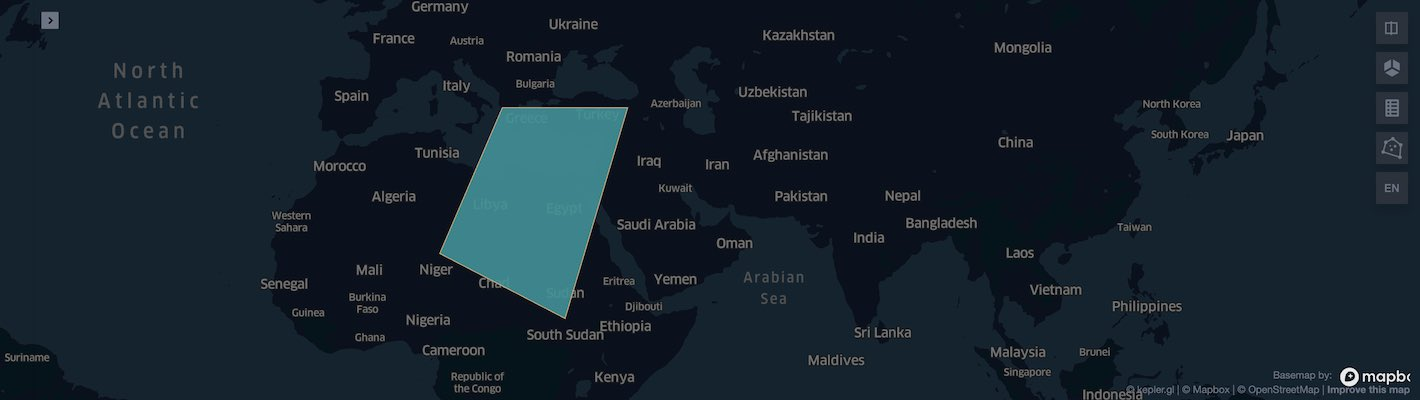

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACxigAwAEAAAAAQAAAyCkBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAZAFjAMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAQEBAQEBAcEBAcJBwcHCQ0JCQkJDRANDQ0NDRATEBAQEBAQExMTExMTExMXFxcXFxcbGxsbGx4eHh4eHh4eHh7/2wBDAQUFBQgHCA0HBw0gFhIWICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICAgICD/3QAEAFn/2gAMAwEAAhEDEQA/APh+p4reWUZHA9TToLdpTuPC/wA61/YV2WOaUuhmm1SEeZM2QOwHWp7eZ5W4ChB2HWqt1KZJPLHRT+Zq/BF5Me3ueTQJ7akopaBzx716JpHgNNU0u21I3Zj+0RiTYEBxu7ZzzTJSued0V6t/wrSP/n+b/v2P8a4PxBpA0PVG04SebiNJN2Nv388Y56YoCxi0UUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKrS2sch3cqe+Ks0UDTK8VtFHzjJ9TViiigLhVd7aAhiRjPJPpVis26mMh2RZIH3iKQIjkgiXLLINuOB1NVatQWplXeTgdqlFic/M/HsKDS6RQp8ZQOC4yAea0BZR4G4nPfFPS0hU5OW+tFhcyLCMroGXoelRTTpEDk/N2FVbyV1cIpIGO1UKLiUeo53aRi7dTXV+HLSyGn6lrN7bpdfY44xFDJnYXkYjLAdQK5KtnR9am0dplEUdxDcp5c0Mv3XUHI6cgg9DUSTa0NY6HU2uhv4ieO8ms47K3Fs8wFiqq0u1gowrHAbPGTxUk3g7S7RJ7y9uLiK3ihim24RphvZlZGAyu7IGCOOeaym8YSeZEsFlbx2scD2xtcs0bxyEMwJODnI4Pas6XXYRb3VpY2MNrFdpGrLGzHHlMWByepOcH2rO0iro6O08L6BdtYwi5u0k1KKSWD5YyqhCfv98kenfv0qmPDul3KWN5prXs9vdvLEUCx+cGi7jom0+p6Vm2via4tZtOmSFCdNieGMEn5g+clvcZ7U/TfFNzplpBZRwxyRwmbIcn51n+8px09iKdpBdHQXHg3TbbNxcS3UUAs5LsqwjMq+UwVl+X5DkHIxVIeF9MuLm2hs7ibGoWbz2glCBvMT/lm+BjB7EVny+KpGszYW9pDBD9lltFRC3ypKwYnJ6kEdT1zzUVtrCT3GmrdyG0TTVwksamRjhg/KjHXGPTFK0g0Kd/psNjpdhcsz/aLxHmKHGFjDYT3y3X04rFrd8Sasut6vLfRLsi4SJDxtReg/Mk/jWFWsb21JfkFFFFMQUUUUAFFFFABRRRQAUUUUCCiiigYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQJBRRRQK3UKKKKCgooqeG3ebkYAHGaBEFFKQVJU8EcGkoGFFFFIhJhU0EXnPszgYyTUNSxSeUWPcrgUymRHg4ooooAmhlER5UN/Op3vXPEYC/rVKigXKhSSTk8k0lFFA9gooopGbl2CiiimVGVwooooLCiiigAooooZMlcKKKKRkFFFFOxoo9wooooLCiiihkyegUUUUjMKKKKBrRhRRRRYpx6hWlZRAJ5pHJ4H0rNrciAESgdMCqQpMzryPZLuHRufxqxZPmMp/dP86hviTIq9gM0li2JSvqP5UuojUoooqiQooooAKKKKACiiigAqtdgmA47EGrJIHJ4qKNjLluNnIHv70DXcp2ttnEsn4D+taNFFAN3CitH7B/t/pR9g/2/wBKVx8rM6itH7B/t/pR9g/2/wBKLhyszqKKKZJ//9D4/pkjiNC57Cn1m3soZvKA+7zmu040rsqxSCOTzGG7GfzrRtZXlDF2HXpWVR71Jo1c6BT82PQ19C+Ef+RY03/r2T+VfLiuxfcSck8nNe26F450zStGtNNnhnZ7eFY2ZQpBK9xlhVJitY6/Qbu8uL2+jVnnsI5SIZ5htffk70X++iHgNx6c4zXmnj//AJGZ/wDr2h/m9dl/wsjR/wDnhc/kv/xVeceJtWg1vV21C2R0QxJGA+M5Xdk8E+tApNGDRRRQQFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACEBhg9DSIqooVeAKdR060AFNd1jXc5wKYZogwQsMmnSKGjZT6UDHKwZQy8g8iqs90Im2KMkdfSs1XkAwrEfQ0jFidzdT60rlqAskjytufrTKKKRQUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigQUUUUDN/w1pUGs6qLG5ZlQxSSZTGcoMjrmrWgaLa6nprX9wWDLeWtvtU4BWdlDe+QDxVLw5q0ei6tHfyoZIwrxuq9SrjBxnjNb8Ws+HtJs4tO0g3MqNeQXM0k6qpCwsCFUDGTx1rOV76FRt1KMnha4mu5FtmSOJ757O3ErHc5ViOODkLjk+tQSeGvs9x9mvNQsYHUfPvl+4c42nA+93I7V0T+L7C9voL7UfNaSyvmlt3VRk27nJRhxgjjH061laPr1jZzak0rzQNduXiuIUV3QeYzFcNwNwIyam8h2QxvC9zBBc29xGnnxXUECyiQ7f32MYXGGByPm4I9KgvfCV/aRPIk1tcNFMsEscEm5o3dtqhhgdTx7GuivvF+mXUk0irKPNurOcbgMhYNu/ODjJxxisoeJLSKTU5owxa6vIbmEEcYil8whvTIoTkFkZWo+HLrTreS4M9tP5DiK4SCTe0TscAMMDqRjPrxXPV3fiLxHa6rayi1u7w+fIHNtKkYjXnONyjLYP3efrXCVpBtrUmVugUUUVQgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiira2N09jJqSp/o8TiN3yMBmGQPXkUXAqUVevdNvdOkSG9jMckiCRUJBba3Q4BJGcdDzVLBpXCwlFLg88dOvt9au3OnXVpDbXEwG27jMsWDklQcZPpz2ougsUaKu3en3NlHBLcBQtzCs8eDn5GOAT6E+lUu2ew4ougsFFWruzubG6azukKSoQGTqQSA2OPY5qtgnAHc4H1ougsJRRRTAKKKKACiiigAooooAKKKKACiiigAooooAKljnkiBCHr61FQODmgQdeTRUkjo+CqhT3x3qOgAooooGFFFFABRRRQAUUUUAFFFFDJlsFFFFKxKj3CiiimWlYKKKKBhRTkXe4TOM9zTpfL3/ALr7o4+vvQIjooooGFFFFIhx1CiiimWFFFFAgooooYpaoKKKKRmlcKKKKZpFWCiiikRJ3CtyEARKB6CsQDJA9Tit/pxTQnsZl8PnU+1VY3Mbhx2NT3jEzY9Bir628XlhCoPHOetA/UnooAwMUVRIUUUUAFFFFABRRRQA1lV12sMj0p3TgUUUAFJ3paaaBnSVtW/h7VrnyykQCygMrMygYPIPXP6Vi9q62HZ/wkWlZxu+zwfX7j1CNTEudI1GzhNxcxbYwQC25TyeB0JrNrXtdn9i6htx/rYOn++1ZFAHOd6WminVZkf/0fjuWRYkLtz7VjSSGRy5wM+lbbKrjawyD2poiiHRR+VdhyRdjDorbMEJOSgqCZbdGB2gvjAUd6LFcxlCte3UJhWJL7cnPYU1IEgjd25JBz/9aqluZTMEyQTjdnrgUA9TXooopmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABVK9j3IHAJI4wPertFA07GAQVOCMGkrdeNJBhxmsu5g8lsj7p6e1KxopXOk8E2drfeIEtryKOaMwytslGVJUAjOfQ1tvpFvqV8LK+isbFY7WW6Mmm4cEJt+/wBfUkDr71xmjatNot99vgRXYRvHhs4w4wTxUelajJpLStCit5tu9sd3ZXABPHfispRbd0aJqx12jeGtI1uTNqmo+Q8gjjmPkBV4HLA8kg5yFHA96kg8K6KstjZXk90Li/aaNDEE8tWhcpk7vmwcDgVhab4lfT7W3tntILg2kxnt3l3ZjZjk4A4OTzz0pX8UXT3tjfGFN1hJLIgycMZX3kN9CeMUrSHdFibQtM06wgk1OS4a5uzKIUgCbAI32AuW5+Y46dBWrq/gu302wupVe482zRXZ5PLEUvTcIwDvBGeN3WsE+JTLZfY76zgudjyPDI5YPF5rbiBjqAeQD04puo+IY9UidrqwtjduoVrtdwkO3AzjpnAwTRaQaHN0UUVqQFFFFAG1pmh3eq2tzdW5UC2XO09XbaW2r/tbQT9KrxaRqUxRYoGcyQ/aFAxkxZxuAz0zxjr7VuaR4oTR7W1toLaOQxTtPM8gyWLfL8mGGCI8rk5/Kpx4k0yOIG3guI5UtjZRlXUBYTJuBHU+YBwD0zzWbcuxVkZy+E9a8meWWIRm3CkqXQk7iV4wxHGOc8+nNRyeGdWghke5iaKRGjVY22ksZG2DkNheemevt1rXuPE2mTrPGbaY+ekW+Y+UsryRSGRWcIAhHYkc4qBPEtp9vv7ue1MyX1xDN5bkYAiYttb1Jzx2454pXkOyOcvtOvtNkWO+iMTOu5clWBHTIKkg8+9Uq6DXtYh1b7KsKygWyOm6XYGbe27OIwFGOnArn60i3bUl+QUUUUxBRRRQIKKKKASCiiigYUUUUAFFFFABRRRQAUVIkMsgyi5HrUhtnRS0hC+me9ArleiiigYUUUUAFFFFABRRRQAUUoBY4UZPtUrQTINzKcfnQIhopSGHUEfWkoGFFFFABRRRQAV6N4YvNPsfDNzc6nD58KalbllyRjCr83HXb129D0rzmnbmC7QTj0zxUyjcadj1dNO1WHxDqd8tzPIzxLcQtaiMyTxyNgbd4KgIAN2OcAVvGHVotdm1CyEn2dLSGWaCMR755ypAViBgHgbiCBxXhYllBBDsCOmCRj6elKJZVGFdgPQEj+VR7Nlcx7b4fj1jzIJ9Sa4Jurmb7TAiwiGI5xiXILfMCMAHpj8a6parbWdvZrt1IadOtkW27Bh8EAH+Pb93tXjPmSc/M3JBPJ5I6H6ijzJMg7myOnJ4+lHsw5z2HTb67W40HR3b/RrjTP30TKpDHY/XIzxj1qhBNqDeE47hDcaelnapIDiMwXG0ghgcbxI3WvLfMkzu3NkdDk0GSQrsLMVHOCTjPrjpR7MOc9rvk1uXxBqN0styI4o42tUthEXlR9u7YXBG1W5PeofEt7Po+nalqOmsIbgvasXAQtuZMMehGTjnFeNiWUYw7DaMDk8D0HoPam7327dxx6Z44o9mHOdX43SNfEcxjAG+OKRtvALMgyfxrkqVmZjliSfekrRKysQwooopgFFFFABRRRQBPHHDIAN5VvccUySJ4m2uPpUdKST1JOPWgQlFFFAwooooAKKKKACiiigAooooAKK7aw8O2t/4PuNXj3fa4JGIGTho0ALjb0yAc5q0/hGM6Bp0sQP9oX1wqbWYhVWRWZQR0B2jJPWo50PlPP6K7SLwd9rkVNNv4rkLc/ZZmEbp5bkHBwx+ZSRjIqJvCTyCE6deQ3YkuhZuVVkEcuM4O7qOOop86DlZyFFd3/wg8kuw2l7HKHmeElonjCmMFnY7jyqgdupqbRfC9jNeW1z56X9jcCZNyq8REkaFgCrHPbIPel7RD5WefUV1Z0e3ls9JaV47Y3dvJI0io8jMVYDlF5Lc8Baztb0WTRZoUMomjuIhLG4VkypOOVblSD1BpqaegnGxi0UUVQgooooAKKKKACiiigAooooEwooooBBRRRQMKKKKGTJaBRRRSJirhRRRTNAoooouRKVgooqSKJpn2r+J9qRBatbcsRK/AHIHrWlSAAAAdBS1QFKZFa6jz3HP4VdrMuWMdyHXqAK0Ubeocdxmgb2Q6iiimSFFFFABRRRQAUUUUAFFFFABTTTqaaBnSVuW3iHU7YxbTGwiAVQyKTgDAGcZ/WuP/tLH8H6//Wo/tL/pn+tQaXR09zrF/dwNbTMnlsQxCoq5KnI5AFZlZf8AaX/TP9aP7Sz/AAfr/wDWoC6M8U6minVZmf/S+PVZXUMvINOpFUKAqjAFLXacQUUUUAIKaI0VzIB8x6mnCloAKKKKACiiigAooooAKKKKACipPJl8rz9jeXnbuxxn0zR5UvledtOzO3djjPpmgZHRRRQIKKKKACinmORUWRlIVshTjg464qSC2nuWZYF3FVLH6DqaQyCij3opiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqGeETLjOCOhqaigZhOjRuUbqKZVi6x57Y9qr1JqgooooGFFFFABRRRQAUUUUAFFSRRmVwgIGfWrb2iRws7ZZgO1AmyhRS4O3d2PGaSgYUUUUAFdbpmi6PNop1jVJ7mMfafsyrbor8ldwOCM/lXJV2mkeKG0XREtbKRluRerOy7QVeIKAVJII5I7c96id7aDj5kV54Qu7e/vLaOeBYLNkDXFw4iT94AygnBw3PSol8G6yXlWY28IhlWFmmlCLucBl2nByGBGCO9a15qnh7UIdR017meKG8uUu45mjaRlbbtdGXOSB/Cen5U/XPE+m6lYy2lvvGLq3aLevWOFApJ9CTnj0qOaRVkYV74T1awgknuPI/cuqSokgZ4y5wpdQOAfXNKPCWpyeUbWW1uFlmEG6CYOFkIyA5AG3OPetifxDpMuo61csGeK/ktmjQqRuWJgXVs9MgEDNbqeL9Fhk/4+JZY/tkc6KLcRiOJc/IMcsRnr37d6OaQWRxbeF721kt3uTDNDLcrbP9nlDlXJxsY4+VvzpR4YuLu/mtbOW2iZZ3hjhnnAlYocYUbfm+vGas2OtWFvaSwSFtz6vHfDCnHlIwJ/4F7VvWHijRbec3Ilkgb7fLcSbYA7TxM2UUseU2j8fTmhykOyPMpI3ikaKQEMjFSPQg4I/OtCOzj2jzMlu/NTsYbq9ubtASHnkdSfRmLDj1wamrZbGE3rZGTLbuJCI0O3t3quyshw4IPvW45cLlBuPpWNM8rtmXqO2MUwi7j4bZ5efur6/4VoLawKPu5+tVbW42/u5DhccE1bW4id9inPGc444oFK5KwO3CYBxx6Viys7SEuQSOMjpV25uUMeyM8nr2wKzqGOKCiiikWFFFFABRRRQAU5EaRtqDJq1FaGRFdjgHt7VfihSFdq/nTsS5DbeERJyPmPWp6KhkniiOHPPpTM9xZwrQsH6YzWJWyXhnjI3cd+1VxaRNF+7O5uzdqRUXbczqKOhwaKRoFFKAWIUdTxSEYOPSgCwotmUAlkbHXqM1AcZOOR60lFAgooooGFFFFABRRRQAUUUUAKAWO1RknoK0RFFbReZINx9DVS3dY5Qz9On0pLh98zH04/KmS9XYVZlUEeWpye9RqU3ZZSV9Af60yikOxbV7RW3bWPseRVUnJJxj2FJRQFhyLvcJ0ycU+aIwvsJzxkGoqczu5y5yRxzQA2iiigYUUUUAFFFFABRRRQAUUUUAFFFFAHXaP4nTSrO1thEzmG7eeTkbXjeMxsn1wc88VdbxmTP9qELb11BbyMEjaI1j8oR9c529xxXCUVHIh8zPQLPxXpGlSZ0y2udk12LqcTMhOFyQke3jGT1aqmia9YwOtpdqVjk1Rb1pGAKqoGMEdSc4Oe3WuKoo5EPmZ65f+JdLtpk1RnjubgO0XlW9zJMpgkBDk7wAjdMY69DxWDYeKtK0lLWz063uDbW7SyN5zIZGeRCg+78oCg/U1wRJPWkpKmuoc521h4ptrWCyt5IpgLayms3kiZVceaynfGT0Ix3rL8Q61DrBsxCswFrAYS07B3fnIYsO/r71ztFUoJO4nJhRRRVCCiiigAooooAKKKKACiiigAooooAKKKKACiiigTCiiigEFFSRxSS52DOOtMIIJB6igBKKKKRk9wrVs49se89W/lVW2tjJ87/d/nWrTSDYKKKKoRS8gSXLtJyMDH41Yjj8olVJ24GMnPNEc0cpIQ9KloG29gooooEFFIzBQWY4ApquGI28gjOe1ADiQOpxnilpmwb955Pb2+lPoAKKKKACiiigApDS0negDQ/s7/b/AEpP7N/2/wBP/r1qdq6W28L38llLf3X7iNI2kVT95sDI47D6/lU6mtkcN/Zv+3+n/wBel/s7/b/Su4ufC99HZRX9r+/jeNZGUfeXIyeO4+n5VzXajULI5wUtJ3paoyP/0/j+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooA7PTGtm0SO1u+EuJnjB9GzkH8xVC5t5bTQ5LeYYZLrB9+Ov41Qe6hbRorQH94szORz0Oec1dvNWjvdHS3lP79XG7jqB3zWdnf5mt1b5FXSbW3m8+5uwWjt495UHG49h+lTzQ2V5pkl9bQ+Q8LhWVSSCDj/Gq+k3dvAZ7e7JWK4j2FgM4PY/rVieaxs9MksLSbz3mcMzBSAAMev0pu9xK1iLRbS1u2uBdg7Y4t2R1HPJFUb2a0mkDWcPkoFxgnJJ9TVrS7qC2S6ExwZYSi8Zyayaa3ZL2R1OoT239jWmLdf3its+Y/Ie5Hrn3qv4c2i5nLjK+Q2QPTIqKaezudIhhaXZNbBgEIJ3Z9DUWkXUFpLM05wHhZBxnk9Km3utFX95Msyx6feaTJeWsH2d4GVSAc5Bx1/OufrVtbmGLSLm1c4kkZCox1xjPP4VlVS6kvoFFFFUSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRUUsyQrubn2FQLexH7wI/WgdmXKKq/bIM4yfripfPhxneMfWgLMloqITRNyHHHvTmkRV3sRj1oCxk3JzO2PpUFKx3MW9TmkqTVBRRRQMKKnNtOBnaahIIOCMH3oFcSlALEKoyTUsMDzHjgDqa04bdIckck9zTE5WMl43j++pFMrfIDDDDIPrWLOgjmKDj0HtQEZXHWwUzru/D61sEAgg9DWAD3B/EVp290XwknU9DQhSXUmkgVofLQDIHy5rGroKz57Qk74ucnkUMUX3M+ilIIODSUjQKKKKACinKjv9xWbH90E/yptABRT2jkQgOrKSMjII4PQ89j603BoASrFrGJZcMMgDJqLy5QgkKNsJ2hsHGeuM9M47VeskZdzMCM4AzQiZaItxxrEuxOnWpKKKoyCqN1DJK6lBwBjNXqKBp2K0VrHGQ3JYetWcDrRRQDZUntRKd6nDY/A1mvG8Zw4IrdprosilHGQaVhqRg0VNNC0LYPIPQ1DSLTCiiigoKkiVGkCyHC1HRQI3wABgdKWqtm7ND838JwKtVRkyKWXygCVJB9O1ZU7rJKXTocVtViTR+VIU7dR9DSZUCNQpYbuBnmpGmkJ4YgdgOMCoqKRYUUUUDJoHWOVXfoKiJySfU5pKKBBRRRQMKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigl36BRRRRcXMWLecQFiRnIqBiWYsepOaSihhJ2CpoYWmbH8I6mo0RpG2oMmtmGIRRhO/c+9CRBIAAMDoKWiiqEFFFMkYpGzgZwM0AZBYwzkp2Y1rRypKu5D9R6ViEkkk9+aVWZDlCQfalc0aub1N3KG2dzzWbDcyNIqyNkZrTAx+PWmQ1YY0Ydvn5UdB7+pqSiigQUUUUAFFFFABRRRQAU006mmgaOjPQ/SvW7jVG1K3bTdHiNwXj8uSY/LEmRg/N/ER6CvJa6bR/FF7parbyATQDoh4K/wC6f6GpTNWdpFqculWy2GsQmEJH5aTpl4mwMDJ6qfqK8kHTHtXUav4pvtTVoIv3EDcFByzD/aP9BXMUNgjmxTqaKdVGTP/U+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACirNpay3twttDjc2eT0GOcmlvLSWxuGtpsblAOR0INK/QdupVoq1aWc17I0cOMqhck9MCqhOBn2zTELRV/ULFrCZYWYPuQPkDHXtVEKzfdBP0GaSd9RtW0EoopQpPABPemISiirUtnNDbRXT42zZ2+vHrSGVaKsW0UU0hWaURAKSGIJyR249ar0xBRS4ON2OD0NJQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUHkYoooAwXRkcq3UU2p7nPnvn/PFPsoEuryG2kcRrLIiM56KGYAn8Klmy1KtFehan4ZsV1KLQ7G1vLa4lm8uO4uWDQyKATuG3pnHGPxrEuvDJtrdLtL62mgM/wBnmlQnbC+M4ckcj3H5VCmiuVnMUV3Nn4SAvbMmWG+t7p5IgVMkQ3ohfB43DgZBHWqtl4RmvoLWVLy2jkvojJbwOWDvjORxwMY60e0QcrOQopSCpKsMEHBHuKSrEFXbEKXYnqBxVKtG0gdG8x+MjAHemTLYv0x40k++oOPWn0UzIRVVBtUYA7ClJAGTRSEZBB70AQxzpK5VOgGc11+kw2j6FdyXUQkAv7ROuGwzAEBsEgc8+tcPZRsrMzAjHFbcd9cw2clhEwEUsiTNx82+MgqQc8Yx6VE02rI0i1GR0eoafpV1r+pMbE+TauFkdrkQRhieu7HGRwFHcc9afqGnabomm6haSBntYtUti3zfOI2iVj8w5yAfxrGuPEWpSGeV4rST7QFMsbwgo7J0cru++PX9Kx7zxHqGpJLBfbClxNHNLsXB3RqEGOcD5R09ay5JGymnsdJqGiw6bDqEsxZhHPHDZnOA+8eYWP8AeAjI/EGubqzrPiFb23srCyEot7KPYvnlS7k8ZbbxwBge1ZcN0Zn2bccZzmtYXtqZTXYllhWVNh47g+lZcsEkXLDj1HStqkIBGDyDVEKVjAoqxcQiFwAcg8j2qvSNEdx4MaVYtUFv5nmtBEEEMiRyH94c7Wf5RgdfaumudO03UdWN0wt5RHfBrssVG2H7OvDHOGAfOSON2a8gKq33gD9RmjavGQOOnHT6Vm4Xdy1I9hs7TSrtYrq8igmAtrKJPOCnJKvmMbyArHjnOR6U6z0bSfJiXUba1D+ZESVVF5ZyJIyQxZtg4bIAzyK8otNQvrDd9hnkg3/e8tiufrj+fWqbAMxdgCzcknknPqe9L2b7j5z0vT47PU7WM+TaxbbybbbhAVdUh+VQjMFLMe5IBPPtWbr0Frb6kY7NFjjMUbbExtVivzAAEgc9gcVwxAPUA/Xmt2JlaMFcdOQPWrjCzuZ1JXViSiiitDEKKqSXkaHC/Mf0qv8Abn/uilcrlZp0Vnpe5bEgAHqOauRypKCUOcUxNNElFFFAhrKrjawBHvWbc24jHmJ0zjHpWpVe6K+Qwbv0+tIqLMeiiikahRRRQBo2Ug2mI9RyKv1gqxRg69RWxDMsy5HBHUU0ZyXUmqGaBJhzwexqaimSYs8PkuFznIzUNapt1knZ5ORgYFVLqFYnBQYUj9aRopdCrRRT4yokUv8AdB5pDJPs1wbf7WI28kNs34+XdjOM+uO1JPbz2uw3KGPzFDpu43KehHqDXbpDLfeDZ0sUaZo9RVnWNSxAMQGcAE4zXSGC8XVrO3MUZS20uBr3zYfOaNV3Haq/326AAfyrNzsy1G6PJvstx9k+37D5G/yvM4xvxnb1znHPSq54616q2o3x0a4v7PTUDvqny20luX8tTCAPkwME9C3ucVqTadpWmPf3FlCm5L5YnX7Mbny0MSuYwoI2gsT834Uvadx8h4+9ndR2sd68ZEMrMiOcYZl+8B3470PZ3MdrHeuhEMrMqPkYJX7w6549xXskFlod1b2SRRsqreXb2drMhUPJjIR88qAc4BHPArnrAWUWn6Xf6nZec73V55yxxbmBBIUlB1VD/D2/Cj2gch5xHDLMjyxKWWJdzsOQozjJPYZqLIzjv6V7GWv7G11V1S2nZ7GC4i8u22FgzsPniOTnjofrVV9P8vQ7qzvUhdo9Na6Qx2xUI2AVPn5+ZvXjn8DR7QOQ8m9qK9Z1cWss2u6SLS2jisrT7RC0cYVxIFU5Ld85/KvJzwSKuMrktWEoooqhBRRRQAewq0tpMwyQF+tValE8wGA5xQJ36DZEMblCQSPSmUUUAFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiikZt3egVLFC8xITt1zRDH5sgTOM1tKqooVRgCmgbIGt4zH5Y4wMA96rCxbPzMMewrRop2JuRxxJEu1B9fepKKKYgooooAillEKbyM9hWYyXDPt2sN3OO1aNyoaFsjOBkfWiAShP3pyTyPWkUnZXMl43jOHGKlt4DMcnhR1NazKrjawBHvSJGka7UGBnNFh8xEtpApzjP1NWKKKZNwooooEFFFFABRRRQAUUUUAFNNOpDQBf/ALSx/B+v/wBaj+0v+mf60v8AZ3+3+lJ/Zv8At/p/9ep0NNQ/tL/pn+tH9pZ/g/X/AOtR/Zv+3+n/ANel/s7/AG/0o0DUzhTqQUtUZn//1fj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigDpNCt5vIu7yBC8ixmOMDrubr/AEp2t20/2O0u51KybPKkB65HQn9azRqckenLY24MZDl2dWwTntxS/wBqSPp0lhcBpCzBldmyVx9etZ2d7ml1axoeHJ5Y3uEQ4Hkl8f7Q6GudnnluWaedtzsMk9O3tV3Tb86fOZSm9WUoy5xkGqc5heRjAhjjP3VJzgY9apLW5Ld1Y2/Ef/H7F/1wT+tWNOe/trOOT7TFbQu52CQZL889ulZGo339oTLNs2bY1TGc9O9WYdUgFpHbXVuJjCSY23EYzzg46ips7JFXV2xfEEaR6rIIwACFYgepHNak+o3Nha6ctsVXfEC2VBJwQMZ9Oa5/Ub06hdG6K7MqBjOelOur77TFbR7Nv2dNmc9eQfw6U+XRJi5tW0WdeiSLVZVQAA7WwPUjmtDUr67Oj2gL/wCvRhJwOQP89qxNRvPt9211t2bgBjOegxU7ahFLpyWM8W54gRFIGxjPqO9FtFcL6steHADfSZ/54v8A0rO0mFLi/t4ZOVZhkeuBn+lO02+/s+dptm/cjJjOOveqcEr20qTR/ejII/CnbcV9jY1XVLueSazO1YVcqECgY2njmsOti+1CyvFaQWvlzuQWcMcZ78e9Y9EVoEnruFFFFUSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZN5jz+PQVHbtAs6NcqzxBhvVThivcAnvikmfzJWYdM8VFUs2R6loniXRbS4s9NtnujB9qEzy3zpiFQjDam08DOM9qzYvEmi6UyQafBPNGb77XP5+w52gqFTbxx94E+34ef0Vn7NF8zPSx40sElsyftlwLW5knaS4MZdg8TJgbTgYLfl+VYlp4itba60Kdo5CNKjZJAMfOWz93n374rj6Kfs0HMySVg8zyDozsw/Ek06CIyyBecdyKhAJOB1NbUEQhjC9+p+tWkZydgSCGPlVGfU81NRUAuEMvlDOfWqM9yeik570tAgqKaUQruIJHTipar3X/AB7t+H86Borw3TyTbW6HgCtCsmz/ANePoa1qSHLcKjaKJ+WUGpKKZJkS2skeSOVHOargkHI4NbxAYFT0PFZVxbiEBlJIPHNI0jK+4sV5InEnzD171pI6yLvQ5BqOBI/IVRhh3+tEcPlSMyn5W6D0oJdilenMwHotU69H8J+FLXxPqE3255Y7a0h8yVocByznbGgLAgbjk5x0U13n/CsPCH/PXUv+/sP/AMapat6K5M8RSp2VSVn8/wDI+fKcql2CDqeOa+hE+GXhBHD+ZqRwc4MsP/xqrH/CuPB+7fm/z1z5kX/xujln/K/w/wAzN46h/P8An/keALYn+NscdqiktJE+58w9q+if+FfeE/72of8AfyL/AON1FL8OvCcqbC+ojPpJF/8AG6fLL+V/h/mSsdR/nX3P/I+e4LYynL5C+vrVr7KkQLq7JjvXuI+GXhJcgTamM9f3sP8A8ao/4Vl4SxjztT/7+xf/ABqi0v5fy/zG8bQ/5+L7n/keBfapxxvz74pHuZpF2MRg9cV75/wrDwh/z11L/v7D/wDGqX/hV/hD/nrqX/f2H/41StP+V/h/mP67h/519z/yPnuivog/CvwgBnztR/7+w/8Axqo/+FXeEf8Anpqf/f2H/wCNUWl/K/w/zH9ew/8Az8X4/wCR890oZl+6SM9cV9Cj4WeET1l1Mf8AbSH/AONU3/hV3hE9JNT5/wCmkP8A8aotL+V/h/mH13D/AM6/H/I8GS8lXhsN9etPa+f+FQPrzXux+F3hEdZNT4/6aQ//ABqj/hV/hAf8tdT/AO/sP/xqnaf8r/AX1zD/AM6/H/I8IF9JjBUE+tVXkeQ5c5r0Lx74X0LwytimlSXLy3KySOtwyNtRGCqRsVfvHPXsK86qVK50xs0pR2YV0fh7RIdYkl+0zGCNNiKwA5llbai8+p6965yt2w8RalpVkbPTm8jdL5zyKAWYgbQDuBGAB2FKV7aFq3UksvDk99bSTJPCssTCN4G3Bw5fYq5xtyzcDmtB/Bd/EHkkngSKNWLyvvVV2MFcfMoJxkYIGGHSop/Fks6n/QrdHM5ug67gRMf48ZwSMcZqG88T3F3FcRmCOM3UZjlKs5zuYMSAxIXkdBxU++P3S1f+FliiWayuI3CwQzSoSd6iU4L9MbAT9cVPH4YnslkmlcSIYTIjLuTlZFRgVdc8buPXrmqK+LLyJUMEEKSqkMRl+YsUgIZVIJxyRyRyelWl8WT3Mgt5oFSF96sIyzOBI6yNguTk7l4zwBxStMful2XQJzJdi3df9FZwUbcTiPr84UJnHIHBPpVXUdHn05C8ksMuyYwSCIklH27gDkDqOcj6Vfn8TXMjzGOJAsjTbNxbKpOcsCAdpPvjjoOKy7vU7i8E4lCj7Rci6bGeGCbMD2xVR5+plLk6GTLPHCQHzz6VDJcW7RkE7sjp3/8ArU+eBJsFjt296yCMEj0NaExSYlFFFI0LdnqF9p7mWxnkgYjBMbFcj3x1/GpYtW1SCV5obqZJJeXcOwZsepzk1n0UrILmomuaykhlS8uFcnJYSNknGOeeeBjmobbU9Rs5WntbmaJ3+8yOwLZ9eefxqjRRyoLlxtQv3Kl55GKOZFJYkhz1YHPU+vWpF1XU0dZEuZVZGZ1Icghm+8Rz1Pf171n0UcqC5ojV9UFy16Lqbz2G1pN7biPQnPT26U3+1NSNuLQ3MxhVSgj3ts2nqNucY9qoAEnArbPhvxAql2sLgADJOw9PWk7dR6me1/eu8kjzOWmXZISxyy+jeo9jVShPnYKmCTjAHv0rUfRdVjaRHgYGGRIZBlTh5MbF4PJOR0yPXFO6QWbMuirMlndRXh0+SMrOH8oxnGd+cbeuM598VHcQS2s7W1wuyRGKspI4I6jjI/KncViKipZYJYVR5lKiRd6E8bl9R7e9RAgjI5FFwCigEEZHNFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAU+ONpXCL/8Aqp0MLTNtU4x1JrWihSEYXqepNMlysVYtOeSaKLcP3kiR5x03sFz+Ga3rvwffW09zbI3mvFJCkO0cSiZioYHPGCDkHpj8axGvvIuonjG7yZEkI9SjBsfpXR2XivVIkkWOJGRrv7Wm8n5MuXZAccq2T9Dz7VnK9/dKi1b3jOHhPViC6tbNEFLmYTDywFO1stjjaevH51e/4RAiB5GvIMi1juQd4CDzGx8zHouOQ3f0pbnWm/suTS7S0WKB1ZQokZ2Bdw7NkgZ5AAHpzWdPr5k059Pa3Cu9pHZvJvPKxHKttxwfXn3qXzle6yG28P3cupXWlTArPawySlUG8sYwCFXHXcGGCPyqebw1Olw9qk0Ie3jR7tpWEccLycCMuc5b6DrSHxFMdXu9WWLa93C8O1XI2b0VNwYDORtyOlar6wt0sq6japN9piiS5IcxmR4TlZMgcMejDv7Ue8L3UUofCuswyoZEjVndokRpAHZlOG2g9QMZJ/u81aj0S+knS3R7YtKoeI+cNsoJIHlnHzcjHbBq1N4jvJ9QtdTaNBJatKygE7WEpGVPcYUYz+PtU9v4nltn3RwMQGR133MjMCmeCxGSpzyvTPPOafvkvkZzJBBKkYIJBHoRwRSU523yPIeN7M2P94k/1ptamIUUUUwCiiigBkkixIXboKz0uQzJ5gGQfvVbugTA2Pqax6TZSOgoqC2bdAp9Bj8qnpiCiiigQUUUUAFFFFABRRRQAUUUUAFJ3paaaBnSCuzsPDlhc2tvLNLch54DP+7QFAF7Zx970HU1xgr1fR8/2dZY+0/8eLf6v/V//t/3alGrOVOh6bJbTy2z3ivDE0o86LYpx2yQOa5KvTfn+w3u7+0f+PV/+PvGzp2/2q8yoYI5zvS00U6qMj//1vj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKK6L+ztMsoIn1SWQSTLuCRjOB78GqGqaethKnlP5kUq70Y9ce9SpJlOLRmUVctLC7vmItYy+3qegH4mobi3mtZmgnXa69RTv0FbqQ0VpR6PqUsH2iOFihGR0yR6gdazsHOO/Si4WEorUl0XU4YTPJCQqjJwQSB7gGs+GGSeVYYhudzhR6mi6BpkdFacuj6lDCbiSEhV68jIHrj0rMoTvsDVtwooopiCiikH0xQAtFFFABRRRQAUUUUAFFFFABRRRQAVFOGMLBOSRUtFAHP0VYuv9e34fyqvUmyCiiigYUUUUAKCQQw7HNbqMXUMQRnsazrSFvM3upAA4z61p00ZyYc0mBndjn1paKZAUUUUAFRyx+bGUzjNSUUAQQ26RYPVsYJqeiigYUUhyASOazjeTK3zoB7HNAJXNKqt5t8khvw+tVmvpD91QP1qy1u0u0ytnHVQOKQ7W3G2kJjG8n7wHFXMgDJOAOpNFdF4U0dNd163sJxm3GZ7k+kEXzP/AN9cJ/wKhuyuG71PYfCelnR/DdvBIpWe7P22dWGCpddsakdiseMj1NdHwiBgAST3omlaeV5n4Zzkj09B+A4pA5AxgEe9dNOHLFJ7ny+Jre1qSqf1boKVUAs/XOMCnGNQMd8VEzls57nNLvJGCBnpnvWhgSmMZwOucU0KhJxnj9aaXJ5wM+tHmHOcD396AGuoUjHemU5jk9APpTaACiiimBISPLUe5qU4yz5GCOKrUUrAWd+ZWycjBxQGXOfVcD29qrUUWAsZJbYe4xxzUb7nfZGMnhVHqeg/M0wEjocU2S9j0y3n1aUZSxgkuiPXy1yo+pbFROXJFy7GlKm6k4011dj57+I+pJqHi26SFt0NmEsoz7QDDf8AkQvXCVJLJLLI0s7FpHJZ2PdicsfxJJqOuKCskmfYO2y2J4reSYZXGM4JNQkAEgc4oBK8qSPpSVQgoqeKLzVYL94YI/rUFABWhYop3ORyDgVn1oWLAbkPXOaYpbGhRRRTMgIB4NY90iRy4TuM4rYrJvP9efoKTLhuVaKKKRoFFFFABRRRQAUUUUAA4ORXdXOo6gPAtvMbifcdQlRm8x9xURk7c5zjjp0rhalM85gFsXYxBtwTJ2hjxnHTPvUyjcadj1u701U0e9sb1IpHs7eKRGjtvKVWJB+WXPz5Bwfx+lJeWNnFeamYoY1MOq2Cx7VA2AmMkL6AnrivNYNa1CJ4/Ole4ij48iV2aMr/AHSuentSXus6hf3c15LIVa4kErqhKruXAU4z/DgY9Kz9my+ZHpOuWtolyZLBBOLjWVjvZHX5ozvXbGB2RhyT36d6kgt4Zbq+0rT7dILhrufEstsZYZEGcIHHEe3H+c15SL+9BdhNJmRg7ncfmYHIJ9SDyD1BqVdW1RI5IkupwkpJdRIwDE9SRnknv696fs2LmPTX/tDU5NFSNIFT+zhcF2txIu5VbKqBjccdEB681ZuY7NIBq/2aKSX+y7mc+bbiMM8MibGaLsRn8a8mj1LUYo44o7iVVhbdGodgEPTK88fhSyanqM2fOuZn3BlO52OQ3LDk9DgZHSl7NhzHQ+KfLntdK1MRRxS3ds7zeUoRWZHCg7R0OK5CpZJ5pURJXZljG1ATkKD1A9B9KirWKsrEt3CiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAq/BapJCGbqT1HpVCp4riSIbVPHoaBO/Q1Y4o4hhBjNSVBbytLHuYY5/Ole4ijbYx57+1UZWY0QB5PNlA9gP5mrFICDggjnpS0AFYtw/mTMw6dB+FbJGQR61m/YZOcEcdPekyo2KYOCCO3Natvc+d8rcN/OsogqSDwRSoxRg69RSuORvUU1GDqHXoeadVGYUUUUAFFFFABRRTJHEal26CgCteyBY/LHVv5VlgZIHqcVLNKZn3njtirNiFLMSORjFI02ReijEUYQdqkoopmYUUUUAFFFFABRRRQAUUUUAFFFFABTTTqaaBnSCuysPEdhbWtvFNFcl4YDAfLcBCD3xkc+h6ivOf7Sx/B+v8A9aj+0v8Apn+tSaXR6Edc0yO2nit0vGeaFoh50u9Rnvgk1yNZf9pf9M/1o/tLP8H6/wD1qAujPFOpop1UZn//1/j+iiiu04gooooAQUtIKWgAooooAKKKKACiiigApD90/SlooA6XxErSSW06AsjwjBAzTdbBis7CCTh1h5Hp0qha6zqNnEIIZBsHQMM4+lUrm5nu5TPcMXc9z/KoUXoW5LU20Lr4bJgJB8/95t647Zx26VzxOTmQk+ufSrlnqN3YFvsz4DdVIyD+FQ3NzLdzGecgs3XAwOPamlYTd0dfqV1Z2epRXEi3BZUUpsICEemD+tcq+Ly/PlDYJpeAe241ag1vUreIQpICq8LuUMR9CazC7mQyk/MTuz75zn86UY2HKVztLCOzttRns4fPaRI2Du5BU8Dt/KuY0X/kJ2v++P5GrDa9qjYzKOmDhRzxjn1rMgmktpUmhOGQ5U+9Ci9bg5LSx1GnyO2s3qsxIKS5BORweK5Ffuj6CrkV9cwzvcxth5AwY4HO7rVTpxTSsJu4UUUVRIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVZLRJGLkkE0fY4NuMHPrVqigd2YLqUcoexxT0hlk+4vHr2q9dCBWVpASfb0HrVwEEAjoelKxbloZH2W4/u/qKswWjI4eTHHIHvV+iixLkwoqvLcxxHack+grPmuHlYgEhew/xoBRbNUyxDqw/OoWu4FOM5+lZFFFyuQ0vtyf3TUhvIAuQST6YrJoouPlRfF8ccpz9ad9uXH3Tms6ii4cqLD3UzHO7b7CrsNz5hVAMnHzH0rKq/ZSqP3R6k5FApLQ0aY6JIu1xkU+imZmbLZsDmHkeh7VpDpzRRQNu4V7X8PdM+w6HLqsq4l1F9kZ7iCE4P/fcmfqqivIdN0651fULfS7M4lupViQ/3d3Vvooyx9hX0uUt4VS2swFgt0WCED/nnGNq/n1/GnCPNJLtr/l/XkcePq+zotLeWn+f+XzG0UUV2HzomKWiigAooooAKTFLRQA2lxS0UANop1FACYpKdSGgBK4j4j6h9h8Jm1BG/UblIsE/8s4R5rkeuW2qa7YkAZPQc14h8VtQM2vQ6Sp+XT7ZY2HbzZv3sn80H4Vy4l6KHf8AT+keplNPmrOb6L89P8zy+iiisj6AKKKKAHxyPE25Dg4xTOvJoooEFFFFAyxBcNCcHlT/AJ4rRW5gbowH14rGop3JcUzXa7gXoS30qhcSpM4ZQRgYOar0UXBRsFFFFIoKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACraJbmD5jtf1Oat6DYR6nrVnp8xISeYI2OuOSfzAxXZaffadd+KbfSotLs4IVvGjDKnzlU3jDE/ezjJ4qZTsNRueb5x1or0KHRtKmubfUdKlmwNTW0mWdUwGJ3BkAyCO2GpH0DRSVutSnuVa71Ga0QQLHgESFQx3DgeoH4cVPtEPlPPqK9B0zwfb3V3NY3K3hMdy1v58IiEQwcAnf8xPchc4rhbqA2t1NbE5MUjxk+uxiufxxVKSegmrEFFFFUIKKKKACiiigAooooAKKKKAJ47iWJdqnj37VEAztgckmkVWdgqjJPata3txENx+8RzTJbsVUspCMuQp7d601CjAY4HAJ64Hc/gKKUEggjgggj6jmgi99zqbrR7Bw13ZfJYRRyStdxym48xUwNuz5dkmT06VFJ4cZJ7SNbgMl5OI4324+UxCQMRnr2Iqk2vam5wWjCYZWjESCNw+A29AMNnAzmlXxBqyO7iYEu28Eop2MF2ZjyPk+XjjtWXLPuac0OxZfRNCFvLcTyygDToLpn2ZKs7YLBd3ORxtPA681l23h6BdevdHuXVxbW0siSFvLXcqK6FjzgYbnNZt1rN79nOmhkMIgW2PyjcY1OQpbqQp6elVzrOoNez6gXBmuI2ikbA5VlCkY6DhQKXLIu8TqJ9IsLCa6t5pZIYdNjhFxLtLmWSboY0yAE9OavyeFzDcwWMt2onuZJEiURkqVj5Zic8fLyB68Z71zlhruqbdrMjokSQYkRXDIhyobP3tp+6TyKsSarqMtxDdSTMZYHd43wMqZDlu2OfTpjjpTUZdyG49jci8L+dcLEs7bJFXa2xSVZiRiQb8Dpn5SSQenFcq6lHaNuqMyHHqpIP8q1E1u/ictD5KZKsFSJAoZc4YDGA3J5rIaVWdnZhuZix+pOT+tXFS6kSafwi1p6JaQahrVnY3IJinl2OFJU42seCORyKxnuIU6sPoOa29K1zSdHZL57aS4vImZoWEgEYJBALL14yacnpoEFrqS6ToCapPLHBclZjNJGiGCRkGxiAGlHyDIFLH4VN6LOKW/jiub6HzoLYxOcnBJUuDgHggHv6VJpPjOCxhtPtEEzS2ryMPKk2RP5rFiXTuwzx2q2/iXRbRNLvkhe4vbO0CrtkwkchyMOMZJGe1Y3lsbWjuYOm+F/7Us2lt7ki4VHYxNBJsymcr533N3FaMXhRIN0Ud9G90bQXiweU4zHjd9/O3d7U+w8ZQ29vbmWC4eW3tmt22y7YWDZG8x93yef8A9VJF4gB1BNS8hgBYCy2EjP3du/6d8U1zA+Wxz4IIBHQ80tIo2qF9ABS1ucwUUUUAFFFFABRRRQAUUUUAFFFFABSGlpO9AGh/Z3+3+lJ/Zv8At/p/9etPtXTXGkWmjSRSapN5xZRIsMI+9/vMeAv6ntU6mtkcN/Zv+3+n/wBel/s7/b/Su2vYrPWZGutHjEUgX57XABIH8SY4PuOtc/JHJExjlVkYdQwIP5Gi4WRzIpaTvS1Rkf/Q+P6KKK7TiCiiigBBS0gpaACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKazKoyxAAqhNebgUiHB4yf6UDSuVriTzZS3YcCmpNLGNqMQKjoqTWxL583989c1IbucjGQPoKrUUBZByeTRRRQMKKKKACprZYHnRLlzHEWAd1G4gdyB3PtUNFAHc3/AIZ0S3tLaa11CaWW/GbRGh2hzuCYY/w8kdawU8PanJLcQoq7raZLeT5ujyNsUD1y3Ga0brV7M22giIl305f3y4I5EqPgE8HIU8iuibWvD1vPc3NrdPMb6+t7plMTJ5SRSiRsk/ePUACsbyRdkcrdeFdX09Y5ryNfLMyQv5bqzKzEDawH3Se2ePWrv/CKXwv7j7OoSC2mMQNxIiMWC52g9GbByccVNFrOnJDqaFzm61KK5jwp5jSXeSfQ47HmtyPX9FudSvXvLlZbG4uTL9kltmkLgqAGRv4GyO/1o5pBZWMEaVLKtmLf5Wubb7QWndETAOMg9hz0PNVb2xutOuPs12oV9ocbSGUq3RgRwQa6SDU9EdbNJhsa3sDBG8sRlWGXdkEr/FxxuFZuv39tqE9u9q+8RWqQs3l+UCyls4TsOeBVwlK9mZzjG10YVFFOVXdgkal2YhVUdWYnAA9yeBWpieqfDTSypu/EMgx5a/Y7f3eQZlb/AICmAD6sRXplVrDTV0TTbXREOfske2Vh0adzumb8XOB6AVZrahH3ebv/AEjwMwre0qtLZaf5/j+Fgooorc4QooooAKKKKACiiigAooooAKTFLRQAUhpabQBNbrG06ecQsanfIT0CINzZ/wCAg18lavqUmsapdatLnddzPPyckB2JUfguB+FfRnjLUP7M8I6hOpAe5VbGPP8A03P7zA9RGrGvmMnJzXDUfNUfl/X+R9HldPlo8z+0/wAFp+dxKKK2vD2krreqJpzyGIOjtuAz9xSenvSbtqeijForoU8L6w9lFqOyNYZlR42eRRu8w4AAPcd/QU6XwprUclvEiRzfaZDFG0Miuu9RuIJHAIAJPsKnnXcfKznKK29T8P6lpECXN4I/Lkcxo8bhwzAZOCPQDvWJTTvsJoKKKKYBRRRQAUVI0MyosrIwRs7WIIBx1wehx3x0pmD6UAJRS4NJQAUUUUAaumaLqOrrM1hHvFuod8nHBz0z1PB4qTTdDvdUtpryExxwQAFpJWKr83QDAOSa7nQ59N0DR9PmvLs20txcm9dVjaXfGoMaq237oIOee9N1AXOhaNrljZTsiLdwmDY3/LOY5OAO2Dg/SsnN9C1FHnMNldTyRpHG/wC9YKrFTtOTjOcYxzyakv8ATrvTbqS0uUO6JzGWUEqWHXaxABr2jVZZw81rYTrK+bUzwCdR5EUbIXKRYDAEH5snp+VYepX9xqMuv2N7cboIbm28jdjEeZsFl+g5NL2jDlR5Wbe4UqGikG77uVYZ+mRz+FKltM0kcbAp5pAVnBVeTjOSOg7kZr3dFki2w3jTP5WoW/kyXMschdd20yIF+6rDtXKLqNxqVnOdQl8022uwrDux8qeZjC+2KftGHIebzWU8U8luo80xMVZogWXjvnHT3OKludLv7RIJJomAuEEkeATlTwOnQ8dOtevQm8urjULNfNtbc3s8n263kjAB5yJVbll9MVRi/tDUTocpvJVg+xcvHIoZrhFb5Bu6OwyMkdPel7Rhyo8kME6sUaNww5KlSCPqCM0143jbZIrIw6hgQfyPNe13l3cW0C3ZLw3cek3n+tkWSRWWSMqGYcEjt3rgvFFzJe6do15cP5s8lrIJXONx2uAN2O4FVGd2JxOOooorQkKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAntbmazuY7u3O2SJw6H0IORXUnxZEL6LU4tLtIrpJfOaVNwLtg54/hznJxmuPopOKe407HQ2XiK4sovKjiRh9uW+5J++owF/wB39aLjxFcXCQI0SAW9696uCeXd95U+wP41z1FLkQczOyXxjMXEtxZW8zR3TXcJct+6dzuOAOoz0z0rlLqc3VzLdMMGWR5CB2LsWI/M1BRTUUtgbbCiiimRzBRRRQO4UUUUBcKKKKBhRRRQBbtHjRzv4J6HtWrXP1oWUnBiP1FNESXU0KKKKZmFHTmiigDDEcshJCnk8/jVtLE9XYdeg9Kvq6v905x6U6lYtyYyONIl2pwKfSMyqMsQB71ny3EUriNv9X3I70yUri3N11jiP1b/AAqgFLfdGfpWkkNsq+eAduD15qsJZpFaOJQAeuB2pFIQWcxAOBz2zVdgVJU9RxWlaxyBSZCcHgA9qigtGEn70fKvT3pWC9iMWruoeIhgakWybY2/G7ovPFaXA4FFOwuYha3iZQpHHU44zU1FFMVwooooEFFFFABRRRQAUUUUAFFFFABRRRQAU006mmgaOvsLKXUbuOzhUsXIDY7Ln5j+ArSmk+2a9MjGOISO0OZhlUUDaDjsQBxWTa3VzZTC4tXMcgBAZfQ9a0P7aupRtvlju1/6bKC34MMMKg1Gm7KNbW1ukSyW0xxOnVzu4J9vSpPEVzJdazcvIc7HMY+i8Cp7IaHc3kJbzbMiRW5YSR8HOMnDDOMc1nat5Z1O5aGQSo0rMHHQ5Of0zigDjBTqaKdVmTP/0fj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ57UtFABRRRQAUUUUAFdp/ZsF54Qt3tYla+QyzqFADSIsmxhnqcbgRXF1fi8R3+kvZva7N1oJRHkHlZTlg3PPOMdKiab2NKbWzO11Hw1p1yulaXGQoiM4upkA3uYVBfnud3Az0rC0vw1oOuRQX9kbi3gkaWJ0kYOwZI/MVgR2I6iubg8U6pbC2MRTdayyyqzDO4zklw4zyDnpxVpfGF7A0S2VvbW0MXmbYYkITdIu1mPOScdPT3rLlkbXRZ+w+Fk0z+3XjvHtpJhbxRB0D5VN7Ox6dOiiruqeG9E8ORS3Wqm5uEecxW6wlVO0Rh9zk9xnGBxXMaZrkmnWZ0+S3gu7cuJRHcKWCuBtDDBGOOvrV4+Lb+fz11GC2vUml87ZPHuVH2hcoM8DAxinaQXRqSeHtGivLPQW+0G+u1iczZXyk8znG3qcKDz61T1LSdEfTL290kXEbafcLBIJmVhIGcpuGPu4I6elVD4qvWjhLwWzXFsFWG6KfvlVDlRuzg4+nTio9S8SXOoWklmtvb2yTyCafyEKmRxyC2Se/OPWhKQXRzlFFFakBRRRQAUUUUAFFFFABRRRQBZju5k6ncPepPt0mfujFUqKZNka0d3E4+b5T716R8OtLS+1w6nMA0OmILjB6NKxKwjH+9l/baK8iHXk49zX0/wCD9KOi+F7S1kGJ7oC9nBGCDIuI0OecpGBkeppW5mod/wAuv+Rhiansacqi36ev9a/I6LnuST3J6n3ooorvPlApM0tNoAXNLTaKAHUUmaM0ALRRRQAUUUmaAFooooAQ0lBp8cTTyLCnV2Cg+mTjP4Um7asdm9EeQ/FnUNv9m6MhPyxveygdC0p2R/kit+deNV1PjXVU1rxTf6hEcxNMY4uc/u4gI0x7ELn8a5avOg7rmfXU+xhTVOKprorBXSeE9RtNJ1uO+vWKxLHIpIBY5ZSBwOetc3RVNXVikzsJtV0meXQluwZoLG3SK6jKnqD8wHqOmcdeldXD4s0W0EUXnCZftMjM0NuYQkTxMgwuPmKkj3I+leSUVHs0VzHb6tBYWvg6xtrC5+0ot9IS+wx5Pln+Fjn8a4iiiqirCbuFFFFUIKKKKAPWtDtLO90jR4b6ITRBL9yjeqnII9COxrP0NbPUI4tTurLT4be5uUt0i+zNKScAlV2n5ODyx781w0OranbpHHBcOixB1jAIwof74HH8Xeiy1fVNNieCwuZIEcgsqHAJHH4cdxisnTZfMj0iWy0jTJLG1/s+2uBdajcWztMm5hGs21QDnggHg+1eaanAlrqV1bRfcinkRforkD9KdJq2pStG8tw7GKQyoTj5XY7iw9yeapyyyTytNMxZ3YszHqSTkk/U1UYtbibuR0UUVZIUcDp/nPWiigDcufEuuXlq1nc3TvE67XG1AWUdmYKGI+p+uaw/6dKKKSSWwXECqOgAzx0paKKdgE2r6D8vSjAOcgc9feloosAgAHAAHfiloooAKKKKACiiigAooooAKKKKACiiigAooooAKKkjMat+9UsPao6BBRRRQMKKKKACiiigAooooAKKKKACiiignW4UUUUCdwooopCbCiiimWncKKKKBhRRRQAVJC4jlVz0B5qOnujRkBxjIzQI3FYMoZTkHpS1QsWchlJ+UdKv1Rk1YKKKKBBRRRQBDPEJk2njHINZUwUMAv8AdGeMc1t1kSQSNKQB95jjPtSZUexbtYz5BD9H6D2qeGJYV2rz3JqRQFUKOwxS0xNhRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAppp1IaAL/wDaWP4P1/8ArUf2l/0z/Wl/s7/b/Sk/s3/b/T/69Toaah/aX/TP9aP7Sz/B+v8A9aj+zf8Ab/T/AOvS/wBnf7f6UaBqZwp1IKWqMz//0vj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooyM4ooAKz75fuv+FXyQBk8AVkXE3nP8v3R0/wAaTKjuV6KKKRqFFFFABRRRQAUU5VZ2CICzE4AAySfYVYjsryW5FnHDIZjx5e0huBn7p56c0XAq0UuDSYOM0AFFWLa0uryUQWkbSyEEhVGTgck/gKrjkZHTrRcAooooAKKKKACiiigDq/BWhJ4g8RW9lcAm2Qme5I7QxfM3/fRwn/Aq+mZpnuJXnk4ZyWI9M9vw6CvPPhppH9n+H5NWkXEupvtQ/wDTvCcf+Py5PuFFd/WmGje9R+h4WbVrzVFdPzf/AAP1ClzSUV1nkC5pKKKACiiigAooooAKKKKACiiigAopaSgAqjq2oto2i3+soQHtbdvKJ5/fSfu4hjv8zZ/Cr1ec/FLUDa6DZ6Whw17O0744/d242qD9ZGz+Fc+JdoW76f18rndl1Lnrx8tfu/4NjwXAXCjkAYH0HFFFFYH0wUUUUAFFFFACZHr2z+FL15r0bwqunHSoft2PMOpMLffjy/N8j5BJnnZu9P4sU2PR0ezXVNQtw7R21494zH/l4RjsDYPX0A4Pbis3Us7Fcp53T1jkcbkUsOnAzXqdzofh2COS5WJGWFGvmXPWB0YRp17OAfWr+n6HaQCzeVESVJEHmwhkDh4HJ+Ysd3P8QC88Ue0DlPGyCOtJXY69Es1hpk0UEcamwiZXjB+ZhncpOT93j35rjquLurkvR2CiiimAUUUUAFFFFABRRRQAUUqqzMFUZJIAA7k9KuXGm6jaJ5l1bTxL03SRuo/MgCi4FKipYIJrmZbe3UvI7BVUdST0A96kjs7qW6FjHGWmLmMIMZ3A4K+mc0XQWK1FPeN4naKQYZSVYehBwR+BpZIpYiBKpUsocbhjKnoR7HsaLgR0UUUAFFFFABRRRQAUUUUAFFWbSzur+YW1lG0shBIROTgcn8qRbS5eCS6SNjFEVWR+yljhQfqelK6Baleik3LzyOOvPT60BlOcEHHXnpTAWirFlaz6jcpZ2K+bLISFVSOSATjOcdAagIIJB7HFFwEooooAKKKKACiiigQUUUUDCiiigAooooJbsFFFFAwooooBuwUUUUjJu4UUUUzVbBRRRQF+gUVJJE8RAfvyMVHQS3bYKeCXYB2wOmT2FMooGr9TXt44UXdEc54yas1mWSsXJ/hx+tadMiW4UUUUyQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApO9LTTQM6SlwfQ03tXeamb7+zUEC3hi+xR5Mfl+R93ndn5/rj2x3qDU4TmivRL/wCzXM2ozJhJre1eF1/vqyqVb6jkH8K87NDQHOd6WminVZkf/9P4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACk6UtFAEYdgheUBcc4HOBUnvRRQAi5A+brULXMCdWB9hzTbuTZEQOrcCsikXGNyxPcNMcdF9P8ar0UUi7BRRRQMKKKKACiiigDsvA9j9p1k3r7QljG05LkKu/G2MEngAsc/hXafYbgeJ9E1i4ZJJLiJ4rh4mDKZoonBII/vD+VeQx3dzDby2sUhWKbAkQdGxyM/Q1YttV1KzjSG1neNI3MiKuMK5BUsOOCQSPpWcoNu5Skj0nStM02Hw7aalcafHcq1vI8o+ztNK8mTsKsuQq+x6DrUeo2Ph2wtFtJ44v3liJUljt5GlMrLkP5wyoXPG3GAPauYsPF9xYW9tGlsjS2aGOGTzJFABz96NTtfGe9ZH9v60LRrAXcv2dwQ0WQVIbqORkA+gOKjkZXMj0ZYtK/4TE6Fb2FvFFCjuWVfnZvJ3YJ/ujdwPUZqnouk2U2mR2mow2jSzacbpCkD+cBtyrmfO3OeoxXno1XUheHURO/2hhgy5+Ygjb1+nH0qeLXtahtlsobuVYUBVYwflAIwR9MHp0qnTYuZGOp3KGPcA06gcDAorUgKKKKACtLR9Luda1S20m04lupViVv7u7qx9lGWPsKza9m+FOkFReeI5R91TZ259WkGZWH+6mFB9WNTK9rLdkzmqcXUlsj1spbQhLeyUJbwIsMKjoI4xtX8+v40mDRUrAlEx6Gu6MVFKKPkJzc5Oct2M2t6ds02rIwAcD+AUmFJGQBuH61VyCvRU4XBAwOBk5psoAII7jNFwIqKKKYBRRRQAUVKiKV3HPXHFII89OMnAzSuBHRT/LOQOuaURE9xz0ouBHS08phNxPOcUwUABz/AAjJ7D1r5++Jt+t54tntYzlLBI7JT6mMZc/i7MD9K+hVuYLFZNRuv9VZxvdSf7sQ3fzwK+Rb17iW6ee6O6WVmlc+rOSzf+PE1yV9Zpdj3cop2jKo+un6v9CpRRRUHrhRRRQAUUUUALk4xnigknqc5/pSUUALub1NbULLJGr4HI5rEqeCdoW7le4oJkrmzgDpWRcxFJCwHynkHtWojrIodeQafTITsc/RWlPab23xYB7is4qy/eBFI0TuJRS4PYHmrMlq6R+ZkEDkigLlWiiigYUUUUAW7D/j/tv+u8X/AKGteq69qVrb6jq+nfbZbqe/K20do6MIoXYqASzErxnPygV5CrMjB0OGUgg+hHINSTXE9zO1zcOzyudzOx5J9SfWolC7KUrHtFvYWgkjd44PtFjqNvEHgtmtwNz7WUEk7x6H8fSsuTT9Pi1HTltUS5hvNUm+0zunzbw5/c4OSFAyf9rGe9eeSa/rcpUy3k77SpXc5OCpypHuD0PWq8WqajBu8meRN8nnNg4zJ/f/AN73qPZsfMj0G1trW6tLqx063t1u0lumb7Tbs6yIkjbfLl6JsAwB61f1ATX2rW+ILVYodMjujJJb+YMBeQqggtt/hUdM15mNa1dbZ7NbqYQyEl4wxCksctn6nk+velj1vWIViWK7mUQAiIBj8gPUD29ulHs2HMj0+9stMtbW41dLS3kk/s6K4CvDsj8zzCN/lE5UkdRntXCeKI7ffYX0EMcBvLGO4kSIbU3tnJA7ZrIl1fVZ1dJ7mVxIu1wzE5XO7Bz2zzVSa5nuBGs7s4iQRoCfuqOgHoB6VUYNO4nK5DRRRWhIUUUUAFFFFAHY+BHaPxEkiHDLbzsD7hM11KnStT8PT6xDtjjvruy+1wDgRyCQeZ/wFgdw+prymKWWFt8LsjYxlSQcH3FIskixtErMEbG5QSAcdMjocds9KzlC7uUpWPcpktf7YSwuLSVljvYxbsbZY4Y06FRIOHVl9c8/pjva32pWjQ38ENpNFqiQWLvCIxsycjHG9doz6GvNrTWtTs7iG4jnkf7OweNJHd0BHT5S2KgutRvbyXzbiaRyGLKC7EKSc/KCfl/Cp9mx8yPaYIxJeaXczJIZo9RlhEksCwOU8iQ4AXquRwa8Mk/1jf7x/nVhtQv3cSPczswOQzSOSDjGQScg44+lVCSTk1cI2FJ3CiiirM2wooooDm8gooopCtfVhRRRRcXNYKKKKLjUmwooopjQUUUUDSCiiigTskFFFFIjfQKKKKZoFFFFAeYpJPU5pKKKVyXLsFKqs7BVGSaStKzhKjzW7jj6UIld2T28Rhj2t1JzxU9FFWIKKKKBBRRRQAc5ooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACmmnU00DOkpcn1NZX9pY/g/X/61H9pf9M/1/8ArVFjTmRqZNFZf9pf9M/1/wDrUf2ln+D9f/rUWDmRninU0U6rMz//1Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKa7bEZ8ZwCcD2p1FAHTy+GpALnyJS5iliSEEY8xJAhL/wDAfMHSq8vhvUGMxsGSVEeRIt5Ku4ibYzYxtADA9SMgZp1r4h1CGWzaKJZDZwNCFAZt4O0bnA5yNo5rOOu3AtY9MeE3LAvsKySq37xtxBRDh8nOARxWHvo3tFhJ4WnUXn2u7gE1qqEorMfmd9u05UY5+7jqcdqa3grV0Lb3t1CBjIxkIWMoASGJUdAc5GRweeOSfxXcSRGze1URCMRhWkkZ1KvvVvMb5jtYcA8dqS78WXF557SW4ElxC8MrCWQqfMABKxsSqHjPFHvl+6VLjw1dwWz3Sz20gSH7TsSQlzCDgyBdv3c+9c7W5/bs3kiDy1wLA6fnJ+4Tnd/vfpWH15q436ku3QKKKKoQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUASRRyTSLFCpd3IVUHVmJwAPckgV9Y6dpkeh6Za6JGQ32OPbIw/imc7pm/F8jHbFeKfDDR1vddbVp1DQ6YgnweQZmJWAfgwLe20V7tyeScnuT3qqMeabl2/P/AIb8zyc2rWjGiuur/T8fyCnB3AwCabRXYeCO3MOQaAx3bm5+tNooAdvbduzzSElupzSUUAFFFFMAooooAlRlCbSSOc8VIhXbgHv64NVqKVgJ1IVSc5wfloDIFUt2z0qCiiwEhcMpB65zUdFHHegDl/HV8bHwrLCpw+oTpbD/AHE/eyfgQFU/Wvn+5i85M/xDkf4V6Z8S9REms22iA8WVsHcf9Nbg+Y4PuqhMexrzuuFS5m5d/wDhj6nD03SpQh5fnr/wDn6Ks3abZzgY3c11SeH9IttFtdU1Se7U3aF0MEStGmDgB2I4J/ClKVjrirnGUVup4evZLF76KW1k8qITSxJMGlROOWTHGM880j+HdTjub2zKoZLBBJMFbPBAI28fMeRxS50PlZh0V2r+EJbHTNRu9Ski860hV1iikDMrE9JFxkcdP51h+INPj0rUns0Vo1VEYhmDkblBzkAChTTdgcTGorrtX8Mrpehxan5rNMPL+1REDEXmqWXGOT6HPeoLjwlqloEN3JbQ+YRt8yYLwV3bjxwuOpPfijnQcrOYortdO8IyzXTQ3MkMiSWc1xbywSho2aIqMF8DABPzcVDaeFrhb+K3vAk8c9vJNE9tKCjCMckPjseoxS50HKzCsiPLbnnPNTwzibdgYxU9poV7LZNfW0ttJiAzPCkoMwjxyxjxkY+tULFSAz9jxVxknsZyjbVl+j60U1mVFLMcAVRmKSqLk8AVEp8+E9t2RWbPcNMcdFHQVds3DRbO69aRTVlczmilQ4ZTUZ44PFdBSFVPUA0WHzmBRW40MTjDKKhFnBnv+dFh86Mmitn7LB/dFOMEJOSgosHOjEordWONPuqBVW4tWkfemBnrRYFIzKKKKRYUUUUAFFFFABRRRQAUUUUAFFFFABRRXpug6HZ3Wg2d3/ZqXss9zJFK7TGEoivgEcjOB6c1MpWGlc8yoru4vC+m3mr3ljDLdxpFc+TFtt3kABxgyNxgZPfnHzdOaIfCFkvkR6hfGCW5uJrWNViLgvFJsyTnhTx780vaIfKzhKK73TPBS3qL9ouHR5LiW2XyojIqmEkMZGyNoOOKS80XTXj0iCPegniuC8sMRkkkKSBVO1epx+Ao9og5WcHRXfy+Cobd2urm6eOxS3FwzvCRKNzbQhj/AL2f/wBVWrnwrY3rWf2CTFvHpyXM00URLyksQGEY53Nj8MUvaIXKzzaivQv+EGSMyzzXExt1ijlTy4GaciQkfNF1Xbj5v6U6Dw/ol9p2mQtcfZ57qW4ijcQkmUrJtQucjaAOMHnn2o9oiPZt7nndFTXELW1xJbv96J2jOPVWKn9RUNUZtWCiiimOLsFFFFMtNdAooooG3YKKKKRk3cKKKKAsFFFFBXN0CiiigE7BRRUsNvcXL+VbRvK+M7Y1LHA74UE0CSuwhUPKqnoTW3US2r2WEuI3ikYA4lUoT9AwHFOuWa2jDyDG9Q6Z/iB6Ee3FUgfYfRVK2uGk3NKwwMe3WrmRnGRk0xNWFooooEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFIRS0UAMxSYqSigdyPFLin0UBcQCloooEf/9X4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDqPDck+J7ZMpFK0fmTxTLDLFtJww3feQZyw/nW3ptppFulvMz28zrLDLHdBY0ZiZcPkg7ydv38jHpXkt3Ik0gAwwXocd6q7VyTgZPWsZQu9zojKyPTrePT71ob/ybVZgt1vhSOP8AebJVCHDkLu2knJOSM1PqUGiQ39pYWMVkkdzcyrJKyK+xBtZVHOACSQO2OOleVEA8EA59aMD0pez8x8513i6CyiuLV7SNImkgJmRNgw4YjkRkqGx1xXJUgAHAGPpS1olZWJbuFFFFMAooooAKKKKACiiigAooooAKKKKACiiigApR15496Sus8E6GniDxHb2VwD9mTM9yfSGL5mH/AAI4T/gVKUrK4LzPcfB2kf2H4YtbaRds91i9nzwQZBiND3BSMDI9Sa6OpJZXnlaeQAM5LEDoM9h7DoKjrrpQ5IqLPksTX9tUlU7/AJdAooorUwCiiigAooooAKKKKACiiigAooooAKKKKACpYI0mnSKThGb58/3Ry3/joNRVheKtQ/srwrqV4G2vJELOI5x89wdpIPXKoGNZVp8sG0dGFpe1qxpvq/w6/gfOmuaq+ta5d6wxYfarh5lz1CsfkH4JtH4VYrAOM8DA7CtCC7BwkvB7GuSKUVZH1VS7dy6yI42uARXT6HqulaFAHlvbpg0bCWwMe6J2II4Y/KBnnPB9a5qql4AYcnqCMU5RuTCVmdr/AMJJo0emS29rK0Yk08262ogAVZiOXMuMtuPv9afN4l0GG5vtas5JpLm/SJTbvHtWMptyd/Qj5eMV5lRWfs0bc56DqGr6BImtXFpPK82rRALE0RURsDkgvnBzzyOKy9Y1LStW8Tpfuz/Yz5IkO07tqKAw29TnGPpXJUU1Cwcx6PceLdJ1NtUtru0S3jv4mUXEe53Zk4hLL04Hp0qpLr2jz+K4tVuAz2y26RfMm4q6pgNtPUK3IHfrXB0UezQcx6efE2juIYLu6mnC2d1bSziDYWadkIIQYGAFP5c9arWXiDRdMeys4JZJoLWC6DTGMqWkuOQAhyQo9685opezQc56VYeJNGs9OSBJXjH9nm2a2WAY84rgyGXqdx7fnXnEUjw4KHtj2plFVGNhN3Jzczk53fh2qN5ZJPvsTTKtWVjd6jcrZ2MTTSv91F6nHXrgD6mquTYq09JHjbchwa1dT0DV9HVH1GAxrIcK+VZSRyRlSeR6Vj5BIAI5GR9PX6UrobRorfL/ABqR9KuoyuodehrB9T6DJ9hVm3naJtmMg8kenvTuQ4djXoooqjMKKKKACiiigCBookBkVAWGTWQ7B2LABc9hW9WfKLNGO4HI/hGaRcWV2uS67WRTxgHHSq9SSyGV92MDoB6CmojSNtQZNItDaKKKBgSAMniiun8GRpL4osI5VDK0jAqwyD+7c8iukttD8OyS6ZaXcU7T6qJcSJJtWMox529+3HSolOzsNRueaUpBHJFen6Jpej6Tf6OLqOWe7vZWdZFfaiBG2gFP4s981BJpv2y0sovLluFk1K8BhVwgAUsSQ2Pl9ye1L2mo+Q82orrvE2j2Fha2V/p4CLciQOizeeoaMgZWTuDnn0rkatO6uS1YK6uz17TE0m30vUtPN19lmeaNvNaP5nOeQAc4rlKKHFPcE7HejxwZpJJr203uboXcYilaMBgoUK2Bl1AUdao3PioXFxZz+Rj7Jdy3eN33vNk8zb04x0zXIUVPIh8zPU9M8S6U9h5V3LDEHuZ5riKVJWYrLJuAjaMjJxkc559qxF8WWttNBFbWzG2t4bi1VfMKuYpnDAhgMqygAf1rh6KXs0PmZ3jeMoJYhYy2RazNv9nePzmLkB9yMHIzuHeo18YxxyxpFZ7bVbQWbQiVgSitlSJAMhhXIw2plQsTj04qrTdNEOo+h2Nv4i0q21AX0dnc5TaYz9rk3Ag5O4nqrcZHt7mmzeK2nu7C8kgUNZ3MtwQpwG82Tfjpxjpnv1rkKKSghKbZYu5/tV3Nc42+bK8mPTexbH4ZqvRRVkSeoUUUUEhRRRQVF2CiiigcncKKKKBRVwooopmjQUUUUrEqPUKKurZOWwxwuM5/pVgWUIxnJ/GnYLpGdFE8zbU7dSa3dNDWN1DNHIyMJE3OrFfl3jdyO2OtRoiRjagwKfTsTzdjvLK8sptavrq8ukeI3e0LK6FWhJOSDIGO0ZxtTHrVOOfQhOtvK0PlRWkEynI/1kMjkpnuzKQCO4rj6oTWzPMGH3WPPtWTpeZoqh6MJNIS9Q2U8SBYJJ/+WYDPPIG2bnDKDGo6YzjgVNdXejJdJZ2xtTazLdmUgKeeDF83VeSduK4EAKAq8AUtHsvMPa+Q1clAW64GfrTqKK2MQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooA//1vj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKZKSI2I64NPooA5+irV4ipL8vcZNVak2TuFFFFAwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACvoP4a6QdN8OyapKMS6m+E/694Tx/33Jk+6gV4FAkcsyRSyCFXYK0pBOwE4LYHJ2jnA64r68VbM2sU2ktHLp6IsFtLCwePy4xtVdw6H1Bwc5pRs6kYv1/r8/kcWYVHCg+Vb6ei6/5fMbRRRXoHzAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFeU/FjUDHb6boqN94PfSj3b91Fz/ALoc/jXrCI8rrFH95yFX6scD9a+bfHuprqviy/niP7qKX7NDzkCOAeWMexIY/jXJiXdxh8z2Mop3lKo+it9//AX4nH0UUVme4bkL+ZGr+oplyheFgOvUfhSWn/Huv4/zqxVGOzOforRms85eLr12/wCFZ3Tg1JqncKKKKBhRRRQAUUUUAFFFFABXaeCGDX93aowWe4spooCTj5zjgH1P9K4ujoc0pK6sCdj2LwvYXOi2Vtp+sReRJcamjQQuVJ2rEdzYBIA4NV4/EGq/2da3PmjzG1n7IW2JnyM/c+792vKTLKzb2diw/iJJP5nmk8yTpuPXPXvWfsy+Y9z0u0ms9Sf7K87Wsuozo8MIi8mNQ2P3u8bsN1AB6dKq291NZ3+iaZbFUtrhriOWPapDKsjBQSRnAHTmvJLVDKjNIzYJ9TzjufWr44x7dKPZEuqh8ihJHReArso+gYgUyiitkYMKKKKYgooooAKr3EAmXI4YdD/SrFFA0zAYFTtYYPoavWkMgfzGGBjHPetDAPJpaVinIwGBVip6g0lSStulZvUmo6RZe03ULjSr6LUbTb5sJLJvGRkgryMjPBNX18RaglxY3K+Xv07d5GV4+c5O7nnn6VhUUnFPUd2dNa+LNUtEiVEtpGgdpIXli3vGXO5gjZGAT2qODxRqtt5PkmMeTNLMoK5BabO8Nzypz0/WudopciHzM19R1q61OCG1ljgiityxijgj8tV39eMn0rIooppW2J5rhRRQAScCmFwrRgtY2RZH5zz7VWS2ldtpUqO5NayqEUIvQcU0TJ9iD7JBnOD9M8VKIolGAox9KkopkXYdKxbiPy5SOx5H41tVBPAsy+jDoaTBeZjUVLLDJDjeOvpUVIuIUUUUmTPcKUKzHaoJJ7DmkroPCn/Iz6d/18r/AFpPa4RjcwCCDgjBHakrrLOz+2eJ7pDFFMiTXMrrOxWMIjtlmK84Geg6111xomgJZf8ACQRW8MqJYyTeREziF3VwobnDBQOoqOctUzyWivT0s/CyRWuo3UVvbyX9oXhgnZhbCRHwxJHIDAjHauD1q2ey1W4tZYUgaN8GKMllXgHCk8kYOR9aqM7uxXK1qZlXoLTeu6XI9BUtrblD5r9SOBV2tLGcn2KjWUR+6Sv61QihaVyq9B1Na7yJGu5zgVRSa3jlMilvm7Y4FAJslSyiU5YlvY9KspHGn3FA+lPopkthRRRQIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD/9f4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDNvYyHEvY8VRrSvj8ir6ms2kax2CiiikUFFFFABRRRQAUUUUAFFd34Ci0+W8vf7TRXhW1JbeAduWALDPQjPWtjTPD0Gj6Zq41RFa4MVwtvvwT5duOZR6biw5+lQ520KUbnllJuU4wRz05616A3hiyfQbi7aC4triGzNyHklQh8DP+rB3KD2J59a0vEMA36+0bFFiWz+RQu07sDnjPHXgj3pe07Bynl1FFFaEhRRRQAZGcevSlUF22ICx9ByfyrufB76dHYau+qx+ZbeVAkmOqq8jKWB7Fc549K6e30RtNuNB02V+Td3RE0RwWRlLIwYeo/wAKzdS2hSiePdK2NH1/WNAuDc6RcvAzffC8o/s6HKsPqM+hFdpZ6H4dTTINR1VPklWaSaaSdomUoxCqkY++GIxnvTLvw94fs7MQ3UkUFw9mLgTPc4PmsNwQQngp2Bzk0nNPRoai1sdjoPxM0nUCLfX4xp8va4hDNAx/2k5aP6qWUd8V6RtzClwjJJDKMxyxsHjcHurjg/z9q+bPFdpomlXbaXpsMqyxlWeV5Cwwyg7QvtkHcee1ZuieJNa8PTGXSbhog5zJHw0cn+/Gcq2fXG70IrSFScdVqvP/ADPOxOW0qmsfdflt93+R9R0VwOg/EjRNUC2+sqNMuTx5oy1qx9+rxZPruUetegtGyKsnBSQZR1IZHHqrDII+hrqp1oz06nh4jB1aOs1p36f16jKKKK2OUKKKKACiiigAooooAKKKKACiiigCtfakNF0y81putnbvKgPGZCNkY/F2FfJGMfLnOBjPrjv+NfQHxO1H7H4bg05Dh9Qud7Y7xWw7/wDbVh+VfP8AXBJ805P5f18z6fL6fJQj56/18kFFFFB2mhZzIq+Uxwc8fjWhXP1qWk7SAo5yR39qaM5LqXKy7yPbJvHRv51qVHLEJUKHj0NBKdmYdFPkRo3KN1FMpGoUUUUDCiiigAooooAKKKKACpYoXmJCdupNS29sJlLE4AOOK0YolhXavfnmnYhysJBEYY9hOec1NRS4OM449aZAlFFFAgopwRipYAkL1OOBn1oRHkYJGCzHoAMmgBtFFFABRRRQAUUUUAYs6hJmUeufzqGrl6mJQ394fyqnUmy2CiiigYUUUUCCiijqcCkSroK0LS36TP8A8BH9aW3tcfPMMnsKv1VhSl2CiiimQFFFFABRRRQBUuoHlwUPTsayq6CsOZQsrKOgNJlxI6KKKkJLqFT2tzPZXMd3bNslibcjDsfXmoKKAV+h0z+MfEsjpI945aNtynag5IIPReQQcYNQ/wDCU6+biO7N03mRKyKdqYCuQWXbt27TgcYrn6KXIik33OhHirXxdNefaSZGQIcohXapJAClcDBPYfWsae5mvLprq8cySSNukdupPqar0UJJCba3OgorPs5TkxMf93NaFaEMybst5xBzjtRawl3DsPlH6mtUgMMMMj3penApWHzaBRRRTJCiiigAooooAKazKgyxAHvTqzr4ncg7YJpDSNEEEZHSisWBgJVDHC5/CtqgGrBRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAH//0Pj+iiiu04gooooAQUtIKWgAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKMDOaKKACikzyOKWgAooooAlggnuZVgto2lkb7qICSfwFPu7S7sJPKv4ngbG7Egxx6/StPQLqe0vXkht5LoNA8cqQkiQRtjLKV5BHHIrr7bSLa0SbUEa4kka0Sa3iuo/PngBch/3ZPJxjHpzWUp2ZrGndXPHrxwZjkjCgd6qkgDJIA9TXrOo31rYaRfazp1mqTpLbg/abfZ87KQ7LG33Qw/rWnLYWFnc6peWUSpcKbdgEtxcGNZEBYrFkcM2ckVPtPI0UDxMkDqQM+tG5chcjJ6DPWvc9Ns7KcXF5plr5Sm8XzongUuyCNS0exyDGGJyPrmotGtJpJ4o9RhHlX81wfs4tVOxAWAWWUfdYcYx6d+tHtR8h43cWdzaxwy3CFFuE8yInHzJ6jHb61WrrvE67LDQ1HbT8c+z1yNaRd1clqzCiiimIKKKKANCy1GewiuoYQpF3AbeTd2VuTj0Na1z4r1S8cyXJRybNrHkH/Vvjcev3jgc/pXM0UnFMd2dRN4rvp7eSGSG23zWxtZZxHiV48YALZ6gD0qC88SX16L3zljH24RCXAPHk/d288e/WueopciDmYUUUVQgooooAu2+oXNra3FnCQI7oIsuRkkIdy4Pbk1o2/iTVrZbJY5FP8AZ5Y2+5c7d4II68jB4HasGik4od2eh6Z42jsbK2t5EuSbZWUxo0fky7iTmQMpYdedtc9J4n1KazNjKtu8ewxKzxAyIh/hV+oA6DgkVztFTyIOZl3UdQudUu3vrwqZXxuKjA+UBRx9BVKiirQgBIORXRaB4p13w7Jt0qcrG5+e3cb4X/3ozxk+q4b3rnavaXNFb6na3E/Mcc8bvn0VwSfwHNTJJrUF2Pp/TNXS+t0bV4BpFy5VfLkkV4mZzhQDnfGST0cY7ZrYmgmt22TKVJ6eh+hHB/A14Lf6Jqcfi8a68Ya0kv4nS5DIQyu6hcc7u+OnFdXo/i/WbUaoklyjxJqkUKR3Ch4lR5ShwoxgAc5BBzzmlCvOHmv6/r9TgxGV06mtP3X+H/A+X3HpVO2nbu98UyDWNLuci5zp0v2jyY47p1KyE52lJATgNjgPjnjNXLiKeEeXcqUfOcN6eo9R7iuynXjPZnh4jCVKD/eL59CpRRRWxzBRRRQAUUUUgCkJwM9cUvXpUsUkFuxu7o4ht1a4lJ4ASIFzn24x+NTOSjFyfQuEHOShHd6HgPxR1A3PihtPVspp0KWoweN+PMlP4s2D/u15xVm7upr66lvrj/WTyNNJ/vSMWb9TVauGCaWp9jZL3Y7IK2NP0afULaW8We2gihdY2e4k8sbmGQAdpzwKx66/w7r1rpVhc2k0lxC80qSCS3WNiAqkEEScc59KJXtoNeZmQ+HtSmO4oViIYrMFLI20FhtI6hgCQfTk4qyvhvXbW5jVrWRi8audgzgOMjPuO/b3rQHiKzjv7aVDM0FvYvahWxkswYbsA7edwzUN/r1rc6bcwwGWOe6tbWBuBtUwH5sEHJDD2HvUc0irRGjTNSIiItpv3/8Aqvlxv4zxn255xxzVeeCe2laC5Ro5F+8rDBFdK/izR7uTzJ4nCzENNEYoyu9U2K27OXweQGxx17CsjV76LULxbiFWVVhjiwwUHKAjOFyADnoKuMpN6oxnFJaHPXsYKCTuDj8Ki06SyivoX1JPMtg485QSDsPBII5yOv4YqxeAmHI7EE1ljg5qmhweh6Bf+F7fSop4pV86e8ult9O+bA8tsEynHUAMF57jNL/wgbPOsEF0zFJ1gnZ4HjUFsgMhbh1yMcH36Vzt5r0lx/ZbRKUfTIUjDE53FGDbvbOORW83jCxN/Fqi2tyJlmEzo1yzxZ5yFQ8AEnjI47VjaRroRL4U0oxx3B1UeU9x9jz9nfPn+gGfu+5p9v4GmbcLy4aItcPbReXC8oLIdpZiv3Ez61ijXUFnHaeUf3epfb92ev8Asf8A163H8Z29150V9bTmJrh54vs87ROvmHJViOGGec0e+GgkfguASW1pd36w3V35iQxeUzAvExVsuCABkcGuFkRopGjbqjFT9VOD+orsY9fY3ulXSWz7dMMhwz5LiRt33jzx0yevWufe182eSaQ4Duz7R/tMTjP41cObqTJxIo7LIDSHHsKtrbwKMBAfrzU1FaGDbEVVUYUAD2paKKYg6cmuyNjcf2UbHyjtEAm39vNzuI/LiuOBwQfSrw1O8F59u3fvCf8AgPTGMZ6YqZJvYqLS3LFqtnHpr3k0XmuJgigkgYK55x6VY0q1hlWP7TFEUlkKB3cq59QgHHFY/wBok+zm142F/MxjvjH5YqzbandWsaxxbCEbehZQxUnrg9s0NPoCaLtoY7ezvxIglVHRdrEgHDkDOKnS0t11mBIgUjliEm0McjcpOM9e1ZEN/PB5oUIwmOXV13A8k9Pxpf7RujeC+yPMAwOOAMYwB6YpNPUaa0LOmQxshlnihaMuqbpXK8nsuOpxVhLS1hu79JI/MS2QsikkdCMZIrMtr+e1jMUYQqWDYdQ2GHQjPQ0NfXDSTyEjNwCsnHY+npTadxXVifUooE8iaBPLE8IkKAkgHOOM1mVPLcSTLGkmMRJsXA7dagpoTCiiimIpXwJjVvQ1mVvOodSjdDxWG6FGKN1FJmkX0G0UUUiwoop8Sh5FQ9CaBBGjSNsTrWlbW7Qks5BJHGKsqiJ90AfSnU7GblcKKKKZIUUUUAFFFFABRRRQAhOAT6VglixLHqeTW/UbRRsdzKCfWkVF2M+G0diHfheuO5ovItknmDo3861Kq3gzAfqKBqWpk0UUUkOIUUUUFhRWjpOnNq2ow6bHIsTzttVnzjOCQDj1xirdloU92t5JI4iWxKrIWBJLM5QIoHVsjpScktw5bmH7itOC7D4SThugPrVyTw5qkl/cWWnQTXX2ZtrME2npnkE8H2zmpB4W1ltMTU0hcq0pjCYwwx/Ec9Bn5fXNLnSI5HtYZRVqTTNXs4Fm1G1lhVm2KzLgE9APY/Xr2qxNo2r27RrPaTIZm2xgr95uuBg9fY4quZdyeV9jNorVGg64zKgsbjLLuUbOoHf0H0PPtWWysrFWBBBIIPBBHBBFNNPYTTW4lFFFMQUUUUAHQZrKu3DupU5G3itX61guuxyh7HFJlxQ6KJpWCqOO59K3OnFVrTb5C7fx+tWaBSdwooopkhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB//9H4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAJIppoJBLbyPE46NGxU/mCDStc3bSm5E8omP/LXe2//AL6znHt0qKilZDuzLuL2+mLx3U8sm45cO7NkjpnJOcdvShNQ1COb7THcTLLjG9XYNgdsg5x7VUb7xz6mkqbI2udDa+JL6CD7PcxwXiiTzlN2plZXIA3BtwPbvVO41zV7meSd7qZTK/mOEdlXd6hQcCsqijlQ7slknmmCrK7OEG1QxJ2j0Geg9hUVFFMQUUUUAFaGm6dNqlw1vC8cZSN5WaVtqBUxuJODjGfSs+t7w7qkOkag13OZArQSRBogpZS4GGAb5eMd6Ur20Bb6kN7oeoWTDKrMjLG6ywtvQiUkJhuPvEEDirFn4X1q6nETQPCpLAySDCgqG4PvlSOO9dFN4o0m8dorqO6KFbcmYCPzXe3dnG5QQoBBwMdO9RS+LIJdXstQZJFS2+0l4+DkzFiuBnBxuGc1nzS2LsjmINFv7i2+0JG4JETRptJLiYkKR2HI79e2aU6BrQuFtDaSiV1LqhABKjgkZOMDPPPFdRb+K7FLlr6aOTzZjZvKqgbQ1sSW2ZPCsMbR2OapQa7pRt47e9hdzGLra5VJNpnkV1IRztOACDnoTxmjml2CyOSmhmtpmt7hCkiHaysMEH0IqKtbXdQi1XV7nUYVZEmZWCtjIwirzjjqO1ZNaLbUhhRRRTAKKKKACiiigAooooAKKKKAFyQAB0HIFGSetJRRYA9fcYPuK7Lw74517w4gtYJBcWecm0uMvH/wD+KM+hUgD0NcbRUuKe4X6M+l9E8beHNeKxLJ9guWwBBdMNjE9o5uFOT0D7WNdZLFJC5imUow7MMH/wDV718ef1rufDvj/XdAjWzZlvbJeltcksEHT92/3o+P7vy/7NXGrOG+q/H+v6uebiMrpz1pe6/w/wCB/Wh9D0Vzug+LdA8RssFlKba7bpa3RCsx9I5OEf2Hyt7V0jo8TmKRSrL1Vhgj8K6oVYz+FniV8NUou1RWJI2G3bnac9aUp8yhupJz+dRq7KMA0CRxwDV2MCZQqsoA6nrVHUxZNpMtje4/4mbfYkGWDEFTJJgr/sqOuBVgSOBgGvKviR4p1TTb+z0bTZ/J8i3E8u0KW8yc7gDkHG1AvTrmuXFP3VFdT08qp81bmfRX/T/g/Iw7LTtElm0zSp7GN3v9PE8lzuYOsm1jlR0GSvPrmvK0JKKx7gGtdNb1SOeC5SYiS2j8mJsD5UwRtHHTBPWsoAAYHQVhCLW59HJ3CiiirJCiiigAq1bXHlNtcnaf0q3Hoesy2Y1CK0le3KlvMUAjA6ng5wPpSRaNqMzKkMYdn2bVDLk+Znbjnvj8O+KXMgcblhwJYiqn7w4NYdXIZ2t3MLjIBxgdc0jWrE7kZSpOQc9qdyUrblSjNbEelyxFnmU/IiSEHA+V+FOCcnPtU+1R2FC1BysZMVrJIM/dHvV6C2WLlvmb19Ks0U7EOTYUUUUyQooqJJlkOAGH1GKAJaKKKACiiigArRGmy/Z1uJJIo9670R2wzL6ge/as6untoJbiyVdRiXyEiJjuMgMo6gdefoamTsVFXOcSGaUExIzBeTtBOPriiOGaY4hRnI67QT/Kul0x5P7NiNrG8kkcxZ0jkCH2LeoxxVayjaZ7qeNZN4kBEMUmzgscknuFpc24+XYwCCpKsMEdQaStXW8HVJivcg8f7orKqk7q5LVnYKKKKYgooooAKzr5MMsg78GtGq90heE46jmkOO5j0UUUjYKfGSJFI/vCmUqgswUdSaBG/RRRVGIUUUUAFFFFABRRRQAUUVHKSIzj2H60ASUUUUAFMkUOjKe4p9FAHP4I4PBoq1dlTN8vpz9asWIG1j3zUmidjNoq7JaTNIzLjBORzVMgqSp4I60FJkkE8ttMlzCcSRMHQ/7SnI/UV6L4h1XSisS6VMrf2hfR310FI/d7Qg2N6Hdlq81oqJRvqO7Wx7BPrOlXT38NvNZeZ/aH2mNrmV445F8tQGV06lSOhzWbc6nb6lbwyS3lrHNb6uLmVFchXjO0Fo8/eHc/ia8xyaMmp9mCqa2sekSanY3MmtxT3W+K5vbd4sOWLRrNl2jBJ6Jzx7V0ttqOi2R8pLizSMX8UsflStITEuRvkLdGx1/WvG7TJnH4k1sZNP2V+oOpY6YaoP7O8v7SfM/tnz8bznyc/e6/d/SszW5obnWry4t3DxyTsyMvIIOORWXRVxhZ3M5TurBRRRVkBRQeBmugHhjVHCCN7VpJIhOsAm/elCMghCo/nScktxqLexz9VbmNmQmMDJ+96kCtu50q9toYrgxu8UsCXHmIjFVEmcBjjAIxzUQ0SS+VPLkUMbSS85VhhYyMrk8MTngjip50UoO5hw+bbwszLkdR6j61KlyyjE4wTjGO+a0lsbgRw7A87SQrL8kbkqHOMHjn0yODUU1hcMTaNBMsijOwRtvA9duM4pqS7jad9URhskrzx/WnVYtrC6M5srsNDIsbyfvI3yQvI+UDPPr09aattdtB9pEE3lBQxfy22gHkHdjGPfNHMiXFkNFSi3uDCbkRSGJeDIEbYPq2MfrSvbXUcSzyQyrG/wB12Rgp+jEYPtTuhWZDRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9L4/ooortOIKKKKAEFLSCloAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCCS3ilO5s59RWQylWKnsa3qgnhEycY3DoaTRSfQi0zS21HzpGmjt4bdA8ssmSFDHaowOSSeABUjaLdPKqWBF3HJL5EUsfAeTbuKgMQQQPX86fpl/BYxXdhqMUjwXiIjiJgrqUbcrKTxwex4NdKPF+midJTaTYt5lntwHQfMsQixJxyDjPy81k3JM2VramCPC+rylBZxGbdFHKfupt83O0fMwznHB7+lVF0HV3t2ult28tCysSVBBQ7W4J3YU8E4wK2ZPE0MlrFAYW3Ri0ycjB+zFif++t3Hp3q5L4xhniKyRTAh5SFTy9jxyuX2SblLYwSp2nkUuaQ7xOTvtK1DTQhvYvLEudh3KwO3qMqSMjuKz66nxDr9vrFvDb28UkYhlkkG/Z0cDCgIAMLjA74rlq0i21qS7X0CiiimB1HhSKzlvblr5Imjisppv3yeYilCmGKDk4yeBW7ZaJp2tGWdo41SRpI4JbcPCuY03EiDawAz13MM9q8+jlli3eUxXepRsHGVPUH1B7ip4L++tozFbzyxoxyVR2AJ9SAcVm4Nu6KUtLHdyeHNIS0k1OCGaa3hgMgUSMJJXG3IZSgMe3dk7c5GK5LxBp8Ol6rJaW5bYFR1D8su9Q21vcZqt/a2q+ak32uffGNqN5jZUHsOeh7+tUpJZJpGlmZndjlmYkkn3J5NOMWnqwbQyiiirJCitXQ7KHUdZtLCfIjnlCNt4ODnpXSXfhSKym1MSM0kMFm13aSr0cA4Gfp0Yf41LkluNRucNRXaXfhjNwzB4bGCG0gnlkkd3UebkKemcsR90cDtTJ/B1xaSSi9vbWCKIohmkYhC8g3Kg4yTtwSegB+tJTQcrOOorrJ/CN7Z2kt3qNxb2qxvJEfMbq6DIC8fNuHI9utSX/AIftY9VeykuLfTgkUbgSyPIGLrk4JGT6nsKOdBys4+ir2p6fPpV/Np1zjzIW2sVOQcgEEH0IIqjVp3EFFFFABRRRQAUUUUAFFFFAB2weQex5Feg6D8R9d0iNLO8I1C0ThYrgncg/6ZyjLr9DuHbArz6ipcU9xPVOL1R9S6F4m0HxKRFpk/l3J/5c7kqkp/65kfJJ0z8pyO4rcZWVirgqw4IIwR9QeRXx+CR/OvR9D+Jmt6cq22qganbqMATMRMg9Em5b8H3D6VpGtOO+q/E8zEZXCWtF2fbp/mvxPfYIRcTpAeA7BSemB/EfwGTXyv4n1Y674gvtWzlbid3TjH7sfLH/AOOKte46h428Py+GNQ1DSLv/AEk25hjtph5c6PMRHuA+66oGJLISK+ceBwvAHA+lTKoqk7rZf0/0NsvwsqEJe0Vm3+C/4dhRRRQdwUUUUCJXlZ0VDjC+lRUEgdeKQkDqcUAej6XqGl28Wj3818iNp8Eqy2yhjI5cthQAMYORnJq/b31jpNzbw6gywyRwacWXrt8sOZBxnkZGfwryqjp0rN07l8x6gdbszB5LahCb8wTrHejIVA8isiFtuQdoIzjjpV6TVtFuby3vVuIwtpNJI+VOZt8ATdGAMHL5649a8hBB6HOOKnhuHhPHKnqKPZoHNnod5qkN1ZS+bcCRpLG2jSM5LLIjDzAeMAnGevNcrWXJeSOMJ8o/WoDPMV2lzg1cY8pnK8tzY8yMZO4cdeaiN1AP4v51j0VVxchoS3oIxEDn1NXImZo1Z+pGTWH14FbyLsQJnOBigUkkOooopkBRRRQAUUUUAFHtRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGRdQ+U+R91ulVq1rtN0JP93msmkaxd0FW7IAzEnsOKqVp2tu8Z8xj1HSgJPQu0UUUzIKKKKACiiigAooooAKQgkjnoc0tFABRRRQAUUUUAZV6u2UNnO4flirttH5cQz1PJqrKu+8Ct0OK0qRT2Cq1zErxM2AGHOfpVmimI5+iteW1SVi2SDjHtWXJG0T7G6+1TY0i0MoqWGIzPsBxxnNaUVrHGc/ePqaLA2kQWcThjIwwMYFaFFFUZt3CiiigQUUUUAI33T9K7rUNbtbC6srmztoprqOwiVbgysQhKsCPLHyllyepzzXDUcDpxUyjfcqMrbHoNlqYXVNPgkuv9HGlBJFL/ACbyjZDDO3dkDtmqlldW621gGkQFdBniYFhw5K4U+59OtcDhpWBX5VU5Bx978PSp8D0FZ+y8zT2tj0TT3knszFYzKky6BHGH37dj7jwWH3SP0qxBJcSOLJLlGvbfR545pRLkK7OpQGX1UdT2zXmyySRpJHG7Isq7JApwGU9j6iqMVw8DNHZuVjMZjcLwGDHlT7HvS9kxqoj0+K5S3urK1v7lJLiDTrxJn8wPguVKIX7tj3qvpepbL3Srd7nbbjSFSRC+Iw3ltkMucbsgdea84wkkRtsqXA9OM1ZRdqBWwcDn60/ZA6p6JbX2NHsriwSGSOHTxBNHLdtGEbaQ6tDjDE5yD1NUdcZ7rShe37rHdbolSOG5MsUygAFvKziMqOeO/wBa4sqpOSASO9AVQSQAM9cU1Ss73JdW6tYWiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//T+P8AryKKxIpnhPynjuO1bEciyoHXoa7EzjH0UUUxCClpBS0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVbtA0JbHK8ismt9lDAqwyD1rFlieJiCDjPBpNFx10IqKKKkgKKKKClfoFFFFM0CitXT9IutRikuUeGGGEhXluJBGgLdBk55Ppinz6FqMNkuoKnmwHzd0kWXVfKbYxZgMAE8g9xzU8y2GkzHorTOjauvl7rSceaCU+RvmAGeOOeKF0XV3ne2W0mMsQDOgQ7lB6Ej0Pb17U+ZBZmZRSkEEg8EcGkpgamiXsWm6xaahMCyQSiRgvUgZ6ZrftfFIj0rVNIuFLx3Ym+zNxmMysSQf9k8E471xlFS4p7jTset6T4jsrm7uZ4SiSGztreNJ5RDvMZbfh8MOhBwRz7VDc+JNMsZ7iwW6uitwyXLXFs6Ssku3a8e5gAygAYIHX6V5VRU+zQ+c6nXtbg1TSo7GN55JEuJZTLPt3MrptGdvGR7DGK6GTxhpstzeSqLm3NwkAWaAJ5o8pcFDu4Cseh/OvNaKfs0LnNrxFqUOsazPqUCsqTFSFfGRhFXnHHUVi0UVS00J5rhRRRTC6Ciiii4uZBRRRSuLnCiiprcQtcRLcEiMyKHI6hdw3Ee4GaLgpENFeqan4ejvp4LLSLC0S0uJlSHULdzIQuMnzPcgHr34zWZZeEdK1aRf7Lu52jS5+zTmVFVgdpIZMcEEjGDzUKojXlPPqK7vw14f068ktrm/Z2SS/Np5QAKtiMv8xPODjBxVpdO8Mvo80k0k8UY1LyVlWJTL9z7ncBAcn8PWm6iDlPOvajp1rpxpVhpnisaTq8mbWGcJLJ93KldwPt1APpzXT3vh0Xt6lo1hb2EBjlljurJt6yiNchSTxnv2NDmkHKeY0V2Wj+GLbUdLt9WuLh4YnW4lnwobYkBA+X1Jz3rQudH0a4tNIisftDx3H2jdJHEPPfawwCvQ7emegHNHOg5TzqQkRsR1Cn+Vet+JxaafE0cSaVHF9ljZkKgXZ3L8xTtnuprMn8FWEAaa5uLiG2+xvdESRr5qhGCurAHbnngipvFerW2y2lFnaXUd7aAxTyxETKo+XB+YjI7YrOT5noEVbc1biz0G31e/t44ZY0j0lnk27DwVQgoCOH65J71l2Oi2Md7Be6XJNHBeafczBZAjOpjwCucFSD64z6Gucn8V3VxveSCHzZbRrOWUAhnQgAE84yAOKjtvFF7ax28aRxkW1vLbJnPKzEFieeoxxRyyK5kbkHhjSGlt9Ele4GoXFoLkSrt8lWZSwTafmI+U5PWp18MaDJcppKPdC8mslu0c7DEpKFtpGNxzg81gxeLb2G3jVYLc3UNv9mjvGUmVY8YA64JA71pX/jFcp/ZdtEsgs0tftLr++XAw4U5xg9j1FO0hXRMdIS8GlieO4ukbTEmKQmKPZk9C7bQFHqSWz3rnvE2kwaNqKW9vv2SwRzhZCpZd+flJX5TjHUdang8VXcUcdvJBDNClotm0UgJV40OVzg5yD3FZWq6rLq08c80ccXlQpAqxDaoVM7cDJx1qoqSeom0ZlFFFaEhRRRQBPbxGWUDsOTWzUMEQijA7nk/WpqZlJ3CiiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAjAMpDdCMGsqeyu7bBnhlRT91nRlB+hYDNdDYT/Zb6C6EfneVKr+XjO7BzjHP4V3sdpDr95bX0txcXVjJdSLJa3gwY3MTsNnYgdBjpWc52ZtTV0eT2thLNC13tbyo2UMwHAJPGT2yelXLjclu0hU7T8obB259M9M+1dPutLvQtQvYLWK22SWqRrFnABc5Jz1Yg8mobyKWXwVEsSM5GpMcKC3/LI9hmkpg43ZytnMzjy35x0NXsGux8O6RZNFaWeqQWm+8ilkjHkubjCg/MZQdqYOMAj9asWFrpk89jpkllb/6Tpa3Dz7T5okKFsqc8cjnjnNHtQdI4hopUCM6MokXehIxuU9x6j3pmDXeG0s5dDs7+ULcT22jI6WrKSMZ5lP8AeCddo5/SoItLs0024s7uO1+1Rad9qUxROJl4BVnmztYnuoFJVQdI4qiiitjEKKKKACiiigAooooAKKKKAMZ5GW4MncNWjbymZNzYyDjio57UMu6MfMOfrVay4mPOOOnrSLdmjVooopkBWe8DTXDE5CjHP+FaFFA07EccUcQwgx796koooEFFFFABRRRQAUUUUAFViWuMqPlj6E9z9ParNFAw6cCiiigQVWEMcUplzgHsfWpJpDFGXHJ6Ae5qnJBcTSASYx6joKRSLrGOIFzgdz71Qe6/fh484xgg96gnEqvtlOSBx9KhouUonQUVHC2+JW9qkpmYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQB/9T4fqeG4eHgYIznFQUV1HGtDdjkWVdyU+ufBI5HFKWZjliT9adw0N4UtYCsw6Ej6Grcd5IvD/MP1p3CxqUUxJEkXchyKfTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUdeDRRQBn3Fp/HCPqv+FUCCDg8Gt+qtxbiUbl4YfrSaH6mTRTnRozhxg02pKi+gUVYS1mcZAwPfipRYyd2FMu6NjStQ0wac+l6q0safaUukkiUPyq7CrKSOCO4rabxNpiTxC1WSOBEvV8sDA/0gkx/KDjjv6VxhspR0INQ/Z5t2zac/pUOmmUpno0XivQ7aExWqSoCSwATBUmBo8FtxLHcc7vT6VS0/xHpURtZLlZGngt7aLeU8zJhZmcAEjBII2v29K4+OxOcyHj0FXUijT7igUeyQnVKl5HJdXs9zEpCSzSSLu4OHcsM/gaiFlKepUVqUVolYzc2ZMlpLGu4YYDriqtdBWRdRCKT5ejc0DjK+5WorT0Wzj1HWLSwlOEnmRGPsTz+Y4rotQu4b/Un0G206GKBLkxR/ZYh9owjlTh2OCWxzkY9fWocrGiRxVFepDwRp0sls/+k2yTNLG8cjRO6mNC4YFMrg4wQf0qjZeH/C98mnzRS3yrqjPFCG8rKPHwWbA5B7AVPtES6be553RXpll4HtXtYftbzeZcByJUMYiiCkhdwY7m3Y5x0qovhfR2udP0rzp/tl/FHMSApjjUgs/oSSFO304zRzoXsmefUV6JYeFtG10JNpUtzFFHcmCcT7C20RmTem0YyQMYNJpnhrQtcSC8097qKB5XgkWXYXBWIyqykcYIHINLnQeyZ55RXS6rpulLpFprWkNP5U8jwslxt3BkG7OU4wR2rmqtO5Eo20YUUUUyQqSJ1jlSRlDhWBKnoQDnB9j0NR0Uhnaw+MF09duiWEVlumSaXEjybynRfmAwPpSR+MDZMp0iyjtB9p+1SjzGk8xsEY+YDauD0FcXRU8iL9ozsD4tED2x02xitY7e5N2UDs++QgqclgCBtJAA6fhiqF3rsdxaPZW9qsETXYvMCQuQ23aVyQMg9c9ulc9RT5UV7Q3LvWVvtdk1q6tkkErh3gZjsOFC43YzjjPTrWzD4y+wiCDTLCK3toneRofMZ/MMilW3MQCOD2FcVRT5ENTvsdlH4uW2ENtZ2EUVlFFLCbbzHYOs2C+XI3Z4444oi8Wrbtbpa2KRwW8U8Plea53JOQWy5G4HIyCK42ilyIfMzsJ/FpksW06CzSGL7JJZqBIzFUkYNnLDJIx361h6hqbX9rY2rIEFlCYVIOdwJzk8cGsuimoJA22FFFFUIKKKKACiiigAooooAKuWcYdy7dF6fWqgBJwOSa2oYhDGF79SfemiZPQlooopmQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQA+OSSGRZoWKOh3KynBBHcVoTa1rNxLHPcXkzyQkmNiR8pIwSAABkgkZxmsyik0nuNNrYkSaZIHtkciKQqXQdGKHKk/Q9Ksw6vrOn27RabdywLnftTGCe/UGqVFHKhqTFi8ReJSpjivJwCxc8j7zck8jvnkdPap4ry9iaKVZnEkUQhRhjKoBjaOOmCRVeilyobm2Wo769heKSKd1aCPyYiCPlj/ujjp9al/tbVPsosftUvkBPLEeRt2kY29M4x2J47VQoo5V2FzPuFFFFUSFFFFABRRRQAmBnNLRUcxdYmZOoGaAJKKz1vuPnXJ9q0dNeG/v4LNtyiaVIyeM4ZgDj3pNlcrErNu4dp85OMnn6+tegP4Y2+KBoYkb7OR53m8Z8nHJ6Yzu+Wsm40KK51C50uK8t4WjuDDElw+HkIOBgAdzxn1qedFKDRyaXkoYb8Fe/HNaSurjchyKv3OgQQ6ZYvK6W9xNc3EE0kz4jXyWKjPXHTHHU1JH4ZvomDWlxb3MckElxG0TEiRYiA4Xj7wz0NJVEN02Z1FbFnol1ewQ3KPCkc6SyhpGI2xQkBnPB4yRjHWmtp0a2FzdRyQTrFNDGLiKU7AJDjpjB9yfu+9N1ESqbMmitW60p7ezF/DcW91D5nlM9u5YK5GQDkDqOhrKqk09iWmtGFFFFMQUUoGSF9SB+ddReeFp4JRBbTebIZ/s4R42i3NtLZRmJDDA5xUuSW5Si3sctRWodHvhLFCvlOZzIEKSBlJiGXGQMcfz4pLjw/rIKxwLE7l0jZUkDOhkG5dw/hBHOTS513HyM5ue7dZCseMDj8auQyedGHAx7VLP4fuLSxnvJyrLGsTRyQsHiYSOUPzdSQR279eKw4vN34hzn2oUrg423NyioojMR++AB9qlqyBrLuxkA4OeadRRQBlXiMJS+Dg45p9qkcsToR83r7VpU0KqkkDG45NIrm0sKAFGFGAKWiimSFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/V+O/D50xb131VVaIQvtLo0kaycbWkVeSo5zXUXPhWI6haRXKrEbmWZZFtv9Uqxxb0KZGRu4Jz61w1nf3unTefYTPDJjbuTrg9uasjW9YCzILubbcEmUbj85IwSfqOOO3HSt5Rd7ox5ktGdgmhaRHcXenwmVpI7aN3aQIQDIY8BOMggMeail8M6UZWNqbgx211LbXHmuijEUZk8wNjCrjg5B/OuO/tPUPNefz33yKFds8sFxgH6YH5U+PV9Uik82O4kVzIZtwPO9htLfUjg+1TyvuLnj2O5XwjowliV5bgrdzrDCYyh274vMBJK/NjBHGMiq8PhnRJLX+1nmlitfKVikrorBjIYyS+CuOMjjqcZrj21rVnZZHuZSyP5iknkMBjI98cfSiDWNVtSjW1zJGY1KrtPQMckY6YJ5570csu4+ePYZdqlhfTQ2coljRyqSdmXsavo29A/qM1iyyyTyNNMxd3JZmPUk9zWnaPuhA7rxW0fMyeuxZoooqiQooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBGVWGGAI96YsMSHcqgGpKKACiiigAooooAKKKKACiiigApkkaSrtcZp9FAEcMaW8qTw/K8bBlYdQVOQfzrpJPEb/AGldTWzs4rtHErXKIQzEdcjPAYcGufo69alxT3KU2jb/AOEouLGJPsVpbQRRO8ixxqwGZUKMTk88H+QrCstfuLGLTooo0I0yR5Yt2fmLnJDe30pJCBGxPPBrCqXBFe0Z048TNJbi2v7K1vBGztC06ktH5jFiAQeRk8A9KqnxDei/stSiCpLYxRwxnGQRGCBuHfIYg1hUUuRC9ozrx4wu4HiOm21vZpHMbhkiBIkcqVO7J6YJGKWLxhPatCNPs7e1ihZ5PKjDbWd0KFiSc8KcAdq4+ilyIPaM0X1KV9Hg0baPKglaZW/iJYbSD2xis6iiqSsS23uFFFFMQUUUUAFFFFABRRRQAUUUUIuKCiiimaBU8ihYYz3OSagqRXGwxv06g+h/woEyOiiigYUUUUAFFFFABRQAScCtK2ttn7yQc9h6UCbsOtbfyx5jj5uw9KuUUVRk3cKKKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFACMcKT6Amun1nw61gLA2TNL9uVUG7HyzMAQvGOCDn6A1y7DKkDuCK7lfFkMTyssLSBbaL7NvA+S5jRkL/Qg9fbpWc29LGkEtbmZrOh2mm6uNOS8ijj8hJTNdOFBLFgQuBz04HpUcuhta2t99ow88BtTCYm3I63DlQR0zntnoavQa7ZrPvYzxN/Z8Fqtwiq0iPGSWIDcENnGetLf+I7e5aeWFZS7pYhPMC5LWsjO27acDORjFZ3maWgVp/DwstO1K4u7iF57OJG8uCTc0blsESDA7dPfNVdU0eSyN3OiqkVo0SyJ5hkZfMUENkgZUk/geKu6jqmkTW+rGz+0+dqiDKyKoSMht2Mg5PJPNSnXtPl126u7mOR7K8hWKWPA3HYq7TjOOGB79DTTluJqNrGafD95Gz/AGqWC3SKKOWWSVyqJ5udik4++ccgdKWTw9eW6SSX81taoknlK80mFkYqHGwgHIKnOTitGz8S/vtRN080AvpRKssCqzRleANr5BGwAVLZa/a291LPdXd9cxsfmhljiKzKFwAw6Ic9x2xReYWgcYORmijjJIGBk8ent+FFbIxYUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAZ89oSd8I69R/hSaXcJY6nbXcwO2GZJGA64VgTj34q+C2SCOOxqldwZ/eoDnuB/OpauUnqdyvjGCS2aBVbzjeFllOM/ZTN5pT69sdMd6vW/iWximnmH2iEvfNdZhVCZUOMI5b7uPb+deT1oWtyP8AVyt9Cf5VHs0aub6HcL4o0yG5tmnikYQ3V5MflBKi4YlGUHgsueQad/b/APaOoaUumzPLNYvIzy3hSMSK5Gc44Hy5GDzXFXMDTKskfPHHoR7GssqeVYdOoNL2a6Aps9JvNSsU11WsLia2tLOL7PbSWwViAOScNwVYk59cA1NeeINOmE4jtmIluLWUhgq+Z5BBdmA4DPjp09a4e2l81NvdRg/41Ywar2SJ9o0dfrOv2t/p8tlC9zKZLlZ1MyooRRn5FC9h2z1rj2JAyoyfSlxRVRjy6IiUuZ3YUUUVRIoOCD6EH8q6p/FsouGu0tVQtKJpN8zyAkKwAUMAIx82Tgc9K4ee7MTlFAJHc1SkuJZRtY8egqJJPcuLcToLLxELC0itktlkktvN+zzF2XZ5wwxKAYb1GSKtReL7m3vbi+ggUPPLBIQWJA8ldmOnO4dT2964+ip5EP2jOnv/ABGby0uLRYXVbgRD95O8xXy338bgOvQ/nzWPa26solfPXiqFatpLvTYeq/yqopITk2W6KKKsgKKKKACiiigAoopjyKhUN/EcCgB9FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRT44pZwxt45JQn3zEjyBcdiUBAP1qMFWUMhDKehByD+IpXHZi0UUUxBRRRQAUUUUAFFFFAH/9b4fooorqOIKKKKBiClpBS0Awp6SPE29OtMpyMUYOOxzQioo3RyATS1Viuo3HzkKfSrIIYZU5HtVktC0UUUCCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKOaKAKl47LFgfxHBrKrRvnICx9jyfwrOqWN7G/pWhf2pbPdNdR2yrOluN6s255Pugben1NNbw3rI8wrDuWKR4yQy8mNtjEAncVU9TjirWh+JZtCtWhtwd73Mc7NxgogwyH/AHh37VqReK7dYUtUW5iWKRwjK0bZjkfcRKWUscZI+U5YdeaxbkmbJRaMOXwvrsBAltipO7+JDgoNzA4Y4IHODziprTwrql7YfbIVG5vLMcZKgukoJVgSwA6EYPJNbk/ivTba9m+wQSPBPdSzzF2ALCSMx/Jx8vBz83OeKq/8JRpLQx2EltMYbf7P5QEieZ/o+SN/GPmLc47dKLyDliZP/CPzi0FwzHcYJ5jGF5UwSCNlPPcnqOnTBqpc6HqtpcRWk8BE05wkYKsxPTBCk4PPQ1vHxaSTN5P70x3Kg8bQ08wlBx3C4x6mqMmtWMeuxa9YW8iSeebiVJGBUs3UKQAccnrzzTTkDjGxLaeENTlmdLzbbpHE0pfKOCFIBC4YDOTg88d+1cswCsQOQDXVy+IbFLGTTbG3lSFoLiMeaylt9wysTxxtXbgDqe9cmTk5pxv1InZaISiiirMwooooAKKKKACrEkkYTyYRx3Y9TVeimapBRVqK0kkXfkAHpT3smVSVbJHbFAcyNKz0Ka/0htRtiXl+1paJCB94uoYHPbr/AFqzc+GZzqkulaU4unt1BuJOEjRu43E9AeM9z9DWhoPiY6DoUi2kmLo3yTeWRw8QQBgTjAyRj171owal4btrzUYLeWNbXUkjkQzwmVYpFYsySJ3XJyCOBWTbTNUkc3H4Q8QSyywi3CmFgrl3VVG4ZU7icEEdCM1RudC1SzjuZbiLYLSRYpskZVn+7wOoOeCOK6bXNYtbrQLvTBcxXEpeBYfJiMSeXGDwAem3PH6Vs29xDr3ia7itt0un3dmlvcuONgCcOd2MbWBx9aXPLcOVHEQeGNXuJFiVI1ZoknHmSKnySZ2k5PU4PHWsm8s7nT7qSyvEMcsR2up7HGe3sa7oavomoX+p3V2YI5XZEtJLiEzxrCnylQo7sBkfWuf8WX9rqeuzXtk2+J1j2nBXogB4PTmqjJt6iaVtDnKmhheZsLwO5ohhaZsDgDqa2FVUUKowBWplKVhkUMcQ+Qc+vepaKKZmFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUZlAl8puCRkH1qSkIBIJHI6UAZ97Eq4kUYycGun8FtdCa5itopT5qxoZ7cx+ZD8xOQJOCrdG9hWLLGJYyh4zWNLEY32OAfQ+xqJxuaQlZ3PT7yCztNNlu5xFfS20E7q0hJR3FxtztBHBHJA4q62i6Qr3ZS1imInZYYmILsPIRwsRZlxh2JP3uOK8grRtdX1Syha2s7mSKNiSVUjGTwe2R+GKy5H0Zrzo9StfD2nqEWW2geVSygxKY1lHkFwf8AWMWG8feOO4qqNLttoaOxhkvfKtTNZ87I/MZhIwXdwcAdzt61wNhNJEgmhPlttKbk4O08EfiKcEjwBtGPTFUqb7kuoux372GgpqVpp8cMbxzee3mliWJjdhGmdwGGxg/3sAVzGswRW96I4oTb/ukLxldo385Krufap44zxWRsQgggYPUYpQAOgA+lVGFne5Eppq1ipdzNGAqHBPOarreyj7wBqS+UYV+/Ss+qbEthzMXYsepOabRRSE0FFFFBIVPBO0J6ZB6ioK2bdAkK47jJNNIq1tyVGDqHXoaSSRIl3P0pxOBn0qrHbpIgklyxbmqETLPC/wB1h/Kpar/ZIP7v86a1nCemR9DQGg6acR/IvzOegqdd20buvfFQxW8cR3Lkn1NT0A/IQnAJ9KowXBIVcFmZiT7VeOMc1Vt4UXLKTkMQfwNA0W6KKjMqB9hzn6GgkkooooAKKKKACiiigAooooAK6uDQbebT4rk+fuktnnLqYyoK7sL5f+sbOP4fWuUrVi1i7hjiWOO3DwxmKOcxZmRTnO1yePvHt3oGvMup4Z1B1jZWiIkJGQWOCE38fL8/y/3M88U0eGdTZJXQIwjLAbSx37Bltvy4GOnzY5yKSTxJqMoxKlswLbjmLqdu3J+b09Me2KbL4j1SYOJTE2/OCUyUyoU7OeOB3zzzQGhL/wAI3d7zGJ7YuJDFtDtnzAu/Z93GdvPp2pkPh2+ngguInhKz4wSxAXKGQZbbg/KDnaTg8VUGsXwn+0gpv883P3eN7R+WeM9Nvb15rStfFF7HIhuUikRQM4TDEqhRSSWxwDyMAEZ4oDQowaTv1G0tJJEeK7I2SxHIKkkHG4DBBGCCOKVtEuvK8+3eK4Q4CmJicneIzgEA/KxGfYgiq41S6Fzb3SCKNrUAQpGm2NcEnhcnqTk881etNelt7hbkoqGGORYY4EVI90v3i4JJIzg8c5A6CgNDKurX7JIYjJHIwLK3ltu2lWKkHgdxx7V6v8FPhzB8RfFxttUz/ZmnxC5vEHBlDErHECOgZgSx/ujHfjyJ5C6IhCjywRuAwzZOcuf4j7+lfRn7MvivTtA8a3Oj6k6xDWbeOGCRjgedCzOqHPGXDnb7jHcVE9tCoWvqe7+IvihN4Y8QS/D34YeG49RfSbcyXkcYaGKEKgkESCNGy2w98ZJCruOQPKPiFovhr4n/AA5n+Lnhyw/svVdNkdNVtdoUsISFlDjC5eMYZGIDFflYA8DQuPg38aI/iDrPiXQL2009NSu5y0/2l/mglLKu6JE+ZlQ5UE/K3II6103jfTtD+DHwRvvB7XRvNQ1wTQh3zvnnuB+9lwSxCIozkkngAksecF5G78z5d8MfDDxN4r0f+39PksILIXhsTLe3QtwJhgBeUP3mYKuCSScYq5qfwe8caPpmo6jqENojaUhnurVbpGukgBI8/wAoD/VHBIYkEgEgZ4rIvvEGmT/COLweu9r9dfl1AoUOwQtAyKd5G0tuOMdR1r0TVviB4Uv/AIj+LPECvOLHWfDculwSiBxI07wRIMrjcoJUjc3HHPGK1blczSicrpHwc8cazYWd7bRWUT6ioks7W5ukiuZojj96sJUnYAcnnOOcZ4pbT4O+MruG8uv+JfDb6ffy6ddT3F2sUUUkI5YsyfcJICkckn7oGSO6Txp8NNe13QPH/iO51Kz1PSorSC40+2tjJG72p+SSKYcJH8xZkHzMBtxkkHe1PUfBPib4darfa1e3lnp+o+M7qWzuobdpSH8revmwcMVKhuOqnB4xU88iuSJwnhn4P6vNruv+GPEFmWv7fQpL3SxBPiKWYsFikWQFVeM+jYHXI71xPib4ceJvC9pa6jcrbXtpdy/Z4rjTZxdoZx/yyJRQQ56AYOTwDnAr1/T/AIn/AA/tr86PJ/aX9iaf4Yl0G1nEZF1O0roZHwv+r4UbN2AOemRXKv4y8I+B/Dlp4f8AA09zrEn9s22s3M15bm0jH2QqY4UQ85bYNzAEDk+goUpCcYnk2u6FqnhrVZdE1qNYbyBUMsSur+WXUOFYrkbwCNwBOPWsiun8aX2jar4q1DV9ANwbS/mN4FugBKkk/wA8sZxwwRyQrZORjk4rmK2Wxi9z/9f4iZHVQzDhulMo7Y7UV1HHbsFFFFFilHuIKWkFLQDSQUUUUA3bQKtPOy4jhbCqMZ9aq0Ux6bFuO8lTh/mHv1q5HdRSdflPvWRRRcLJnQAgjI6UVnQXKRxBXJJ56dqmS8iY4bK/WmTyst0VGssb/dYHFL5kZOAwz9aYrD6KKKBBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAGNchxMQ5z6fSoK17mAyqCv3l/WsjkcHipY3qb3hgQt4hsUuEV0aZVIbpz0/WuyezsLu0trC6s/KkePUHQhnVojG+4cH72SB97t0rzAEg5HBFSG4nY7mkcnnksSeevOe/espRu7mkZpKzO18UaRpOnaeTYRSiVCnly7ZCkismSS7fITnkbfpW5cafPdatHpRtwNG2q8JjQKJCItwHmj5tzvkHn8K8tMsrIImdig6KWO0fQdB+FAmmCCMSOFU5C7jgH1AzgH3p8jNOZHo50fRobCPUruwKSyC332rSSL5ZlkZCeu7kAEA9CKtp4V0mK2lZoWlxNcR7wzFl2y7EbAYDaq5L5BJxmvLmnnYlnkdicElmJJx0ySecdq0Itb1WG2+yRzkR4YDhSwD/eAYgsA3fBqeSXcXOux0HiPSbOys3litGtHivmtk3MzebEqFhJ83v3HHOK4qpHllkAEjswUYXcxOB6DPQewqOrirbmU2m7oKKKKogKKKKACiiigaV2FFFKDgg+hpmpvDoO3FQXMipEQerDAFRG+jyRg47EVTuJUlYMuenOadyFHuQUUUUjQKUMQCATg9R60lFABTkQyOEXqadHG8rbU69ea14oUhXC9e59aZLlYdGixqEXoKfRRTMgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigCJpNsqoRw2eff0pl1H5kRwMsORVikyAcdzQMwKKsXMTRyE4+VjkVXqCk+hdgucBYWUEZxmtIkAZJxWBVsTJMFjnB/3s/zFVcbiavXkUVUtpCP9HYfMvf2qdpo0cRseW6UyLCTRCZNp69R9ayJYzE+wnP0rcrMvUxIHA6jn8KTQ1roUq0YtLvJtPfU4lDQpKsBxy29hkAKBk8Gs7Br0zwfJGmkIHZQf7Zt2wSBxsXn6VnNtIuEL7nnMlvcQqrTRugb7pdSoP0JAz+FaA0a+GmzapKhjjgaNGEgZWPmHCkAgZHvXolnqq3cV1Jrc3nRW+tx+X5hB2IHI+X/AGQMZ7Yq3PLqENpeHxHMHiOqW8kQaRXHkCbOQAThduKz52WqSPJ1sLrK+bFJGr/dLIw3f7uR834Vp+S8CKGR0XHyl1Kg49CQAfwr05G1GC5u31ycSQz6hbtZAyKwwJs7kAPyqExnp0/GqH9pfaYr86tMZooNWgZA5B2oJiDtH93aOcdqpVGJ00cVa23n31taXKyRpcSbdxVkyME/KSOd33QR3NdPqGl20dndkWX2T7IoeOXoJR8vAHU5yQC3cdeoHQ3t7qdveb4rQXIa7EtvJNdI6E4Yfuh1QFDj0B9e+fqJkisdSjmuZyZdLdja3EqytC27AG4E7tw5Gcmj2rH7NGMnh2W7srC6i/dfakij+6Th2LlnkzjAKgBQOrccCopfD9hbRHUJLu4lgAjAESxu2ZHKYOPlwCM5H0610960lppOowiaaSPyIWt7iS5D+aQQS0ca/c2k44xXFrrmqoJSLiQvLszIWO4BM4APYHPNaQlzETSjob7eGrZUAuZhEISySOu0F2aYoh+c4GAOR17Dms6fQYory106OZnmnbDNs/dqu5lB9STt4H4daxIr6+gcSQzyoyhgCrkHDHc3fueT789aI725jkWQuz4KEq5LK2xt6hhnkBiT16nPWrM9Dan0nT10aS/j811kX5BcKFZCkwjJ+Xj5gap2tpa3N3ptvjCTW0ZfbwWP7w9fVtoXPX8cU3UdavNSKiUlUVSuwMzA5bccliSeQMZ6dqz5rkyCENhfJjWJSDjhSSD9eaAOr1bT7NbWeSO0+zeQwCSqV2ygsq9ASfmBJGeRjr1FLDo9pPBpl4qDy44Flv1HVlYFkbr/ABMpTj1rk7m+uLxVju52kA+6Gb9fr79aRbidI/KWRwoVUxuONqHKj6KeQOxoGdBP4Whu5bjdM8LiWVoosJtESTeXwCd54PDdO3NFnoemwpfzeZcSQWa3MMgkRQ4kiCsHjAOCMZxnp3rGOsajDsY3cyqsm8qXO1iTkhhnkMetULrXNQmvGvBe3HmfPsKscKHO4qvPC5x+AA7VLRSaOrTQLUpbyvNPsvXjS3xGpYGRN4MozxjuF579Ko32jiz0+HUfNdhM2wIV4DDO4lv7px8h/iHNZNrrF+3mMtzMJJR+9becv25P0/LpUd1ey+UwmdnDhVKk5DBPuA+y9vSqJOlgsrW51i3t5gBGbWOQqONzCMHHHPPU45IBp+s2dqlk9zFafZHjl2LgrtlBLDgKeuAG6dPUc1w13qNxdyxzHEbRIiKYyQR5YwDnOQfpTJ9Rv7ple5nkkK/d3Hgfh0/HGaXMGh6CtnZ/botJNshhkthI11hvMGYjIZQ+doQMNu3GPXmnJ4Zt57ySxgnlVrdohK0qKFIkQv8Au8HJIxjB+tcQNavTZNp8ksvkMCpRWIXB68f06VpXfiS61C4E008iYYOiAkKhACgrzx0/U07hY6P+wNOURSm6leO4kijiMYRjmXcPmOdpA25yvUdOacbCxFobUwxieO182UMrLMSpyZY5MlGQjkIce+DXNyahfTv5ss8jtuVwxYnlfukfTtihtQv2tzZtPKYWzmMsdpycnj0J7dKBXOqn8O6dJfNDBNLEHnljRSFICxKHY5J9DhffrxmmL4Xs3VJRe/JOVWA/IfmZS3zYOGH+51HIrmHv76SRJZJ5GeM7kYscqcAZB9cACpP7U1PfJILqYNKMOQ5yQOBn6UBodQmj6ZNHc29sjGVra3aFnI4ldWbjH9/bg/Xinz+HtPMdqu8xiONo7iVNvzTeYqclzgYYkAdTjA5rjVu71USPz5Cse3YC33dhyuMdNp5HpUsWo6hB/qbiVM7vusR987m/M8n35oHdG5P4ft4SbfzpTOUuJF+QeVi3Yqdx+8CQO3APXtWS0cZ06zfaMvNKGOOSAUwD9M0XWtanc2y2ss0hQAq4DH58sWJfnnr+VVGuXa3itsACJncHvl8Z/LbxQI7688J6bJqUsaTPbiSeSKGNEDKvlxBzkk5wefxrOTwzpz28d8tzcmGb7M0WyNTIPtB+Utg4G0jOR+HNcwdT1FnEhuZSwYtncc5YbSfqRwfarNvrmqWlobO3mZFJTDKSGVUBAVTnhcHpQO6PfNN+JXxJ0O1h0VPEMkpEczDzreOd1itmKMEdvmZjxt3bj1yTXnWq2WpeMNSOr61qtzeXDxRTu90BvjtpAx+4MKm1l+6oCnrjNedi9vFeORZpA0OfLYMcrk5OD2yevrStf3zSSTNPIXmXZIxY5ZfQnuPakopdBudzotT8NQ6fpn25LnfIBE7RkAArL0wQc5HfPB7VoxaRoI0cXs6ygHTmuHkwCQyuAWUZxu6gDpiuLe9vZLZbOSaRoU+7GWJUfQdOO3pS/br37N9j86TySpXy9x24bqMdMHuKZJ20nhSyQG3ln2KlxIDPsw5QRK4BJyqj5upGBWUNHcarL4dnuZ1tYFe7AySNwQHcI9xTcVONw5I744rDGq6oHEgupgwbcCHOckbc/kMfSoPtl2Z3uTM/myAq77juYMMEE+hFAX7HYf8ACJ2czCOzuZnfFu5DRr/q7jOMYPLDac9qJ/CljbwvePczvAsSygRojyHc5Qj5flPrkVyS6jqCNuS4lBwgyGI4j+4P+A549KvxeItZiSVRcyM0oUb2Yll2tu+U54yetMNCpqtidM1KfTy2/wAl9u7GMggMOOxweaz6c7vK7SSMWZjksxyST3JNNpCP/9k=' width='50%'/>""")

_Uncomment the following within databricks for actual results. Hint: you can toggle layers on/off and adjust properties._

In [0]:
# SedonaKepler.create_map(df=sdf, name="MySedona")

### SedonaPyDeck

> Sedona also has a pydeck renderer [[1](https://sedona.apache.org/1.5.0/api/sql/Visualization_SedonaPyDeck/)].


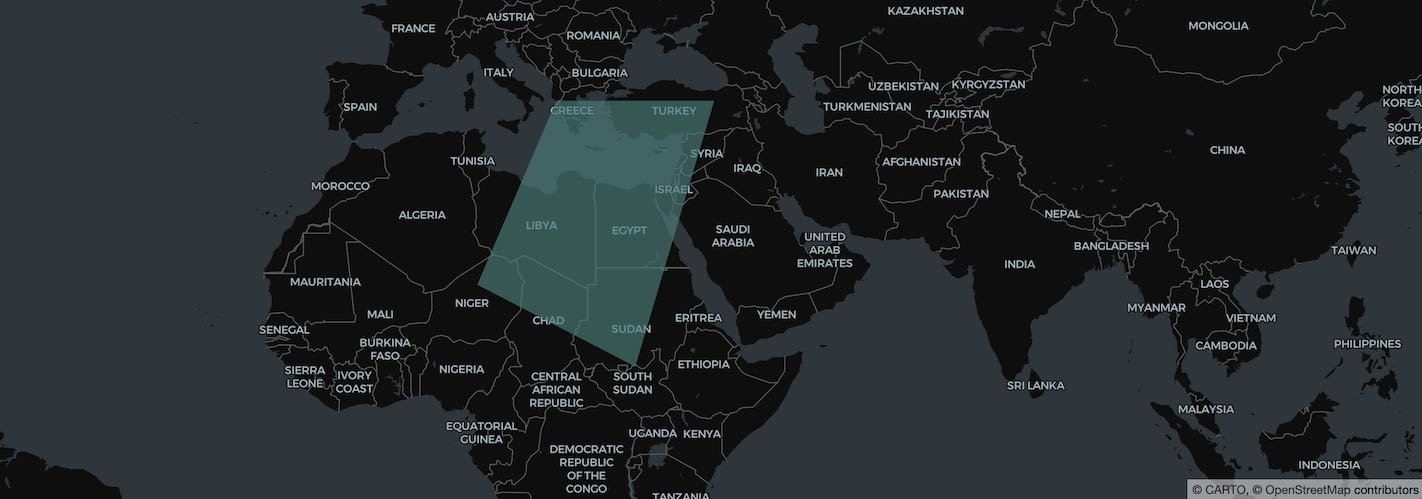

In [0]:
displayHTML("""<img src='data:image/jpeg;base64,/9j/4AAQSkZJRgABAgEASABIAAD/4QDoRXhpZgAATU0AKgAAAAgABgESAAMAAAABAAEAAAEaAAUAAAABAAAAVgEbAAUAAAABAAAAXgEoAAMAAAABAAIAAAITAAMAAAABAAEAAIdpAAQAAAABAAAAZgAAAAAAAACQAAAAAQAAAJAAAAABAAiQAAAHAAAABDAyMjGRAQAHAAAABAECAwCShgAHAAAAEgAAAMygAAAHAAAABDAxMDCgAQADAAAAAQABAACgAgAEAAAAAQAACxygAwAEAAAAAQAAA+akBgADAAAAAQAAAAAAAAAAQVNDSUkAAABTY3JlZW5zaG90AAD/4g0gSUNDX1BST0ZJTEUAAQEAAA0QYXBwbAIQAABtbnRyUkdCIFhZWiAH5wALABYACgARACNhY3NwQVBQTAAAAABBUFBMAAAAAAAAAAAAAAAAAAAAAAAA9tYAAQAAAADTLWFwcGwAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAABFkZXNjAAABUAAAAGJkc2NtAAABtAAAAepjcHJ0AAADoAAAACN3dHB0AAADxAAAABRyWFlaAAAD2AAAABRnWFlaAAAD7AAAABRiWFlaAAAEAAAAABRyVFJDAAAEFAAACAxhYXJnAAAMIAAAACB2Y2d0AAAMQAAAADBuZGluAAAMcAAAAD5tbW9kAAAMsAAAACh2Y2dwAAAM2AAAADhiVFJDAAAEFAAACAxnVFJDAAAEFAAACAxhYWJnAAAMIAAAACBhYWdnAAAMIAAAACBkZXNjAAAAAAAAAAhEaXNwbGF5AAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAAbWx1YwAAAAAAAAAmAAAADGhySFIAAAASAAAB2GtvS1IAAAASAAAB2G5iTk8AAAASAAAB2GlkAAAAAAASAAAB2Gh1SFUAAAASAAAB2GNzQ1oAAAASAAAB2GRhREsAAAASAAAB2G5sTkwAAAASAAAB2GZpRkkAAAASAAAB2Gl0SVQAAAASAAAB2GVzRVMAAAASAAAB2HJvUk8AAAASAAAB2GZyQ0EAAAASAAAB2GFyAAAAAAASAAAB2HVrVUEAAAASAAAB2GhlSUwAAAASAAAB2HpoVFcAAAASAAAB2HZpVk4AAAASAAAB2HNrU0sAAAASAAAB2HpoQ04AAAASAAAB2HJ1UlUAAAASAAAB2GVuR0IAAAASAAAB2GZyRlIAAAASAAAB2G1zAAAAAAASAAAB2GhpSU4AAAASAAAB2HRoVEgAAAASAAAB2GNhRVMAAAASAAAB2GVuQVUAAAASAAAB2GVzWEwAAAASAAAB2GRlREUAAAASAAAB2GVuVVMAAAASAAAB2HB0QlIAAAASAAAB2HBsUEwAAAASAAAB2GVsR1IAAAASAAAB2HN2U0UAAAASAAAB2HRyVFIAAAASAAAB2HB0UFQAAAASAAAB2GphSlAAAAASAAAB2ABDAG8AbABvAHIAIABMAEMARAAAdGV4dAAAAABDb3B5cmlnaHQgQXBwbGUgSW5jLiwgMjAyMwAAWFlaIAAAAAAAAPMWAAEAAAABFspYWVogAAAAAAAAgwoAAD1u////vFhZWiAAAAAAAABL+gAAtCEAAArgWFlaIAAAAAAAACfSAAAOcAAAyJFjdXJ2AAAAAAAABAAAAAAFAAoADwAUABkAHgAjACgALQAyADYAOwBAAEUASgBPAFQAWQBeAGMAaABtAHIAdwB8AIEAhgCLAJAAlQCaAJ8AowCoAK0AsgC3ALwAwQDGAMsA0ADVANsA4ADlAOsA8AD2APsBAQEHAQ0BEwEZAR8BJQErATIBOAE+AUUBTAFSAVkBYAFnAW4BdQF8AYMBiwGSAZoBoQGpAbEBuQHBAckB0QHZAeEB6QHyAfoCAwIMAhQCHQImAi8COAJBAksCVAJdAmcCcQJ6AoQCjgKYAqICrAK2AsECywLVAuAC6wL1AwADCwMWAyEDLQM4A0MDTwNaA2YDcgN+A4oDlgOiA64DugPHA9MD4APsA/kEBgQTBCAELQQ7BEgEVQRjBHEEfgSMBJoEqAS2BMQE0wThBPAE/gUNBRwFKwU6BUkFWAVnBXcFhgWWBaYFtQXFBdUF5QX2BgYGFgYnBjcGSAZZBmoGewaMBp0GrwbABtEG4wb1BwcHGQcrBz0HTwdhB3QHhgeZB6wHvwfSB+UH+AgLCB8IMghGCFoIbgiCCJYIqgi+CNII5wj7CRAJJQk6CU8JZAl5CY8JpAm6Cc8J5Qn7ChEKJwo9ClQKagqBCpgKrgrFCtwK8wsLCyILOQtRC2kLgAuYC7ALyAvhC/kMEgwqDEMMXAx1DI4MpwzADNkM8w0NDSYNQA1aDXQNjg2pDcMN3g34DhMOLg5JDmQOfw6bDrYO0g7uDwkPJQ9BD14Peg+WD7MPzw/sEAkQJhBDEGEQfhCbELkQ1xD1ERMRMRFPEW0RjBGqEckR6BIHEiYSRRJkEoQSoxLDEuMTAxMjE0MTYxODE6QTxRPlFAYUJxRJFGoUixStFM4U8BUSFTQVVhV4FZsVvRXgFgMWJhZJFmwWjxayFtYW+hcdF0EXZReJF64X0hf3GBsYQBhlGIoYrxjVGPoZIBlFGWsZkRm3Gd0aBBoqGlEadxqeGsUa7BsUGzsbYxuKG7Ib2hwCHCocUhx7HKMczBz1HR4dRx1wHZkdwx3sHhYeQB5qHpQevh7pHxMfPh9pH5Qfvx/qIBUgQSBsIJggxCDwIRwhSCF1IaEhziH7IiciVSKCIq8i3SMKIzgjZiOUI8Ij8CQfJE0kfCSrJNolCSU4JWgllyXHJfcmJyZXJocmtyboJxgnSSd6J6sn3CgNKD8ocSiiKNQpBik4KWspnSnQKgIqNSpoKpsqzysCKzYraSudK9EsBSw5LG4soizXLQwtQS12Last4S4WLkwugi63Lu4vJC9aL5Evxy/+MDUwbDCkMNsxEjFKMYIxujHyMioyYzKbMtQzDTNGM38zuDPxNCs0ZTSeNNg1EzVNNYc1wjX9Njc2cjauNuk3JDdgN5w31zgUOFA4jDjIOQU5Qjl/Obw5+To2OnQ6sjrvOy07azuqO+g8JzxlPKQ84z0iPWE9oT3gPiA+YD6gPuA/IT9hP6I/4kAjQGRApkDnQSlBakGsQe5CMEJyQrVC90M6Q31DwEQDREdEikTORRJFVUWaRd5GIkZnRqtG8Ec1R3tHwEgFSEtIkUjXSR1JY0mpSfBKN0p9SsRLDEtTS5pL4kwqTHJMuk0CTUpNk03cTiVObk63TwBPSU+TT91QJ1BxULtRBlFQUZtR5lIxUnxSx1MTU19TqlP2VEJUj1TbVShVdVXCVg9WXFapVvdXRFeSV+BYL1h9WMtZGllpWbhaB1pWWqZa9VtFW5Vb5Vw1XIZc1l0nXXhdyV4aXmxevV8PX2Ffs2AFYFdgqmD8YU9homH1YklinGLwY0Njl2PrZEBklGTpZT1lkmXnZj1mkmboZz1nk2fpaD9olmjsaUNpmmnxakhqn2r3a09rp2v/bFdsr20IbWBtuW4SbmtuxG8eb3hv0XArcIZw4HE6cZVx8HJLcqZzAXNdc7h0FHRwdMx1KHWFdeF2Pnabdvh3VnezeBF4bnjMeSp5iXnnekZ6pXsEe2N7wnwhfIF84X1BfaF+AX5ifsJ/I3+Ef+WAR4CogQqBa4HNgjCCkoL0g1eDuoQdhICE44VHhauGDoZyhteHO4efiASIaYjOiTOJmYn+imSKyoswi5aL/IxjjMqNMY2Yjf+OZo7OjzaPnpAGkG6Q1pE/kaiSEZJ6kuOTTZO2lCCUipT0lV+VyZY0lp+XCpd1l+CYTJi4mSSZkJn8mmia1ZtCm6+cHJyJnPedZJ3SnkCerp8dn4uf+qBpoNihR6G2oiailqMGo3aj5qRWpMelOKWpphqmi6b9p26n4KhSqMSpN6mpqhyqj6sCq3Wr6axcrNCtRK24ri2uoa8Wr4uwALB1sOqxYLHWskuywrM4s660JbSctRO1irYBtnm28Ldot+C4WbjRuUq5wro7urW7LrunvCG8m70VvY++Cr6Evv+/er/1wHDA7MFnwePCX8Lbw1jD1MRRxM7FS8XIxkbGw8dBx7/IPci8yTrJuco4yrfLNsu2zDXMtc01zbXONs62zzfPuNA50LrRPNG+0j/SwdNE08bUSdTL1U7V0dZV1tjXXNfg2GTY6Nls2fHadtr724DcBdyK3RDdlt4c3qLfKd+v4DbgveFE4cziU+Lb42Pj6+Rz5PzlhOYN5pbnH+ep6DLovOlG6dDqW+rl63Dr++yG7RHtnO4o7rTvQO/M8Fjw5fFy8f/yjPMZ86f0NPTC9VD13vZt9vv3ivgZ+Kj5OPnH+lf65/t3/Af8mP0p/br+S/7c/23//3BhcmEAAAAAAAMAAAACZmYAAPKnAAANWQAAE9AAAApbdmNndAAAAAAAAAABAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAAAEAAAAAAAAAAQAAbmRpbgAAAAAAAAA2AACuAAAAUgAAAEPAAACwwAAAJoAAAA2AAABQAAAAVEAAAjMzAAIzMwACMzMAAAAAAAAAAG1tb2QAAAAAAAAGEAAAoEQAAAAA2ZNdgAAAAAAAAAAAAAAAAAAAAAB2Y2dwAAAAAAADAAAAAmZmAAMAAAACZmYAAwAAAAJmZgAAAAIzMzQAAAAAAjMzNAAAAAACMzM0AP/AABEIAfMFjgMBIgACEQEDEQH/xAAfAAABBQEBAQEBAQAAAAAAAAAAAQIDBAUGBwgJCgv/xAC1EAACAQMDAgQDBQUEBAAAAX0BAgMABBEFEiExQQYTUWEHInEUMoGRoQgjQrHBFVLR8CQzYnKCCQoWFxgZGiUmJygpKjQ1Njc4OTpDREVGR0hJSlNUVVZXWFlaY2RlZmdoaWpzdHV2d3h5eoOEhYaHiImKkpOUlZaXmJmaoqOkpaanqKmqsrO0tba3uLm6wsPExcbHyMnK0tPU1dbX2Nna4eLj5OXm5+jp6vHy8/T19vf4+fr/xAAfAQADAQEBAQEBAQEBAAAAAAAAAQIDBAUGBwgJCgv/xAC1EQACAQIEBAMEBwUEBAABAncAAQIDEQQFITEGEkFRB2FxEyIygQgUQpGhscEJIzNS8BVictEKFiQ04SXxFxgZGiYnKCkqNTY3ODk6Q0RFRkdISUpTVFVWV1hZWmNkZWZnaGlqc3R1dnd4eXqCg4SFhoeIiYqSk5SVlpeYmZqio6Slpqeoqaqys7S1tre4ubrCw8TFxsfIycrS09TV1tfY2dri4+Tl5ufo6ery8/T19vf4+fr/2wBDAAYGBgYGBgoGBgoOCgoKDhIODg4OEhcSEhISEhccFxcXFxcXHBwcHBwcHBwhISEhISEnJycnJywsLCwsLCwsLCz/2wBDAQcHBwsKCxMKChMuHxkfLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi4uLi7/3QAEAFn/2gAMAwEAAhEDEQA/APGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqjNqFvCxTJZh1AFXqx9QhuJXAjjyvqMZ/GkxoZ/azbx+7AXvzzVw6jaAkbicegOK5543jOJFK/UYplRzMvlRbvJIppzLESQQM5GORVSiikMKKKKACiiigAooooAK0rWSSGzuZdx2uBCq5+Us/JOOmVUZ/Gs2r918lpZoOAUdz/ALxcjP5ACgChRUrwTRgGSN1DDILKRn86ioAKKDwCT2Ga6uXwdq0GpWWlzGJZb9SYzuJVSoyytxwy9x7igVzllZ0YPGSGBBBHBz2x71tXdtbNjz54o7rJ83bkocHvtHyv6jGDVzRdIvr60FzpqRmY3KW4Zz8waQblKgjAwM5Y5PoKkPhdnvlshqlg0sjFf9Y+fM3BShG3O4k8Z6807BdGL50djF5ds6TSSH9423cuwdEww5z1P5Uzz7CT5prdkb/pi+FP/AWB2/ga3z4RlD3StqNkFstomcu+1GdmUKTt65U5qje+G76wtri7neIx25h+ZH3B1nBKOhA5U468UWC6Koj09LY3yozgsI1ic8Bsbidy4yMdPfrVOa7eWPyVVIo87tkYwCfU8kkj3ro7zw9e6XYIupskSXCCeJsk+XINoKPgcEqwz1wOe1YJ0zUM/LAzjsyYZSPUEHBFILlCnKjO6ogyzEAD1JOBV97W3tFQX3m+ay7jGm0bRkgZJzycdhSfb1jJe1t44X5AcZJA9geN2OrUDEOnTqdrSQA5xzKvWnWsDQXLS3SMq2uXcEY+ZfurnpktjHrWdgAY7VehvNQ3LHFJJJgbQnLgr6FecigCrLNNM2+dy7epJPXrjPSo62Li3sIyvns9vK6gtEg3iNvfJzgjHyjkVV+zWZOEvF/4FE6/40AUaKvnTbkHd8nlYz527EeP97+mM+1OUWdqGkMiXMmMKmxtmSRyScZwM4FAFOOCeYgRRu+7ptUkH8elNkjkhcxSqUcdVYYP+fetWa6mvbR5QxR4iokRGZUaM8Ahc4GDwQOMHNVIr1ggguszQ4I2k8r7ox5Uj8vagClRV+eC3a3+12rEKCEaNsllYgn72ACDiqFABRRRQAuTjbnjrikoooAKKXBxuxxnGaSgAoopVVmYKoLE8AAZJPsBQBJBjzo8v5Y3Ll/7uD1/DrVzVSDfy4jEZB5AOcnru9MkEE4pjadMuUlkgjPQh5VBHsQM0moypNdu0bb1AVA/97aAN34/yxQBSooooAKKKKACr2mxJNfwxyDcpYkj1wCcfpVGnKzIwdSVIOQQcEfQigAeV53M8hy0nzE+5pta1xbXN8Iru3iMm+MCQoB/rFJDZHqePrWY8ckTbZVZD6MCD+tADKKKKACiiigAooooAKKKKACiiigAooooAKuNp9+kjwvbyB4k8x1KnKpjO5vRcdzVM/db6H+Ver+INV0bVba702wnigmMdvKZ2k/d3RRApiY9tnVVzgtnNNITdjzH7HdiBLkwv5Ur+Wj7TtZx/CD3PtV240HXLOFrm7sbiKJOWd0IUfU16Fd33hm402Xwxb3xCwQoLeR1CwfaISXMgkz1lLEE45qpqltbmwt9Gs9atHtC6PcytdZllkJALbTnCRjlVz2ycmnYnmPPDY3iiFjBIBc/6klT+85A+X15IHFOTTr+QuI7eRikgibCn5ZCdoQ/7RPGOteqXOteGdSMdvDdmJdOu7ea1EyCONYomVHRGycgqN4HHNVL3V9G1C/tLi0nS0isNULvCz5WZZJs/aVbjJ67gfuqeOOpYOZnmYs7thKRC5EJCyYU/IS20BvQluB78VoHw7r4dIjp9zukXco8pgSB3H9R19q7iPW9DddVFmIrCZ7q3kSZ5XlEuy5379h7D7xC9jUHiG/sybO8jvIxePd75ktLmSWAxnBaQhuIyTxt9M/gWDmZw0+j6tazxWtzaTRyznESMhDOf9kd6riyvCJmEMmLf/XHaf3fO35vTkEc16INU0tfEur65c3p2RF0smjPmvum+XzI1JAwgyfx9q0ZfEOj2Y1HXNNlinfUIbYSW0uFeRkkKTKyc4DJ83frmiwczPJ5LeeFI5JY2RZV3ISMBlzjI9Rmoa7PxdcaRMmmRaNN5sENswCk/NHukLBH9GUHH4VxlJlJ3CiiikMKKKKACiiigAooooAKKKcjBWDFQwHY9DQBZuFeILGvCFVPHQkjuaqVuA2l/GsQJjZRwuf5Doax5ECSNGGDYOMjvTYkPhtri4OII2fHXA4H1PQfnVy4eS0iis43KsAXl2N/Ex4BKnkqoAqO6Zo7e2tVJ2mISsOzNIc8jvgDAqh04FIZp2w+12slmB+8VvNj5AMjH5Spz14565+tZzIyMUcFWHUEYI/A00gHg81oGe2ulX7YXSRFC+Yg37wOBuBPBA7g896AM+ir7WLMhmtGEsYGeoEgx1BTrkd8cY5FUKAClBIIIPSrdikbThpW2hBu574qO5lSaUtGu1e3qfc0AQEljuYkk9zSUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFBOASe3NFWrJYHu4kuf9WzYbJwOQcZPpnGaAJr8eSyWI6QL83u74Zj+oA+lEV2tva7IhiVicn0HY/wCFOmtL6eV7i6CRMzHPmMIxkcELnqB6jio1068adINn3+Q3VNvdtw4wKBFIkk5JJ+vNJWj9ktDIYkuxvzgbo2VSf97JAz61RkjkidopVKspwQeoNAxlFFFABRRRQAUUUUAFFFFABRRRQB//0PGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQgMMEZHvWNd6fGoMsbBFHJzk//qFbVRTxedC0Wcbhik0NM5GjK/3l/MVJNDLCGEqlTg/Tp2Ne6y6hAfGEOlJdMQsh3W5t4xEgFuWBEgG44ODioSKcrHg3B6EH6HNGR1yMeueK9am0631tdIe9uIrxWeaee+SIQILWEDdG/Tnd3IGAfrWtHBbT6vB4mjW0nBtrmGeO3YSQCSNCyDOBy0fB47U+UXOeH0ZX+8PzFez6bpWhrpdtcWIjniu7maexjnwcTfZ8JDKf9lge/OB61Bov/CSvqTPr9u6SrY3RhZYIhOxUx/dQcNg/dBAHPU0coc54/wAdiD9Dmiuo8W/bDqam8+0Z8pdpuYkhcjJz8sfGM9D1rn7WA3NwkGcBj8x9FHLH8B+tSUmTwQwJA1zeKSrcRKG2l2zyR1+UDv0zxT21OXCpDHEsaDCKyByB1+83J55NGpQ3iy+fcxGJHO2MEj5VX7q8E4wO31rOAJOAMk8ACgZoHV9RMpmaYknGQQCpA7ben9fert4bMSJDdwpAHhSUyRJyHbk8d1PT2PNZP2W4Fz9jKES7tu0464z9OlalumoxNJBMwVIVZ90qGREKjIKHnnHIxx7UALp+o6bBqcN3c2i+RFKJAsXDMFyUVsnacnbk+x65rr4fGMjhbuXTCklvdfa0aLeUYuCs24v03KeNvAYAniuMudQhS6lktIYw+TsmXI6jltp4yecHiqcV/crMJZXaUchldiQysMEdeMimmJpM6x9f0SC2i06zivXtzcLPK0kiLKojUrGsZTONpOdxOePen6t4osb260yaNJ5msp1lknuBGJpFDq2z93wQMcE965HytOf/AFc8kXtKm7/x5D/MVK+k3StsQxyMQDtVwGwemVbaRRcXKjdtvE0Nr/bDrbJOdRmSSNJ1DxgCV3Idc9cNxjPNaknirSru4uRdQTyQ3dxaSCP938iwf8shzjbngexOeevFmyjgA+2zeS558sIXYD3wcDPYVd057WO5VbNGmfIy8qgLGg+8RgnBx0JouHKjc1jxRDqtle2F5ZJBO9wJ0eFmYecvyPu3noUG35R+FcP7DpVm6t3tpysn7xWJZXzxIp/iDd89/emSTs67FARP7q/1Pei9xpW2IKKKKQwrRdms7ZI4yVlnXe5HBEZ+6ue277x/AVDYwLc3IjflFG9wOTtHYD1Y4A+tLfLdidpryN4mlJYB1ZeB2G4DIAwKAKdFTPbzxIjyRuqycoWVgG/3SRg/hSeRN532fy38zONm07s+m3Gf0oAjycYzxnOO2fXHrSVIIpGV2CsQn3jg/Lk454459aPKlyg2NmTlPlPzc4+Xjn8KAH287W8vmABgQVZT0ZT1U/Wn3VusLK8RLQygtGx647g/7S9D+dQtDKhUMjAtwuVIyQcccc88cd+KuojiyuoZVKmJ4nwQQQxJQ5B6ZFACWTRyq1hKSomdSrjna44GR3Bzz3FUCCpKnqCQfqOKv2+n3ssIu4QAqtwSwU5B6jPof1qbUreZEhupkCNICJMYALgk5wOPmGDkcUAZNFacOmSyBXdgqkZx3ptzaRwhQZVBA5zwT7gd6dhXM6rpMUEKK0StIwyS2TgHpx61TBwQeuOeelK7tIxdjktzmkMsS3CyRLEsSoAd3y+v0qrT0jeQgIpOTjj1rXi0kYzM5z6L/iadmxXSMYAk4HJPpWtZQ3C2s8sIKyMUjVvukDlmwe2RgcVpW9pFbD5OW7setVbrUPKZ4VVg46E4x9adu4r9jIltZrZVaQBQxwMVXqSSWSU7pGLH3qOpKCiiigAooooAKKKKAFyfX3/GtGNnvbc2rkvLHl4iTkkD76c89OQPUVm1e04wLdB532bRlGzt+cEYycHA69RigCjRWpPYXMt1KyxeSrMWAJ4weeCMgj6fStC2sIoBub539T2+lNITZzrI6AFlIB6EjGabXYsqsNrDI9DUKWtugKrGuG68U+UXMcpRVm8jWK5dEGFB4HpkVWqSgooooAKKKKACiitVdMJUtuDfLkY9e34U0guZVLk1NNAYAgc4dhkr6DtmoKQC5Oc0u5vU02igBckUZNJRQAuTQST1OaSigBcn86MnGKSigBc0lFFABRSgFiFUZJrZt9NTy911kMe2cYppXE2YtFagt9NBKtMeD6j/AAqvJbwAnyrhCO244NFguU6KvJY+YpMc0bMP4Qf61aGnwxR+ZcueBkgYGPaiwXMeiiikMKnt7eW5cxwgEhSxyQBge5471GY5FUOVIU9Djg1bX91pzsetxIEH+5Hyf/HiBQBXnt57U4uEaP0LDA/A9D+BqEMDyCD+NWYby6txtglZB6A8fkcj9Ksf2rekDLKXGcSFRvUHqAcYH5ZoAbfKUW1SQESLAoZT1ADHbn6iqFKzM7FnJYnkknJP4mkoAKKKKAHxySQyLNEcOhBU+4/pVm+RFm82IYjnAlQegbqP+AnI/KqdX1/e6dIG/wCXeRSh9peGX8xuoAoUUUUAFFFFABRRRQAUUUUAaOmaTf6xO1tp0fmyJG0pXIB2pjOM9TyOKW30nUbqwl1O3hL28LpGzDrvkwFUDqScjp61peG9XXRp7q63mOVrSaOFgM/vWKlPoMjqeK60+N9OSKVbS2MUaSW9xHARkPMJ/NnO7kAHjbnpimkiW30OPvvC2uafavd3UACRDMoV0d4gem9VJK5//Xiobjw7q9reTWFxDsmgga5cFhjylGSwPQj+vFdBNf8Ah+wGpajp1xLcz6jDNCsTwmPyxcHLGRySH29tvWt658a6bc3OqCYGRTBKthKUOR5kaho3XGdhYZGenPYinZCuzhpfC+twWRv5oAiKnmsrSIJRHjO8xk7gPwz7U+Xwnr0No15Jb4VU8xk3qZVTGdzR53Afr7Vv3mo+Gbq/ufEryPJczRlktJIWOyfChT5oO0opXI9qlOs6BDrE/i2G4mkuZQ7LZmIgiSRNhV5s7TGMk8c9PSiyC7OQGg6odQh0sRD7RcIska7hgq6lwc9BwDUMGk6hdabPq0ERa1tiqyPkcFsY46nqM+ld7Dqvh2PV9N1w3z5tYIYXh+zyZykTISH6dT6VDpfiXw/ptpZaO8Es0AgaO5kViqlrj/W5jK5fbgbTntx7lkHMzzaipJVRZGWNt6gkBiMbgDwcHkZHOKjqSwooooAKKKKACiiigBzu8hDSMWIAALEkgDoOe1PWeZImhR2VH+8oPB/CouvA71fTTbnDPcD7OiqDvlBVeTgDOO/6UAUK0onW+RbaY4mUbYpD3HZGP/oJ7dKZs06L5ZHknYdfK2qn0Bbk/XHNJt01/mDzQ/7OBJ/3y2R+tAFJlKsVYYIJBB7EcEUlWbydLm6knQFQ5BAOM9AOccZOM1WoAKKKKACiiigAooooAKKKKAP/0fGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAKOogG0fPbB/Wud8yTf5m9t397cc+nXOa6S9m8mDdgNkgEHuD1H5VzkoQSMIzlc5H0NRIuIglkVSiuwU9QCQD9R0pRLKoIV2APXDEfyNR0VJQuSV2E/LnOO2fXHTNSm4uDJ5xkffjG7e27HpnOce1Q0UASSSyyndK7ORxlmLH9c1La3c1nIZYNu4qV+YZ4ODx78VWooA1rdI57CZ7uTYqzBlfBZjIw5BA6gjnORzUSSW1mDJbSGWYjCsUKCPPVhknLdh6dadbKILWS5nYGKZWiEYydzDkZPRdp5B6+lZlAGzFeQMHupjtuo42CntISu0E+jAdfUVnLd3SIY1lfYU2bSxI29MYORVeigAoop8ewSKZfu5GfpQARpLI22EZccjHYjoa0dXjZrhbl1+WZQQSBncBht3bdnr7YrbjSJFAiACnpiq9xc3MlzHaMkTRgZBaMMcDr1OOvtVOJNznoreWSZYI0O9jwp47Z747c1cvLgqkdnBKDEkah/LPys/8RyMbvxqzPe3dtMJHEcrAttkkTLjnpnI4GePaqcOnSTQRyRyRhpCwVGO0kKcEgnjj0649akojgudieROvmQE5KZwQf7ynsf0Pepf7PaT5rSRJUPTLKjj2ZSRgj8qQw6dkoLh8j+Py8xn6AHd+NNNih/5ebYjtmTH6bePxoAn+y2lvbi5lf7Sd+zbEcIGxu5fGTx/dFNjvLTzAZ7OFkzzs3Kcfng/j1qzBabbaaK9O2H5ZVlQl/mIKjaAPmBHXpisSgDpbK4mi1exiZ41t2uIJF8tQiFfNXBI69uQTxXos+raNuuHu7qW/txqqeclwVxbqrsQ8a5JaMt8pwcYHSvKLYx33lWEw2sPkjkXtnJ2sp4I68jms1l2sVPVSR09OOKadiXG56w82pQJqEviK/iubW6H+iqJVkDzFwY5IlGdiqOvQY7Vstq2g/wDCV/2tvT+0FufsQXI2FCw/0jPtHlM+teG4HoPyo7Y7enanzC5D2HTn0PT7c6TfXsaf2s8r3KeWzkpMSkA8xflTb945zye1S20ulpJoOhapJFHLaqjxXCkEJNFMd0bH+7IBxnoQD3rxnAAwAMUAAdAB+FHMHIewKdNa4sdTvp0SDT/t0pz8/wC8e6YRDYPmPJ3celc74rNpeLHqVhOLqTUREkrKpQtPBwxKNyu8EEcY4NcBgdQB+VaFjfGycny1cNg8gblIyAynnBGe/FJsajbUS9KKsVmpD+QGDMOhZm3ED2XpnvU1tp8sjq1wMIo6E5OPTHYVGZNOjx5dvJKp43SSFT7gBBj9TXRAKAAucDpnr+OOKaQNhVea0gn5kXn1HB/OrNFUSZslvYWoWSQY2kEDJJODnHv71El/YXGVvbdULEnzIgF+mVPGfcGmXWnTOxlV95/2uv8AhWNUspHYRwxQoFhIaM5KMvOQeh+vrT65+xuZkUwRR7zy3XGPrWlYvqE19EsqBI93PHpzjr3ximmJovVz1/dpMxjVAdpI3Hr+FXLrUJ43cPERuJKknsfpWDSbGkFFFFSUFFFFABRRRQAUUUUAOVWY4UEn2q/bafNIwaUbVB5B4J+lT6VCctcHp90f1rbqkiWxkaJEgjjG1V6AdBT6KKokKKzLvUPs8nlxqGI65OMVVOrSHgxL+Z/wouh2ZQupfOuHkHQnj6DioKc5VmJRdg9Ac4ptZlhRRV86e8R/0ySO3/2WO5/++Fyf1FAFCpYYmnk8tMZxnnsB3q1v06H7qSXDerny0/ALlvzNXYb1ks5JGjiWNiEEartB9eR82ffPFCEZW8Rb0iberrgnGB+H0psU0kD74zg/pVprVJ1MlgS4HLRH/WKPX/aHuOfUVQ68igY+SR5XLyHLHvTKKKACiiigAooooAKKKKACiiigAooooA2tMtwQZ3APPy+ox1qC/u3kLWxUBVbnvnFMsrtoT5TH5Gzj2NZ+SeT1PWnfQVtQooopDClJJOTyfekooAKKlhhluH8uFS7Yzgeg7kngD61a+yQR/wDHzcoD/diBlb8xhR+dAExu4ZbFoH+V1XgepXpj3qHUB5ckdoOlvGEP++fmc/mf0pQumSDCvLCyn7zjfuH0TGCO3NGoSRSyRskglfyx5kgG3c2TjI9QMZouKxn0UUUDCiiigAooooAKvqPL019//LWVfLHugO9vpghfrVCtANb3NtFFNKIXh3KMqzKyscjlehByD60AZ9FXvsO7iK4t39B5m0/kwFKdL1DGRCzD1Uq38iaAKFFOZWRijgqw6gjBH1BptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFXxpl6VBCDJGQm5d+Ov3c56c461QyM7e47d/yoAKKuwQRrF9rugTF0RQcGRvQHso6k/gOaX7XCMbLSAY/vbn/maAH2u62t3v8Aox/dwn/aP3mH+6O/qaoF3PBZjnnkk1JPPLcSebMctjA7AAdAB2A9KhoAKKKKACiiigAooooAKKKKACiiigAooooA/9LxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiio5JY4V3yEKKQySiqkN7bTHCtg+jcU9rq2X70ij8aLhYsUVEk0Mv8Aq3VvoaloAKKKKYjL1VwIVTGSzflisCtTVXDTIgP3V/may6ze5otgooopDCiinpHJISI1LEc8UAMooPBweD6UUAaNqrvY3SQgu7GMlRz8ikksB3wcD2FZ1TQLM0y+RkODkEHBHvntXSXFqLiaN55DKIo1XkY3Hkkn6k9KaQm7HPpZ3MkfmomQenPJqsyspKsCCOoNdjVe4torhCHHzY4PcU+UXMcrT4iokUuMruGR7Zpn1oqSjs6TArAtNQaLEc2WTse4/wARW8rK6hlOQeQRWidzNqxR1C3aeIBOqnI/wrMjC3dsbV1/eQI7xkfxAHcykevcEV0LKrqVYAg8EGsOW1ns51ntMnByuBkg+h9RUyRUWZVLk1emhjmRri2XYUGZYe6f7S+qf+g/SqFSUa2mXF1GJhFI+I4ndYwTgseM7e+MkmskYAAHStXSIJnvI51jZo42+ZgcBeOpOR06kelZ87+ZPI+EGWP+rGE/4D7HrQAkUskEqzRHa6HKnAOD+NXTcWMzedPCwkJywV9sbE9SerL6kLWdVuwETX0CzcoXAOentn2zigB+owR2148USsqjBG7nOR1U91PaqNaz3Uc8C22otN5qSOzMArcngjkggD0HHeq/k6ex+W6ZR/tQsf8A0E0AUaKvfZbcjKXkP/Ag6fzBpxmtbb5bZFnfvJKuR/wFD0+p5oAzwQehzR061of2neNxIwkQ9Y3VSh/4CAKQNZXIAlAtXB6xoWRgfVQcg+460AatnbKtugmUFhlhntnmr9GAOB2orQzCiiimIa4YoQpwSDg+9Y9vpeGJuSCB0APX6mtqilYdyKOGKEYiUKD6VLRRQBFNDHOnlyDIrGudNdG3Ww3L6Z5H59a3qKGrgnY40gg4PBFJXQ31iJx5sXEncf3v/r1lR2F9MnmRQuy5IyMdR14JzUNWLTuU6KVlZWKMCGXqCMEfUGkpDCiiigApRjI3HA7mkooA66HyxEohwUxxipaw9JkwzxE9cED+dblaJmbQVTuriW3wUjLrzkjtVyigDmLq4huCJFQo/c5GDVOrd7B5FwQPut8wqpUMtBRRRSGOT76/7w/nVvUgBqNzjj96386qJ99f94fzq3qX/IRuf+urfzoApVbe4zZpbg5wxLfnwKqUUAKrMrBlJUjkEHBB9iKv+dBef8ff7uU/8tlHyn/roo/9CH4is+igCWaGS3laGUYZfxHsQe4PY1FWjDi9iFo3+uQfuT/eHUxn+a/lTF0zUGG7yGUerYT/ANCIoAo0Vf8A7Nuj9zy39lkQn+YpTplynNzst16BpXUAn0GCaAM+ipJYpIZDFMpV16g/5/Wo6ACiiigAooooAKKKKACiiigAooooAKKKKAJYrme13SQNtJUg8Agj0IOQRVrU1jjvpI4kVFTaMKMDO0EnHbOaoEZBB78VfvyZWivP+e6At/vp8j/yFAFCiiigAooooAKKKKACiiigAooooAKQAKcqMH1HBpaKALyXSSoIL4F1HCyD/WJ9CfvD2P4U7+zbh/mtSs6dQUYZx7qSGB9qz6lgle3mS4iA3ocjIyPx9qAIuvIoq3eRRxyhoBiKVFkQdcBh0/AgiqlABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABV7TkV7xC43BA0m3uxQbgB6kkVRqxapcvOv2QFpVIZdvbHc+g+tAEJd5H85zl2O4t3z1zmrv9pXbDbOVnHpKiv8A0B/WmX6wrdN5JUhsMQpyqsfvKD3APeqdAEs081w/mTsXbpk9h6AdAPYVFRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAf/0/GqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAguGlWFjAMv2rmJJ5pgBK5bHrXW9eK5yayuD5twkRESkndjAx7A8kD1AxUSLiUKKcqO52opY9cAEn8hSEEHBBB9+KkoT3p5kkIwWYj6mmUUAPWSRMhGIz1walW6uU+7Iw/HP8AOq9FAGq8lrfRoZXEVz8252UBH543EdDjvjFVpNPvoz80EmPVVLA/QrkVTp8ckkX+qdk/3WK/yIoAlFpdNE0wicopwTtPB+nX9KrAg9DmrJu7tmR2mkLJnaSxyM9cHNX5NRgu40jvYMFQMyREBy3ckEYOfTtQBmwRGaZYh/Ef0rqYoY4U2RjArDhk05JVKRzsdwwWdQP/AB0V0NVEmQwxo2dyg54ORWbJpULHMbFfbqK1aKqxNytb2sVspCck9SepqzRRQAUmQRkdKxNSmmWURqxVSueO/wBa07Mk2sRP90UXCxDBof2r7ZdSzpbw2vlyMxVn+WV9mcLzwefepNV8PQWCWy2l6l3PdrE8MSROhZJiQh3NwMnsea0EnMdnfWe3P22OKPdn7nlyF8475zikOtCw1Cw1J7bebCyS3iBIKmaMMFdh/d+bOOtS0O7Ip/Bt5BrSaOZ428yB5lmUEofLDb169QVIPNN0TT72+0+OWzxOxnWBolB3xGTlGY/3Dz82OMVqWfji3HkNfWKbrd5dhtQIhsnQq6kMW5LENn1FYtnrtpo9xdnRkuIobmye3AeQFxI3RyVwML2A5GTRoGpbdBHLJEsiyhHKiRAQr7TjcAecE9PzptV7eeGaMeTwAANvp7YqxVCInjyyypxJGcq3X8D6gjgisS/sDb3G6MYgkYbG6qu7+En/AGT69q6CnK7JnGCDwQeQR6Ed6TVxp2MC5uWsmFjaEDyH3M+3DNIMgn/dwcYPUUi2i6juksFCOvLxnhBnurdMf7J5HbNW7ix+1al5jnZHMxZsdsDJA+oHBquL+3ut1tLAkUc21S0Y+YYPyH0O3PPr1qChssFncbobAfvIh8vJPnAD5sZ/iByQO4qbSdDk1VbmRriK1jtEV5HmDYAZto4UZzmqn9m3asclIyrMAzuE+4cFhnnAI6/lXXaX4jsdLnu/39wwuIY4llgCiRPKbOcy8Nu55xTQPbQo6t4fvIreW4nkike2SCR5UJxLHcNtiI4HIxySAcevWs9/Dd4li9+ZI9iWcd6RznZK5QD/AHgRz2rpL/xJYXF5cwX1tP8AZry3t0aVWjM7tAxZZiR+7bOcEegFQr4l0aT7RYzQXK2TWUNlGUaMy7YXL7m3YXLE9s07Im7MO08OSTWcV9eXltYpcFvIFw5Uy7TgkYB2rnjcajsvDmoX9he6lblDFZZB5yZCoy3l+uF+bPcEVtrrfhyb7Gt5BdsNNwkBVosyRK29UlB44PGV6g1Zh8b2tnJai206MxQvJM/mE7g87EyhNpC42nau4dOtGgXZk2vhC5u7a0ljvLZZ72MyQW7llkcDPAOCueKl0/QrgSWVuPLaTUIlmjYk4VG3H5uONoUk1vw+JBbpbLaabKttawSxCVkj+0xhi21omYn7oIzxg81UsddhFrC62nmyJYR2A87/AFW3cTMcKwY71IC/jng01YTbKVzbzWd1NZXAAkgfY2OR0BBB7gggj2NQ1e1PURqc8NwbcQSJD5Um05Rgh/dlQSWGFJDZ9sZqjTEFFFFMAooooAKKTI6elLQAUUUUAFVbq0iu8NJ99RhW7gen0q1RSGYU8lzCBHfItyg4VmzuH0cfMPoc1XM9gf8Al0I+k7/1Fb1xF50Dx+o4+vauT+tQ1YtO5f8AskdzzYMWPXynwJB9Oz/hz7VSCOd2FJ2fewD8v19PxpASCCOoOR9RV59U1B3D+cykHICYUZ+g4P45pDKTKyMUcFWHUEYI+oNNrWtr0XE6RalsljJOXkHzLkE8MMYGfyrOmt5rVhHcLtYjg9m9wRwfwoAt6YVF0NxwSpA+tdHXGglSGU4I5BrprO6FzHk8OvDD+v41UWTJdS5RRRVkFK8tBcrnJDKDt9PxrnpIJov9YhX8OPzrrqoajuNtsQEs7KAAMk89AKlopM5uitYaRKilrmRY8DJVQZGHsQuAD+NVzaJKhexczbRlkIxIAP4gATkfTkd6gspp99f94fzq3qX/ACEbn/rq386qJ99f94fzq3qX/IRuf+urfzoApUoDMrOoJVPvEDIXPTJ7fjWpFpjeTHdXMiRRNgnccNtz1A5zntU1xqqmKEWW+ExZUxn5kK9ifX0IP/16AMSitFY7K8kURubaRyF2FS6bicDaw5APoRxVB1KOyHqpKnHTIOKAG0N85y/zH1bk/maKKAEKqeoBoAA5AA+gpaKANO3230ItJXVJIyPKZzgbScFM/qo/AVQljMUrxE5KMVyO+04qWzBa8gA7yp/6EKLtJVuJGlRk3u5G5SM5YnjPWgCtRRRQAUUVraXYieVZptgi5272ADsBwPUjP3qAKi2F86eakEhXrnb/ACB5P4CqpBDFCMMOoPBH4VNcySm4Z5pQ8gb/AFitkE/7J9PpU66jOwCTlLlR2lAfH0b7w/OgAjitooEubrc5k3bI1O0EKcEs3UDPYc0u2xufuH7K/oxLRn/gX3l/HIqO7uobgRCNBEIk2437h1z35HWqmQOpA+pxQBfOnXCjLtEg9WlUA+4wTxSfY4gcPd24+jM38lqgNg5BX6gitWCTSsfP1/2zn+XFNITZCLBnwIp7dyewlAP5EClOl6gBuEDMPVSrfyJq5LqFtEm21Cknp2H/ANesQHa3mJhWBzleCD1/ChggAJ4HJPTHetS9VLa3isfmMgIlYnA2l1wUxyR0yc1ZsXhvr2N3gZZN6s0kWWXdkHLLggA9yD71jS/66T/fb/0I0hkdFFFABRRRQAUUVIkUkgJRSwHXHagCOiiigAooooAKKKKACiiigDRtgt5Eti3EiljC3YluSh+uMg9jUKWF9IMpbyn/AIAR/OqoJUhlJBHII4NPeWWQ5d3Y+7E/zNACvBPF/rInX/eVh/MVCGU8Ag/jVpLy8i/1c8i4/wBtv5E4qY6nesMSsso6YkRG/pmgDP3L1yKUEHpz9K0P7U1AH5ZioHRVVQo/DGKT+0Zm/wBckMv+/EpP6YoAoUVoGCC7+e0KxuesLsBz/sMeo9jyKrz2l1bDNxEyD1I+X8xkfrQBXooPHJ4ooAKKswWk06mRQFjHWRztQfj3+gyal2aan3pZpT/sIqD/AMfOf0oAo0Ve83Tl4W3kb3eUg/kq4oE9iORaZP8AtTOR+IwM/nQBBb28lzJsj4A5Zj91B3LHsAKmuLkFfstqStuO3Que7P659OgHamTXlxOojZtsY6RoNqD/AICP65qrQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRVhLS6kAMcMjA8ghGIP44qy8draYiuI2mmH3wHKKhPReAckd+3agD//1PGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK56a6ngvpXB3kgxnzPnBUgcYJ6V0NcxfkG7kx7fyFTIqIpv7rbsjKwg9RCojz9SOf1qe6/f2UV1cMwmACLu581AT83qNucZPB7VRtwhuIhIMqZEDA9CCwz+lSXryPeTeadxDsv4KSAB6ACoLKtFFFABRRRQAUUUUAFORHkO2MFj7c1pafaCUmWZcr/DnoTW6qqowoAHtVKJLkZtppyxYkn+Zuw7D/ABrUooqkiWwooopiCiikYkKSBnA6UAZ99Z/aCrJgMDhj/s//AFq0AAoCjoOK5y51CW4XYBsXuAeTWvYTedbjccsvBzUp6lNOxdpkkaSoUcZBp9FUScxc2UsDcAsnYjn86qEEcEY+tdlVG8sxdAFSFZe59PSocS1I5xWZDuQkH1HFaen3P70+fKemFDHiqM1vNb480Yz0/CoKWw9zs6K5i3vLiAfLlkHUHoPx7VuW15FcjC8MOqnrVJktFxWKkMvBFciVVrjy4xgGQKB6Atiurc4Un0BrjgcjPrSkOJf1Sdri/mdzna5Rc9gpIFZ5IHUgfU1subS5gN/dCVZC4jbyyuHYLnd8w49xUH9oywjy7D9xGPZWdj6sSDz7DgVJROLWSXTIS7Rp+9coZGCYQgZxnkgtz0qr9mtF/wBbdqfaJGk/XgVXmaeRxPcFmZxkM3UgentVy108zqsrMAh9OvHaiwrkb6ddDDQoZ42+68Y3A/gMkfQ1oWVo9riW4ti8xkAjQsAcYOWC8j5Tz83FPj02BASGcFu4O049OOtMFgLdJnhzI8qNGBwMBurE98dhTswujLuJHS8d0maRkc7Zd2SRngg/5FXLXUpN5+2SO4OMEknB/wA+lQwWE0kuJBhAeTn9BWwLGzAx5an6800mJtFhHSRQyEMD3FPrIuUsok8kOYiDuwuSckY5rJM0iMRHKxHrkj9M02xWOrZlUFmOAOpNY9xqnO22H/Aj/QVmNcTumx3Yr6GoaTkNRJZJpZTmRy3+fSmB3HRiPoSKbRUlFy1vJLZmONwbkg+vrmta0v1nLLIAhHI54IrnaKaYmjsVZWAZSCD0Ip1clHPND/qnKj07flVxdUuQMMFb3xiq5ieU6GiuYbULtjnfj2AGKedSuim3IHuBzRzIOU3pbi3h4mk2Z6cFj+Q5rB+zWpO9ryMrnJ+Rw/4KRyfxqiSSck5J7mkqW7lJWLNzbG3xIGDwv9yQcA+x9GHcGo44J5f9VG7/AO6pI/QVo6PPNHdeQjELMCGPHy4BIfnjK4/KqT3t5MP3k8jZH94gfkMUhk50u9UcoA+Nwi3DzCv94L1x+vtVizuJBaNZW+3zVYu0UgDB1A5AB6EdSOCeoPGKRA8+nt9oQ/6Mm+F1yG+Zu/YqDyTwRVVtRvmjMTzMysCpzgnB98Z/WgB09r5gF1ZIzwyc4UFjG3dTj07HuKmDDTPlwHuG++D0jXrt/wB89/Ss1JJIjuidkPqpK/yppJJyeSaAOvjkWVBInIYZFPrA067WImGU4UnIPYH/AOvW8CCMjmtE7mbQtRymQRsIjhjjkdcd8HtkcZFSUhIAJPagAwOlc3cwy2c/mR5UBtyMOx/xFXotVjbaJFIz1Pb/ABpL2+geIxR/PuGM9MUnZjV0RNayXrreWUeQ7ZkRSBscHJ6kcHqKkv7C/N9PNHAzqZGZcYYEZyOhPBrEIU9QD9aUAKcrwfbj+VQWdBqt7iaa2KZJ7k9AwB/MZxiufooouFjf0Owt72DVJZt2+0smniKsVIdWAB464rojYWMr6ZcJZm/m1JrldizNECY5QqsCoOAFyW7HknpXG6dqV7pVyLuxk2PtKnIDKyt1VlOQQccitlPGGuR3n21JIt3lGBV8pfLSMnJVU6AHv696asS0zqoNL8KXt7fGxh3wWVuh3yXTxwvIX2uRIcnYOgOOfpipV8M6FFc3sxjV4o7S2uEWS7McIaZirbZwPmTj5SRyeK5CPxdqsU7ThbcB0EcirboFZA27BXoTnpmp7jxRrdpqFw3mRSCWNIwHhQxmFSXjCpgAAbvzp3RPKzobHwhY65HNLa7LcRXqxt5U/ngxeSGKxs2A7sx4Pbp0HOXZab4euoY7+9WSyt21NrdsyMSkQh3hWJBwd/DNjI59K5261/UrtPLZkjUTrcAQxiPEqLsVht6ECrB8Va3532hZUVzObklY1wZWj8skggjBXqMc9etF0OzOtj0rRU12wsp9NIh1A7I5Yb1pIjg8vG4GTjoQ2MHpUemWGma3e3JmtJ1sLF9rJHJJNIZHbyxg43Y/jYdgB61yU/iXVp761v2dFeyJMCpGqRoTycIOOTyc1Xj1zVIbZrSCdokeZp28slGZ2GCSykEj0HSi6DlZ2EXg2A2V/ZTyGLUor021qSfkkIj8xVI6AuvIPrge1c94h0iOw1WKwso3BeCBtjElt7rluvTnt2qvc+ItUvoora9mLxxyRuSoxITGNgJfOSwXue+DVjWNVmvHl1Ge5Se4nxFvHDiFV7gYwxPDfpSbQ0n1Mh/sdvG6pi4l2t83/LNTg/dH8Z9CeO4Feq+IoLS3jv5dFZP7RWGCS5BQborby1yYgRg/MAZD1wa8texhhOy5uERgBvQKS4JAO0Do3B55wKmuDG9sLuDzImB8oFnJaVcckkHqO/8ADjA6ihMGrnoKTWLDT9Us7cLca1cwm5BA2RrBMkcoj9BJIQT7ZrVuotLvZc6zPDewf2p5CskIi+zBSxMcjYBKv8q9MHk5rxo3Nyzh2kcsOnJ9R0Ax1wOnWtfykliabUIjaxyjcXRz855I/dHdk9f50+YXKdldXPibT4ZtU1q2higsJ4tkLQIA6uSrRxOAPl29Tzng8VZaznttat/DPhFvIAjN1LNIiyHZLgjIYNkRphQBySfxryqWV5AqM7OiZCBiThfYEkDjsKkie8aTfA0pfGMoXLYHuOcfpRcOU9cW71KbXJJ5tKuTDBaGOCQQxi4GSMziNgAzsRyoHyjAwMmozd6ppmsarZPPFLs06W7UiCNCJQi7Sy4OHH8Q6d8V5dcjUbdoprp5Fc52FpCWHTIznKnnp1qSJ/sURuZFDzXGcK+ThCfmZhkE7zwM9hmjmDlPR/D1pay2DXGtzWqy647LJ57LHJ5AUorRLgAEyc8AcCpbXS7H7Homh6miwagk8zRyEcO8Nxhom4HyuoypPcD1rzA6ncHGEhGBtGIxwB2GScCqTTSuQzuzFehZiSO/GTxRcOU2NeuJv7YvrdXKxJdzhUX5QP3jdhjP41h0rEsSzEknkk8k0lSWFFFFABRRRQAVNHPNECsTlQeTjFQ0UAKSScnqaSiigAooooAKKKKACiiigAooooAKKKKACiiigA68Gp4Lme2OYHKg9V6qfqp4P5VBRQBoxaj5UiutvbqAQW2x8kdxkk4zSGbT0Jkihd2PRZiuxfwXlvocCs+igCee5nuWDTsWx0HQL9AOBUFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRWxDpW6MNKxVj2GOKaQmzHoq3eWxtpdo+6eVP9KqUhk1vBJdXEdtCMvK6ooJwNzEKOfqa1JfD+rQzXlvLCVksNnnLnn52CrtH8W4kYx1zVTS7iK01O1up8iOGeKRiBk7UcMePoK9K/4TCO3hu572Em685WtHZcGW3ScSqkg6rtGdpI6HHamrEtvochN4W1LToJb2/hV0t13SxRyq0iE/d8xVOVHqRnFT3/hDU4WaRUhTZsEyJMreSWwMsM7lTkHJBxnnjmr9xrGh2qX17p8088t7DPDHBJFsEX2k7pDI5JDkdBj2+tWdX8UaNe/2t9jgEE1zHGiXIRi8yALvjcH7m7GAQB0p2Qrsz7nwrrrRWVuJIWkkBSMJcqfMTkoQB1wARn0FcxaaTfX1o99bKpiSRYySwB3MpYcfQV1dl4g02DV9AvXLbNPtVimOwkhgJBgD+IZYdKs2ev8A2jRnt7q3jhkedJEFvCI1KqhUk7eM5IAz2osgbZ//1fGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAazKil2OABk1yUsnmytJ/eJNbWqyMsSxL/ABnn8P8A69YRBBIPUVEmXFF3ToTLeQ7oy6bxu4O3A6knpgdT9MVNcabq7f6ZNaz7J3+WQxMquXPGOO/Yflmi0lkuLd9MLsoYMyEE4BxllIH8JGT7H616XeajYT+Re32oW/2hbq0I+y3TtFMiOu5pIG4i2qN2R3/VJA3Y8sutO1CxUNe201uG4BljZM49NwGaT7Dfeclt9nl82QBkTYwZlIJBAxkggHkeleiXOr6JqF9LpPnTG0uL03FxPdyq0axxMzbYQDwH6A9SCOtbMWuaBqep2OqvfBZbG4lybhRB+4mV9qqCTu8s4XPoadhcz7HkH2O73RJ5MmZwDENp/eA9CnHzfhUDKyMUcFWUkEHqCOCK9b0zXNFf+wdO1GaNY7WCGVJwRm3nRjuRz2V1wCD0OD9PLtQdZL64kQhlaaQgjoQXJB/Kk0NMp1PbwNcSiMcDqT6CoK19JdQzxnGTgj3xQhs2kRUUIgwAMAU6imqwYZH0rQzGSTRxY8xgMnAzTmYgZUbvoarT2MNwwdsg55x3HpVsAAYFIYtFFFMQUUUUAcrdjF1IMY+bpW3pyhbRSO5JP51mvZyzXkidBnduI456VtW0RggWJuSBzioS1Lb0J6KKKsgKKKKAK9zbR3KBHyMHII7GudurY2smwnIIyDXVVm6nFvg8wdYzn8O9S0UmSWEAitgGHL/Mfx/+tUdxZDcktqAjKwzjjiqmmTS+Z5OSUwT64P17Vu0LVA9GIQCMGqMHh57uX9xIEiBwSQWwcZxx7eta9nbPfXtvYRsEa4lWPcei56n8ADj1PFdbBa2SEWtqkvl7wC7uCSC2MtgDBPtwOlO1zKpU5VocHdaFPLsjhkVYol2qGyTknLMcdyaq/wDCNXWP9bH+Rr042EJdA8bxZlCAM2dy+o7jFNW0tmuBEUAG1zxLuztHGfSjlMvbyOObQftEShyh2jA68VJFockI2o6hR0HP+TXWLDCgeQrhUC/KsgbJY4HzdhT4o4JUkkVT8pUANIFHOc/NiqsT7aRyp0qf+8v61DcaTceUQHXJ6da6Y43HAwMnAzu/XvUUnOMrkUWD2sjhv7C1AOH+0LkdOuPy6Up0TUySftK8/UV18o2vjGB2qOpsV7aRyD+Hr6Q5knRiPXJpn/CN3X/PWP8AI12VFKyD28jjf+Ebuv8AnrH+Ro/4Ru6/56x/ka7KrljFBPOsMwb5zgFSBj60cqD28jgf+Ebuv+esf5Gj/hG7r/nrH+Rrv5YoDbG4hDDEmzDEHjbmrpsIV8whJJdhQAIefmXJ7U+UPbyPM/8AhG7r/nrH+Ro/4Ru6/wCesf5GvTBpSyNIkTE7JApJ7KVyeB1OeKjgtLeaJ5lR2Ak2gb1U4xnJz3o5Q9vI83/4Ru6/56x/kaP+Ebuv+esf5GvRktIHT7QCVjj3CQEgsCOgH1rLo5UHt5HG/wDCN3X/AD1j/I1i3VubW4e3ZgxQ4JHTOM16U7iNC7dFBJ/CvMJJGmkaZurksfxOalo2ozlK9xlFFFSbli0nFtcLMV3AZDLnGQwII/WrMdpb3YMdgZTKq7vLk2ncB12le49+tUArEZAJA7gcVpGRLewje2Ta84ZJJNxyCjAkDsMjB47UAOtpbi1kW0uH+yFvmV5FOVz04yOD78etVdQUJeyqI/JBOQhAHGOoA4wTzxxWrFe3l5GjQ7ZJYz+8iZVPmLn7y5HU9GA7nIqybS4mt7i1+ZYtsc0IdcbNxJKk/wAIHQ88DtQI5UkDk8UpBU7WBBHYjB/I1oefDZ/LZkPKOs5HT2jBzgf7R5Pbin3xd7K1nlyzsHzI33iAeF9wOoagZFp9ulxK3mDKqOnua6COKKEbYlCjrgVQ02CWFHMgxuIwPw61p1aRDYUx13oyH+IEfnT6Kok5qTT7iMoow5dgihepZuAMe5rSk8KeJIgDJp867mCjKjknoOtSXltLMCySEYwdnbjnjvmt2316ytZ/DN1JN5i2UbfaVUlmQs5HI9QDnHXHSosVdnFW+n310pe2heQCRYiVHSRzhV+pPSrs/h7XLWaKC4sp43nbbGGX77egPTPtmuz06fStCVLV9Qt7k3OqQXO6EkrHDE27dISBtJ/u1oWmvaBHPC1nN5KNqvm3H2iXcdi7iskQwAEJPOBnp1FFg5meZwaTqd1j7PbSPul8kYHWTGSgyeWAGSBUUdjezPNHFC7NbqzygD7ipwxb0APWvSotb0S71bS9ThmSyjsLiSJrdn+UIwcrOh4zvJ+c9c47VHH4o0iWzu2QCG81GznN4zDCtMkWxETsQ7Ev160WQczOKfwz4gjgFy9hMsZCkMQMfNgDv3yKpf2XqPnT232eTzLbmVCuCnIHzA+5FemaveaRdzW95DcaeQn2QtIbiTzsRFNw8vGzsR9Oakl8SaLfTavPczIl0A0EUmcJcQecGjP+8gGM91I/Asg5mecweHtduXnS3sZ3a2bbKFTO1sZwffHYZNaEnhzXp9NhuvsM+IkI3beDF95Wzn+Hketd2dV0e8v7pbvULR7A3kk+GeSKeLIAEkEiffyB0/CuHN7A3ht7CG5xK2ph08xiG8nyiod/bON1FkF2c41ldraR37ROLeViiSEfKzL1APqKmk0vUYriW1lt5FlgQySIRgoigEsfYAg5r0a/1bw1eafceHYbmQLBAgt5ZQogM1vlt4bO7MpJBJAzV3VPEOjX0+rtO6iUWc8FlcD7txG6LmPPco/3fqRRYOZ9jx2ilNWbKyudQuUs7NN8r52rkLnAyeWIHT3qSyoSB1IH1rVsI7I281xfR741GFIkK5fGdgA65HPtW1daNr+jRW8It2t5Zm2nBiZpHY/KOGbgAgDOBzVVtH8RX+oSaQ8Ba5teXizGhG7HJ5CknjoTRYV0Vb17SOUTXUYkllVWKLIyqi7QF5xkkjn0q7bNphtoZZ9k8Ify183AaIckhsHDDPTjjrTlsPEp2xrbDIMsQO2Mtm2GJBkk/cxz+maZHaa1dQRTTWi3CyRvNCZAqnZH99gAVJQehHPbNFgujPmvbeGeQ2UUW5ThJkyAB6hOV3dt36VmSSyTP5kzF2xjcxycD3rsV0DWrq1jnvrB/KOwxNG0UZCyHABUnIU8EZHWqupaBdaLbrNe6e5jYgCSSZQSW6AJEzce9OwXRz9rAkzO0pKxxIXcrjdgcADPGSTUrXxjVorJPIVsZYEmRsc8vxgewxXRPomrhn0mHT/IvZMZjUgu0LIW6sxHJU9D29a5k2V2LU3rRkQiUwljjiQLuKkdc456frSsFxIb26t0aOCQoGbccAE5IwTkgnmopppbiQzTsXdupPXjioqKBhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFSRRSTNsiGTVxtMuRt24bI55xitaytfs0Z3YLt1x+gppCbIbXTliIklO5h0HYf41oSSJEhkc4UdTT6p3ixOgSVyuTwoONx7Cr2I3MG6uDczF/wCEcKPamRW80/8AqlLD17fnWlaacSfMuRgdkP8AWtoAAYHAqUr7lN22MzS7ArdRG5BBeaKNcYON7hSx7ZAPy+/JrptS8GG0v4rCYyfadSvHjt3Y5RIUb78pHLOy8hQRgdazQWVkkjIDI6upIyNyMGGR3GRzUd/rWoQxyjzAz3NyLsnbykynPmRnPyH+HHORgU7JCu2WG0jw9epewaUbtJ7COSYtOUKTJCwD4AAKHn5e3rWxqvg/S7ZryOCK8txZvEBNOQYZ/MZV2oSoO7k4xkcc1yt54p1C7t5YBFbQG5INw8EIjebByRI2TkE8kDGe9SP4m1C/muTqEqlbmSOXaykqjxn5TGN3yeh65HFLQLM3tf8AC9jpk4trK0uC7TrDFJLPG6SMTgDYvzDJ9Rx3p2u6ba6QIp4Z2kt2Lwu8gC7Z4jhgOB8rDlfYHmkbXL1rsaikFglzuMnnJbYk3EEE7t555/OoDq2qvB9muZheR5Vtt2pmwygjK5YYJB59aonU/9bxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKQ57UtFACEZGKKWigAophDbgQ3Hpin0AFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFAFe4g84DaQrjoxGceuK5eRVV2VSSAcZPHSuwrkZwBNIB03H+dRIuJcsY2liuI4BundAqr3KE/vMe+MfhnFZ+4nvV9GEGnmWPh5pGiZu4QKDgem7ufwrPqSgpaSigBc0lFFABWvYWO7bcSHA6qB/M1Wh0+eZQ5wqn16kV0gAUBR0FUkS2LRRRVkBRRRQAUUUUAFFFFABRRRQAUUUUAJkDk0tYN7a3W95AS6Mc4Hb04qgLicL5YkYAds1PMVynVs6oMsQPrxWTqFw7bbaHnzBzjnOegrNtoftNwqOcjqc88Cul8mISeaFG/GM45xRuGwQR+VEsfcAA49aloopiL2nw+bcq3aPDZ9x0/WurNzOecgHIYkKASRyM+tZWnQ+Vbhj95/mP9KvVSOOpK7ATTAK0bDh/MGR0b/PUUq3U/mbh5SsM9FHOeufWmMpZSuetUSCpwe1DILxurmJ94CKMbSFUbSPcd6el5M24nYVbGQUGBjpx0qomcjeCwPT2qwEVc46GgB5OSW4554GB+VMJYZwM8U6imBTlIZsjP0NRVbmGUziqlSxhRRRQAVJDK8EqzJjcpyM1HRQBZhupIVZMK6sclXGRn1pzXtw2/LYLsHJHByOB07VUooAtNeTNuxhdziQ7Rj5gOtSfb5DuDxxsHbeQy5G7GMjmqNFFxE3nvskjAAWQgkAenTFQ0UUDMfXZ/J0907ykIPoev6VwddH4jn33EduOka7j9W6foK5ys5bnbRjaIVNA8KPunQuuOnvUWDSqrNjaCdxwuATk+g9fwpGpfu7mGSJI7fKjqygYH/wBekQb9LkGQPLnVznuGXZx75/SqstvcQf6+J0/3lIH54xV20BnibT5EI3bpYzyDvVeBg8MCBj+VAFAwyCMTFfkJ4PvTnuLiRPLkldl6bWZiPyJxWlZxrdWbWxypVs+/qOv5VkEEEg9RxTaEmJWgJ4LqIRXrFGjXakoUt8o/hYDrjse3es+ikM7JcADacjsfalrLtL6DyVSVtrKADnocVpKyuNyEEeorRMzaHUUUUxCHpXHE5rsSMjHrXPJpsyMHvQYIRyzMQDgdlGcknoOKiRcShlmPGSR6c1aisbyVPMRMLnA3EJkj03EZp51K6ACWzG3jHRIzjH1PUn1JqpLLJOd07NIR0Lkt/OpKHzQz2z+XMpRiA2Mg8HvkEioKtxXQSJbeaJJolJKg5VlzydrDkZ/EVJt0tuQ86Z7bUbH45GaAKW5umTSZP51YuLfyQjq6yRyZ2MMjO3qCDyCPSq1AC7m9TzRk0lFAC5Oc1agu3iUxOPNib70bE4+oPVT7iqlFAGh9hE/z2DeYvdWKrIp9CCQD7EcGqU0UkTNFMhRsH5WGD+vv3qW3tTdK77o1SPGWkOFyegzg8mtOa1vU0tEkRn2zkqV/eAJsxwRnAzQB1f8AbehL4uufEMjmSOKFDbqi4d5fKWPuONnJy3HSp7y48M311pt9PeyWktrHEGE0bTtLHEwaNt8YxuIyOmT3rzy0ijkmbz/9XEpkkHcqvb6kkCmSyTXc7ykFnb5iFBOAPQDsBxTuTynqNp4p0RbiK4mf5ftGoysjK33bjJjBwP4uh9KpDXNMuLhfEFy/kSXGnz2ssG1tiyhAq+WeRsb0B+U9eprgUs1aFZZp44RICVDbixAOM4A9elNv5luLlzGf3Q+SMYwAgGAAO1HMHKju9Xv9Dn0eSC9uEvL2OONLdvs7xXClccTP910C9PXtzVKPU9EfVdJvLx98On2EAdQp3PPDuIiH1Yg5+7xzXM3khmtbeaRUErmTLKMEqhCjPrWcqu7BEBZjwABkn6AUXDlPWLfxVoUs1vqDTzwXFt9pQ+cd7us6sykMgx8khwo7A1gavrljrPhxPLTyr83IuLxADsJERj8wHGPnOMgdDn61yT6bfoATCxycYXDEH0IUnH41ctrC9jE0EkTL58TImcEFxhgMgnHQ9cUcwcqMWiiikUFFFFABRRRQAUUUUAFFFFABRRRQAUUU5QCcE7fc/wD1qAG0U51CtgMG9x0ptABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUkLiOVJGGQpBIqOigDr45ElUPGcg1JXGgkHI4PtXS2DO1qhkOTzgn0zxVp3IasXaYY0L+YVG4cZxzVC7vxbt5aDc3f0FJBqcMgxN+7P6fnTuhWZp0VXS7tpG2JICfT1+lWKACucvroTuVCDC8BiPmro6s6boVvrN3N5rSloIhIIoQjSy5baQgkIX5erd+RSaBOxwdXvsEi4EssMTEA7ZJArDPIyMcV1seg6ZZCXU7yS5FvHceVAnkqJ3dVDtuRyFQJ3z1PTHeHUfDKW9jdaqty08ZFtNA+3HmR3LMCXB5DKVOQOP5VNiuZGXaSww7bISCV+SWU5Qeiqe/HJPrwK0qvab4b0eW7s7S4ubpbi6skvVMaxlFG1mZcnnPy8frSrpk97pUer6FHc3iSTPFsaNd6qgB3Ns4ySSPpiqRLaP/1/GqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKpNp9ow+5j3BOau0UhkEVtFDGI0GQG3c8/NjGefasfUraOJvOXjeenbPc1v1DPCk8Rjk6Hv6e9DQJnJVbisbmZN6KAP8AaOM1rWNrbxlpElWVgcYGMgeuPf1rSqVEpyOc/sy7/wBn/vr/AOtU0WlyeYpmK7QeQO9btFPlQuZiUtFVpLy2iyGcZHYHmmIs00so6kD8a5ue/nn4zsX0H9TVIgHqKXMVynUzXlvB95sk9hyapHVo88RsfxFYfTpRS5g5Tfj1WFmw6lB6nkfpRPqkScQjefXoKwKKXMx8qNVdVlCkOgJ7Ecf41LBqcjkRGIvIxAUL3J9jWLVqxUvewKpwTKnt3FF2FkaN9fvG/kwMMhQHYc4buAe4HrWbDcyxyh2dsbgW561HOweeRwMBnc4+rE1FRcLHSw3TXMx8pf3S9WPUn2q9VOweNrZBHjgYIHY96uVaIYVXmtYJwd6jP94dRViigDEg0+eG5VyRtU9QefyrboooSBsKntofPnWPt1P0HWoK3NKh2o056twPoKaInKyua3TpRRRVHGFV5IvvMOT1qxRQBFEGUbW+tS0UUAFFFFACEZGKgaEdF/MmrFNAO4knjsKAKboyfeplaDKrDDVGsKKc0rBciMDdiDUJBU4IxWhTXQOMGiwFCnKpY4FTi3Hc1OqhRgUrAUzE4OMZpxhO5Vzy1W6hYrG5kJDHsM/zp2Ah8sH7rqR9cfzo2xdN/Prjj/GoqoancfZrCWUHDbdq/VuBSKSu7HI3sS3N3LcPc24Vm4xJuOBwMKBk/Sq+/T4f9WjXDesnyJ+Cjk/QmqHQYHSisj0EraGhHcvI4SG0t2c9AsRJ/LdVy51C5giNqZfMmJ/eOMYTjGxMYA4+8R9BVOCR0065EZKnfFkg4JU7hjPpms+gZYivLuHiGaRR6Bjj8jxVpNUuFCs6rNLGxZJJPmIBwSADxyR17dqzaKANC9LRXLvAxCXAEqnuVfn9DkVn1oReXdWy2zOqSxMfLL8KytyVz0B3cjP0qCezurVVe4jKK/3TkEHHpgmgCtRRRQAVctbyS2OB8yE8j/CqdFAHTx39rJ0cKfRuKHv7RP4wf93muYoquYnlN46tCG4RiPXisSQq8rSKPvEnnrzTKKTY0gooopDCiiigC1BdPCpiKrJExy0bjIJ9R3B9xVh7DzSJbMqYmGRvdQynupyR0PfuKzaQqG6jrxQBNNDJbytDKMMpwRnPbPUexqKr+oZaaOXGPMgif8SuP6VQPAzQAVetAscU926q3lqqoGGRvc8HB4O0AmnNYpC227uI42HVVDSMPqFxj86iuLiNkFvbqUiVt3zcszYxubt06AcCgBs95c3ICzSFlXkLgAD6AAVDHJJEcxOyf7rFf5YplFAGkmqXeDHcsZ4mGGR8cj2bGQfQ1G1/Ko8u0H2eMHOEJ3EjuzdWP6e1UaKAJ7i5mupPNnbc2AucAcD2HFQUUc4460Aa9tAmowww+YEeHcpGCxKE7gRjA4OQSSB3NTt/Z1ujQ2t0ELDDShXdyPQFQoUHvg8+tU7x/KijgthsglRXz/FIeh3nvtORt6Cs2gDTjayjiMKXU6qxyQse1SenIDZNWP7Ut1hW0jikWFV2fLJsZh3LADbk+vX3rEooA1J7K3eE3Ony+YoXc8Tf62Md846getZdaekyQx3eJ38tZI3jDHoC4wCfaorrTrizjSVyskTZAkjO5ePU9qAKNFHXpRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAa9qLGW28qQgPzknAP4Gs2aMRStGG3bT1FRUU7isFFFFIYUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFTx3NxEu2OQqPSoKKAFJJJZjknkmr0OnXEp+cbF9T/QCp7KyWZBK4IIbI9CB7Vu1SRLZnW+ni3nEobcADwRzmtGiiqJCpIZYIWbz7WC6DgACUsrKVOQUdCGU+uOvHpUdbWjW+kzW2pvrMhht4ltGaRQS6gzNkKRyN3AJHagRSvfEt08lxLqVvDeW88gkaNiUWJ1URqUZTvHygBs5z7VlnxbPJPP8AbLeCa0uI44fsxzHGiQkmMRlTuXaSTnJzmuve1u7aTVLi1s4ZL+3eFbaJIhIkdoQdssSY+fPQtgkc/SrtpbxRxSX9zDbafqL6e0s4kiGyNvOAjkaPDbWdckjFId0eejxTdJrC6wIoV2QG3ihXKxpFtKBV7nGSc9zTLG9ludHj0cHZHbStKHRiGYyAZBwcYGK9MgtrWO8vXijQzrp9tI01vaiVJJJJCfMiixhgVIBI9+mKoaVp1hJqV7rHiXYlsClvCLlFtA7bQxby2wAVHAx1yaLBdH//0PGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACqV/L5Vs2OrfKPx/+tV2uc1G486by1+6nH1Pek2NIqQzSQPvjOD6diK2Rq0OBuRs98YrBoqEy2jeGrQ71yjFc/NyAce1XILqC43CIkso3bcHcQOuB3x6VytSQuY5o5FOCrqc/Q0czDlRbur+S4+WP5U/U/WqFW79PLvrhPSV/wBST/WqlIYUUUUAFFFFABRRRQAVNblxcRGPlvMTH13DFbmk+HX1i3kuIb20iMKs8iSuyuqIQC5AU/LyOanTRLixurKNZIpZtQOLWRSTGCX8vecjJ5+7x7mnYV0c/eBBeTiP7vmPj/vo1Wrpbjwrq1vbQ3jBXimuWtdyknbIshj+fjgFgcHv9anTwbqr3MdsrQ5drlSxYhUFo22Rm4zjPTGSfaizC6MXS1c3BZfuhcH8eldDT4NM8iK4+yTW9xHapHJJJDIXBErbB/CMMD1U9BVifT7u2srXUZlUQXg/dkHLDjcNwxxuX5l68elUiGypRRRVCCiiigByI0jrGvVjiuujRY0WNeijArE0qHdI056LwPqa3aaOatK7sFFFFMyCiiigAqPbICSGz7GpKKAIS8oONuakUscZGPWnUUAFFFFABRRRQAUjMFGTS0EAjBoAj3gnCMpz0ByDTwGH38Z9qasaKcgU+kAVSlGJDV2q4ZZWKlR04buMdzQwCG1lnQupVVztyzBQT6DPesPWdNv72az021QM1yXcHOExEPm3N0G3qa6WyuIYUKyu2CcshUOrD8eh965e48TiOw1jSkYqJ3RYABnapOJxu7blAHvUu1jWim5GQ/hPVRai5jMEpaAXIijmBmMRGd4jIBIxVaLw3qs2qQaRGitPcRLMmG+XY6lgWbHHA/PA7106eKdLEUUKwKk8WlpbR3gjLSxzBCpABONhBxkDIz3q4mvaQYpL6OBpTJaW9kxdmgVEjX95tkUEklgFwo6CpsjruzgXhktbO5hmXbILkQsPQxAkj86zK6bxRqtnrF8t9ZBk85RJNGc4WbAViCQNwYAc4HfjmuZqSkFFPKMEEn8JJH4imUDFAJIAGSeMDvmr+oAq0EbkeZHCqOoOdpXPHpkjGQOlGnN5UktyAMwQu6k9A/AX8Tk4FZ/TigAooooAKKKKACiiigAooooAKKKKACiiigAoJwC3oM0VpaekaFr24IVI/lUkFsykZX5R1x1NAFi9uRBItlJDHMtuiRjeOQQoJ5BHGT0NVd2mq3nBZGJ5EPAVT6F+pGemBnHWn6bpep65cvFYxmeYI0r5IBwOpye+Tx61a03w5quq2hvrNYvJD+XuklSP5gA2BuI7Giwrox5pXnleaT7zsWOOmTUVdEnhTXXtTeCAbNrOAZEDuq5yyKSCy8cHuORmqg0LVDqEWliIfaJoxIi7hypQuDnp90E0WC6MiitBdKv20p9cWImzRxG0mRjccduuOcZ9eKtt4c1lLy2sHtys13H5sIJGHTaWyD04A5Hb8RRYLmJRW/beGNZumVYolAaGO43vIqII5c7CWYjBbGAOtWofBniCcSFYol8okOGnjBXBxzyePQ9DTswujlqK1Y9E1SW0ub6KEvBZyCKZ1IIDE449R6kcY5q1baFqKXemi4ti6ahh4BkYkU++cDHBIOP1pWC6KE4KafBHLw5dpFXuI2A5PplhkfnWfU1w0rXEhnO597Bj7g4/pUNAwpAVPQg/Q1s6LFFLPIWjEsiRM8aMCVLD+9j07eppravfElLlIpOfuyxL8vsBwRQBk1vaDLOGnjik8qJo8vLxtjZfusc8HPQjv+FVDfWqkyRWUSyHuzM6D6IeB+fFRXOo3t2ginkJQEEIAFUEdOABQBsQ39pd3a2rW8JWQFfMeMBncj5ScY2jPpzXNMjRsY34ZSVI9xwf1oBIOQcEcgjsa3pIotTtptTkVoJEGWcYMcjAAYx94MfbIoAwKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAp6RySEiNdxHJxTKKAHvG8e3eMbhuH0NMpSSepzikoAKKKKACuvtLXSdP0CLWdQtjfNdXDwqplaKOMRjksU5LN2zxiuQrY0zXtW0dHj064MSSEFlIV1JHQ7XBGR6jmmhM6c+HtNvtPsL+0eGy8+4nV0urghmRJAFVcjkgZBIweRnNdF/winh5NSjhkgfyftN5G4WR8lII9ygHPUHv3715hdaxqd75f2udpfKkeVN2OHdgzHgc5IHt6VbbxNrrSCVrpiwaR87U+9KNrn7v8Q4/lindE2Z1EvgxfsttHaHznvdQSO3uAeHtXi37tucZUgluM5BHSqHjDQLfS2t73Trea3tZ98eybduEkTEE/Nzh1wy+1YNrr+sWVkNPtbl44F37UGPl8wbW2kjIyCeh78c1VfUr+SzNhJMzwFxJsc7sOBgMCckHHHBxii6GkyjRRRUlBRRRQAUUUUAFFFFABRRTsjbtxznOf6UANrQ0+1W4cvIMonb1PpWfU0NxLbtujOPUdjQhM6zpS1TtLxLoEY2svUf4VcrQgKKKKYgppUE555xkAkA4ORkdDg8jPSnUUAZt7NLaLHJbs6OPlVw7BkUfwqc5UewwKxhPcySPiR2ebh/mOX74Y5+b8a6G6t2uFCByq5+YeoogtI4MbSTgY59eufrUtFJmbAdWikCRzSwlVCgiR1AXPAG09PatWIXTKTezPO2eN7s+B7biamwAMUc5ppCbP/9HxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKQ5xxQM4+br7UALRRRQAUUUUAFFFFABUE1zDbjMrY9B3P4UlzOLeIyEZ7AepNcvJI8rmSQ5JqW7FJXL9xqU0vyxfIv61m0UVFy7BRRRQAUjfdP0NLS0AX9VAGoTEdGKsPfKg1n1osv2uzEy8SWqBHz0ZMnaQfUdCO/as6gAooooAKKKKACiiigDZ0jUo9OS/WVWb7XZy2y7ccM5UgnJ6DHOOa6Sx1rSo7PS7vUre5eXTGZYTCU8t8PvVZC3KkHHTqPyrgquWM4guB5h/dSfJKOxU8c/TOadxNXOytPGnkGyEsJkjRrg3cRxskE03mjZzwyHkEgYPsSadJ4q06e6gmZbuHyZr2YSQOiyKbmUOhGTg4AIZTwc964We3ktpPLk54yrDoy9mB7g1DRdi5UejXfijS9RluYDBMVu4LaCSQiNZJfKk3uzhSFDMvyjHfrVzUfECX1vewPYLF9p2vG0bHckkWBCWDNtwFG1tv4ZryxgWUqBkkYA9Sa2728uLe+kQHIGwbW7fIufpTUhOPY2aKwW1aYj5UUfmami1YdJkx7rz+lO6CzNij2FV4rqCbiNwT6dD+Va2nQ+bcBj91PmP17VRMnZXZu2sPkQLH3A5+p61PRRVHC3fUKKKKACioGnA4UZqPz39qVwLdFRxyB+MYIqSmAUUUUAFFFFABRRRQAUUUUAFFFFAEchO3avJbgCopP3S+SMZI+Y/qKlYSudiHCng8/nUUo81vMi+YYAx3GBikwKNzMLe3knboilvyrzeKKe5l2RqXc/MQP1J9B7mu51wwx2YjunMYkYfKoy7BecAHgfU8Vxc120kZt4VEMJ/gU5z7s3Vj9ePas5HZQWlyxJFb6e5jlAuJ14K8iJT157ufyFUp7ia5cPM24jgdgo9AOgH0q1qAeQxXZU4miQlsHG8Dawz6/LWfUm4Vq6LpbazqcGmrIIjMWG8jcBtVm6ZGfu461lVraJqh0bVINSEfmmEsdhO3O5GXrg/3s0IT8jo7Xw1DcW9pYJqKLd6hbi6it2hfHRjgygkD7p5xWTa+HJ7rQJdcWVRs3OkJHzvFGVEkgOeiFsEY5xWva+NryG3t9OK7bSOz+yOgbaWOCPMVwu5W56ZI496IfG01q9vBDZ27WlvD9nEbKC7RkYceaRkbzyePzqtCfeFs/DcNvLFp95fxR3t5Gp+yPG5U+ZzGryg4Rz24OCe/fj720eyuWt3zlfXGRyQQccZBBBxxkV3Om+JNEubyK81m22XlvGFhuvnlUtH/qzLCuNzKMcg8kdq5C4vYJ55FuV+0JvciYDy5juYtuPOOSSdpGOaTGr9TKoq3Na7I/PhcSwk43DggnoGU8qf0NVKRQUUUUAFFFIfut/un+VAC5X+8PzFHHXIxXuVyUtU1KSG6h05s2Cid4hIo3RcjG04yep/OqcNlY2Gv6lrUiW1ukMkdrEtyViikkZVaZwMHGU5UD+9mq5SOc8Z9qMg9Dn6V63NpWi6bpN5pt9sNpe6gBbXY58qOSDfFIpHVRja3IBGTXKeOLYWmu/ZsKDHbW6ts6ZCckY659aTQ1K5x9FFFIoK07MRXFvLaylkCkz+YACq7V2/MODz2xzmsyr1r89vdQDqYxKP+2TZI/EGgDp9A1/TNC0xiYpprueZHcRv5WxIDujXcQQ25skgfQ1paj4k0SGxng0uGK4Fxetc+VdQFliWSIbsZwMh8gYPT2rziincnlR6Dc3/AIY1a8TXdTlfeIAklkYWcF0jKDy5AQqqThueh+tX4fGWnR6zaStDA0EVqkb3BgP2gOISpCt1xuwOnQ15fRRzByo9Mg8ReG4rWLw+0c5tPshtXnU4XdIN7SCHaWLCQDGe3tV618aaT/aUCX2+S2t7eMwyhW3RXAhMbgLjJRwcHtnB968lop8zDkR6Taa9ppMKG88hBp9rbyxy2puIZGiDbldeG4JG0jjrzWQ+qaJFJ4gTT0aC3vYVS1TaeoYE567QTkjJ4GBXG0ZAGT0FK4cp6ZpPiPQbGCy0UW89xEYXS5aMkKWuf9aTFtywTA2kdhx73LTxVp1hqOn6delprGzt4VL7GDxXMJb51XrhlIDAdQfY151czS2kaWETFMIGl2nBZ3+bBI5wAQBWYABwKOYOVE1w6yTySL0Z3YfQsSKhoopFGrohP9qwAKW3EjAOOx5PqB1IqldvJJdSvK4kcu2WHRiDjI9uKhR3jYSRMVZeQw6g10M0UOsxG6sosXW5Q6b1GQF5ZRxnJxmgDnKKfJHJDI0UqlHU4KnqDTKACtmz23enTaevM4cSxKf4gBhgv+1jPHesat220udUjurSVGuF2SiPoFRujFjgEeuOlAGGQVJVgQR1B4NJWprMkEuoyS27h1cKSVOV3bQDg+nFZdABRRRQAUUUUAFFFFABRRRQBNFEr4Z3VBnBz19aiOMnHSkooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKALFvbvcOFUHb3PpULKVYqeqkg49RUv2mbYEDYwc5HB+mfShplaDy2BLhs7s8YpiH2c3k3Cseh+U/Q11NcYehrqra4inQeWckAZB6inFikizRRRVkBRRRQBDJKI+ArOx7KP69KlpaKQwopDnHHWlpiP/9LxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAQnaCT2q0bHUFvl0traQXjEKIPl3klSwwc7cYBOc449aqN901283imyOqm/jiYzLcLClztP/Hkzq7gr97cMFRx0PFIDiX0PXNWizYWckkaOysSVXLrwVXcw3Ed9ueazLLwvr2oQm4tLR3QO0fJRTvXhl2uytkemK6XUL3Qtda2e5v2097FpI9vlO25TIXEkRXo5yMg85Gelac3izwzfyQ3Go2zSZ1B59u5laFMKFkIXhyduSufWp0HdnCWPhvXNSEjWdpI4icxsTtQBx1X5yuWHcCks/Dmt30s0NtaSFoG2yBtqbG9CXKjPtnP4V0l/faV4htI7fUdRS2ltprli/kO8Uwnk3h4wvIYdMHn3q7q+t6F4miltJrk2AjuRNHJLE0izKIlizIE5D/LkZ7HHWiyHdnJ23hXxBdSTRw2UhaB/LfJRcP125ZgCcc4GaLTwt4gvo2ltrORlR2jOSq/OnDKAzAsQeDjPNbck2gX2m2umy6mbcac822SWB2EyysH3gA5VxyME5I9KsTPpGpQadcXl/LZf2eohG+CQmVUcsssOOjuOWB6H2HJZBdnHC2tbWTN7IGZD80KKxOR/CzEALz1HWofta/8+tt/3wf/AIqrWu6imr6xdalHH5a3EpcKeoGABnHGTjJ9zWTUlotyXbSQmBYoo1LBj5akZIBAzkn1qpRRQAUUUUAFFFFABRRRQAUUUUAaNkzTq9g/zKyO0YP8MgG4EemcHPY1Tghe5kWKLq3PPAA6kk9gB1qSzl8i7hm7K6k/TOD+hNXLWHydRltmGEUTIxPQJtPJ9ulAEX2mG1G2xyznrOww3/AAfuj3PP0rP6nJ70gyQCeuKWgAooooAcjtG4kXgqcivUtLQCzSXGDKA+D1GegrzjT7X7ZeRwEfKTlv90df8Pxr0lWZfunFXA5sRLaJfoqqJ2HUZqZJVfjoau5yklQTkhQOxqeoJyNuO9DAq0UUUhiglTkHFSidx1wahooAuxyF1LNxinhlPQiqj8xJ/wACH61FTuI0aKoB2XoamWc/xDNFwLNFReemM81A8rPx0FFwLmR0orO+tWIXJeOM9CwB+hNFwLVIeAT6DNX1iiLvCiL5hkcKJA2GUHgKw6YpY4IzDF5iR7DEWkOTv78gA/SmBlopIR/QMf581SFbsNo72QBUmR0Lq2egHRcf7QzUNytvDaqQIgTErHKtuyRyc9KVgueea5Dc3d2GACxRLjzJGCrk8nk8nt0BrG2afD/rJHuG9IxsT8Wbk/UCul8UQwQ69e6dIvlwpL+5kIOI2KKTz/dY5yO3WuPlikgkaGZdrqcEf56j0NZPc9GCtFIvnU/3Itfs8XkBtwQ7ic+u7dnP4VGG06X5Wje3PZlYyKPqrDOPoc1QopFFme1lgAkOHjb7siHch/HsfY4NVqnguZrckxNgNwykZVh6MDwateTDeDNovlzdTDnIb3jJ7/7J/CgDOoo6cGigAoopRycfzoAuWD4uFhYbknIidfUMcZ+oPIqrIuyRkzu2sVz64OM/jV62Q2c8d5Lh44m3Hy2BPQ46474qC8gW2n8tWLAqrAkYPzAHn86AKtFFFABRRRQBI0srAhnZgcZBYnOOmcnmlaaZgA0jtjplicfmaiooAe0sjqEZ2ZR0BYkD8DxSMzOcuSx6ZJJ4H1ptFABRRRQAVoaWCbxQOSUkGPX5DWfSgkHIJB9RxQApjkiAWVGQ4/iBH86bWpbzXEltci4kZoRGR87FsSZBTGc85H5Vl0AFFFFABRRWgnk2kCSuiyyzLuVXGVRM4yR3ZscegoAggtZJ8vkJGn3pHOFXP8z6Ac1L9ks5Mql2g9d6MnHcjOcn26mrdol9rE6aTYRQq87D5UURhioLDLEnoATS33h/VdOaBZ4gwuW2RNE6yI7ZA2hlOM5PQ0WFcz72ZLi5aWMEKdoGep2qBk+mcVVrauPD+rWt7c6fPDtmtIWnlXcMCNQCWB78Ht/SkOgaoqb2iC/6M12VZgHECkAuV6jOeAeTRYLoxqK6d/CGuRojyxxR7ioKvNGrJv5XeM/LntVfUvDOraUYlu1jLTsqIscqyMS/3eF5wex6U7MLowKvJFbQwR3NwvnNJu2R9FGw4JY9Tz0A/GtL/hF9c/tWTRRb5u4ozKYww5QAHKnoevHvxUF3YzxaTa3Tr8nmSxBgQRnhyuOuRnn8qVguZsk7TTtcTgOXOW7e3HpjtUFFFAwrWkmEukRlx+8ilMIYHB8sru2n1GayavWeo3Vhn7OVwxBIZQwyOP5cUAUaK1xb2OoSFbImCZz8sL8oT3CuOntn6VlBSz+WPvZ249/SgBtSRxSSnbGu4jmmujo21xg02gAooooAKKldIgivG+4nqpGCKJWQhEQfdXk+pPJ/KgCKrMcVu8bM8u1gPu4/zmq1FABRSqNzBR3IH51ZuLV7bG9lJPYHmgCuxBYkDA9KbRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUsUMkzbIwCeuMgfzqKigBxVlbaRyDihlZG2uCCOxptKSSck5PvQBKhjVcvGXzxksQPwxWhbxMjefZyBx0KtwfocfzxVdrtGsxbFDlehBGOKjtIrl5N9vwV75wPoaYjqKWkpa0MwooooAKKKKACiiigD/0/GqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACimK4ZmUA/Lxkjj8KfQAUUVlX18IwYIuWPBPp/8AXpNjSMy+kWS5dk6dPriqlFWYLV5wZMhIk+9I33R7e59hzWZoViQOScVbhsrqeMTRqBGcgOzKq8depqb7Ytt8unjb2MrAF2/AghR7Dn1NU55pblxJOd7AbQcAYA7DAA70AXUEVivmiSOWc8IEO9U9WPGCf7o/GqEkkkrmSVi7HqWOT+tMooAKKKKACiiigAooooAKKKKACiiigAooooAMKeHOFPBPXA7n8BWzqt0RcTW8aCMMV8xurSbQMEnoARg4FY1Xp/3tlBOfvRkwH3Cjch/AHFAFGiiigAooqSGJ55Ugj+85Cj8e/wCHWgDrfDtrsge7YcyHav8Auj/E10dRxRJBEsMYwqAAfhUlaI8+cuZ3CiiimSSiZwMZqMkscnrSUUAFFFFABRRRQBLL/AB02jH9f1qKpW5iQ+hI/rUVABRRRQAUUUUAFOTduG3rnim05WKsCKAJhd3ShlErAMSSM9SetNSeRXRtx+QbRz0X0pJl2vnseaioAtyvJGQ5Y7w3Dd8KMCsnWdTvYtOeKOVyZcRKo77jjA/CtORkOEfJKjGQRXKa/fxwMtvb583aTvPGwNx8v+0RkZ7Ck2XSjeSK13qOp3YRNfvvPihYuIGkDuWAIAwo4z0PPTNc7PPLcuJJcZACgKAAqjoAB2HaoRwMDpRWZ3hRRRQAUoJByKSigDR8yK+4uWEc/QSnhX9pPQ+jfnVKSKSGQxSqVZeoPX/PvUdXY7lHiFteAsi8I6/fj9h6r/sn8KAKVFXvIsSMi7x9YX/oTU1va2IlV5ruJkHJUhk3Y6DkdCevtQBD9jgRVN3MImdQwQRs7AHoTjAGeuOuKvG2+2QkF43kjChJVyN6dMMMdQOh68YqncQXDtJeO8U/IZzG4bGTjpwQO3tWvZTLNAGVQuDggdBTSE2V7jTRKVMRCADGMdvwrKu7Y20uzJIIyCe/rXU1Wu4PtEDIAN3Vc+tU0SmcrRSsCrFTwQcGkqCwooooAKKKKACiiigAqe2gkuriO2ixukbaM9KgpQSDkEgjkEdQfUUAaGob4WW12PFDGSEDjG4nq57En9BxWdW1Je3Tw/bLeQgZCzR8MoY9G2nIw/t3qn9rtz8z2kRb/ZLqv/fIOKAKWKSr32yLobS32+gVgf8Avrdml+3snEEMMa9hsDH8WbJJoAqwwzXDbbdGkP8AsjP5noPxq1qI2TJCTkwwxxn6gZI49zUU17d3A2SyMV/uj5V/75XA/OqvTgUAdB4X1C10vXbW/vCRDEzFsAscGNl6DnqRW3pXifT7aeJ3s0traxWSeC2hLMZbplCKXkbcRgdzwOOvbhKKdxONz1K38WaEFS/8l1uYLO4tBFMDMJVbDRb5ABxnIIPY+lZk+vaXcz3mrMzJc6hps0E0QRiouDsUFW5+Rwucfw4wetcBRRcXKjvvEGraLf6LIhmN9et5YgmkthDNGq/eEkgOH44GB70p17Rh4ih1t90qWVlEIk2lS9xGm0KSQdqgnO7pkCuAq9Z2wYi6uBi3jOWJ4DY/gGepJ4wKLhynozeJNKiRLoedaX0NlPbICTM5EgDws0mBgq2eCOM5rA8QeILDV9FtEij8m8NxJNcoqkRl2QKXU9PnI3EdiTXHSyvNK00hyzksfqf88VHRcOVBRRRSKCiiigBVZlYMpIIOQRwQRW+0kE9mo1klZSQYpFAMuw9S4HVfTPJ/Wse1g+03MduejsAf93q36A0l1Obm4kuO0jEj6dF/TFAFsXNi0uxrVEiJI3DcZAOgOc4JHU8VXmtJIU85SJIT0kTlfx7qfY1Vqe3nmtpPNhOD0Pow9GHcexoAgorUjt7G7mCQu8TyfdjK5VWx03Z6E9OM1l4IOCMEcEHqD6H3oAKKKKACiiigAooqeW3eJFc8q447foeaAIKKKKACirlhZvfzeUjBVXl5DyqD1PI/nVo2emynFteCMjgi4XbnB6hl4xjkDrQBk0V0FraaRczGxR3ZyhPnltibh0CqeoOe9YUkbwyNFKNroSrD0I60AMooooAKKKKACiiigAooooAKKKKACiiigAooooAKcEZgzDooyfxptFAFiLyo8SyEN1AUdc+p7VAxBJIGMnpSUUATKkfll3bn+EDrn39qhq+ixzWoQOEMRZmyM5z3GKoUAFFFFAE0LxI2ZYw478/yrRg1JEYRlAkQ6Y5x9ayKntozJMqAhSehIzTTE0dSjhxuXoeh9afUcassaq53MAAT6mpKsgKKKKYgooooAKKKKAP/1PGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiikoAaAEXAzjP161ErzNOyFMIo+9nr9KsUUhjFkRnaNSCy9R6ZpspcRnyhliOPrTwqglgACep9adQAgyAAeajknhhGZHC/WorufyIGcfe6D6muW7570m7DSubF1qQZfLtsjPVun5Vj0hIHU4pT8pw3yn0PH86lspIUdavXzMVtY8/KtvGQOwLZycep71BFaXdwpe2ieQDuoJGfTNa+v2bQXKvGm2BY40BByFIHQ+nXvSGYFFFFABRRRQAUUUUAFHA5PQc0VPazta3MVyiqxidXCuMqSpyMjjIyOlAHb3fg+G2t7IrJI0wnggv0wAIjcbSpQ46AHaevzVnx6BZJqGqm9lkSx0t2VtgBlfMhjjVcjaCSOSRgfyYPGniEyStcXH2hZTu8uYb41YOHBUZGCpHHPFPfxhfG5e5S1s42m3icJBhZw/JEoLHcM89iD3qtCPeNXSvDmjau801tBfiFIPMSN3iVncSbGCyH5SB3zgg1IvhjSvIvJ2tNRdraeOHyIXjllG9N5Y7VZSOnT8axV8YX65jFtZ/Z/KMIt/J/chS+84XdnJYAkk1WbxTqKRPBYrDYo8iS4tUMWGQEA/ePXPIOQaLoLM09Z8Kw2McyWcjzTDUY7OMNtGRLCJACB/EGO0449qreJ/D1ro6wXGnSvPAzPBIzjG2eI4cDgfKeq+w61FH4u1OGdriKO3RmuTd8RkATGMxlgN3oScf3ufaqdz4k1i+sX0/UJzdRs6ODN8zIyZ5RuMZBweuRRoNJmFRRRUlBV5STpbD+7cKfzjI/pVGr/ANzSxj/lrPz7bF4H45zQBQooooAK6Xw7a75nu26INq/U9fyH865sAk4AyTwB6mvR7C1FnaRwdwMt/vHk/rVRRjWlaNi5RRUkUbTSLEn3mOBn1NWcZHRU6W8jhyuPkIB57scD9anbT5lJG6M4YI2GztJ4GfSgCjRU7W0qIXYYw+zB6lvQCi4tpbV/LmABIzxzQBBRRRQAUUUUASn/AFK/7x/kKiqU/wCpX/eP8hUVABRRRQAUUUUAFFFFAEykSL5bdR0NNRD5gU0wHBB9KvghgGFNCKThtxLDGTXmmoT/AGm9lm7FiB9F4Fen3zbbSQg4O0gH3PAryZ0aJjG/VeDUTOnDrdjaKKKg6goopQCeBzQAlFLg5xjmk96ACinBWPQGkwaAEooooAnt52gkL4DhlZGU9GVhyDitOxvITL5KQLFv7h2bkf71YtKrFWDKcEHIoQM7KiqFlefaVIcAOvp3HrV+tDM53UoTHP5oHyv396zq7IgMMEZFZt1p0boWgUK/oOAalxKUjn6KcysjFXBBHUGm1JQUUVKYJwu4owHXODQBFRRRQAUUUUAT287W8m9QGBBVlboynqD/AJ4qz5NrcRySWxeNo0MjRv8AMCFxna3B79xWfV6w2lpoyyqZIJEXcQoLHGBk8UAUaKmnglt5Nky7SQGHIOQehBBIxUNABRRRQAUUUUAFPeKSMKzqVDjcpIwCPUetWraKNUN5cjdEp2qn/PR+u36Dqx9OKd/aV0S5k2S723YkUMqt6qD044+lAEFpb/apQucRjl3HRVAyST0HHT3ourhrqYykYUcInZF6AAduOvvTpr27uF2SysV/uj5V/JcCqtABRRRQAUUUUAFFFFAD45HicSRsVZTkEdQau/aLe5JW7jWMnpLEuCD/ALSjhgfzHas+igDsfDWk6fLqEy62hktUtJ598THkJt+ZCOpGTx+Yrq9P8IaVbRwf2gkVwrtdOs7OVilhWIPE5KnheecdOa8utb67shILWRoxKjRuBjDK4wwIORyByevvW7ZeJb+COKJLqS2+zl/K8pEaNBIMN8jAnnvgkewppolp9DqrHStJvJr77Lp9ldPbW8ckcdvcOYmd5CDl2K4YAdKsR6Fp17q8kjWhurezto5J4YZDNIJ5MjyRIDlgv3iScjpnHFcld69NewyxX2oyzCRVjZVt0QMobdzwOARn19KxpZ7y0s1s4Lgm1mczKEygLqNhJHDAgcYzjvTuhWZ1Oq+GYdKsNTR1zPb3sUcLsdv7mRSwHJAORj8ciuKltbmGJZ5YysbjIbgjnpnHT8cVt23izxDaII4bxwoRUAKo3ypnaPmU9MnHesVLu5jme4jkKySEliMDcScnIxjr7fSkylfqV0BkIWMFiegXk/kKnntLm1ANxGYw3TJHbr0J5FaVvqF80F08k7nbFgdBhnYKDxj3qS2MEWlC6kALxyP5anGGdtvzY6nZ6fjSGUksEBRbqdYHkxhCrMQD0LYwFz79qRtK1HfgQs/owIKkD/azj86ouzSOzuSzMcknkk+9NAwNoHB6jsfwoAdIjQuY5hsYdQ3B/WtWC2hs4kvb4K/mLuhh6l89Gb0X+dXV1W4l08iFvLltkQMxVW3LnbwSMjPoQawri5nupTNcOXY9z/IDoB9KAJ7rUbu7TypWAjByI0UKvtwOuPc1RoooAlgaFJke4QyRqcsoOM47Z/nW9M2n65eBk32sznkEb1cAdiDwwA78GsWC0lnUyAqka8F5DtTPpnufYVoCL7Np0k9rLG77wkjxnLKjDgDIBGT1I6+tAFSWK2mha6styqmN0bnJAY4Vge4Pcdj7VRqzazi3diyCRHRkZCcAg+46cgU68jjjmUwgqkkaSAE5xvGSMnnrQBUooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAK2LGymSRJ3AA54PUe9UrO3M84BGUU5b6V1FVFEyYUUUVZAUUUUAFFFFABTCW3YA4x1p9FAH/1fGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKilmjhTfIcCpa53U5d9x5Y6RjH4nk0m7DSuRXl2bphgbVXoP6mqdFbWgQLLqKPIMpGNx4zyflUfmc/hWZoNguH0zT/PXCzXLDy2IBKon3mGQep4H50qeIrzbtuDFOP+mig/yx/KoJNW1F2+ebdjgZRDwD/u1H/ad9/wA9B/3wn/xNAEsuuXkhAilEEajCxxYVQP5066u7mO4hnVyXe3i3E8hsg53A8H8ag/tO+/56D/vhP/iarTTy3D+ZM25sAZwBwOgwMCgC35dvef8AHviGY/8ALMn5GP8AsE9D/sn8DVF0eNzHICrKcEHgj6im1eS6EiCG9Uyoowrj/WJ9Ceo/2TQBRoq3PaNEnnxsJYSceYvQH0YHlT7H86qUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUABOBk9q0bhRbWq2TnMpkErAdEymApPckYJx0rO9jWhOftkH2vrLFtWb3HRX+v8LfgaAM+iiigDZ0O1+03odhlIfnP1/h/Xn8K7usjRLX7NYqzDDy/Ofx6D8q16tI4asuaQVPayLDcxyv0RgTj2qCiqMzTE9rEJBGzt5jIeVxja2T39KlvL6CeKRFLOXYMuVC7efUcmseii4rGq19HJPDLLlhEgOMdX/+ucc1DcXUVxAq7CjoxI5LZDcnk+9UKKLgFFFFAwooooAlP+pX/eP8hUVSn/Ur/vH+QqKgC/YwRTeaZRnYmQC2wZzjk1K8NrFG1w6bhuCKivkZxkktVKC4ktyxjx8wwQQCCPxqQX06szDbhsZXaNpx7dM0CLcdnBOSqgwlcOdxz+7IyT9RU0VnbTRxyLCxSRmBbfjYoOATn2rLN1O0jylss6lDwOh7VG0rvGsTH5UzgfXk0wL7pZi0MyxEtvMYO844Gd2P6VmVJ5r+V5Ofl3bse+MVHSGFW4Gyu30qpT422MDQgK+rSYRIh/Ecn8K43U7bcv2hByv3vcf/AFq6LUJPMumx0X5R+FUjzwaHqddNWSONoq3eW32aXA+43K/4fhVSsjcK67woumB7uXUYBJsiXy5ZIHuIYnLdZETn5gMKexzXI1sWT65pdsdYsGnt4WfyjNGSqlgCdp9ce4/WmhM9C07wwF1vUbrUNPgmit2iiW3iYLCTMFLMu8gjZH8+Dzk4rB1fw2dM0e6gSEy3EGpNEsqgs5haDdHkjsxIPpurK1PTPFa2ZudWhuWtw3mlpcOoZwPnPJxkY5NQxX3iawt01aKe5hhkH2dJg2FIizhP+A84yOOxpk2fc7nVrKx0mLUprHTbad4ry3hVJITIEVrdWYAKQR83J981na9oumWmjXV3BaiCZjZSGNiWa3aYMXiBPIHAOD61jND420GGS4/0y1jmcGRwchnbgFjljk9Mmsz7L4hnuLrSilxJKCZriInc2YwDvfJOSMjnJ60Ngl5mFRR70VJYUUUUAOVmRgyHBHQiuotJjPAsjdTwfqK5Wt/TrgPCYm6xj/x2qiTI08ijI6VH4cQ6jJqsezzpnsJmgTG5t6lSNg/vAdMc12en2tlZQW8uq2YdkstSuJYpE2uyCRShIIyDtztJ6VSZL0OInt4JxiUcjvnBqhJpkDf6qTafc5r1C30bToLGKSLZdRTR30sUrKC5QRKUD5GQyHIOe4zWW1+9xY6MskFtm8uXSYrBGCyxXEaAA444JzjrQ0CfY4yGztol+U5b+9kZ/D0q4pUjapzjjrmu+kg3+J7W2eNXgFzOAh0/yFG2KTaPMPEg44GOcZrnLlZJ9FTUdRsxZXvnpEmIvIaZSmZMoMbgnVWwPT1yCuee3cQhuHQDAzkfQ1WrpbmxiuW3sSrYxxiqL6S45jkB9iMVLRaZkUVdOnXYGdg+mRmoWtrhAWaNgAcdKmxVxkUUk8ixRDczcAfr3q2Y7CH5ZZJJX7mHaEHtubk/UDFJZ/JFcz/3Iig/3pTtH6ZqmFZjhQTj0GaAJrqcXE29F2IFVEXOcKowB/Wq9SxwTSkiNC2Ov+TSmCcP5ZRt3pigCGirIs7o8iJv0FLcWktsqtJjDenY+lFguVaKKKANC3kgmjjsbhWA3nY6HkGQgcqeCPxzVOWPypXiJzsZlz67SR/SkR2jdZE+8jBhn1ByKvXKW88L3tvvVvM/eI2CF35OQRzjPAzQBnUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVagu5YVMRCyRMcmNxlSfUdwfcVVooA0DPYTAedAYmHGYMAY7ZVs8j680n2exPC3fJ+7ujZQD/tHJAHuM1QooA1YYVtxKDNDKZYmiWON9xZnIC9h0PNWhaXVuJxZSR3ECE7kYBtzLwQUPO4DnjqOlZVpc/ZZ1nK7gARjOCMjGQexHY1LLaS2gjvbbcYsjy5MbWUjoGHY/of0oAUzxx7ZfsUalhuUkuVPbIUnGM9qab1T8xtbct3Ow8/huxViZrq909JnDStHMy5C52rsBx8o4Gay9reh/I0AWpL2V4nhRIokfG4RIEzjkZPPFU6UgjqCPqMUlABVyzjibzZZlLrDGX2ZxuOQME9cc9qp9OtaEoFnbm3/wCW0ygyH+6hwQn1PVvwFAFae4luGDSEYUYVQMKo9FA6CoPeiigBRxV2/wAg26HIK20QOfoT/WmQ2qvEbi5by4ORn+Jz3VB3Pqeg70y7uDdXL3BXbvI4znoAOv4UAV6KKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKcuNwyN2T09fYU2tCwFwZAYs7Aw3dP8/lQgZt28EcCkRgjcd3P8vwqxRRWhmFFFFMQUUUUAFITgZpaKAGrux82M+1OoooA/9bxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAGSSJEheQ4ArlJpPNmeT+8c1Pe3DzTMpOVQkADpVQAkgAZJOAPc1m2aJDo43mkWKIFmY4AHcmuksnXTLtLCNhJPLIgmYfdQDnYp7nnk1WEttotw8caGe4QbWdjtRT1IUDJPoc1S0wSzanE4BciTe5AzjOSSfSkMzz1NJSnrSUAFFFFABWo0scFtbMkELmRG3M6biWViDzke1ZdXpfm063bP3JJU/76w1AEsWqSwEmGC3TcMHEZ5Hofm5pvlQXvNqBFMesROFb/rmT0P8Asn8DWdR14NACsrKxVgQQcEEYIPuKSr4uY7hRHf5JAwsw5dfZv76/r6GoJ7aS32scOj/ckXlW+h9fUHmgCvRRRQAUUUUAFFFFABRRRQAUUUUAFXLKSNJysxxHKjRufQMOv4ECqdFAF/8As27YboAk47mFw36cH9KLGza5vktnUrg5cEYIA5OQfXp+NUO+e46HvXf6FA9xZi+dSZSPL3d2RT8p9z2/AU0rkVJcsbmr9KKUqVOGBH1pK0OAKKKXa2N2Dj17UAJRRRQAUUUUAFFFFABRRRQBKf8AUr/vH+QqKpT/AKlf94/yFRUAFFFFABRRRQAUUUUAFRTSrBC8zdEUsfwqdl2kD2rB8QT+VYeUOsrBfwHJpMqKu0jJ0+6a4jKyn94Dk+4PNaNcnbf8fEfJXLDkda6ykmdrRmapEzwB1GdhyfXHSufrs6y76yV1M0Qw4GSB3/8Ar0NAmYFepyar4YbTm8LC5lMP2XyRMQn2bz1zL52c78l/l9O1eWUuTnNSnYpq56rqWt6BcSambCRUu7iyjgWaWU+Q4ZVWRQoHysoHGc5INMv9V8L3emXPhuGeVYo7dEt5ZNog82DLBwRlgZCSCSOfyry3JoyetPmFynsGuazockeqSRXNp/pgh8trZnM8jRlTiYEbQgwc4xxTX8SeH9N1K/1SKeSaW9u1cG12kiGELhX34AEjZ4HJAryEknqaMk9aOYXIauux6dHqtwNKkWS1Zt8RXoFf5tvsVJxj2FZNFFSWFFFFABU1vKIZlkOducNjrtPXFQ0UAbthapFOZoJxJs+60e5Svoc8EHHp0raFtd3aXN2qyzLbx7riUuSRG2R8zM25gccrzwORiuVsboWs+9wSjjY+Ou0kcj3GM/pXoGmeJdG0W3tLeaOed5HNzcMmI428xTGFKsCXVY/TjPvVJkSTKsGj6xc26XFpbyvE+/ZslUZ5Ifam8E5I+bA575rN+z3UljPf2sMksNqAzsGwsZcgg4JBU5wTtGRwTW/b6/4Xs30y3C/aDYm48q6YSDydzs0RMfHmfw7h2pum+JvD+n29rYXCzXKyCRryRMLG73HEm5CuXCLjaR17U7oWpk2mm+LrpLfUJftM1sVM67bklyu0/MqmTf8AXAzjNZkeprfXPzB8lflaWRpHPcjcxPHoPx613Nprvhu1trNmnjkW0tmtSwtJPtDHD4Ec3ATKsDjtk+teRbmyG6Hjpxg+1LYa1OyorEh1UhQsykkdx/hWhFe20xCo/J7Hg1VxWLdFFFMQ3aozgDnr+FLgUtFABRRRQAVBcQLcRGJiQMg5HtU9FIZyM0ZhlaI87TjNMVHc4RSxHPygn+VdDc6fHcP5m4q2O3Q1WnaPT4mitQ6SS4HmF+dqnPYADNQ0WmYuQDtPX07/AJVr2NpdCYQzQyLFcKyMSpHHUN7FTgjNVxqmogY+0Ofc4J/MjP61UM0xDKZHIflhuPzfXnn8aQyMcgE0UUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAel+HdF0G50qxuNQjtzLc3MsTNNcyQsVVlA8tV4Zhnvjt607QvBtvefbRd29wVe6lsrVhnMLJuPmSbeCAQqHORnNchp/ibXNLt1tLG5MUSsXC7I2wzdSCykj86qTazqlwI1luZCItxXB24LtuY/LjJLcknJzVXRFmdrZ+FLK70ixUqY9UaWcyRFjiWOCXZIg5wHQc8ckZ+tWNcstI0aVPPtG1D7ZczpGslxIiRLFII1RSM5Y5ySelcRP4g1i6uYLue5Yy27tJE4CqUZyCxG0Dkkc5/qa028T67ZbJLa7YG6UXEpKowaVidzAMpCnt8oFF0FmO1vT49Ks7KW2R7aeWW8SRRIS37mUKi5BwSBxkdetdhqPh+8s9NtWBuFuLaa3W8dmfZKs5Gdnb5GIU4x6muEt/FfiKCPyIbttpdnwUjc75G3McspOSxz1pLDVdXGoSSNcyh50dpcnJcEbyu1sgEkdgMdsUXQWZ2l1Hp19e6vpdtDJA2nLIwkE7yo6xsAUkR8hSwPBHIIqPWdI8K6dqi2bwwJAtwqSGC5lluVjHLZiOcdOSMkDpXNNrPiHXrbZd32VaQYUqqiSRRvGdijOOvzcZpYPF3iG8u4BcXrYaVDuVIlYE8A7gme/0PQ0XQWZ03/COaVdXyeRbW6WclrdPFPFcySQs8QG0uWGUK9WHOcn0rn9Z0i0tPD9reLJDPMbgweZBMZV8uOIEKThQDnJ6dMc1TuPFWrTljcSuZkSWFHGxVCycONgQDnHJ6+9YJvbo2SacZCbeNzIqcYDsNpOcZ6e+KLoaTKtITgE+gpaDnHFSUaGpARzi0QHZbqEBP8WfmLfiTWfWpNqMbspitol2qqAuPMICjAxnAH5UzUH8wW8gRFDQK3yKFyxJ3Zx6EUAZ1FFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUVpQabNIQZfkUjPv+VFguW9M8O6tqymWwt2nRCA+wpxkZ/iYdua2IrG7iM1pHbSF7Jd0yDDGNBzubBIxg9iT+Rq3oj2enXvmzYRPs88YbGTl0IUcAnk1o+H9V0zRNPhJSdriSXzZkgCABIwUWJ9+MhgWYhe561aVjNsxBDctAbpYXaELI/mDGNsRCyN1zhSQDx3rGnstXuZ7QpDIPtuTaAY/eAHGV5/nj8q7J9V0XSrjTLK2m8yzjkvYpgARi3umG3IYZ4HJ/wB01OniTSglzHbuWfSwRpfBO8GDyePYEbzn1oYHOpDc/ZWuzE5hicRSS4G0SH+EnPX6DHvUhtr0TRW32eXzrhQ8SYGXUgsGXnGMAnrXR2l74fg06Pw8z3H2b7M0EkyhfJ82TDmXaf3mVcAA44x6VftfEOmNf2i6hhobO2jME6qcxzeUUkTpko36MBTFc4ZHWRFdOQwBH0NOqC2VktokYYKooI9wBU9AwooopiCiiigD/9fxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKq3k/kQM4+8eF+pq1XLXdw1xMfRSQAOf85qWykirWjpMQkv42f7kOZm+kYz/PFURHIeiMfopP9K1mQ6dpe5jia+ypBGNsSnnr3Y4/CoLKNrH9tuszkjfvkfb1OAWIGe5omvZZkESHy4R92NCQuPfux9SetSaWy/2jADzuYr/30pH9az1GFAPYCgBaKKKACiiigAq8vzaW4/uXCn8GQj+YqjV63+ayu0xnAib8nwf50AUaKKKACrEFzJBlQA8b/fjblW+o9fQjmq9FAF9rVLhTLYZbAy0R5dR6j++vuOfUVQ68ilVmVgyEqQcgg4IPsRWgZYL3/j5IimP/AC1AwjH/AGwOh/2h+IoAzqKlnglt5PKmXa3X2I9QehHuKioAKKKKACiiigAooooAKfHHJM4iiUuzdABkmrMVp+7E9y3kxHoSMs/+4vf69KWS7whgtF8mM8Nzl3/32/oOPrQBYhtoI5kgfE87naEB/dof9sj72O4HHqa78cKq9lAAA4AA9B2rkPDlrule7YcINi/U9fyFdfVxRyV5XdiQSyLwGOPQ8j9adhJeRhW/IH/CoaKowLAEaozD52XHXpz7d6j82TO7cc/57UsfRx6r/Ig1FQBLujf7w2n1HT8v8Ka0bIMnkHuORTKcrsn3T9fegBtFS/u3/wBg/wDjv/1qayMn3h16HsaAGUUUUAFFFFAEp/1K/wC8f5CoqnGzyRvz949PoKb+59G/Mf4UARUVL+59G/Mf4UfufRvzH+FAEVFS/ufRvzH+FH7n0b8x/hQBFT9hxliBUitAuSVJ+pFNJhPJDfmKAGM24+mOK4jxDP5l6sI6RL+rc/yxXep9mOd5ZfckYrhdQ/sQzGYvLM8pLN5ToQOw5x6VMjegtbnPAkEMOoOfyrqbe5juU3JwR1B6isjdov8Azzuv++o6fHNpETiSNLoMP9qOpTsdTVzdopiSxTKJYQQrDgNjP444p9WQcveweRcMo+63zD6GqlaOqbvtPPTaMfrWdUMtBRRRSGFFFFABRRRQAUUUUAFdB4Y0iHW9XTT52kVDHI/7rbvJRcgDdxz71z9amj6rNo18L6CNJWCOhSTO0q4wc4welCE9tDt4vBljdXdxZKbqzljt1kjFyYSGkkfZGMx5G0nj1zUeneDvtOmWR1OaSGWa7SMQgLujilLDJyM5YqSB09s1zcniJhDPBZWVtZi4RUcwbwflcOrAkn5gRwatR+M9ZFw11OUnlaeK4LOCPmhUqoABwFwefeq0JtI27Dwhp11BZo5vjLevOgkiRGhi8qRkBkJGQDjJ5rK0/wAKpd6XPO1x/pTeb9jjXBWf7OAZevPsuMcjuKrQeMNWtxbxxbfJg84NES3lyidizCRc8/eIHpT4PGmuWYtorGQW8FqqqkKAFGCnJ3ZBJLfxYIzRoFpF6XTfD6+H1vfMvCfPMCoDAV84xh92VGdpHvmtTVvBmmafcJbO13DG08cX2qYweSAx5OFw/TpkYz14rjv7Rkn0u5tzGkcK3X2tVQf8tZRsCD/YCgnHWr954sN7cm9l0yx+0MwZpCjOWwMEFWOCCODRdBZjfFGiWuiyxRW8d2hctzcCMo6jo0bx8HPcdRXKdOlbuq69PqdtBYrBDaW1uzOkUAIXe/3mO4k/h0FYVJlLbU6SzvFnQK5AkHBHr7ir9YGm2xeT7Q33UPHuf/rVv1aIYUUUUxBRRRQAUUUUAFQXFvHcJsk+oI6ip6QjIwaQzDbSXDfLINvqRzWdMsaSFIzuC8bvU1bv4ponAdmeM/dyf0PvWfUMtBRSgAkAnAPc9veti9tESNWhVFH8TcD9aLBcxqKKKQwrT03TW1EXZVwn2W1kuTkZ3CMr8o9Cc9f0rMrV0vUhpovAY9/2u0lteuNvmFTu98Y6UITOivfA99Y6h9kkmRojbSXCTKp2sYk3MmM5DD6+9Fx4PjWVtPtb+ObUFiEotzE8e8FN+1ZCSpbb274qUeOZxd6jKbcNBfxkCJm5ik8oRb1OOpA5HcfTlLjxfZNdHVbTT2TUPJESzSTbkTCeXuWMDBOM4yarQn3ijD4Ukk1iPTGuY0RrVLuSdlISONlzyM84JA6jrXO31lPp15NY3IxJBI0bfVT1+hHI9jXXSeMwIXS3so/MliggkM4EqGKBcBdvHVvmz+FYWvawNcvEv2hEUxiVJiv3XdON4HbIwCOegpOw1fqYdFFFIoKKKKACiilAJOByT6UAJWgrGTS3U4JglUjjkLICCAfQtyaWGxnKs0i4G04Hcnt9KmhtJ1gljC4MsYHPZlbIp2FcyD0zWwqTLcw3Np87RhQd3Tp1PqCDUo00eWyk4LEEY6DA/wD1mtCOGOIYToMfpwKaiJszJ7gw3dsojWJIZA/yZ2sWI3MAegwMY7VFDELa9uZSM/ZN7qp7kNhPwGQam1hAYFf0JH5il1C6gDyGKLElxCm592QVcAn5ex4xSaGjD57nJ9T3ooopDCiiigArTsZBcPFYTxrJGWODyrID8zEMO3U4NZlWbS4FtIXKCQMjIQSV4brgjkGgCBthYmPJXJ2564zxn8KbV94YZrf7RZxupRgrpkvgMPlYHGcZBFMNjdx232xo8ICvD9Tk8ZXrtJ4560ANhs55XC7SildxdwVUKOrZI6fSp10u4J+do0jONsrN+7YnoFbvn9O9W7i7K3LLMzta3aLIVJJKh+QVHQFCOMduKzrq0e1CZdJEfcVZDlSQcH6HpmgCdtOEY3yXMKoxwjZJD46njJGPfqeKVr42+IbEjylADEqP3p7lwecHoF7Csz3ooA0QdNmYKIpkZyAAjKwBPGFB5Iz6nNVrqFba4eBXEmw43AYGe/r06VCjtG6yL1Vgw+oOa0nt47+R5bAkuzFjE+0MMnJKnOCAT7EUAZdFXPsF2JRFJGVJGc9Rj1yDg/nUT28ySCNlOScD3+lAEFFKyspKsCCOxpQrNyqk/QE/yoAbVi0SKS4VJfunj8e1WU0y4ZcnC5GcE859DWla6fFAyySAO6nIz09uPamkJsyG0+8U8xNtJxu/hqVNLuW+9tXnHJ7etdBtGd2OemadVcpPMZMWlIjh3fcAc4xjNa1FFOwrhRRRTEYuqxNlZx0Hyn29Kl0y3KIbhurjj6f/AF60ZY1ljaN+jDFKi7EVB/CAPyqba3KvpYfRRRVEhRRRQAUUUUAFFFFAH//Q8aooorUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAHx48xSTgbhk/jWfeavq9tO+yQeWWJU+WuME8Dp2q7VDUSotG3dyMfXNS0UmVT4g1U9ZVP/AF/wAKik1m/mbdMY3IGMtGpOPxFZVFQWdCra0unDWkhjFsJfK80Rx/LIOcHjI9j0zVWTQ9Wjks4pLdhJqAD265GXDHAOM8de+OOa6TRvEWl2OhxaTqMbXEMs8xuYVHJjYKUZWOBuDKO+QM1rL4u0ud7fV9RLyXdvBOiQxqV2tPIcbXI2jy4+Ae/wBaqyJuzgpdF1OCS9ilhKtp4BuASPkBOAffOe1WLTw3rF8ImtoQRPC06FnVQY0YKzEk8YJA5rsZNf8ADt/DJE7zWxvbIWkzOpmZGgYGJ2Kgb9y8NjkYFRx+INCs1FgC13bW2mS2qllePz5JZFcrgfMi4GNxoshXZyzeF9dSd7d7fa6RrKSXTbsZtoYMCQRnjrx3pNS8M6zpFr9t1CONIuMESo5OTgEBSSRnuK6W58Q6Q9hcW1p+4hfTBbwW4Vj5cpfc6lz97J539D9etFNS0Se80KS9ZjDp9qqzqEJLSRsWVBxyCcc9MZosguzGfw1rceowaTJbFbq5UPFGWX5gQT1zjOAeCeKfpej6ndCeKGFiZGaz2kgET43hSCRjAQ5rt7fxboF1dWl/die3ms7iaQGQmYslwj71BQDAVyCAR06UaV4u02ePT5r8Mt8t2klyUQsJBHBIgkG0feOQGA64z0osgu+x5zDpOo3NjcalBCzW9qQJXGPlJ9up98dO9Z1elaV4k8O6da2emyRTTRtHJ9qdDtjZrniTMZXL7AAFI7DivOpljSV0hfzEViFcggsoOAcHkZHNJlJkVFFFIYUUUUAX7O4XKWl1g27Nzu/5Z5/iU9V9+3rVWaGW3kaGYbWXr/Qj2PaoquR3eIhBcRrNGv3QSVZfZWHIHtyKAKdFaK21rdMEs5SsjdI5R1PoHXj6ZArOoAKKKlggkuJRDEMt1POAAOpJ7AdzQA2OOSaRYolLOxwAOpNXibayOE23Ew/iPMSn2H8ZHqePSmyzRQRm2szu3DEkvQv/ALK+ifqe/FUKAJJZZJpDLMxdm6knJ/z7dKYAScAZJ4A9TSVd06S3hvI5brOxDngZ57Z9qBN2R3lhaiztI7cdVHzH1Y8n9at1HFLFOgkhYOp6EHNSVoee731CiiimIcrFGDDtTpVCt8vQgEfjUdSscRKvXOW+nagCKiiigAp6uycDoeoPINMooAlxG/3fkPoen59qYyshwwxTakWRlG3qvoelAEdFS7Uf7hwfQ/0P+NL5QVcyErzjGM0AIf8AUr/vH+QqKpXKBAiknBJ6YqKgAooooAKKKKACiiigDM1ic2+nyspwzDYPq3FefV1HiWfLw2w7Auf5D+tcvWctzsoRtEKKKKRsbukljG4J4DcD8K1qxdIb/WJ9D/StqrWxD3MvVIC8YlUZKZz9DWBXZ1jXOmA/Pbcf7P8AhSaGmYtFKQQSDwRxSVJQUUUUAFFFFABRRRQAUUUUAFFFFABRSqrOwRAWY9ABk/kOavHT5Yxm7dbYH++cv+CDJP44oASb91YwQ95S07fT7ifoCao1avJknuGeLIjACIDxhVGB/j+NVaACpoIWnlEa8Z5J9B60ttEJrhIz0J5+g5rqRHGMkKBnAPHpTSuJuwRosSCNBgKMCn0UVoZhRRRQAUUUUAFFFFABRRRQBHJGkqGNxkGsCbTbiNsRjzFPccH8a6Oik1cadjFg0s5DXDf8BH9TU+qR7rcOP4CD+B4rTrM1VyLcL/eYfpzStoO+pz9FFFQWFFFFABRRRQAUUUUAFFFFABRRSgFiFUZJ4AoAStXSQplfI5CjB9PWq6afctJsK4Hduw/xrctbVLVNoOSeSapIlstUUUVZAUUUUAOjCmRSxxjOGxnaSCAefSuRuJ57iTzLk5cAKTjH3fYV1lUrqzW4UAYVs/ex271LRSZzNFTTwNbyGJjkjnIqGoLCiiigAoqzBZ3NypeBCyqcE5AGeuOSKtLbRWaie/BLbxtiRkO4Dklj83HagCrZi4kkZbWXyyFJZt+0BR3JH1rQuNTYXEkaYmt8bArE4YcfMTwS2R1NOtNQuZ7pbYrEY53ClWRcBCckAgDt+orJYATHaCq7jt3ZzjPGc+1AElzcG4dW2LGEQIqrnAC5x1571OhiurWOAypHJCWA3narKx3HnoGB9eorurvw1f61/YssUeLRrC1jln3KAgG7eTk5yFPp1ropv7A1W+sdU8+0lisJzAypnYsEikW3mBgM7ZAAcZHOelVykcx5EtipAQ3EQmYZWPdnI/3x8oJ7DPPrVEjBwev+f0969dVdfNpIvipUlmE1u1ksxhG6USZkClOkRXhs8YPHNZ/joXkllb3V3LNEZJ5MWdwYWZPlzujaLkxjO0A+34lhqR5jWzb6YpZZZCGQjO0r6jvUNjYicedIflzwPXH9K6ChIGxAMAKOg6DtRS1BPcxW4BlOM9AOTVEmWqLPqEi3I5xhV7YHv9OlbKIsahEGAOwrHa+s2mWVo2LL0b/62a07edbiISqMZyMH2pIbJ6KKKokKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD//0fGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqjqETS25KnG35seuKvUx/uN9DSGjj6KRfuj6UtZmgUUUUAFFFFABRRRQAVbsH2X1u/pKv6nH9aqU5X8t1k/uEN+RzQAsieXK8f9xmX8iRTKuaigS/uFHTzGP8A31839ap0AFFFFABRRRQAUUUUAWLSSOG6illzsRwx29eDn+dXY4NPmuVR7h3Mr4/dxbAC59XPv2FZVWbLi9g/66p/6EKAJ2msomZIrYOVJG6Vy3Tj7owKilvZ5YzCNkcZ6pGoRT9ccn8TUEv+uk/33/8AQjUdABRUkSCSVEPRmVfzIFeg6p4IisLq9MUzy2kFpPNHIMZ86HbmKTjA654xkYx3ppCbSPOqK9A1Lwxo+hyXM2pTXL263At4Fh8vzGIjWR2ZmG0AZwMDNWNO8I6fe2txdpFqEgjufJWMeTFIEMayBnEnGfmxwemDijlFzI8+guZ7Z/Mt3KHvjv8AUdDXT2XiFGwl8u0/316fiOorcsfCGl3cFlxqG++aZQ6LG0cPlyFB5p2+gycH1xXnEieXIyBg20kbl6HBxkex6ijVEyjGe56dHJHKgkiYMp6EHIp9eZ291cWj77dyh7gdD9R0rqbLxDDJhL0eW394fdP+FUpHPOi1sdHUsv8AAPRRUCurqHQhgehHIqeb7+PQAfpVGJFRRRQAUUUUAFFFFABUzEmBQTnDH+QqGpT/AKlf94/yFAEVFFFABRRRQAUUUUAFFFVb2cW1pLP/AHVJH17frSBK+hwmpz/ab+WQdA20fReP55qhRz35orM9FKysFFFFAy/psgS5AJwGBH49q6SuMrZ065mdzE5BRVLM7HGxR3J9OwqkyWjaoooqyDn9Tg8uUTL0fr9R/jWZXV3UIuIWj79R9R0rlnRkYo4wR1FZyRpFjaKKKQwooooAKKK0n8mwIjMay3AA37+URuu0KPvEdyTjNAFGOGaX/VRu/uqkj9BVsaXf4y0RQerlVH6nNRSX17N/rJ5D7BiB+QwP0qoQCckZPqeTQBf+xov+tuYF9lYufyUVLNDY2bBX33LMocEHy4yG5ByMsf0rMq//AMfFh6van/yE5/8AZW/IGgBG1C42mODbAh/hhGzP1P3j+dUe5Pr196KKAClVSxCqMk9AKligmnJES7sda17CxkhkMswGQPlGc9etNITZBZ2VykySuAoB5yeelbtFFWlYhu4UUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFU75Fe2bdj5fm/KrlQXKeZbyJ6qaQ0cnRR15orM0CiiigAooooAKKKKACiiigArZsLEMBcTD3Vf6mmWmnM5ElxwvUL3P1rdqkiWwoooqyAooooAKKKKACikJAGT0FGe2DnOMYOc+mOuaQzK1GF5IzKOQuPr7/AIYrCrsG2sChB5HTByc9MDqc9q5NonUMcHarbS2DjI7Z6Z9utTIqJHR9ak8qXeI9jbiMhdpyRjPTGelKvnQSJIoKvw6ZHX0OD1B/I1JRZuhi0s4zggo7492c8/pVAADoAPpWtqYnnvN+1yWjV9uD8vHzDHUBTn6ZqgltcSoZI4ndR1ZUZh+YBFAEQJBBBwRyCK1YLy7uIbpLiV5IxA5+Y5AbI2/iT0rJrQgVm0+dQCS8kSqFGSzDJI98Dn60AZ+1Sfug/hSnJODyR6/rWgbS2j/c3E+yc9gMxofR2Hf1xwvepJAlpua62T3BAAQ/OiD1YjALEdAOg5NAEEMlq1v9lmHk/MW81BnOezr1IHbB/CoZrSW3USbVaNvuvHgo30I/kcGrSpBfApBGIZxyqqSVkHcAE8MOo7GorWWLZJaXB2RykHf/AHHXOCR3HOD3FAG/bKqW8aocjaOfWp6xLWaazn+w3APXA74z0I9Qa260TM2grk7l3edzIckEj8Aa6yqU9hbzEtjax7rSauNOxz0MZmlWIfxH9O9dYiLGoRBgDoKigtobcYjGM9T1JqehKwN3CiiiqJCiiigAooooAKKKKACiqt7KYbZ3U4OMD6mueiuriE5RyfY8j9aluxSVzq6KoWE8twrySnjdgAdBxV+mIKKKKYgooooAKKKKAP/S8aooorUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooARiQCQMn0opaQgEYNAC0UUgzzkYoAWiiigAooooAKq3k3k27v3xgfU1aqreyLb23nkKzltkYYBgCeS2D6Dp7mkxo5TcnTcPzp2QelaA1W/Gdsu3/dRB/7LQNQml/d3xNxEeoOAw91I6H9D0NZmhn0VdktYTE89rN5qpjcpQoyhjgH0PPXFUqACij2ooAKKXBowfSgBKRhlSB3Bp2D6UYNAF/UzuvDLnPmJG/5oP8KoAEkAdScD6mr0/wA9jBK/3wzRKfWNAMZ9wTgH061UiIWVGPQOpP0DA0AaLaJqq6mNGa2kF4xAEOBuORu9cdOc5xUMWl6hNDczxwOyWf8Ar2A4j5I+bn1B6Z/KvU5fGei/219vQ5uVuBAtzg7PsTOrsT/tDlB3wc1UsfEHhjTlWzeSaaO6mmmujFt8phcEpskD/MdiYOF71VkRzPseanTr0fZswt/pgBg6fvMttGOfXjnFVpoZLeZ4JlKvGxRlPUMpwR+BFejTPoZXR5ItVt8aWQjK2/c6rOGDDC45UZrhtXmiudVvLiBt0clxM6sO6s7EH8QaTQ07mdRRRSKCrNkpa9gVeT5qfowP8qrVfsSYvOu/+eMZ2/77/Iv8zQBUlIaaRl5BdiD7FjUdAAAwO1FADkYo6uOqkMPwOa6RvFmrs+pksmzVVKzx4O0EjbuQZ+Vsd+c965migVjq38XX081y97b211HcyLK0M0ZaNZFQIGTncp2gA8nNOfxfeTrMl5aWd0s0wnKyxsVVgixjaAwwAqgd65Kindhyo6mPxdqsP2eOARxwW4lXyFDeS6zElldN3IGcL6Vy5wTwMDsPQen4UlFILBRRSgEnAGSeMCgZbsrm8t5VWzY7nOAnUMT7V2P9vWb3UkMx2bWKh+qHHHXt+Ncox/s9WhT/AI+WGHYf8swf4Af7x/iPboPWs2mmROnGW56mCGAZTkHoRS1xXh6HULm7NvZSpFGiNLM0p/dJGn3nYdeMjpySa7qAWl1HJJZXcdyIojK5RXQqAwXlG5GSeOuRVp3OWdJxIqKtrZyN5IB5mJwPTBwc/wA6k+wkTSRvIFWNd+/BIKnGCMfWmYlCirE9uYQrhg6Pnay+3UYPQ1XoGFSn/Ur/ALx/kKiwT0qVgRCuf7x/kKAIqKKKACiiigAooooAK5zxHPst47cHmRsn6L/9fFdHXB67P52oMoPEQCfj1P8AOpexrRjeRj0UUVB2hS4Ndz4W0/S7jSdQvtQitpHglhRGu5HjjAcHPKc5OOOK6DTtC0++s47i10q1ujNeyQuUuGRI4lC8xsWBIHJ6E+1OxLlY81jt7eJI7i6fdvQusKhgW6hcsOACR+VRTXc0sfkALHFkHy412rkdz3P4mvQfsegQLprrbJfQ3V9PZq8jN/qllVY2G09lJx65zU1tp2l3t1rKWej28jafIkMMTSsit+9dGZmZgAcKOM0cocxyljKZrZSeq/Kfwq5XVx6Po1lLqmI7dfsy2gKXM8gihmkDebH5i8tjAwSD6UzQdFg1WW7up4PMtmmFtD9ldnjR2HzShjgsiDHXuTxwKtENnL1nX9ss8RlQfOvp3HpWk8U0Ej21yNs0LNHIP9pDg49j1HsRTcCgZzyOltZRSCKORpmkDeYu75UwABzxyc8c0z7VaA5WzT/gUjsPyyKju5mml24CpHlEVfuqoPb69Se5qrWZoa1sv20ukVgspjRpCIS0bBF+8TydwH51fsNFm1JEktNNuJEkDFWSUHIQhWI3AZwTj0zWTpd/PpeoQahbkB4XDDPQjowPsVJB9q9Jj1vR5tc1OBZbVbBbL7LZrKWWArlWIyvPJzkj0ppEts4yTRNR0j7Rd3FvJm1K43KML5hwkjckduB69cVn22iaverDJbW0souWcRsMfOU5fBJGcc5rvbXWNI0qC9tpGtHhvJoVlhtGd0MDIySEFxncvDY9cVpWPibQ3ksYRNHDbWktxFEkpI2w+RsQv3+dsk9+adkLmZ5tc+HNcsw5ubOVBHGZWyAcIpwWOCeBnmsyS1uIoYrmSNljn3eWx6NsO1sfQ8GvR7XVrLQWvbyxl0+OV7RVijtXkkR3SQEqwcA/MCRgdRmsTxTfaJdWOmRaIdsaJOzwnrC0sgfYfYHO31FJoabOLq1ZzLBcK8nMbApIPVG4b8uv4VVrY0+zikj8+UbskgA9BihK42yi9ncJcPbBSzRtgkdD6HPTkYNTDTLo9do/H/61dH169uPyoquUnmKtpb/Z4Qh+8eWx61aoopiCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOQlTy5WT+6xFR1oalF5dxvHSQZ/EcGs+smaoKKKKACiiigAooqxFbTSsg2kBz1xx70AV66O0sY4AHb5n9fT6UiaZbI245b2J4rRq0iGwoooqiQooooAKKKKACiiigCKb/Uv/umvSLrVNGXxGupllN7BcR2ip/CwcqBPnp+7RmUnucV55TQiBPLCgL0xjj8qQWOmGrRRWOoXsoDXenzyx2cuclY7mV1yBzuMYDMvYA4qeODRjpB8GvdxLPPAXaMqx/0wgSIfO+7hVATrmuPkQFSUUbgCFJHTNYU+nujIka5UjHTjIGST9aTGkewwXmkXevWMVy8cN1Y2cbxSZGJUaBleJj03ITuX8RWPNf6Ithpt1fbWudJsbeWBOvnlouIzjukihz6DNef2mmIFWScdedmBj8fWtZY40TYigKewGBTFY9Clv8ATtJ1e/1e9vER7u4VIgUM2YVWMz4CZK7zhcn0qtbJYaJaRaampy2cJ1RjDJAQweORFZA/zcLg7SSDyORXj96qx3EiqgjA6BQBxjrxVrVfIF0VSMLKAPOYdGcgE4HYfzNTzFco/XpPN1u+k8oQ7riQ+WpBC8+o4OeuRxzVOG8uYImhhfarnJwBnOMcHqMjjiqvA6cUVJYdOlAAHA4oooAUEggqcHsR2NXdQO+dJuhlijkPuzLyfxIqjXa6VocXiHT7T7KCLiC6WC5O7P8Aozgsj4PTZhl4696EhN2Obt3+1KlnKdrrxBJ/dP8AcJ/uk9P7p9q0bK8MuYZuJF4+uOv4jvXaWWieG72S3vLe3VbeWLUJV3zSImLZ1ETM+cqMckj171X0+z8P3mvf2e9hbyqYnmM1teTSKGCu2N3HJK8jt1qkrEtpmJRW1a6dZa14fF9piG1v55ZVtojIzo4jQEx5c/ePLKfUYziti38NWr6xqEcsFw9nBNFbRLEzFleZEJdj12x53HJxz7CqJucbRXRw+HXm0uSNFP8Aa8dzLGqFiqSrDtDKAeASDvU4zjviqmt2Fhpz2cenu0oeGTzZCxO+WKTYzAHgDIOAOKAuY9FFFMAooooAKKKKACiiigDM1X/j3H+8P5GufrWv7pJY/JwQ6vyO3Ge9ZiI0jiNBlmOBWb3NFsamlSPvaLquN30P/wBetyqNjam2Q7yCzdcfyq9VohhRRRTEFFFFABRRRQB//9PxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigApCQPxpaKAGbjv27TjGc9vpT6KKACiiigAooooAtWdjeX7OtqgIiCl3d1jRdxwoLMQMsRwBWe/hrXdQeWby4o1ilMBEs0aYdQCQDnB4IPBrZ0q7htTOtxceSk2wNHJbfaoJVXJw6AhgwJ4I4xWgmq+G0tbnT4/KtYjevPDFc2jXKrGyKBgA/KSwJ65AOKljucFNoGrQC1aSH5b2QxQOGBV3DbMZHTnp6jkcVdTwjrbw/aCkKLukT95MiEmJij4BPOGBFdXY+KdMgfS9LkD3VnED5wSNlKSRzF4pY168DqB/CSD6Utxreg3+nfZZZ4Y5EluyfPsnnYCaVnUq3G04I/H6UrId2cpZeHteFqupw26mKSMuEkdA0sR5JCEglSBnPHqKoTaRdvpv9uWcLmyd9gZuSH/u+pAPAbHPTrXU3F94Y1W9TXtSlfeIQklk0LOC6R7BskBChM4bB6H61dTX/DskJ8OxxTm2e0+yCYEkFgDJ5vkbc7jJkk5zjnpRZBdnI6jH/Z9ydJvoPLjVUYbcGRS6g78jqTnkZ6elZ5ubNCVitEdRwGkZtx9zggZPoK6HxTPo+pzf2tZXpeV0hTyDA64CIFJ8wnaehPTmuOpMpbGl/aIEZhjtoFQtuKlS2SBgHlvSo/tq/wDPrbf9+v8A7KqNFIZe+2r/AM+tt/36/wDsqPtq/wDPrbf9+v8A7KqNFAFm4unuAilURYwQqxrtA3HJ4yarUUUAFFPjRpZFijGXchVHqTV8R6fbszNL57oDhNh2M/b5s8qD9M0AVoLa4uQWjHyL952O1F+rHj+tTDT5pDiCSGY+iSAnn2OKrz3M9yR5zZC/dUcKv0UcD+dMilMMyTAbjGwYA98HOKALn9nSxnN28cCjruZWbj0VSST7U3dpi5xHO/8AvOq/+gg1HeRCK4ZkO5Jf3iN/eVuf06H3FVaAL32iyGNtmP8AgUzn/CmT3SyRiCCMQxA7ioYsWb1LHBOOw7VUooAKKkjilmOIUZ8f3VLfyqSa0urcZnidB6spx+fSgCvRRRQAUUUUAFFFFABWhb/6LD9uP3ySsH+9/E/0XoPf6VnE4Un0FaOpn/S2Rf8AVoqrGB0CbQRj8+vrQBn0UUUAbOi6qulXEjSwi4guIXgniLFd8b4zhh0IIyDW1b+I9O0n7T/YNtcW7z27QiV5t0m4sGDccALgjA655rjKKdxNI7yPxtMLOIXEb3F5FHIgllYFG8yQNlgOSVQbR9a0rLxZp94oiu4vJkKGLCkKpGQRg+3vXmNFNSZnKjGR69PcLIiRRLsjTJAJyST1JNVa89s9VvLL5Uben9xuR+B6iux0zVre+cDBRlwzBvugZ/vdP61SdzmnRlE19zRxKFOCxJOPTtUZZm+8SfrQ53OTnPPU02mZhRRRQBYgtmnDtuVFjALM3QZ4HSiS3aOMy7lZQ+zKnOTjPHtUlpOkDMzNIhPRoyPyIPBqeS7tZ/MjlRkRn3rsxkHGDnPHNAiM6e67/MkRAhCksTjLDI7elNSwne4+zcBsbsk/Ljsc+hqw95bziVZg6h3VhswcBV24OaDqEQVgsWchUAYnhE6cjBznmmBQeCSO1nu2Hy22d47jAyfyrzjVdPudPuEF0ys88SXHyknAmywBz3HevRdY8RPp0Au7IbLh5o3wwyhIB3gjuGHB+tcT4l1ez1nUEubCBraFIIoVjbHy+WCMDBPHPFRKx1YdO1znaKKKg6TX0zXdV0dZE06doVlILgBWBK9PvK3Srcetape3HnXVw7m3Ml2mNqnzVUYI2qMHge3HSudrQ0zatw7yZ2LDKXx127ccZ75IouKyHy6xqUpiMk7HyJmuE4UbZXbczDA6lhn09qZNe6gBcwzu4F8VkmVgB5h3F1Y8f3iTxgU+JtIDBJEmK5yXYjIx22rwQehPWmtqUsrObhEmVmLKsmSEJ/u4wcY4I6GgLGhb+Ktet5pJ4rt98oRZDhCWEYwucqeQD16+tW21ifVji/uXlKltqttTAfqQECjJwM9/SsL7cHx51tBJjhflKYHp8pHH1o86xm+WWDyPR4iWx9VY8j6HNNMLI6aSWaeZ7i5kaWWQgs7YySAFGcADoAOlMrHhkkspVjmffDIMpIOVI9Rn8iOxrYBzyKtO5DVjkZUaORo24KnFR1oamhW63dmAP5cGs+s2aIKXJznNJRQApJPU0ZI6UAFiFUZJ6AVeGm3RxkKM+p6UWC5RyScZ61Zjs7qX7qED1bgVv21rHbJheW7t3NWqpRJcjHh0oA7p2z7Lx+taqIkahEAUDsKfRVJEthRRRTEFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAVb2IzWzqoy2Mj6iuWrs65vUYhFckqMBxu/HvUSRcWUKKKKkoKKKKAJrdBLPHGejNz/OutrkIW2TI/ow/nXX1USZBRRRVkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQBkXFtHPfN5u4qIS+1Mbm2dhn61k3MxubiS4Ix5jbsA5A/GtvUfOQR3EBKtE27I7e9Zl1GkiC9t12xucOo/gk6kf7p6r+VZvc0WxRooopDCiir4htrdEa8Ds8i7hGhC4U9CxOevYAdOtAFCtnRL+9tLv7PazNEl2BDMFx8yHqORx9Rg+9VBPp6ni1Y/70zf0FWrW401H84I0Eqj5Ccyxg/3sfeJx0HTPNAEkHiLWbSRXtbgx+V5wjAVCFEzbnABU5BIHXPtViHX9avNUt53uP3ozEGCImEfhhhVA5Ge2fSqLRw2dqlxH5Ny7yMu4/OAAMj5DjBPfPSp9PuoROWtrdEm8t2ByWBYKcBAfu569/Si4rIoG/uUhjs4JWFvbzNNAOAVYnhs4znAFdL/a2o6vCJb65klO5yRkJ8zYDH5AuSQB16dq4wdBzn3rX0mTDPCe43D8ODTTE0dLLf6jcOkk91K7RsXVgQrBioQtlADnaAOvSq2ZCkUTOWSBSkSnGEVjuIGBnk885ooqyAooopgFFFFABRRRQAUUUUAc3qETC7bAJ34I468c/wAqTTjGLpd/fO361vzKu3zGGTHlh9cVzO6U3IZgd5YHAGD19KhqzLTujqwQRkUtUJb+NCBGrO3JIHBGOuRU6XMLoj7gBJ0yaq5NixRTQ6ligPzAAkexp1MQUUUUAFFFFAH/1PGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAqpNJaq5WZ7fIAPzLvfnsRtOKt1Wuobd03mEyuO2/Zn8QM/rSY0VZNXtbYFbKJckAFyBGrcf3QA3HYEimf2vZTj/TYt+P4SVkH4M2HU/iaqpdTRZayt1gI6vy7fTc+QB9KT+2NS6mcgeu1P/iazNDPlkheRmiARSeF3bsfieTT4Jnt5knjxuQ5Gen0P1HFbl/qNxDcRoGWWMRIfmVdsmQct0yM/XjFZnmac3LQSofRJAR+bDNABcQ27QC6tAypuKMjHJUnlcH0I4H0qjWyrafNZPDEwtz5qs3msXJUKcFQAMnJxgVA+nrEcXFxHHu5jPLb17N8udqn1NAGbRWvBBpyFbe4cSySuF3RMdqA8DnoxzjjHSspkaNjG/DKSp+oOD+tADaKKKAA9CfQE/kK9T1vwjpFnYXskCSo1pbpMjicSl2IUkNCBuVeeW7deleZwW09ySkCFuPmPQAH1J4FdRqXim+nSWJfspluIvJuJ4YQrumANnmZJIwACePamrEtPoaz6Taadq+s6daM6raWs06EkFsxxoy5Yg5GXOR9Kuav4R0y1tbwxW11bLaWonju3kDQyvsU+XtI7k4GDnIrlZ/E+tXtnJasELTRiGWdIR50kY6K8gzkdOwzUFz4j1W7N2bkq6XcSwyoUOz5AApUEnay4yD654p3QrM6PxL4Us/D1pdX7iR45GSO0UN90mMMXlbrychF71dvvBNg0Wow6fI63cN0IbVHbIlxAspTn+I5JU+2K4+fxDqlw97PcbHTUVWOZSn7tigAUqM8OuOCDkUX/AIi1XUFZ52VfMuRdB0Xb+9RBGCrZPQAcc88+1F0FmdlB4Xsv7Umsbrzv7Nt4bd22gtIJrgAfKcZAySzewrzrUrGXSr+fTrogSQO0Z7Zx0I9iMH8a277xjr98G3XBhZ3EjtBmJnYIEG4q2SMDpVc6/eXl/Hc38gwVRJWCrlwgwC5IJJ6biMZFJ26DSfU5+rljFHLcZmG6KNWkk7fKoPU+5wKtXFnZW872TyMkq4+dsCIEgEDuwGD949KbdRy2tlBbupjaRpGkXuSrALn1AHTt3pFFaS+u5QFLlFAwEjJRAPQBcfrUcN1c25zBK6fRjj8ulQUUAaTC3vh5peO3lH+sDHajf7S9cH1X8RTPL07/AFfnSbv+ehQeX/3znf8Aj+lUKKALx029xuij85OzxHep/Ln8xQtn5aebfFoEJwo2/Ox74U4wB3J4qkCVOVJB9Rwf0pWZ3OXYsemWJJx+NAFvdpgP3Lg/Vox/IUphsZRmGcxH+7OMfk65H6VRooAv+db2uFt1SeQdZXGVz6Ip9P7x6+mKsDdqsZaV1WeEZLuQqtHnuQMAqT6dDWRVm1mSGRvNBZJEaNguM4buM8ZGKAEurd7WYwOQSMHI6c8iq9a91Bi027t5t9jK2Np8mUcAj/Zb8s1kUAFFFFABRRRQAVfhxFYzyTHCzgRxqf4nUg5Hsvf3OKoVpaddyxTxwM5MLuFdDypDcdD9c0APs9YvLPChvMjH8L/0PUfrXV2Wr2l7hAfLkP8AA3X8D0NcC6GJ2ibqjFT9VOP6U2mmZzpRkeqUVwdnrV5a4Rj5qDs3UfQ9fzzXV2eqWl7xG21+6Nwf/r/hVpnLOlKJo0UUUzMKKKPrQBxniOffdJbg8Rrk/Vv/AKwrnqsXc/2m6ln/AL7Ej6dB+gp8FjcXETTR7AinaSzqvJ6dazZ6EI2ikVKK0LmyighMsc4lAk8s4UgZxu4OTnis+kUFXoSE0+eUf8tWSEfh87foAKS1jjVWvJ13RxEAKf43PIX6Dq3t9ainuri5x57lgvQYAA+gGAKAK9FXYbMy27XBcKFzx9KpUAFFFFAF22njCG1ucmFznI5KN/eX+o7j3q3byvYzG2uDlGAKMDlSD0YH+6ax61t0NtaJBex+czHzFTcUMan3HPz9dvTv1oTEybVgTGjDoG5/HpWH9a6Cznmu9/nqPK/gUKAo5+6PYVdS3gjOURQfYVVr6ivbQ5+0snuTuPyp69z9K1BpdsOu4/jj+VaVFNITZDFbww/6pAp9e/51NRRTEFFFISFBZjgDuaYhaKQEEZByKWgAoqCeEzAAOyEd1NPjTy12lmb3Y5pDJKKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACsrVY90Syj+E4P0P/161aimiWaJom6MKTGjkaKfJG0TmN+CpxTKzNAooooAcrFGDLjI6Z5FdgM4Ga5mxg8+cZ+6nzH+ldPVxIkFFFFUSFFFFABRRRQAUUUUAFFFFABTNx8zb2xn9afUasrO23+Hg/Xr/WgZJRRRQIKKKKAGsoZSrcg8GufjQx299EDnaI/yWTk/hXQnpXPrLHBqT+b/AKtmKSf7jjB/LOfwqZFREsLWO4LGXOFxwOOtaaaFPqFx5OnRgBEMkru4SONc4BZm4Ht61Hp9vJbvPHL1RtmfUjv+PWuhtLi1Ftd6df71guxEfNjTeUeFiy7k4Loc4IByPx4EtAb1Max8Oakdcj0owxzyNGZQA6vG0ZBw+7pjOOv5VQOk6td2l5q7x7ktJRHcEnDK54Py+g6H0rrrKfRdIhukso5rqW58uMs2bQKi/OSjIGYbnwNp+bA599C88T6bamSZIXH9oTRz3VsR8rI8TRTIHwAecMDxz6UrIOZnGWvhTWbuK1mjjRUvEkkiMjhAUi5ZjnoMcj1FMbwvrH2qC1hjSf7UrPFJDIrxMqffO8cAL3z0rtrTxppss8EtzugEZu0VRGXWON0VIRgZDYC/MOn51VufFGkM0NlK0k8T2k9pcTxQiDaszKymOLJHy7fm6bs98UWQXZzB8Jax9rtraNYpftZZYpY5FeJigLMpccAgA8GprfwzrMF/ZGFY5VnlAjlhlWSMlQWK7h0JUHgiug0XWNF0m4s9Ns5ZbmP7S9zPOYvLAPkPGqpGSTwDljmo9E17QvDjW9nbSzXMbXCzTzNFsChI2VVRMliSSMn0osguzjodHv7ywu9XtYf9FtXw5zyoY5AA77QRn0FQ6YQLrDdSpArttN8U6JpttZaWbV7iFYmW5k3sgLXH+u/dbcOFGNucdOK5CxWJb2VYSXRdwRmGCVBwCR2JHWiw7vU26KKKsgKKKKACiiigAooooAsWds17e29krbDPKke4jONxxnHGa1oNDhvp4006981GuXtHLwlGSRI3k4G4hgduOORWRa3L2d3BexqHaCRZArHAJU5wSM4z9KujXdW/tGDU7iVrhrd3dIncqg3qy4G0dg3BwTxSAXTtC1C/S3a4D2RnultgssTA8wtKWG7bkArt/XNZv2V1k0lHdS2qJGwYL/q98gjI68+varuna5qdiIUkzdfZ7hbhXmlYksImjKjO4gHcW+vGKItRiSDT1msI5Z9NVFhm8+RPuPvGUCkcn3NAyZfD1qZLVbi+Md1c3M9vBi3Lq3kyeX8xVgQDkH2/CmJ4TtWubSFrzyr66WR44fKLQkxlgwLg8Z2nnGO+Ke3iDV2txawSm1TzZ5W8l+XM77yCSuRtyQCDk9eKqS61rC2Fvpdq7RW1vCYisb4MgJJyTjIODjAOPegWpfs/DVxeI89tIhmNnbXSoVwZDPuxEGJxkbeD3PpT7PQXuIftE0sij7LHclIoGlkBkkaPZtBycbck/wCFZVzrF/Jp7QQRKhMFpCrI5Dr9kYsrAY6nPI7Y4zVyLxtc39y4urRWaW2jhk2TPASYnLl8ouVLFuQPz5pXHZlm20RLmO6uPPnWK2kWIj7I7TBmUNueINuVBnHqfaufRty5B3DJwwBG4Z4ODyMjnB5HStm11aCzvPt8OnL5wcOr/a5vMBAHDPjLqcfdI9qymZ5JJJpMb5XeRsDA3OxY4HYZPApiEooopgf/1fGqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAqXdvJcoscQVmzxv8Af09KyZbhLOQwWiRkx/KZWTc7MOpG7IAz0GOldDVObTLnU544LGMyztnCKOSByTkkAAdyTipaKTOdmmluJDLOxdjxk+g+lRVtXHh3WrSSSOe1dWiEbNypwJW2IchiDubgY/HFXJfB/iSF445LJw0riNRvjJLHJxgP7VNiro5mjgdK6GXwr4ghuIbWSzkElwSsQyhDEDJAYMVyAM4JFU9S0TVdI2f2jbvCJM7CdrBsdQCpYZ9utKwXRlda1ryNpbOK+cKZHP7xkIxg/d3Ds578D86r6hpt9pVx9l1CFoJdqvtbGdrdDwSOak04JIZbabiKRN7uOqCP5g3vycY75oGZtFaKrpTsIy00YH/LQgNu9flH3fbr71Y+3WckMlo8ZiiKxhWRVMhKEfePAOeaAKuPK00hzn7S4Kj0ERIJP1JwB+NUK1x9kvkjs7cSRyRh/K3lSHJ+Yg4xgnHGOKylR3k8lFJfONoHzZ9MdaAPRfD+q2+leFJZZp7mAtf4zaGMOcQA8+Zxt4/Otu3tNObST4XuLyFbq9jeeRWz5v2uQiSHLqNo2qMHnnNeWLb3ljLHdTQMojdeWAI69DioLyFILqa3QfKjsAPbOR+lVzE8p7DOk0uhIuqM1nawRQRvHFJFJbXCKw3Kij94shGc47j847l9R+0X8usywyeH3hl8kK0ZiK4/cCFV+YP07dQfavGsKOgH5CpoJ/s7mTYrgqQ6kfeU9RnqPrRzC5S4mlXRBeYrHGi7nk3Kwx6gKSTnsKRbqzhcPBbEsn3WkkJ57MVA2574BxUzx2ttLdadvMYdk2yHkDb82GxzjJ+97c1mzQyW8rQyjDocEdffrUljGdncu5LMxySepJq9ds0lpaOCSiRmLB52upy35gggelZ9aE37mxhhHWf9+xPbGVUD045J7/SgDPoq1MsTCAQjBZQD7knHNbV54V1ewvbiwuUVXtrZrpjuyrRIBkoccnnGOOc07Cuc3RXUnwlqUc9xFdSW9tHassbzTS7It7qHCq2Mk7TnpxRH4Uumjmmmu7KGKGbyPMknwjOUDjawUgjaRRZhzI5aiurtvCN9dwRTQ3Fnm4aRIEM+1pTGxQ7AVwckcc88Vn/8I/qXm2MARfM1Dd5S55BV9jbxj5cHr14BosF0YlFX9T0650m+l0+8AEsRAO07lIIBBB4yCDwaoUhhV2OCFIluLwttfOyNMBnx1JJ+6vbPU9qhtoGuriO3U4LtjPoOpP4DNTyl9QuiLZMqBhF4AWNBgZJ4Axyc9zQBOtwbkXjsoXNuMKOQBGVwOfasqti1s7mCQtIkbI6lHXzEBKt1wd3B9KoXdv8AZrhoQ6yAchlIIIPTp39RQBWooooAKKKKACpYIJrh9lupdhz8vb3J6D8aWCGSeTy4x0GSScKoHUsewHrVi7uQyLaW7kwRqB02h2HViO+T0zQBPqkLr5NxMgSWcOXCnKkqQNwxnGc5IzWVV20eN1NlMQschyrf3JOgP0PRvzqq0ciSm3ZSJAcFOrZ+g60AMo/pWgLWGCES3/mqzk7EQAMQOrHcOBngd6SaCCS3FzZhtqZEqsQzLzw3AHyn17GgC3Za5d22Em/fR+h+8Pof8fzrrLPUbS9H7l/m7oeGH4f4V51jtWitjEiRSzXaQtIgkVdjkgHOOR9KaZlOjGR6FWfqtx9m0+WQcMRtX6txWRb391bCBTKt7HM5RSoKuCMcfN169/zpdYmh1GNLewmWV1YloxwWxx8pPBx1x36jNVfQwVFqSucj7Cr9lnZdZ4j8hwxPQE42fiSOKht7WSeQr9xVyXdgQqAdSfp6dc8U65nRwsFuCsMZyoPVj3dvc/oOKg7B786YmB0uHB/FAapqrOwRFLMegAyT9AKsW9yYgYnQSxOcsjcc9Mg9VYeorQaIWNvLcwO2JkiETHhgJCWYcd8LyRQBUugYrS1hb5SRJIQePvthc59hVDK/3l/76H+NdX4QZrjxXp7XBMhacZL/ADZ+VvWu2lv9ctde0uJ2vFgnuFhkN3bwIGBYcLsU5BAOeh9KaRLlZ2PHw+MhWHzDBwRzSceo/OvVJLq31TT9cfXZXCQ3sUKPDGhdVV32qB8ox6nr9a0pLfRfsQWf/jx+y6Pud1VW8szPktg8ZH3sHpT5Rcx4zwehB+hoyOxB+hBr1rUYtWe21aLxDbRxafBFIbNgkaqkoI8gQMuC24dRzkda1Nb1DT11mXTbq4S5Y3VqtvbC32/Z23xkt5u0A5UnjJznFHKHMeJpjeuSMbl/nWveWjvfSytLb4d2Zd8o5GeOBntXpmn2Om6fc6jdarJaxJqV7cQbbhwhFqruGaPj728j8BXltzazaHqz2s6hntJsMOzbTwf+BDBH1pNWGpXNFrpbWRLO4x5gH7xl+6pPRR9B1Pqav1y15D5UxZSXjly8bn+JSev1B4PvUkOoTwJ5YwwHTPampdwa7HS0VzE1/cTcZ2j0Xj9arb5MY3Nj0yafMLlOjlv7aJtpbJ/2eagbVrcAna3HPQf41gU1/uN9DS5h8p0V5qH2ad7dE3FDjJOO2ayJ7qa4/wBYePQcCpdT/wCQjcf7/wD7KKo0rjSOm09VW0Tb35P1NXagt4vIiWPOQBU9WiGFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAZOqW4ZBcKOV4P0/wDrVhV2DosiFG6MMGuSkjMUjRt1U4qJIuLGUUUqgswVRkk4FSUa+ksu6Rcc8HPtW3WfZ2RtWLs24sMYArQrRGbCiiimIKKKKACiiigAooooAKKKKACmhVGSB15PvTqaqhVCrwBwKAHUUUUAFFFFACVkSiN52upV3RRERon/AD0k/u/QdW9uO9bFZI8t76GBckQRYx235JY/jkc1LKRpoHxmQ7nPLH1J60+iimIKztSheeOMICzK2B7Buv8AIVo0UMEcc6NG5RxgqcGpobS6uAWgieQA4JUZweuK6B7O2lfMkfHXIOGPrzWVfedEiwhFihySFQk5PcsTyTj8MVDRaZcuF1C10+IqzRIq+XInGCWJ+bIyDu6HnIrAqaNHZfLUkK3zbR0bHUgdCR+dbi6dbMikqR368/Q0JA3YwooZZ22xLn+Q+probK0+yodxBZuuP5VaREjUIgAA7Cn1SViW7hRRRVEhRRRQAUUUUAFFFFABUbypGVDHlztH1p5IAyaovHJczoxBSOI7gT1Y/TsKQy9S0lLTEYN5cSw3bCFtvABHbP0rWt5HZAJsCTGSo7DtSmKCN2nYAMeSx7f4VjQB2eS5Xl3Yoh9z3/AVOxW5rTzMiCSJTIMnIH41Tt4pTcLepykoyQTyM/zq1C9vFizV8sox/WnWsckMIjc5x09h6fhQBaopM5paokKKKKAP/9bxqiiitTIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrmmzi2vhK0624aN4y0kJnjYPgGORBzsYdT2wKp0nV0TpvdEz6b2C5/DNIDfnu9DtVvEsMIsqWO7y0kWIyxT75TGrZKoF5H44q5Nq/h1fEcGsR3WniJLtpWMMMizlXVhl2OQeTk8deazYdCS61i90aR5nS1SdsxKhkk8plULhhtyd3tWdP4c060M99fteWtpA0cXlyRx/aJJnBbCgHYFC85NJhoaukeIPDtmdNFqi2MEN3LLcwszytkxMiOrn+Eg4IxkGo7bUPDcVrppEYtLWCaS9lttzyvJOigRhHbAIPRhxgjnjmq9p4KttQV7iyvSIJrfzbV5VCZk8zyzHL1wQ2FyvrVjTPCqTwW0N+kxdbe7maBEUyB4Z1jKgNgEtnnJ7ccUtR6GX4k1XSNa06CeCSYXlvLIrC4Ks8kUpL5DKMYRjgDsDXKWMqxXADrvSUeU4GclXIBxjv6Vp6/pqafdMIIpoY8hSk6orhiu7ohI2kdOc9ao6akEkriQEuqF0wxQArySWXJGB07ZpMtbHTweFba5ghCTv9oukvfJT5drSWrgKvTPzLk5z1FR2vhi0/syLVNRuJIYxCbmZVVWYRu+yBVHdpSCeTgCsxvEd1usHgVY20+WSaM5yxMrB2DdOOMcDoTVl/Fl7JqlxfSRQvFcxrDJasCYvKXG1QMgjbjII6E09BamtY+FNM1J4r+zuLhrF1n3AognSWBQ+zAyp3DkEVZfRvtSW8Vtd3MbahDN9mjuEWOUywEfI5Xna4+6QevBzmsaPxld2s0f9n28NtBDHKkcMZYBTMMNIWJ3M/HBPTpWbceIry6nsLu72y3NhtAldiWkVHDqH9x0z1IPPNGgrMXUrNfD1xFbBi9wIQbuJgNis4yYuOuFxuPY9Koarg6lcYGPnH/oIqG8um1G9nu3A33EryFVOeZGJwO/fAqXUf8AXIGIMqxIsuOQHUYPPc4xn3qSkUlUtnH8IyfoKQHBB9CDViO6mjG0EFTxtIGMen41N5CNKskLBwXGVA5UH19qdgDUtksi3CqUa5j81gTuwWJHGe3FLqH710vR924XOO4ZAEYfmODS3h321vNJkyHfHn1SM4XPuM4ptx/x4Wf/AG3/APQxSGFlbxuftNyVEEbYYMcFjtyFA754qrNNLcSGaY5ZuvoPYegHarWP+JVn/p5/9pVQoAchCurHswP5EGvSLvxva3bavDNE7xXUUqWbkDfEZlAZW5+4xGeOhHvXmtFNMTVz0PUvEmh6291bXwuYYHuFuIJYlUup8lYmV0J6HbwQcirVp4r0S1t7m1szcafHJcrLH5UEUh2rCsZDBsqCWUsceteZUUcwuVHo1l4v0yyWwgNv9oW2e5Zp5Il85DLIXR4udoYZBYYxkYFR2virS7WG1meKS5u7O2lhTf8AIrPNIS7lgSwOwnpzkn6157RRcOVHS6/q2natBZPbQG2mt4vs7oCXTy0/1RDNySBkHI/lXNUVbsoo5bged/q0Bkk/3UGT+fA/GkNKxNbstra/bAuZXkMcZOcKNvzMAOp5xz0qG0ljjD282fJmUI5HJGDlWHrg9R3FRz3M1yweY9BgKOFUegA4AqCgZNPavbMFkCkMMqy8qw9VPcfyqGrtpMn/AB6XJ/cSHnP8DHo49Md/UZzVWWN4ZGilGGQ7SPf/AOv2oA2NK0Y6hFPeTzpa2lttEk0gZvmf7qqq8sx9B0Fa8HhW1lt5r3+04mt45ViWSKGWXcXXePlXlcDggjg96oaRqkVrDPoup20lxbXLI5jjOyZJEHDJkHPBwQe3NdXYazbaba3Fjb21zZxyTLKpivIxL8q7cOX9epAGBVKxLuc3ceFLpNLi1i1lWe2kuGgLBWRkw/lh2VudpP4g4Bq+/hGygF79o1WJDp7qk48iU7S7FUxg859unenv4q+wT2iWSNLHbPcecJXEgmjuXV2RiAASMdf72D61m3viGO6OtMsLL/assMi5I+QROWwfXPtRoLU0JfDge0hsrK+hNxNareLbbHVpV27uZD8pYAEheB/OsX/hHbw+HG8RhlMYbiLB3mPds8z/AHd3HT3rc/4TSX7L/ZxiZYP7PWzyoRZRIq43q/Xae6k9PSnDxnbiT7L/AGdF9h+zfY9uP9I8jbjHm7sfe+bp+tGganMaro0um6iumSSK7SJEd4BAHnAY4OemasXOo389+9nBI0QeQRgKoD4GFzkDd6nrVvX9X0jWAt3Fb3Ed5sijLNIpjxGAp+UDOTjjnrWXbarcorwzzSbHQqGHzOh7EE4P1GaTKW2o3WZjLqEiZJWHES5OThOMknqSc1Qhmlt5BLCdrD/JBHcHuKmmtdkX2iGQTRZ2lgCpUnsynkZ7HoaqUhnQ6RFPrGpwaZZQ2sTTsQN0e4DALEknJ4AOAPpW9LolpfzCAXUbLaQs8swR4FhjUgbZY3UsDk/IBy1cfplzbWl9HcXUTTRpn5Y5DE4PZldeQR27GuzuvGcE7payW0txaG3a3nM8gNxKpYMrGRRjKEfLn1OaasS730BNEubi2hTRbyJrLy5yZ0VgxkjXe6OrAOhI6DPSsDTNBivdPt9RubxLWO4nNsm6N3PmAAj7h4zng9q1rfxVaaY0FrpVm4skeR5klk3SzGVPLJLKMLheFAFZ13rNglvZabpdvLHa2lx9pPnOHkdyR3UBQAowP1p6C1NDVNAuVW/iTUvtjaaF86NY5BhmfaAMnBPfPNc5qGkzafa2V1KwP2yJpQuCCm1tuDnqa3V8WSwXmtXtkskEuplTGysA0W19xz65HHFZut69NrUFitzvaa1haOSRzkyFn3Z/DpzSdhq5z9a1zO0ulWqkAbHZOO4RQAT74NQQxQxWhvbmMyKzbEG4qvH3izD8gO9RT3XnRpCkSxIhJCqSeWxkkk+1IorKzKQykgjoQcH8xUjTzOQXkdtvIyzHB9snioqKAHbmwRk4JyRk8n39aN7kYLNjgYyccdPy7elNooAeZHZVVmJCfdBJIXPoO34UhZmbcSSeuSTn8+tNooAeZJG+8zH6kn+dNZmY7mJJ9Scn8zSUUAXIJozEbW6z5ZO5WAyY29QO4P8AEPxHNEtjcxr5qr5sXaSP5lP5cj8QKp0+OSSF/MhYo3qpIP6UAMBBGRzRV833m/8AH5Ek/wDtfck/76X+oo8mxm/1ExiP92ccf99rx+YoAoVPb2/2mXyidq4LOx6Kg+8fy6e9Wf7MuycAIc9MSJz9OaW5U2UP2HjzWIafBzjHKpkenU+9AFa6nFzcyXABUSNkA9QOgz+FLaQNPOqjoDkn2FVuvArp7O2FtFg/eblv8PwppCbsXKKKK0MwooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACua1BGS6Yt0bBH0rpaq3duk8RDZyOVIGTn6d8+lS0UmctWzZWEscizy4GP4ep5/lWt/wAIhqlvcwxSmBpWlSIxLMpdJG5VZF/h9+uK1f7G1PzIokWGUzSmBWhmWRBKATscgZU4B6jtSS7g5djFu38u2kf0HH1qnYXplPkydR90+o9Kt3tvc3FhcTRKNlsYvNJOCPMYquB35Bz6Vm2mjalc6dcazbJmC0ZQ7ZwQTg5A7gAgt6Cm3qC2NyirUenamyWBaEA6kqtbncNrluxP8JHUg9umeacNN1Asi+Wo8yJpwzOAixISGZ26KARjv2pklOip4bS8nsJdUiiJtoGVJGJwVLY/hxkgBgWPbNQUAFFFFMAooooAKKKKACiiigAooooAKKKKAGSOI0Z26KM/lXMW9wYbjz3BOc5A966O5TzIHTONwxmudurV7V9p5U9DUyKidBbXK3KF1BGDjBqzXO6dcGKYRH7sh/I9q6KmmJoKKKKYgrB1CKSW8VE5LKMD863qZ5ab/MwN2MZ74pNXGnYoWth5KnzSH5BA7AjuPetKiigAooopiCiiigAooooAKKKKACkZgoLMcAdTS1HJEkoCyDIBzjsfrSGUlaS8cOPlgU5Hq+P6Vo0nTpS0AFFFFMRHLEk0ZjcZBqpZW0lurLIQfmyv8qtSzwwDMrhfrWJPqMpmzA2EXpx1+tS7FK5tLBCjmREUMe4HPNVb66EUX7pwJMgge2eaqXWpHIW2PA6kjr9Kx6TfYaXc6izuftMRYjDA4IFW6xNKlOWgOMY3D+tbdUiWFFFFMR//1/GqKKK1MgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKTkFWHVGVx9VYMP1FLRQBtSa2sl1cXZ062D3Ucsc+Hl/eLKQWzzx07VUXUQnnRJZW5tZwpktWMjIXTOJA5O5W5xkdhiqFFICWfXLzyLmO8hhhtJIFtYoI8hQqvv2oMk5P8bmmv43vbnYNQtorkLayWjhmdTIkjKxLFed3ygZHXrUEsUcyFJBkGsG506WEF4/nQfmKl3KVi5d6hYX5ZfJ+wqSrYi3SqSAQSdx3ZIP04ps10smnzPbRJGFbyQdvzmMrlRnucjn61iVoR3FtJbx2lyrIsZJEkZzy3Usp4P1BzjipLPQdUgvbdzp+m2ETaI0CP9oECuDGVBeYzH/lopzjnIwODWlNaSHVbjSbrToYtBiikdZxEAqRhCUlWfqXLY7knJ4ryy5F9aIbGV5PILFlG5vLfB4YDO0+vqKrm6uTALUyv5SnITe2wH2XOB+VVcjlPTh4ftz4ePh7Nt/aJt/tePMX7V9p+/5Xl9dvlcdevarOrC5t9Fe9s7ZbAWCwE29zaxkBjgboZhw+7PzA5J9q8m+0T+d9o8x/MznfuO7PTO7Of1pXubiSFLeSR2jj+6jMxVfopOB+AouHKeheIr+Z5LLzUiEMdjb3rhIkTdMysByBnliOOnFebkknLHJPJPqT1NaEEsk9vcwyMWIiV1ySeITnaMnpg8DoKzqTZSVgrQsbh0mWJQoDEA8c/wCNZ9XIL2WAbThlHTPUfQ0IGTX5VobZgMZEuAP7vmcH6nn60y4BFhZ57+cfw3iltmS5iWymJBDExSAZ2luoYf3Secjofar/APZ7NZJA7jekjMOMgKw5Ge+SM0WAzif+JYB/08n/ANFiqNdENOQ2wt2c8SGTIHqoXH6U1tLtyoALDHfijlYcyOfoq7d2b2xyPmQ9D7+hqlSGFFFFABU8FrcXJIt0L7evQAfUnA/Wlt4PPY7mCRoNzuedo6dO5PQDuadc3AmVYIl2QJ91Dz/wJvVj3P4CgAuLO5tQpnTbu6cg8+hx0PtU237Np+7pJdHHPXyl5yB6M3BJ6449ahtrprfcpRZI3+9G/wB0kdD9R6/hUU00k8rTTHc7dT/QegHYUARUUUUAWLWBbiXbIdsagvI3og6/ieg9zVybVHklaeGGOGRj98AlwOgwWJAOOCQKbdr9ij+wKcsxDysOh4yqqe6jrnuazaAOx8Lw3muarFZyEtFGplnKYEjxR87C/U5JCjpwTXVL4Y0601a9nntIIoJbAXdvFdEiOF9yq6sykn5Seo9RXn9nZeIDp8z2VvcNaXICyNGhZHCNnBIBOAeuPxq5ax+LJNK8iyiunsXSQfImYyjkF8HGcEjJwapENeZ3dnolhe2kctrpum3Ly3bQuUmZYxGEU/umJDEjJzgE57VQg8PaDcQLPbwtcRxyahIoQkSXCW5Hlx5GTznqOSBXFtb+JLSxhleG5itYZBcROUIRZGwQ4bHBPHJOKWS88R/aCjtOs1m8lyQBtaJmwXc7QMZyCe3PvRcLPubOk2ln4o1a0ji01LSFN8sxgL7JI48HaA3G7OFODnnnFdA3hnR7bVbuXVLZrexm0/7VGg5e3YMqyBSCcmMnP0Ncpq1340ktZJdX+2LbyoqMZE2xlc5AOFAGT9M981nx3HiGGKTQ4/PVVSTfBtGQj4Z8gjIB4J596LhZmn4l0GPQ7DTkKqZpTcl5U6Sorr5TDk8bTxXHVtSQa/e6ZDNJFcS2VqrCJ9jGNFY5bBx0yPoPasWkykWrWdImdJgxjlTY23GRyCCM9cEdKJ7V4VEqkSRMflkXofY91b2P61Vq7YzLFK0crbY5kaNz2GRwxHfafypDNHw4mlvqiHWUZ7ZEdnwGZQQPlZwnzbAfvY9u1dXqGhWy2WpXptLZcWUM9u9qztE370q8ihuV4wCOg9a4mCbU9EulubaR4JMHbJGeGU9cHkMD6H8RVg+ItbOojVTeS/aQuwPkfc/u4xt2+2MfjTTJad9DsbPS9Jt9Khv57OOaRdJku2WTdhpBKArHBB5XOKLXw3Ya1caVe29qbaK5E8lxboxZTHbkfPGW5CyEhcZ78dzXIJ4l12O+k1JbyT7RKgjZztJKDkLgggAegAqvc65q12Z2ubqSQ3Kqku4j5kQ5VenCg84GB607oVmeiN4Z0a21W8l1S2a3sZtP+1RoOXt2DKsgU5OTGTn6GuX8S6DHodhpyMqmaU3JeVOkqK6+Uw5PG08VgR6xqcNk2nR3DrbsrqY+MYkILDkZwSBnmoJ767uYILWeVnitgyxKeiBjkge2R07dqG0NJkcFzcWxJgcpnqOoP1B4P5VZ2JeqWgRUnUEtGgwrqO6Dsw7r3HI9Kz6VWZGDIdrA5BHUEdDUlCUVe1AKZxcIMLcIsoHoTww/BgfzqjQAUUVLKY8qsQ4AAJ9T3/8ArUARUUUUAFFFFABRRRQAUfSitMAaaNzc3ZHA6+SD3P8Atn/x360AIFXTRnA+1ke37oH/ANnP/jv1rN680pJJyeSaSgDQ06HzZ95+7Hz+PaujqnZQeRAFYYZuW+tXK0SM2wooopiCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKY43Lg5wcZ243YzzjPGcdM96fRQM6ptb0wzWlzOZr2e3uo5RPLAsc0US/eRmU/vSfYY79ahttes4p7WUWwtBFftczLAhIlj2sEYkkneueVzg5yPSubopCsW7a405bK/s9Tlkt0vPs+x0jMpBikZyCAR1BFXbPxToGlx2mlRWz3dtGjxzTMzRF/tB/fHycENxjAJ7YFc9dQ+fA0Y69R9R0rDj0+6dsFdg9T/wDWpO/QpJPc9H03xTYQ31jbbXudPs7eBTlSrpNCz7ZUHqQQGHcEjtzLJr9pcWEOkXMLfZWhKzuq/vVkEhkjZf7wQ4+Xocn6Vx1rapaoVByTyTVqmiWkdNZ65pdpBbWDWbzW6wyRTyF2RmNxzMRFghhnGMnPHFcsmQuCScZAJ4JAOASOxI5I7U+igAooopgFFFFABRRRQAUUUUANDAsV9MfrTqKKACiiigAqCeBLiMxv+B7g1PRSGcypWyvCr/Mqnbz1we4966KOWOVd0bBhUVwNkbzoiNIFwC43DbkEjB4ORxWLLFFPbrc20bI7SeUY1yyk7d2V7j6c1OxW50dFZ1tJLbwgXxKFn2IGBDHHUnPYHAz61o1SZLQUUUUxBRRRQAUUUUAFFFFABRRRQAUUUUAFICCcVn6jc+TH5aH53/QdzWTbXEy3Abd98gNnoR/9apbKSOnopiSJIu6NgwzjIp9MQUUUgIJI9KYiksLSXjTSj5UG1Ae/qanS2hjfeihTgjj0NSKmzPJOTnk5p9Kw7nM36RJcFIhtwOfTJ9Kht4GuJRGvGeSfQVq31g8rmeI5JHK/T0qtZLPb3KB1IEuRjHYfyqbalX0JNPt5Y7lmI+VMqT6mtykAAzjvS1SViW7hRRRTEf/Q8aooorUyCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigDGvNOyTLbjk9V/wrGIKnawwR2NdlUEtvDOP3qg+/f8AOpcSlIwZcjTrVexaZvyKiqscUkp2xKWPtXSmztzHFEwLCLfjJ/vtuNWFVUG1QAB2FLlHzGBHpdw+d5CfXn+VTDSDj5pOfYf/AF626KfKhczMm102eGYSrMqFCCDg8juMc9RWZdxFbiQpGUQuxQY7Z4//AFV1NFHKHMc1Dp9xLyw2L6t1/KteHT7eLkje3q3+FXqKEgbEAA6UtFFUSFFFFADWVXUqwyD1BrlblBHcOgGADXWVUubOK5ILcEdx6elS1cpOxy9KAScDqa6KPToE65b6/lU32K13BhGARjH4UuUfMYsoNvYxwkYedvNcHrtX5UH4nLVQro9QtjcR70XMgxg98DtWFNBJAQJRgsMik1YadyGiiikMKOe1FFAF/UcGaN1+60ERX6bcfzBqhWhGVubR43Hz2yb0YdSgb5lPrjOQe1Z9AHqOg6tolvZaHHd3UsU9u1y2ElEcSsZCyC4/iCtxj2PPFSm7sL7w9axvPZi5WOfeHvXgMbvIzYCJkMOeM9vavKSduCTijeQhKnIAPTpVcxPKeqalrljtlOnNLcSSadHbSFpVFom5ACSvUuMYx603UbnTvteta/DewTR39lJHFDGxacNKsY+ePHyhdpySa891A+VILKPiOIKQP7zMoJY+p5x7DgVVhnmgkWWFirL09PoR3HtS5g5T2DxBqukS2eqyQ3lvi6tURGhuGllkcBcIYSCigkEEjBA5qndy6cniO/1pdSs2huraaOMJMDIGaBVGVxxyuOteamewl/1kDx5/55SZH4K4wB7Zo8uwf7t1JH7SRFj+aEinzC5DstZnj1Ff7U0/V4bW1FsqLaNK8csYVAphES8EEjr0Oa4iGxup0EiJtT+85CL+BbGfwqw+p3EZ8uyYxQrwq4U8epyDlj1NUJZZbh/MncyN6sc/l6fhSbKSsXP7PaL57t1jjHUqyux9lAJyfrwOtN8nT3/1dw8ftJHn9UJH6VQAA5AApaQzZgjtxBLZvdxnzcGMDcUDg5BLEYXPQismSN4pGilUqynBB6g0yry3UMkax3qNJ5fCsjANt/usSDkeh6igCjRV/wC12y/NHaRq4+6SzMo9yrcE/wBecU4xx3qF7ZQkyjLxKMBgP4kHr6r+IoAzqKOxbsOp7DPvTtrBtm07j/Dg559utADaCQOTxVs2F8ACbeXDcD5Dz/h+OKv86VCs8BSScuUd8BliYYOwZ4ye59sCgBIYLgWLtd27tAn7xTuCOv8AeKg8lT34x3rPvIVt7uWBSSqNgE9cYB/rVw6zfNIZW8ouwKljGpJB6gnHSpri5jkghuLu3WWRwcsGMZI7Z29cCgDEorQ8q1u+Lb9zL2jdsq3+65xg+zdexqi6NHIYpAVdeCp4I/CgBtFHTrV8WJjAe9cQKRkKeZCPZB0+pxQBQorR/s9pTutJEkQ9CWVG+jKTwf0Pah7S2tmKXkx8xfvRxLuIPoWJ259aAKUcUszbIUZ29FBJ/SrX9maj/wA+8n4jH8zSTXjsgt7ctFAvRQcE+7kYyT+XpVI/N97n680AaYA035mwbrsOCIh6nsXPYdutZpJJJJyTySaQADgcUUAFaem23mSec4+VDx7n/wCtVS2t3uZNi8DufQV08UaQxiNBgCqiiWySiiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACo5vMMTeUcPg7frUlFIZz8WpzIcTDePyIq7/atv6N+Q/wAaiv7HdmeEc9WUd/cViVN2irJnXRSpMgkjOQautZ3a6c2rsii0WXyWfdyrYzkjHC84znr2rkbG48iYbjhG4b09jXoOna3FZ2UdnJB9phaWYzxsRskikVdoB9Qyg9On1pp3JasUJdK1KOS0tZIQJdQQPAhbnDcfPkfKQOSOcCsM6TrVg+pWSuI/7PQSXAD9VOAChxk5BHTGRXaJ4hR/Lvr6F7i+jhmiALbI83EhLEOuWUKnyrgZ/nUE/iHQJopLe+jmtXnshZyeUDMNsbgxsGYgk7cg556UNAmzirHRdV1i2u72Aealkm5y7EkjBO1M53EAE444rT07TtTYWkahJI7yF5opN/yKsed+9sfLsxz6Egc5rYsfFWh6JHa2un2sl2kEzTtLMxicu4KH5FyDiM7Rnis6HXre20vU9C05pPKu7hTah04WJm+dW5yMgAEDrj3pKw3dlqbTryC2S4ma3QyIkggaYCfZIQFYxkd8jvkVLDo+q3F9cabBErz2gYzDf8ox2U45LfwjAzg1dl1SwbSfsUgubtlEYgS5WL/R2RslklX5iMcBfwOOatSeIbOK4uLqzs2lkubv7UzSyGHb5ePKUbMlgOSQeMnvVEnKI6yIsichgCPoafVi9ktpr64ns0aOGWQyIjYyu/5mHBPAYnHtVegAophcK6oQfmzg44496fQAUUUUwCiiigAqG7ZoLcyk7NwOwkdT7etZ0t9FcFrUv5KnhZh2Pfd/sn1HI+lPu706o39nwruJm3RuT2xhiR6Hk9elQ5FKJhySPK5eQ5Y96ZV5v7LViF+0OB0YFAD7gYzg0+JdMmcR/v4iTjJKMPx6GpLILdLuQ5t93y+hwBXQW32nZ/pON3bHp71BBYC2lLxysy+mMZHv1rQq0iGxBnuKWiiqJCiiigApMDOe9LRQAUUhzjjrR9aAFooooA//0fGqKQHIzS1qZBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFOjjlmlSCBDJJIwVEGMsx6AZIH5mm1d0y4itNUtLuckRwzo7kAkhQeTgcmgBZtK1e3ligms5BJOxSNQ0blmAyRhHOOATk4HvSS6Xq8E0NvLZyiS4JESgowcqCSAysVBABOCQa13vtJivpJkeBUuYbi3d7K1kikjWYAiRt33yCAMDnk4q5YNa+HNPtbuJ0vbWW7WaSSFQixjY0OFjZt/mfNlht4UYPNIDh4Y5DFJqXzNBuVDJwFQld4XBOclec4ovdB1W4vIbdLZ0nmj8xEcou6PswJYD8CQfaugtv7Es7KDSJbpruB7tLid1gkQCKKLase1uSzkAHAwBnNQeJtW0vV9OAlE0V1FcGaMTlZN0cx/eRqUAACcEA+nGaT2Gnqc9L4T8Qw3cdjJZv50oYqgZGOExuJwxCgZHLEdaYfC+vi9TTzaOJpIzKq7kwyL1IfdsIHfmunn1rR77WNai+0PHBq3lok6RsSvl7SMr94q5yrAc/nVrT9b0DR4E0ZpTdwxR3ZeQq8aF5l2iFONwBxy2MZ5FKyHdnE3PhzWrORo7i1dSsL3B5Ujyo/vMGDEEDuAc+1U20y/TThq7QsLRnMYl427h1HXPbrjHbrXdx63o0lotpYD7LCNMvYRbkO7RzzEEkuc7lbGQe2Oakm13wvJZS+Hkaf7KbRbdJmx5Ikjy6y+WAHDNIeT6e1FkF2efzQ32kXphmUw3EWMqcHG5QwBwSCCCOKdJbpdKJ7IBSWVXi/uMxwCPVCenp0rpPE/9k6tqEmp6bfxyyTmIeQyOhXbGqEl2wvG2sixjutNM9xLH8ogYqchlLArt5BI60mUmV57z7NO8NiscaxnYHCAu23gksc9TmmR3lxcypHJHDNI7BVaSMFsk47Yzj3FZvTjrV+yPlLPeD70KYT/fkO0H8BmkMbqMyXF9NLGAFLYGO4UBc/jjNUqMADA7UUAFFFFABRRRQAUUUUAFFFFABSh2jPmKSpXkEcEEdxV6x0641AzC32/uIJLh9xx8kQBbHByeeBV6z8N6pqMFvNaorrdvJGvzYK+UPnZ8jCqB3zRYVxl9fXUFwqQP5W1FLBAFBdlDMSOhJz3qp/aV6U2eYc/3/wDlpg87d/XGecf04re1PSN7RyxzQTz3DrGv2WYSoz8IAeAVPI9QRUY8H602syaEiRtcxwmYAP8AK6ADlWxznOBwOc07BdHNiadWLLI4LdSGbJ+pzzVrT2/etbFtqzxtHgnCliPlz+PQ9q1NO8L6nqMUc6eVEjtMpMzlNvkAF93ynGKr6hoF7ZCBh5dzDdN5cUtu4ljd842bhjDc9CB/OiwXRisrKxVxhgSCD1BHUVeUtc2ggXl4TkAd16fpV/xHpt7peoC11BVE/lIzMjblc8jcDgdcYPHUVRtLO+khk1C1jLJbuiORyQ0nCjb1OfagDP8Aarq39yqCNysqDgCVQ+B9Tz+tbEfhLX5ZJo1gQNblVlDSouxnGQpJOM47dqpXeg6rY232u4hxD5ph3qyuvmD+HKk/gehosF0V1vkRhItrAHByGAYAHsducHFUWZnYuxLMxySepJ7mtu58Na3aTxW01sfMnkMUYUq2ZBjK5B4PIPPbnpmq6aLqb293dpCWhsX2TupBCsDg/XHcjtz0pWC6IogLKJbs48+QfuQedq/89D/JfzrPq7e9YP8Ar2h/kapUDCiiigAqe3ge4k8tPxPoKntrCafDN8iep6n6Ct6C3jt02Rj6nuapITYsEEcEYjjHHf1J9TU1FFUQFFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAJkZxVK7s0uEJUASDofX2NWWiRmD9GHccGpaQzjWBUlWGCOoNWYLme1bC9OpVun/1q0LzT3kkaaE5LclT/AErNllZoxDIvzIcbjnP0NRaxd7nRW1ylym9OCOCD2qHUIFlgMmPmQZGP5VhW8728okX6Eeorejv4JZFjU/eGefX0+tUnclqxzVTW5AuIyeBuH862JrKG6TzoPkLc9MA/UdqxZYZIW2Srg/zqWrFJ3OvorN02YywlGOShxz6dq0qtEMSloopiCiilA3MFHViAPqeKAEopOD0OR6jpVLUJzDBher/L+nWkMsSXEMX+scL+PNY97fiVfKgztP3j0z7VlUVLkUohWjYq0Ie+fCoiSBCSBukK4CgdSeazjnHAyewrS1DZbn+zoh8sLbix5ZnKjPsAOmPapKM0DAwO1aFhLGsgjlUEN90kAkH61n0UAdnRVe1Zmt0LsHOOoqxWhmFFFFMQUUUUAFFFFABRRTWZVUsxwBySaAHUVC3mtIhQgJyW9T6CpqQz/9LwbS1lETM+drH5c/56VqVWSZcsoxhe4IP4YFWK0RmxaKKKYgooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACrNjYQ3c088reTHbQmaaVUDSbQQoVR3ZjwM8DHNVRnnP4VZtLuaymM0Oxg6NHJHIu6OSNvvKy8ZHGQQcg/iCgJ/sdpPBdXNlLdBLa1knxOiAl42Vdu5PlZeedvIPBqBvD8N3Y/2jJM4c2l9PtAGAbRwqr0zhs5Pf0xV3+2bhZE8m3t47eOOWL7OFZo2SYhpA5ZtxJKggjGPesS58UTOrLbxxRRG1ltFgRWCRpMcuwYklmJGcnrSfmNXN6TwOltq0AhuGltjGXZwF3xzxxecI3GMYIwQe4qtrXhiz0/SzqOy9d3hSYygQ+QGlAYg/x4BOOBmsyLxpqsOoXN/GsY+1QrDJFyUIVNisO4YDv7kU2bxTFc+TJdaXayzQJEiysZNxEWNuQDjtzS0HaRbvNAh0Wwhv2kaaUL5N9CMZha4j3IAfpwc965qFtPmkW38how52iTzGZgTwCVxg89RWzdeM9av4bu2v3E8N2pUxsAFQkhlZCADlCPlyTWJbnyLV75UBkEojRjyEO3duA6Z6AZ6UnboUr9Sg6NG7Rv8AeQlT9QcGlWR0jaJWIR8FlHQkdMimnJOT1pKQwq8vy6Y5/wCek6r+CoW/mao1em+XTrZf77yv+RCigCjRV/S9OuNWv4dOtdvmzNtXedq5wTycHHA9K2x4R1GV4BZy211HPKIfNgm3xpIRkBztBXI6cGnYV0crRXWQeEby8u0stPu7K6lZXbbFPuwEGTn5OM9BWbaaBqd5p91qUMf7u0dY3ByHLsQNirjJYEjI4xmiwXRi0V0914U1G1hmdpbZ5bZPMnt45g80Sj7xZAP4c/NgnFEnhS/hjPnTWqXAVWa2acCdQ2MZTHBwQcZzRYLo5iiun1Pwrf6bDPM01tP9lYLOsEu9otxwC6lVIGeM1DN4a1C2hsLm8MUEV+MpJI+1U43ASHHykjkdaLBdHPUV18/g3UIZRALmzkkMTTbEmLN5YTfuxsHBHQ96qHwxfR2i3FxLbQSPF5y28swScpjIITHcDIBOaLMOZFfQNTt9Mu5GvEd4LiCW3lEeN4WUYJXPGRgcGuqh13SdOsoLG3SabT9lzDK0gVJpvtG0OY1BwoTHVuCeK855P3Rk9h61oakPLuRajpbosY98DJP4kmi4NXO3t/EPhnTZo7q2imup4C8kckkaxfMUCInykkIoy2f7x4po8W6WbPMdvJaXUVncWcPls0g2SAGMmRsMCjA/QHivOqtQWk9xgoPlzjcenvRdi5UekQeN9Lnig+3xSRTFbgXLxKCHeZAgkUZHJxlh61S0rW9D0xI7exjnuIbN3vt84Vd0yxiKMELnaig5J5YnGAa5SPSuG8xuvTHb3pt7bmzgitYcsJ/3jNjliDhV47Dr9ead2KyNXXdc03VtOt4IrdoJ7WRwh3tIGhk+Y5Z/m3B+QD2qx4X8SweHdPvW8tZrl5rd4o3B2kJnedw4UgHgnvzzXFspVirDBHBFJSuVyq1j02x1TwzaxajaRXKNFdXEdxH9rtZLgAbTuVgMEspP3ieevNQjxHpNnYw6SCLu0e4uPtUaRtCvlSsrK8an7rIRlRnIxjvXnFFHMLlPS5fF1tHf69NaykpcASWLNGcrNsEZcZHyHYSMmm6R4j8O6XZ2WlvFNNGY3F0ynaha4G2QMhXc+xQApB7cV5tSjrRzByo0NTEYnRYSWjWJFRiMbkBYK2O24YOKzqvX3/Lt/wBe0X8jVGkUKAScDkmtu004JiS4GW7L2H196ksbIQgSyj5z0H93/wCvWnVpENhRRRVEhRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABUUolMZEJAftkZFS0Uhle2n89CWUqynawPY1j6pFsnEo6OP1Fb/Cgk8etV7q3W5i2E4IOQfek1oNPU5WlBIOR2qSaF4JDHJ1/mKiqCzYsr2R38mZs5+6e+fStMiG7jKsMj0IwQf6VylXor2eMCOLLc/xfMfp7VSfclrsdAsFpbJi2jbI/iJyWGO/bOfTipByM01GYoGcbSRkj0pVZXXcpyDVEjqKKKYgrG1Sd1ZI0JUj58j1B4/KtmsXVYT8s+ePu4/WpexS3ESWW9O62by7nqyA4WT1Zc8BvVe/Ud6ZPFLLtW5uLdXXsZOR9doIzWUQDweaOnAqC7GkWt7KLank3EzNy2N6IuOgzgEk/lTPtFpMB9qh2MP44ML+aH5fxzmqFFAGit5bwuHt7VQVOVZ2ZmBHQkZAz39KzySxJY5J5JPUk96SigAooqe1RZLmNG6Fuf50AW7b7ZahZEQtG+CQP88Gt9TkA4Iz2NOorRKxm3cjeWKMhXYKSMgE+lZ66rAXIYEDseufw60kdvHeu9zNkgkqozjAXip/7OtP7n6mlqPQet9auQokGT68fzqXz4M7d659MioP7PtP7n6n/Go30y1b7oKfQ/409RaCXV+EPk243yHjjkD/ABNWrWOWOICZiznk57e1R29lDbMWTJPTJ7fSrlABVK/WR7fZHj5iASTjAq7VW8UPayBuyk/lzQwRVinmedYIeYo8Bmx1wPX61qVSt7VYcNCzAEAlTyDV2hAz/9P5mwPSrllG0twqgkAcnBxwKNlorgBml56BcZ9smrEt0lvJstEVdvDMRnOO30poRYl1UK5WJNwB6k4zT4tVibiZSh9RyP8AGsI8nNJRzMOVHXxyRyjdGwYe1SVxyO0bB0OCPStuzv5J5TG68HkEfwj3qlIlxNaiiiqJCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigChfyzQw7ou/BPcZrm67IgkYFcjKpSVkIwQenSokXEjoopwVm+6CfoDUlDasW9xNA+ImwHwrKRlWB4wyngirN5YfZgxjk80Rt5cmFI2sBn34PY0y2tJzcW25CFldSpPAKqQSfwAzQBHfJHFezxxDCLIwUDsBVWpbiRZZ5ZU5V3Zh9CxI/Slt4GuJlhUhc5JY9FAGST7AUASQW3mqZpWEUKnDOeef7qj+Jvb86fcTQSxqkasghG2ME5yCcsWP94nnjjsKZdTrMypCCsMQ2xg9cd2Pux5NVaANzw3qVvpGt2uo3QYxQuWYIMtgqy8D8a6XS/EWhaFJGmnLczJJcRS3EsyoG2QksqoinruPJP0rz6g/dJ9AT+QppiauekT+K9PNw92l3dzSG3uIY98EUfltKBtIKYzggdc4preOxJHIRbiB9sTqqAFGuBMsssjegcqPer2veF9Ns7a/YWUtpDaQLJDePPvSaQhT5Zjb+8SQMelSan4e0G21WHS4reMK91BEWF6zzbXKlsw9sg9c8Dmq1I0MQ6/oVncXer6Yl0b26SVVjl2eVC05y53Dl+p2jH1qDUdV8OaldtrUi3kd5I6SNCvlmESLtywc/MVOOnB/CunPhLSZb6CO6tJbDdcywrE05k8+NYncOP4kwVHtziud8L6Dp2qW1pNdqzGbUUt22uVHlm3MhHHQ7h169qNQuty3qHizR9Ua9gntzbQ3VzHI0lvGBJNCrZaOXnOe4IPXr719W8V6brNlqFnNZfZzcMJopEdnIljARMq3CgxjadtbEfhjQ7y509kjCrPcyQSrb3RuI8LEzjMmAVfI+76Vzfhfw9ba/YSF3KTfareFXB4VXBL/AC9CcDjPelqCsTnxLp7a2NRKyeV/Zv2MjA3b/L2Z69M96ralqfh/WFOo3q3Ud+8SrJHEI/JeRECh9zZKj5RlcZ9KztVuNAZHttOtJreaKTarvP5m9ASDvQgbW4z8vA6GsCk2UkT2xYXEe3liygficf1q3PDPfancLboXYyvn0GDjkngdO9SWsSwWL6ngGRXCxbuV3Z5OO5GMjt3qpPf3dwgS4mLLnvgZPqcYyR2z0pFEjabcKSGeEEHBzKvUV0VpaCO3QI8ZGM53g5J61zmo5aWOc43TQxyMf9ojBP44roYlCRqq9AAKqJMi35H/AE0j/wC+qz9Ya4jiia3OUVMOyfMFPueo+tSs7ANtUkjoPWuZNxcx3JnDFJRwSvH4ccGnISK5JJyTknvSVfMtpdf69fIkP/LSMZQ/7ydvqv5VDPazW4DuAUb7siHch+jf0ODUFlaiiigApR1pKKAL94N8NtOvKeSsRPo8edwP55HqKvWFkEAnlHzHlR6f/Xo0+2cRnzgGilAbaeoYfdb2P8xxWtVJEthRRRVkBRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUANZQylW5B4NNSVHdkU8ocEVJUAgUTmdSQSMEdj/wDXpDIr22FxCcffXlf8PxrmK7IHPIrmL6HybhgPut8w/H/69TJFRZUpyOY3V16qQfyptFSUdJFe29xiMEqzduR+tX64+NzHIsg/hIP5V0zzu9t5tqpYt92rTIaLVFZ9pdSSyvFOu1hgge3etCmIKqXsAngIPBXkHnj8qt0UAchLE8LmNxgio61tWRhIknYjH4jmsmoZaCiiikMKK3dN8PXuqxRy2zRgS3K2i7yR87IXBOAflwOT+lTx+FtUe6ubJwkctrPBA4Yn71w+xCMDle+fT8qdhXRzdallZzidZXG0Ie/ftxW2PCt1CzPHJBfiORYnS1k3skjHaodWCkAtwD0z14rUuNKureKaRZba4a1/18cE294uduWBUfKDwxGcU0u4nLsZ9QXEy28RlbnHQeprXvdI1PT7u4srqNVktrd7piGJRokxko2OTzjBAwQc9swar4fuvOTTBc2j3ZlRBbpKxkLPgDgoBxnJOeBVMlHP6fdKztAehJZM+5yRWhcXEdsm+TucADqaT/hFLoXyWFte2c0/7zcIpGJjMQLMGG0EdCAe5qpBoOp32kHXiy/Z1cJliS+CQCwXH3QSATng1N2PQQ6mrOEgjLk/hzVyFrgu3mhNvbacn8aZbWcVtyvLf3jU6xxp9xQO/HvVITsSUVFKZgB5KqxzzuOOKcC+OQM+xoAfUEkbM6ujYwfmB5DA9qnqOWMyLtDMvOcr1oASKPyl2A5UdPYen4VLSAYGCc0tAH//1PmlGKMHXqOlNqWGFp2KJ1ClvyqKgAooooAKtWZjWbfKcIoJPv6D35qrRQBoy6lO67U+T1Pf/wCtSRalcR8Phx79fzrPop3YrI3E1aMth0IHqDmpP7Vt/RvyH+Nc/RRzMOVHSw6hbzNsyVPbdxmr1cZV62v5oMKfnT0PUfQ01LuJx7HS0VHFKkyCSM5BqSqJCiiimIKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKo3toLhMoAHHQkdfbNXqKQzjWDKSrDBHGD61r3F3dxwQPaTOsHlrHhWI2uo+YHHc9R6itCeyguHEkmRjrt6sB2/H17VjXF4Xia2WCOAbwxCAj7oIAI9s9e9Q1YtO5XjubmKQyxSurt1YE5P19fxqT7deYkXzW/fff9+Mfhxxxjiqnt6Uqgu2xAWb0AyfyFIYlXtP4llY9FglJ/75xVIAkgAZJOAB1zWg6ixgkgcgzzBVZR/wAs1ByQT/ebjIHQUAZ1FFFABR2I9Rj86KKANifXdSupLySd1c36ok4KDDeWAEIHZlxwRWtP4r16cJfSpDnzEdZxbKCXjII/eY5PABGeelctAYRMhuFLR7l3qOpXI3Ae5Ga9gnursalc6hd3kMnh2SKRVjEiGNoyhEcaRDkSBsdhjB5qkS7I8uWTVra6GsossUquZhMIyuGY5JyRjBz9MVuTa/4oae3u/LaP7K5ljVLYpHvYYLlQuCSD1JrX8WavAbWLT47i6aQ2lqGRZVNsflGcp1z1/HFSLrl/JouiLJeyM0l+6zAyEkxiRMB+fujtnigV/I58+KvEJuIpI9kZtJDKI44FVQ5BQs6gcnBI5pt9rniB4CJoxbRs8bZjt/JG+MkoQQAMgmu2W60I6j4g+xrLHOxO95JEaN/34+4AM+/XpVbx99rkW4kT7R9nNwDue7SSFgeF2RA7l5xjjiiwk1fY4fU/Emratb/Zrx0Klg77IkRnYdGcqMk/lWDRRUmiRsxPa3Gm7bpXzakAMh52yHjAPynng55xzmpYdVihnt44DJHbRDDhsEseTkhfcj8Kg0+IzWd7Gv3ikZH/AABiT/Sq9vCkSfbLpMoOI0YY8xv/AIkdWPfpQIjvlmW5YXEnmuQp388gjI69OD07Ur30zbNh2bB27nHU1WkkkmkaWU7nc5J9TTKBmhNfzMR5bkAqA3A698Vn0UUAFTwXM9sSYWwG+8p5Vh/tKeDUFOchmLAYB7UAaEcVrfMI4R9nnY4C8mJifQ8lPpyKziMHB7U+GV4JUnj4ZGDDPPIq6YIrzMlmNsnVoCck+pjP8Q/2eo96AM6tXTbWOYNJKu4A4APSswKzMFUZJOAPeurt4RBEsQ7dfc96qKJkyXpwKWiirICiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigBjttG7BP0qvd2wuYtvRhyp9//AK9X0hmlBMUcjgdSiM2PyBp/2W7/AOfeb/v0/wD8TSGcMyspKsMEdQaSutvNJublMrbzCQdD5T/kflrAOmaiDg204/7ZP/8AE1DVi07lGrAurgY2uQFwABwOPapf7N1D/n2m/wC/T/8AxNH9m6h/z7Tf9+n/APiaQy4FkvCLu2YJIo2sD6/WteMOEUSHLYGT71Hp1leJbAG2mByc/un/APiavfZbv/n3m/79P/8AE1ojNmZby3LyOsybVH3T681cqf7Ld/8APvN/36f/AOJo+y3f/PvN/wB+n/8AiaAMu9tmuY1VCAQ2efpWUNMuicHaB65rqfst3/z7zf8Afp//AImj7Ld/8+83/fp//iaGgTOIdDG7RnqpIp/2ebYsgQkNkDA9K7FbG4UlltpgW5J8p+f/AB2n/Zbv/n3m/wC/T/8AxNLlHzFXQfENtpVvBHNFI/k6hHdsUxjasRj28kfMSfpjvWnZ+NolslgvoGkmiureRJkxuNvBL5ixvkjJXkKenPPrVJrC5aMx/ZpsEf8APJ//AImsODQdRfBlgmQf9cnz/wCg8UaoNHudhY6/YWM1zd+H4pzNcTJJK10UChVkMuxBHn7xOCSeB0pj32nQR3baXDcrNdxvF/pDRlIY5WBkCbPmYnGFLdP55EGmXduxVIJtm3/nk+d2eT92rX2W7/595v8Av0//AMTTsSbd14la6XVY5bdnS9jmW1yV8yAzKAwJzgoxGSB0IzzniHWvFumalLidtQCLJG3kDyEVSmPuyLlwRjIOevtWV9lu/wDn3m/79P8A/E1QvNKmeKSRbSXzMZz5T5z+VDuNWOoXxXZXFxbTRpc3T2wmDTXHkiZlljKKnyYBUH5iSc+lUo/Fmm2TQ6W+nbrOG2NozFz5xSQAyHaG8vLP83/165jTbC/SZi1vMAV/55P6/wC7T77Rrxy1xFBNk8sDE/6fLS1tcdlewWF0Zw0bncyfxdNw9SPX1rRrJsLe8tnYSWs2G/i8qTjH/Aa3BbXZ6W8//fqT/wCJoQMhoqf7Ld/8+83/AH6f/wCJo+y3f/PvN/36f/4mqJKMlzbxNtkdVPoTUqsrqGUgg9CKjudHnuW3mCdW6ZET9P8AvmprfTbm2j8tIJyM55if/wCJpaj0KEuoQxSbCrH0IHB+nrULarEpwEcnuDgVtfY7rIJt5jjp+6fj/wAdo+x3Wd32abPr5T//ABNFmF0f/9X5wtJ/s84c/d6N9KS5jMc7jGASSPQg+lV6KACiiigAooooAKKKKACiiigAooooAsW9zJbPuTkHqOxrdj1C1cZL7fZuK5qimnYTVzrEubeQ7UkVj6A1PXHKxRg46qQfyrr0YOodehGfzqk7ktWHUUUVRIUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAVn3lvbc3c+dsYyyr1f0Ge3ufStCkMccoMU33HBDY44P4H+VJjRlXU9tCDZ3MKSMpGREBGIsjJCHGWPrng1W/tJ4XiSzLxwRFTtyAz4bJLEevTGcU+8OnzXMk7zsS5+7HGeMAD7zkZ6elVtmmf89Zx/wBf/AIqszQkkureFnksVcSSFjvfAKBiflQAnB55br6Vm1f8AL0v/AJ7zf9+h/wDFUnl6b2uJP+/X/wBlQBRoqeeAwOBuDqyhkcdGU9D7e47GoKACiiigCzZ2lxf3UVnaIZJZmCIo7k/y9z2FdCfCkslzHaWF7Z3lw0nlvHE5DIQCWJLAZRQDlh09Kx9I1KbSNSg1KABngcMFboRggg/UEiuit9b0DSLtL3R7S5ZmLCSOeRNghcENGmwZ78MeRgU1Yl36FUeFJZTGdPvbW7jaaOCR4ScRPKdqllIB2k8Bh1qOTwjq8c97atGPOs2hQoOTL577EKHoQeuT2981p2viDRdI8uHR7e48t7iCWdp3Qv5du+9Y4wmF69Wbn+lm38dywWk6eTunFwklvKSMiJZvN8qTuQMkLjOMkcCnoK7MS48Luki2lteWl3d+YIjbRMTIHY4wMgBgP4iMYxReeF5La2nuLW6tbs2nNwluSXiGcE8gblB4JHStaHxLoulSSX+i2kwuZpY5SJ2jaOIK5ZlQqN2GyVyecGqM2r6HaW14NFt7hJ7+NoXM7oyRROdzrGE5OcAAt0A/M0C7OQ6cUUpOTk96SpLOg8PnE8rKfn8s7R74NZN48z3D+e5dgTySTweRj0q7oYJ1GPDbSP19qral5f2x/L/Eeh//AFYp9BdSjRRWrpGlPrFz9kinghkbaEE7lN7McBVwDk57UhmVRXTR+Fb+fWBotrNbTzbWZ2jkJjj2HDB2Kggg8Yx3FVovDuqTWV/fIg2abIY7hc/OpH3iBjkLjnninYV0YVFdPB4WupjAj3dnDJcxxSxRyysruswyuAEOT2wO9Jb+FNTu9XuNFtngkmtQTI6ufKBGBtDbfvEnaBjrkdqLMLo5mlBIII4I5Fa8eh6jLo82uJHm3t5fKlHO9CACSVx0GQCc8HrxzUupeHdQ0qGSe58siOZICEYk73iEwwCBkbT+fGO9KwXRJZsLlPtVwoMqkjzOhYAfxDoSOmetX0cSIrr0YAj8anudKvdDaCx1BFVpY/MUo25Tz8wJwMMD1Hb1qOtEQ2FFFFMQUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAFFFFABRRRQAUUUUAel+As/Y7zH/AD3X/wBAWukn12zgmMPzuVYqSuOo6gAkFiOh2g88deK5vwF/x53f/Xdf/QFq+tjqVlPMIIVlWUqNxCkFQ7OM5YYPzEHORn5hzkVLKR0b3ttHafbmkzDt37hk5B6YA5Oewqql5FdzC2kjlglZSyeYuNyjGSME9MjIPNV59OuDo4tIyrToyyjJIQur+ZtzgkKTxnHA7UlxPrNyji2tjAPLZf3hQt5jEAEbWI2qMk9zxikMp/2ta/Zri6UuUtiwf5Tk7e6g9Qex70n9pjzBC0MwkZSyoVGWAIBI5xxkZ5qreaDexW81taOZ45rT7Pg7UKNH/qyMY6gsCfpWpFo62+qxXMZkkjMLo5kcvtOVK7cnjPOcdcDNKw7j7TWYDZ/aXjmSPO0Fl+827btUAkk546VfttQS4ma2ZJIZlUPskGCVJxkEEg89cHjv1rEFrcW2n26BQZ7a4aYITgMpd+M9ASrZHv1p0t3Mbo6rJbuiWsEgSMlfMkZypI4JAA2jGTyT27sRv3N3FaRebMTgkKAOSSegA/z6niqllq9rfP5URIfBIBIOQMZwVJHGRkZzVbWrGTUbNUhwWXOVyMlXQowGeMgHIzwehwDmo7WDULi8jubyNYlhJYbQFLHZsA4LHHJPJ9APWgDQn1JIpmt445Z3QBnES52g9Mkkc+wyfarEN5bzwpPHICkgBUk4yD7GswLeWF7dSRW7XEdyyyKUZQVcKEKsGI4+UEEZ78euHHp5huhDdWaXkhtWLqpUhGmlZiBvxlcnGevHSgDtS4DBSwBPQZ5P0FNM0a5y4+UEnnoB1Ncb/Y2oKyJMHlYrABIpjwpjAzlnBcYOSNvXPrV6HSJIRBLFCizC5uJHY4+7J5mN2OSDlcj/AAoA0odZglKbkliWRDJG8i7VdVAJIOeDg5w2DWhDcxTxpLE4KyAMvPUHkVzFvp90DHBDbPaw7GWeJ5A8BBQgCNcnHzYI4UY6iok0SeW2k/ciGb7FHDESV+SQbwxBXOM5+96H60AdeJUKlw4Kjqc8fnUMl7bxSpCz/O6M6gHqExn+fHrXI/2ReMGkSKREDxFoiIQX2BuQijZkZGCx5x7CrNvpc8UlvKbctgXC/MY90fmYKE4wAODwucZ9MmgDW/t6w/sj+297fZ9u7od3XGNvrntV+WdBH94ZccAnnn2rkzo+o/ZPsmweV9n8wDcP+PnyvL2Y6Yz82c9afc6dfS3e/wCzZ2zQMHTyxlECg5YnfuHzcDAx65oA6OzdWZgrgkAcA5NW5WQjy3cLu4GTgn6etcbo+nn/AEKaC0EJikld5wy4dG3DAx8xLEgkEYGPYVa1TT5Zb+eZ7Bb9ZoY44izKoiZWJbJJyoJIbcgJ49QKAOgzFEQilWcnoTzj6UNewQ20l1LKNkal3IOcKOegrlv7HujOIzbDzvtpuDe5X/V7s7eu/Oz93jGMc5qtF4YdNOtbdLWNJBp88Ev3f9ZIFKhj/F8wJzzigDtXvIlg+0K28bdwCkEkHngZpLe9hutwiblHeMg8HKHBwPTPeuSk0Jpre7mWzWOaSzhghVtmVKhtyjBIHJ5wcGk/sm6M7otkEma/Fwt3uTiMOCc4O/JXKbcYIPPegDs5J44ozNI4CgFs57Dk02O6hlijmSQbZQChzjOfSuVisL6eK3sLizCxQR3EbM7IyvuBCbVBPB75Ax6VRfSLlrcq+mCQy2UcEalox5Ei53ZO75QSQ25Mnj1AoA7wyoudzgY65YDGKcG3AMrZB6EHIriZvD7NDfSTQGWea5ikV0KCQrGseCN4KnDKTtbg9639Dt7i2sPKuI1iPmSMqqFU7WbILKpKhj1O04z6UAf/1vmeiiigAooooAKKKKACiiigAooooAKKKKACiiigArptPJNome2R+Rrma6XTv+PRPx/nVRJkXqKKKsgKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKAOZ1BVW6baMZAP4mqVX9S/wCPtvoKoVm9zRbBRRRSGXp+bG0J6/vh+Acf41Rq9P8A8eFp9Z//AEJao0AFFFFABRRRQAUUUUAFFFFABRRRQBYtGZLqJlODuHIrotchiMIn2jeyoxbuSetc5bf8fMf+8K6fW/8Aj0X/AK5x1S2Je5yNbPhwkeIdNx3u4P8A0MVjVs+Hf+Rh03/r7g/9DFShs9U8F6dZ6jf+IorxN4aYxnDMp2maRiAVII5A6GtPWGbT9Tu5bM+Wz6jYbsc58xNj5B67lODUPw+/5CfiD/r5/wDaklSeJP8AkIXH/YR03+VaLYxe5W123g07U9Vu7JBFLp+kxfZmH/LLLOuVB4B28A9QOlV/hvptleaTfNcx7iLuI53MD+6AdOQQeGOfc9av+Kv+PrxD/wBgqH/0N6T4W/8AIIv/APr7H/otaOofZEkjS31eSzhULDca3JHLH/C6S2ql1YdCGJzj1pb22gm1tLeVd0Y1y3+U5/hslI/UCnXX/IwL/wBh/wD9tFqa5/5GFf8AsNw/+kQpgVvHmnWdjp1k1sm0tfSsSSWOZUd35JPBYA46ZrzivVfiP/yDLH/r8P8A6KevKqGOOwUUUUDCiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigAooooAKKKKACiiigD0vwF/x53n/Xdf8A0Ba7uuE8Bf8AHnef9d1/9AWu7qWUgooopDCiiigDJYlmJJyabSnqaSpKFUlWBHBrXrI71r00JhVa3YsWLckHGas1Utf4/rTEW6KKKACiiigAooooAKKKKAAAAYAwPaiiigAooooAKKKKACiiigAqlfTSQxq0ZwScetXazdT/ANUv+9/SgD//2Q==' width='50%'/>""")

_Uncomment the following within databricks for actual results. Hint: you __cannot__ toggle layers on/off and adjust properties with `SedonaPyDeck`._

In [0]:
# SedonaPyDeck.create_geometry_map(sdf)

_Sedona provided notebooks are [here](https://github.com/apache/sedona/tree/master/binder) you can explore and potentially execute on Databricks, following the setup instructions identified in this notebook._